In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 800

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = 0.7 * abs_residual + 0.3 * chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 2/1500 [00:00<01:15, 19.80it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 281.43it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:03, 379.94it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 408.92it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 437.20it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 440.56it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 457.90it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 454.87it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 463.98it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 461.72it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 436.33it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 435.38it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 450.26it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 448.57it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 469.08it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 460.42it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 480.32it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 481.39it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 442.44it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 412.57it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 440.57it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 435.07it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 450.12it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 463.01it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 476.81it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 463.70it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 496.34it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 476.38it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 478.86it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 481.63it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 460.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 449.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.84it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 379.89it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 388.50it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 405.95it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 415.17it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 419.30it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 414.02it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 415.42it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 415.18it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 418.47it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 416.12it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 417.17it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 415.75it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 417.86it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 405.43it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 412.11it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 418.48it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 441.52it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 439.62it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 422.17it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 414.27it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 412.25it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 412.62it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 414.19it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 411.03it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 393.43it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 403.02it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 405.63it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 398.25it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 378.95it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 373.97it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 382.53it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 366.61it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 371.47it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 392.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 405.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.43it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 382.34it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 393.10it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 403.48it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 387.81it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 394.69it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 407.64it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 410.05it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 383.63it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 383.94it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 392.38it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 395.42it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 404.39it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 402.70it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 406.14it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 410.19it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 417.50it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 418.84it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 406.46it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 400.78it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 395.95it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 388.68it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 394.22it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 373.38it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 381.77it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 363.80it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 361.49it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 378.38it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 385.73it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 394.08it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 402.36it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 407.38it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 395.46it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 401.66it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 399.29it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 406.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.36it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 380.02it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 399.20it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 360.17it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 366.41it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 382.75it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 386.34it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 381.11it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 396.42it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 406.86it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 404.30it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 412.42it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 413.96it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 409.59it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 415.90it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 407.90it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 413.04it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 393.12it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 399.76it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 389.76it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 375.35it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 391.70it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 398.56it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 407.55it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 404.56it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 414.75it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 389.36it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 398.99it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 392.76it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 401.89it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 394.89it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 403.51it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 394.30it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 396.29it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 406.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.17it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 404.14it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 414.72it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 414.87it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 386.68it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 368.86it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 361.24it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 365.77it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:03, 356.74it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 365.03it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 374.09it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 381.63it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 380.35it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 390.98it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 381.59it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 372.93it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 388.60it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 391.39it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 390.66it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 394.17it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 401.38it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 380.99it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 364.31it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 361.67it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 378.71it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 393.41it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 403.36it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 409.17it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 410.73it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 404.66it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 389.19it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 386.72it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 382.29it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 389.38it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 385.04it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 389.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.80it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 356.27it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 377.77it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 380.28it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 402.96it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 414.46it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 421.95it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 415.98it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 424.89it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 429.21it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 420.78it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 416.97it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 405.26it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 404.56it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 406.00it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 395.19it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 375.25it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 388.96it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 363.03it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 373.75it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 365.31it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 372.83it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 389.08it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 397.47it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 403.69it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 408.98it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 406.11it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 393.08it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 383.86it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 397.49it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 407.70it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 402.46it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 410.79it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 412.32it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 416.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.92it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 402.98it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 406.24it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 404.91it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 409.76it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 392.08it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 390.83it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 390.62it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 398.42it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 380.82it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 385.03it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 379.86it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 368.92it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 363.12it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 367.61it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 364.97it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 353.92it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 377.05it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 390.05it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 397.70it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 368.61it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 370.84it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 384.70it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 337.18it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 351.94it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 360.95it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 372.74it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 378.88it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 394.37it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 386.52it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 368.48it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 383.32it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 386.07it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 377.77it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 367.30it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 387.44it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 397.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.64it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 372.24it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 373.00it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 364.29it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 378.42it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 372.21it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 363.02it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 370.02it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 384.10it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:02, 370.96it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 373.82it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 368.21it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 383.65it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 395.60it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 384.72it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 378.51it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 384.23it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 396.98it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 402.15it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 396.43it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 390.42it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 393.60it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 375.24it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 365.69it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 382.05it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 386.04it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 372.12it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:01, 370.75it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 369.44it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 383.46it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 395.62it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 391.80it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 385.59it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 392.56it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 371.89it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 368.60it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 364.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.23it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 424.57it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 424.58it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 416.49it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 399.30it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 389.77it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 403.35it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 398.00it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 397.95it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 372.76it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 360.71it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 379.07it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 368.84it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 364.72it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 356.10it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 369.67it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 353.56it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:02, 356.59it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 363.17it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 371.32it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 365.82it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 375.38it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 358.55it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 361.47it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 372.49it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 384.61it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 398.97it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 403.28it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 403.71it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 410.40it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 385.66it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 382.98it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 390.57it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 397.54it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 387.12it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 373.14it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 365.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 443.61it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 383.40it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 372.36it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 366.16it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 350.70it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 364.76it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 379.91it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 392.65it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 400.30it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 399.94it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 395.76it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 373.12it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 366.44it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 355.28it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 342.48it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 354.96it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 362.59it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 375.02it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 390.04it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 403.89it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 391.28it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 385.08it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 396.21it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 400.05it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 380.19it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 384.50it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 354.57it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:00, 364.51it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 340.66it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 361.73it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 374.49it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 354.70it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 360.57it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 357.54it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 359.12it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 373.18it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 383.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.57it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 410.93it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 390.15it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 338.38it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 330.11it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 343.96it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 368.79it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 357.65it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 357.16it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 395.32it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 385.32it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 378.17it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 364.91it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 363.44it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 346.24it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 344.04it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 355.68it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:02, 364.43it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:01, 388.24it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 392.31it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 329.22it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 331.33it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 351.65it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 348.47it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 371.93it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 354.90it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 346.29it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 347.06it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 336.68it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 340.20it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 362.19it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 380.11it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 346.97it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 344.42it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 331.31it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 312.64it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 328.55it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 337.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 320.99it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 349.16it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 357.98it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 350.54it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 358.11it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 363.32it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 349.46it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 357.50it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 368.17it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 370.44it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 364.54it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 366.63it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 393.13it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 409.31it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 366.31it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 376.54it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 357.72it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 376.52it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:01, 394.24it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 353.61it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 359.64it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 353.48it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 338.78it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 362.73it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 382.23it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 385.00it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 376.42it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 346.33it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 343.92it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 358.30it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 383.43it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 367.17it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 344.13it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 354.51it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 324.54it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 312.81it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 321.42it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 328.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.53it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 373.67it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 369.44it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 352.03it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 320.92it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 334.26it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 348.71it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 336.22it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 329.76it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 328.80it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 333.99it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 357.76it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 363.49it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 350.77it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 355.33it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 375.78it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 368.68it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 384.65it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 371.83it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 385.81it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 373.57it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 352.82it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 370.99it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 385.74it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 396.95it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 375.74it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 334.94it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 354.70it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 337.23it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 322.23it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 337.51it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 351.53it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 356.46it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 370.19it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 337.83it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 352.15it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 365.96it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 343.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.60it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 310.50it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 312.04it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 351.48it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 364.29it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 341.14it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 294.44it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 278.75it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 300.87it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 324.67it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 327.12it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 344.13it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 356.82it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 339.86it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 357.72it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 373.08it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 329.96it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 342.27it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 357.35it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 374.70it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 395.45it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 392.38it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 387.75it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 360.13it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 325.77it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 340.46it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 329.80it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 361.01it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 367.74it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 359.76it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 320.29it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 329.72it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 309.04it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 310.88it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 321.01it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 329.31it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 330.15it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 341.51it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 297.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.76it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 438.29it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 384.82it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 339.56it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 322.72it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 341.76it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 352.80it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 323.46it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 350.04it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 374.59it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 369.35it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 327.40it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 321.81it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 354.81it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 337.90it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 334.38it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 338.96it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 336.34it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 350.13it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 349.41it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 349.42it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 356.89it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 372.21it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 384.51it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 396.44it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 378.62it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 361.22it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 366.25it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 380.11it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 382.06it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 373.58it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 363.68it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 351.77it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 320.25it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 356.79it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 342.90it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 333.01it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 321.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.63it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 344.03it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 324.41it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 314.16it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 321.39it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 300.64it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 310.88it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 281.15it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 326.19it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 350.98it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 354.14it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 364.26it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 339.39it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 337.15it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 348.74it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 343.79it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 334.82it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 324.69it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 332.46it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 345.83it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 351.19it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 323.91it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 307.68it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 305.82it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 331.30it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 339.84it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 321.21it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 342.35it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 354.16it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 343.21it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 367.99it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 374.43it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 343.92it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 350.39it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 340.34it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 334.98it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 352.01it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 364.26it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 364.28it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 392.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.43it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 417.16it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 432.07it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 429.61it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 388.40it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 382.68it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 393.85it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 386.43it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:03, 352.26it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 340.54it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 345.52it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 331.88it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 344.71it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 339.14it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 328.67it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 335.90it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 308.86it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 299.03it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 328.81it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 323.25it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 346.34it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 371.53it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 389.61it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 397.35it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 365.87it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 360.65it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 369.37it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 350.85it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 371.29it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 384.38it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 376.48it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 349.91it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 333.63it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 331.96it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 347.36it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 328.35it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 339.49it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 309.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.85it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 338.52it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 325.22it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 338.23it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 351.60it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 348.47it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 334.48it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 356.30it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 319.83it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 322.50it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 316.08it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 301.20it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 317.89it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 332.33it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 315.67it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 311.55it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 301.61it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 316.52it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 304.42it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 292.49it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 307.15it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 328.71it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 340.16it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 321.54it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 304.87it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 338.00it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 344.28it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 319.30it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 303.41it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 320.94it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 322.23it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 327.45it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 334.41it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 350.29it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 343.25it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 371.75it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 368.33it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 347.67it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 319.35it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 294.86it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 303.42it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 270.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.60it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 291.92it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 284.00it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 287.67it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:05, 269.58it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 281.02it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 305.23it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 292.99it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 292.00it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 275.23it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 307.18it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 320.69it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 330.90it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 323.16it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 325.05it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 313.00it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 326.05it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 345.07it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:02, 353.90it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 343.21it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 370.73it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 347.08it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 352.14it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 322.92it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 342.76it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 350.64it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 329.57it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 320.35it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 326.43it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 347.57it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 349.96it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 354.78it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 375.12it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 395.94it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 399.81it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 410.25it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 378.89it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 376.13it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 353.15it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 367.96it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 327.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.21it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 447.11it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 430.91it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 362.24it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 367.44it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 370.88it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 372.71it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 365.61it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 375.35it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 316.60it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 306.55it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 324.17it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 328.59it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 321.53it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 332.03it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 320.86it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 333.04it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 371.33it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 341.64it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 351.43it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 315.78it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 308.01it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:02, 285.80it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 305.52it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 347.87it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 342.68it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 358.58it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 345.24it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 357.36it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 375.94it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 385.43it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 412.80it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 399.09it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 361.59it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 370.77it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 354.42it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 360.47it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 364.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.17it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 365.85it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 347.84it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 342.89it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 364.09it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 337.80it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 348.35it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 317.61it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 332.71it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 313.49it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 350.37it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 353.54it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 348.68it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 339.30it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 332.90it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 336.97it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 322.73it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 342.80it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 362.39it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 361.20it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 314.70it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 300.43it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 302.14it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 317.56it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 305.23it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 299.15it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 327.82it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 335.86it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 330.73it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 335.52it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 341.90it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 358.75it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 355.27it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 362.88it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 355.36it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 372.69it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 393.34it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 397.45it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 391.29it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 379.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.95it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 422.93it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 388.57it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 362.71it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 350.48it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 321.65it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 320.78it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 347.30it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 354.56it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 350.43it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 363.09it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 326.90it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 322.53it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 335.42it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 309.57it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 336.23it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 346.52it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 361.14it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 355.18it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 369.81it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 391.42it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 388.94it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 363.88it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 347.91it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 372.41it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 378.40it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 365.95it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 349.29it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:00, 368.30it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 365.85it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 377.60it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 344.35it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 349.87it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 342.73it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 360.90it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 377.58it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 374.60it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 365.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.13it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 267.84it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 321.59it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 347.06it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 361.38it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 331.06it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 329.60it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 304.61it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 305.27it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 296.32it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 291.84it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 295.58it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 288.55it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 297.88it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 295.78it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 325.45it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 334.06it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 341.55it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 314.26it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 305.21it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 333.25it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 361.47it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 334.72it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 309.87it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 308.17it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 310.53it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 310.83it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 312.90it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 300.17it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 284.71it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 272.47it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 266.24it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 307.07it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 326.81it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:01, 296.62it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 307.97it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 300.69it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 334.93it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 356.08it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 374.27it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 372.96it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 345.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.96it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 311.97it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 304.88it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 293.37it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 314.11it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 313.01it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 336.53it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 296.72it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 285.24it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 277.65it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 314.85it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 321.27it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 330.80it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 359.12it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 372.39it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 344.43it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 356.30it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 310.65it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 285.19it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 266.97it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 281.21it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 294.83it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 309.62it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 324.06it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 331.37it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 346.91it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 347.82it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 357.63it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 383.87it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 373.92it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 331.74it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 330.95it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 348.24it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 344.92it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 376.14it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 378.42it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 360.76it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 341.87it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 350.85it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 329.75it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 323.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.59it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 367.92it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 385.71it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 388.42it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 365.93it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 355.62it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 380.60it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 372.94it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 330.59it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 344.79it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 332.78it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 303.02it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 280.07it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 290.12it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 332.13it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 317.61it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 325.42it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 363.71it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 383.72it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 348.82it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 322.95it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 341.82it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 368.12it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 393.30it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 393.88it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 378.66it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 351.64it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 353.46it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 334.31it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 345.55it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 336.95it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 328.34it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 326.01it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 328.36it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 351.43it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 363.42it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 354.48it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 333.64it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 309.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.27it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 386.80it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 397.93it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 406.41it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 375.04it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 401.83it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 376.52it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 363.36it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 335.39it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 349.74it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 332.67it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 355.24it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 328.73it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 339.27it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 332.44it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 347.59it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 361.56it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 333.11it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 328.87it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 308.97it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 309.75it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 320.01it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 311.09it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:02, 294.45it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 293.12it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 347.23it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 346.58it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 356.77it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 326.48it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 318.13it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 307.48it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 293.66it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 296.00it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 299.65it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 294.05it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 339.07it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 373.54it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 395.37it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 404.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.36it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 356.59it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 343.75it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 354.31it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 335.86it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 377.19it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 399.48it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 415.87it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 438.00it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 436.71it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 395.92it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 359.94it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 347.30it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 348.62it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 353.20it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 367.54it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 362.01it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 380.80it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 394.75it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 366.71it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 358.82it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 346.47it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 339.72it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 312.35it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 318.48it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 318.70it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 315.14it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 295.44it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 319.86it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 319.49it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 357.14it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 367.75it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 355.72it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 351.24it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 367.78it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 371.16it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 344.29it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 353.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.39it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 395.17it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 319.51it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 364.06it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 377.78it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 394.16it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 367.14it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 362.34it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:03, 369.30it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 388.59it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 387.48it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 382.80it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 387.02it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 337.27it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 362.11it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 368.07it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 367.62it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 365.06it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 371.07it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 367.06it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 354.72it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 356.04it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 376.10it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 380.59it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 387.95it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 360.38it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 345.56it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 340.78it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 349.34it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 362.63it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 377.13it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 362.69it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 376.62it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 369.05it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 333.56it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 346.79it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 314.26it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 292.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.92it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 364.32it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 340.62it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 319.68it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 321.00it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 305.19it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 305.25it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:04, 296.85it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 293.18it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 313.35it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 335.21it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 312.75it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 289.92it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 289.98it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 290.99it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 301.26it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:03, 294.84it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 306.25it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 353.75it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 373.37it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 376.77it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 356.81it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 323.84it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 332.71it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 346.61it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 331.66it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 326.99it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 335.82it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 334.35it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 370.34it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 388.75it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 412.00it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 416.37it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 390.47it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 387.78it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 363.29it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 356.76it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 346.96it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 352.93it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 323.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 447.99it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 382.80it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 372.08it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 358.87it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 334.59it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 336.02it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 372.05it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 372.13it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 347.00it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 345.69it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 309.26it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 332.33it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 327.82it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 330.99it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:03, 299.64it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 308.78it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 314.93it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 319.04it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 322.50it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 328.91it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 335.59it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 341.40it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 323.22it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 313.75it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 317.17it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 301.97it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 309.29it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 360.02it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 387.76it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 346.65it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 353.96it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 341.10it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 350.90it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 356.10it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 386.95it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 368.29it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 368.35it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 370.89it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 371.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.38it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 301.33it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 311.17it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 313.97it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 330.18it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 360.08it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 360.26it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 349.83it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 328.13it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 284.35it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 306.25it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 314.77it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 317.42it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 320.92it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 343.38it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 347.18it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 347.19it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 350.58it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 373.46it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:01, 393.05it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:01, 380.99it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 400.43it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 409.54it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 386.02it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 346.64it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 344.23it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 311.53it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 309.87it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 316.67it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 304.02it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 289.03it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 299.24it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 308.25it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 291.09it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 285.66it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 305.99it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 302.36it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 306.08it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 306.37it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 329.33it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 339.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.80it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 353.77it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 334.58it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 317.91it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 348.00it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 350.92it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 317.30it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 348.00it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 378.78it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 365.90it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 348.36it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 354.32it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 370.58it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 367.00it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 364.62it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 367.72it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 332.87it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 333.83it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 344.10it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 347.07it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 328.98it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 322.66it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 326.29it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 330.19it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 345.95it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 373.04it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 354.54it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 344.37it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 363.57it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 366.98it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 350.90it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 334.92it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 320.98it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 330.61it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 344.53it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 309.19it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 294.83it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 326.79it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 350.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.12it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 335.62it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 332.56it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 294.10it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 301.41it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 334.86it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 333.01it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 337.23it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 307.50it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 320.39it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 346.54it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 367.01it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 351.23it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 339.30it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 334.06it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 342.99it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 366.56it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 376.79it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 384.79it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:01, 390.46it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 400.35it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 389.04it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 343.20it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 328.40it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 306.06it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 350.63it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 317.34it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 320.63it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 320.08it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 348.73it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 355.69it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 299.08it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 285.33it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 309.19it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 301.41it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 326.30it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 354.75it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 348.89it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 350.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.41it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:03, 359.80it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 385.38it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 341.24it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 354.60it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 352.15it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 351.38it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 370.21it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 392.34it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:02, 404.32it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 426.17it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 413.96it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 414.86it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 394.74it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 347.40it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 362.38it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 350.85it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:02, 332.41it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 327.22it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 340.34it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 317.29it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 322.69it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 324.41it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 315.78it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 327.49it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 354.62it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 330.88it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 348.68it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 335.56it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 349.74it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 360.86it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 353.06it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 365.20it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 396.42it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 375.38it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 330.63it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 310.32it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 335.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.57it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 372.10it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 341.52it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 340.83it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 350.43it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 335.74it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 342.77it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 309.00it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 316.75it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 305.06it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 317.44it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 296.70it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 278.68it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 306.69it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 330.91it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 328.76it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 355.79it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 356.73it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 320.55it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 319.21it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 350.67it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 352.27it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 371.28it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 373.06it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 359.48it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 364.34it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 357.93it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 367.97it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 359.09it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 354.13it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 347.33it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 341.94it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 340.08it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 368.67it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 375.53it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 345.56it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 347.50it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 349.63it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 349.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.86it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 282.28it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 306.97it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 312.87it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 319.59it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 321.69it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 321.40it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 336.15it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 298.48it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 284.34it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 323.33it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 349.79it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 371.88it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 357.42it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 349.15it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 372.72it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 357.13it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 374.63it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 326.55it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 296.82it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 308.47it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 309.26it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 287.44it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 303.14it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 297.77it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 314.08it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 330.71it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 315.36it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 329.33it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 312.86it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 308.64it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 309.54it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 330.82it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 337.32it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 301.39it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 304.26it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 328.17it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 311.92it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 309.36it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 325.87it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 340.65it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 359.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 335.80it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 361.18it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 359.14it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 362.26it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 360.22it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 333.57it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 359.40it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 378.60it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 338.09it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 344.09it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 361.44it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 357.45it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 340.23it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 335.37it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 353.87it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 321.32it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 315.06it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 331.68it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 357.95it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 379.28it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 385.02it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 402.87it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 413.62it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 361.55it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 347.43it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 340.24it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 342.15it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 315.29it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 317.26it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 333.80it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 337.72it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 329.93it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 328.10it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 319.13it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 325.38it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 307.41it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 300.83it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 305.10it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 322.79it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 340.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.25it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 304.14it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 353.83it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 310.18it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 277.93it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 303.09it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 310.49it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 342.82it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 356.38it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 346.11it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 319.92it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 312.07it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 324.07it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 327.91it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 315.89it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 315.85it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 322.73it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 306.64it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 308.26it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 309.74it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 327.09it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 299.35it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 280.13it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 290.62it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 300.59it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 310.12it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 297.63it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 360.75it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 349.26it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 347.72it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 326.16it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 348.65it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 348.51it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 326.23it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 333.16it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 304.92it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 313.51it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 344.12it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 314.74it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 277.36it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 271.04it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 302.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.06it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 352.40it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 356.59it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 329.21it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 332.91it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 341.63it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 311.04it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 332.52it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 339.02it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 345.58it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 351.47it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 362.01it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 370.62it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 381.61it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 343.49it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 335.09it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 352.91it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 325.49it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 311.59it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 345.70it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 339.23it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 347.53it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 340.81it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 341.54it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 373.31it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 330.20it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 331.23it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 350.69it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 346.43it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 353.92it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 345.19it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 352.89it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 352.02it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 315.56it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 299.62it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 326.74it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 323.78it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 336.07it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 333.24it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 334.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.04it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 418.42it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 339.57it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 336.46it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 340.04it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 307.66it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 327.92it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 350.63it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:02, 387.33it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 393.74it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 348.55it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 355.82it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 350.92it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 340.16it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 354.92it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 371.44it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 407.08it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:01, 394.14it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 368.23it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 338.52it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 341.30it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 322.22it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 320.18it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 331.44it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 312.96it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 338.15it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 340.48it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 357.08it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 319.01it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 339.25it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 327.30it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 331.88it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 312.14it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 321.55it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 322.88it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 287.62it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 315.69it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 353.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.40it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 376.37it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 368.25it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 319.31it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 348.00it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 341.83it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 299.82it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:04, 282.61it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 283.36it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 289.95it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 296.09it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 306.68it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 314.62it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 309.41it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 306.10it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 331.81it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 337.33it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 327.58it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 315.53it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 318.02it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 339.01it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 357.53it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 330.83it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 349.06it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 350.50it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 373.13it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 361.54it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 353.52it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 357.99it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 383.93it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 359.52it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 338.05it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 334.97it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 305.56it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 316.77it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 319.27it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 333.08it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 323.41it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 327.28it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 320.88it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 290.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.45it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 382.50it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 383.70it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 384.18it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 387.35it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 402.91it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 391.87it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 384.11it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 388.70it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 378.47it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 381.35it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 395.40it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 395.00it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 358.11it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 352.57it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 353.12it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 374.21it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 378.10it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 391.56it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 393.56it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 343.51it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 342.71it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 341.61it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 335.89it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 323.40it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 327.32it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 326.05it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 338.61it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 300.52it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 322.49it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 321.86it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 319.69it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 309.03it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 339.42it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 328.52it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 333.15it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 330.86it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 313.78it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 324.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.20it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 296.40it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 303.40it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 323.25it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 332.36it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 321.23it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 318.09it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 305.36it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 312.16it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 319.87it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 308.62it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 310.09it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 340.89it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 337.31it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 312.66it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 296.47it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 334.39it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 355.28it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 350.46it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 331.15it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 304.81it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 317.20it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 321.55it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 334.28it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 341.22it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 360.23it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 332.10it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 314.49it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 325.55it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 332.31it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 324.27it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 290.76it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 289.23it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 293.32it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:01, 275.30it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 271.60it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 271.02it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 281.67it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 294.69it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 285.58it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 296.58it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 303.56it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 298.47it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 286.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 410.70it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 391.01it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 300.84it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 290.37it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 283.66it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 287.46it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 288.01it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 275.11it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 263.54it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 274.78it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 295.82it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 294.28it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 309.51it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 334.44it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 317.31it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 324.94it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 345.49it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:02, 324.51it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 299.55it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 335.20it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 344.68it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 340.45it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 343.85it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 350.09it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 330.77it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 335.38it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 321.89it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 320.68it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 311.21it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 333.12it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 331.07it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 316.62it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 315.07it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 360.58it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 374.19it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 389.69it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 353.03it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 317.05it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 312.13it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 332.14it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 316.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.47it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 419.44it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 361.29it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 333.48it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 324.16it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 305.85it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 304.10it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 319.74it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 310.50it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 287.55it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 295.30it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 313.28it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 317.58it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 302.14it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 339.90it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 355.97it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 346.87it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 368.13it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 371.19it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 371.71it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 370.17it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 358.99it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 346.64it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 352.55it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 357.29it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 381.11it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 363.52it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 330.17it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 305.49it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 296.97it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 318.64it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 342.67it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 339.68it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 339.75it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 321.16it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 331.69it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 322.78it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 302.35it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 316.24it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 303.35it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 299.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.66it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 434.39it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 362.83it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 318.23it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 299.80it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 283.89it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 328.62it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 364.33it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:02, 377.05it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 375.26it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 385.88it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 359.58it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 306.93it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 302.09it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 308.22it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 332.32it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 335.20it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 316.15it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 320.73it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 330.28it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 359.41it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 328.50it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 323.38it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 313.22it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 321.72it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 306.26it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 287.94it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 317.15it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 310.14it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 326.84it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 312.97it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 333.32it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 348.27it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 343.86it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 350.70it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 359.14it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 288.59it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 311.03it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 292.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 312.46it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 355.16it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 357.53it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 363.76it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 368.46it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 361.15it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 366.85it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 375.14it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 394.54it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:02, 394.77it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 424.33it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 397.37it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 403.17it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 405.24it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 376.36it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 344.73it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 353.70it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 354.58it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 354.89it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 347.42it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 351.94it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 337.49it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 314.11it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 330.60it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 351.53it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 370.66it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 349.06it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 341.37it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 349.64it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 363.33it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 352.42it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 355.46it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 310.67it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 313.53it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 330.71it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 338.69it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 321.60it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 333.42it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 327.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 432.12it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 409.77it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 397.28it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 378.73it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 343.95it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 352.95it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 347.01it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 330.42it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 354.54it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 340.11it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 294.50it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 271.11it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 285.47it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 293.65it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 291.76it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 287.47it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 336.61it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 359.89it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 367.95it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 353.39it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 315.79it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 319.99it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 316.31it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 317.04it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 329.56it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 361.84it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 366.16it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 380.22it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 391.63it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:00, 412.42it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 385.80it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 394.74it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 387.38it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 400.12it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 387.29it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 339.63it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 316.02it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 328.58it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 336.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.16it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 361.69it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 391.58it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 381.41it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 386.91it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 365.92it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 347.38it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 323.96it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 346.64it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 356.80it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 347.25it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 360.46it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 373.05it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 390.87it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 381.07it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 360.42it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 369.49it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 378.59it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 363.49it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 370.10it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 386.51it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 366.00it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 358.43it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 358.83it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 358.01it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 324.75it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 312.07it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 294.51it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 302.28it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 290.13it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 282.47it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 297.47it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 307.76it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 304.05it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 290.70it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 270.22it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 271.41it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 310.97it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 358.57it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 331.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.26it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 317.74it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 325.47it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 318.85it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 313.30it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 304.52it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 301.23it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 340.37it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 324.99it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 318.48it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 324.90it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 291.88it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 270.26it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 293.21it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 315.51it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 324.49it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 310.06it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 342.61it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 326.31it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 332.03it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 356.64it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 370.74it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 352.51it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 333.69it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 314.08it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 320.33it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 337.93it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 322.47it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 312.07it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 316.68it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 317.11it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 351.55it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 368.61it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 365.43it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 359.39it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 341.73it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 299.55it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 320.43it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 316.50it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 345.50it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 359.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.26it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 349.80it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 355.91it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 379.23it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 392.95it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 352.04it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 333.00it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 329.04it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 358.52it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 353.75it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 373.43it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 366.47it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 360.28it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 374.10it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 376.33it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 347.67it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 353.30it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 366.31it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:01, 404.02it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 360.76it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 358.60it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 374.00it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 380.43it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 380.55it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 382.61it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 382.93it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 355.29it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 379.71it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 347.85it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 313.47it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 308.84it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 307.49it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 334.97it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 344.57it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 348.22it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 376.87it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 386.29it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 351.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.33it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 347.96it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 351.45it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 353.82it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 354.40it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 367.71it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 320.55it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 338.89it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 360.69it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:02, 381.56it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 402.05it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 373.55it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 366.86it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 382.50it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 401.63it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 397.56it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 380.94it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 361.77it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 365.93it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 374.40it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 370.91it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 378.89it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 388.00it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 390.03it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 366.05it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 362.23it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 376.83it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 366.52it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 361.54it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 348.16it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 356.40it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 351.83it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 348.13it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 341.88it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 320.53it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 302.70it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 302.20it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 289.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.33it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 305.69it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 305.44it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 345.08it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 325.02it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 284.51it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 320.01it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 347.55it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 344.84it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 374.29it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 372.28it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 364.42it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 389.68it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 381.30it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 361.27it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 370.15it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 369.21it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 381.43it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 385.30it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 357.89it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 383.42it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 395.44it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 401.70it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 377.91it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 358.94it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 374.35it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 365.73it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 372.69it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 350.79it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 334.27it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 324.92it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 335.99it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 331.87it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 334.22it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 344.23it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 353.56it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 349.93it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 358.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.14it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 343.65it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 345.67it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 361.52it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 338.26it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 361.36it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 374.55it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 349.75it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 365.92it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 352.73it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 353.37it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 301.73it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 327.95it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 335.26it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 354.43it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 337.33it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 299.80it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 305.46it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 324.71it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 326.39it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 330.14it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 341.24it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 354.44it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 361.19it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 369.88it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 363.21it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 353.27it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 373.11it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 361.41it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:00, 368.35it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 335.86it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 354.53it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 328.92it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 314.95it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 325.21it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 341.78it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 368.42it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 356.64it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 345.79it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.37it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 316.36it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 370.41it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 365.30it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 393.91it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 380.60it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 370.88it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 365.79it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 338.69it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 312.32it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 310.31it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 320.33it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 323.54it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 302.51it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 335.38it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 344.48it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 346.73it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 330.88it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 316.49it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 325.37it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 323.93it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 310.77it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 315.07it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 291.93it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 302.55it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 302.52it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 289.11it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 280.44it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 280.26it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 312.23it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 337.00it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 321.20it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 334.15it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 337.62it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 366.73it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 347.39it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 361.38it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 340.81it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 335.08it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 325.57it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 333.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.88it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 270.86it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 336.39it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 318.35it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 328.09it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 313.82it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 340.21it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 309.96it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 306.18it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 341.16it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 347.50it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 317.31it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 331.61it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 347.39it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 332.66it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 328.88it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 317.51it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 332.53it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 332.41it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 333.20it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 291.92it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 308.16it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 320.76it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 304.01it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:02, 299.81it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 296.31it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 335.34it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 347.00it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 310.02it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 306.27it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 333.95it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 314.05it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 282.17it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 298.40it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 337.97it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 350.79it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 339.80it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 345.18it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 312.34it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 317.88it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 311.03it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 321.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.52it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 373.70it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 375.62it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 375.33it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 448.59it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 447.05it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 397.90it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 385.89it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 386.51it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 429.61it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 454.95it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 456.94it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 409.86it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 365.45it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 367.26it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 345.96it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:02, 323.64it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 341.08it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 365.53it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 406.77it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 407.89it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 408.71it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 374.45it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 419.35it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 420.58it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 404.74it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 412.27it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 384.92it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 378.09it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 371.41it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 376.83it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 367.81it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 353.88it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 348.48it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 348.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.90it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 341.77it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 280.52it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 289.90it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 340.63it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 310.11it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 291.10it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 330.74it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 359.94it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:02, 376.24it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 385.42it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 395.96it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 399.64it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 415.63it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 366.68it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 366.84it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 379.15it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 392.56it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 384.73it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 406.86it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 407.45it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 377.36it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 390.79it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 388.13it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 392.20it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 361.64it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 354.46it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 341.76it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 334.20it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 312.20it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 307.78it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 321.40it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 307.52it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 327.30it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 323.22it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 322.06it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 343.14it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 355.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.27it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 394.18it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 325.85it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 317.79it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 300.85it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 320.58it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 325.05it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 341.33it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 345.29it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 335.47it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 331.54it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 337.84it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 306.09it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 339.40it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 346.25it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 344.39it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 367.26it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 374.18it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 372.84it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 360.71it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 338.71it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 363.41it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 375.77it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 370.13it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 376.89it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 391.32it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 393.10it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 375.33it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 376.94it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 311.96it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 327.68it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 325.46it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 316.53it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 329.89it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 330.54it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 340.24it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 338.07it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 329.46it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 336.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:04, 364.85it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 308.14it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 367.34it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 358.84it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 359.75it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 351.28it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 371.71it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 367.37it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 309.29it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 327.70it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 346.50it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 357.23it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 364.38it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 335.31it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 340.55it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 333.51it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 302.79it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 300.33it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 300.80it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 293.76it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 328.33it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 312.38it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 336.30it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 341.81it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 365.90it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 340.95it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 334.08it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 333.96it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 331.59it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 337.40it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 331.70it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 349.72it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 329.89it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 317.37it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 316.65it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 326.66it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 323.76it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 338.53it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 361.19it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 329.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.97it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 386.26it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 355.15it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 372.10it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 396.02it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 390.07it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 335.05it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 354.60it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 378.38it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 381.10it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 382.13it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 369.79it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 370.52it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 359.79it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 353.57it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 385.85it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 401.40it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 387.25it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 319.28it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 315.67it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 343.59it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 365.59it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 375.43it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 336.38it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 356.67it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 355.84it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 356.10it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 341.21it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 340.11it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 348.27it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 350.34it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 346.08it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 357.45it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 346.92it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 337.42it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 345.29it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 345.17it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 326.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.97it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 322.31it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 291.13it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 299.40it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 301.25it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 337.35it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 367.95it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 375.98it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 383.90it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 379.46it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 379.14it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 363.98it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 376.53it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 352.59it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 369.66it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 396.75it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 338.39it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 318.83it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 323.00it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 327.03it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 345.38it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 375.43it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 369.21it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 375.92it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 343.74it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 348.05it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 333.72it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 318.17it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 290.20it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 303.08it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 306.44it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 339.45it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 291.61it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 301.71it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 294.97it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 315.88it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 305.18it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 319.81it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 311.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 372.61it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 286.46it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 340.87it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 324.19it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 327.14it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 333.59it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 326.15it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 335.78it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 334.12it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 312.49it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 322.26it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 335.93it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 356.67it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 340.71it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 362.69it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 331.66it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 322.53it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 344.57it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 359.07it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 350.66it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 328.34it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 315.88it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 320.86it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 318.60it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 295.74it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 318.21it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 314.68it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 330.75it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 315.60it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 318.72it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 318.61it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 328.47it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 344.64it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 327.79it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 311.90it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 311.92it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 311.36it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 327.88it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 327.45it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 344.29it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 362.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.37it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 408.24it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 361.72it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 349.74it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 323.91it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 346.98it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 321.48it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 333.52it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 325.93it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 325.50it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 305.21it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 299.78it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 310.32it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 340.04it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 368.39it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 389.15it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 387.80it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 392.83it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 380.91it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 386.05it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 367.81it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 345.13it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 353.58it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 348.63it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 373.98it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 361.82it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 377.66it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 345.82it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 362.27it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 383.83it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 374.29it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 391.76it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 370.00it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 391.04it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 386.85it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 356.63it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 367.61it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 349.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.56it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 406.05it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 357.61it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 335.18it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 386.78it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 406.30it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 408.15it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 406.87it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:02, 380.31it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 393.19it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 365.33it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 376.66it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 389.47it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 411.39it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 412.33it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 372.76it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 346.67it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 342.38it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 347.10it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 359.05it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 365.76it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 368.40it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 329.22it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 339.40it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 346.20it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 367.48it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:01, 377.97it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 330.69it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 304.43it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 327.89it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 345.54it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 345.79it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 358.24it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 348.12it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 351.43it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 340.79it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 330.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.97it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 377.34it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 370.49it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 368.71it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 378.78it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 370.50it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 352.13it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 374.60it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 345.59it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 338.01it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 350.36it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 364.34it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 351.36it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 330.91it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 343.47it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 364.80it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 368.62it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 374.20it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:01, 410.64it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 419.11it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 411.84it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 383.45it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 388.84it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 437.22it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 450.06it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 424.52it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 421.30it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 383.08it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 364.44it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 359.46it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 353.62it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 328.62it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 345.54it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 366.19it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 368.04it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 372.98it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 329.79it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.58it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 414.05it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 386.85it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 391.06it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 376.68it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 331.76it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 328.23it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 324.98it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 354.14it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 364.08it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 326.45it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 315.86it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 345.75it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 367.80it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 365.66it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 363.72it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 373.24it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 388.20it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 371.70it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 353.56it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 330.00it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 342.18it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 354.10it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 350.98it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 331.74it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 332.03it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 310.82it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 285.20it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 299.37it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 314.49it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 317.71it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 304.14it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 300.50it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 284.84it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 317.46it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 333.73it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 320.31it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 334.23it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 352.12it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 340.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.67it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 387.97it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 382.46it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 383.19it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 368.37it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 400.88it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 381.74it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 348.74it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:03, 349.85it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 317.72it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 336.73it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 349.14it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 375.45it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 395.94it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 373.60it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 395.91it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 353.24it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:02, 364.07it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 330.33it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 334.00it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 345.72it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 369.44it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 350.57it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 333.03it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 338.83it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 354.92it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 306.74it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 317.72it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 319.60it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 302.68it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 335.34it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 346.00it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 344.13it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 342.08it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 333.36it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 345.76it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 301.82it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 295.71it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 309.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.01it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 337.38it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 310.79it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 322.96it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 369.31it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 383.18it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 373.35it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 314.70it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 316.77it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 316.59it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 321.70it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 325.26it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 322.73it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 308.56it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 314.22it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 350.66it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 339.37it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 348.62it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 303.51it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 310.20it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 324.11it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 338.37it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 310.16it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 310.98it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 320.73it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 327.60it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 342.04it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 359.26it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 350.39it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 353.63it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 345.72it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 362.76it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 360.48it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 370.82it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 378.05it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 332.97it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 335.49it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 332.69it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 345.07it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 357.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.35it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 278.72it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 286.61it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 280.61it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 269.59it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 265.17it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:05, 246.86it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 261.02it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 277.29it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 289.13it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 327.57it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 344.83it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 356.45it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 314.96it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 317.98it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 306.87it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 296.15it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 318.83it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 342.12it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 329.86it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 321.17it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 318.38it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 338.32it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 347.32it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 330.07it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 315.40it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 334.43it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 326.38it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 316.87it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 303.59it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 329.59it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 342.65it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 336.28it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 338.12it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 334.49it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 323.47it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 321.94it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 359.58it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 362.94it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 344.06it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 305.41it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 306.42it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 282.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.86it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 265.59it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 289.10it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 329.01it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 277.05it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 322.36it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 334.74it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 309.49it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 272.24it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 292.16it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 308.81it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 318.17it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 312.13it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 343.83it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 325.01it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 343.93it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 341.96it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 349.28it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 357.92it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 349.47it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 324.15it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 305.53it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 316.53it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 315.23it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 324.95it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 311.67it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 364.09it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 370.16it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 357.04it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 370.50it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 338.58it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 357.66it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 345.26it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 340.54it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 322.41it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 352.46it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 353.63it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 347.06it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 336.60it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 311.98it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 294.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.96it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 289.45it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 337.15it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 338.30it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 346.77it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 326.48it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 329.58it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 343.25it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 349.68it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 344.14it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 367.32it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 323.89it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 327.13it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 310.38it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 347.26it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 358.65it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 326.68it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 355.32it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 340.94it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 342.51it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 334.64it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 298.44it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 302.67it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 295.78it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:02, 284.96it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:02, 276.02it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 289.75it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 280.27it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 306.47it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 301.19it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 290.78it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 305.28it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 313.75it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 299.13it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 294.18it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 317.65it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 307.32it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 301.45it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 303.77it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 336.54it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 353.79it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 369.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.79it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 462.86it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 431.14it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 430.70it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 388.69it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 343.94it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 354.07it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 336.80it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 355.84it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 379.46it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 356.35it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 362.44it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 375.23it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 380.62it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 377.57it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 389.75it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 344.79it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 301.67it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 316.81it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 322.16it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 342.17it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 317.51it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 323.57it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 321.45it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 331.62it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 347.88it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 344.05it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 341.08it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 343.89it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 327.25it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 342.06it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 356.61it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 368.01it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 383.91it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 379.57it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 339.88it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 326.86it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 321.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.62it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 309.53it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 317.66it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 349.70it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 355.59it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 376.02it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 380.00it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 344.89it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 318.72it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 343.54it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 338.19it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 310.68it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 311.20it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 348.00it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 371.02it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 349.31it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 344.42it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 358.13it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 380.79it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 384.43it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 365.50it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 375.09it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 371.25it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 332.75it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 347.77it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 357.40it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 370.34it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 371.61it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 371.95it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 384.38it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 353.20it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 336.41it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 333.13it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 336.28it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 349.75it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 337.38it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 337.34it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 324.75it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 297.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.67it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 332.70it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 359.23it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 333.27it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 350.45it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 343.59it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 315.03it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 315.96it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 320.53it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 291.51it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 298.86it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 329.43it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 346.54it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 362.71it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 345.35it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 318.25it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 331.67it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 346.09it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 316.56it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 340.21it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 362.07it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 364.08it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 357.18it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 337.64it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 338.29it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 339.02it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 361.57it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 363.00it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 363.21it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 357.58it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 356.48it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 337.42it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 335.36it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 341.20it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 343.64it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 326.02it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 328.15it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 335.62it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 359.65it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 362.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.75it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 344.80it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 399.74it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 410.63it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 378.68it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 373.85it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 377.33it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 358.03it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 353.43it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 349.93it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 333.08it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 333.02it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 341.89it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 344.36it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 357.17it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 361.37it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 312.66it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 301.10it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 308.26it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 321.89it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 320.59it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 330.26it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 322.51it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 314.57it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 296.21it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 309.13it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 308.43it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 330.71it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 323.73it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 335.44it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 327.12it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 335.43it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 365.61it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 365.23it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 338.54it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 360.56it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 337.95it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 336.00it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 365.71it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 378.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.73it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 431.51it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 419.00it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 418.41it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 364.82it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 324.02it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 323.57it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 342.10it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 368.39it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 365.52it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 387.86it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 359.08it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 376.79it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 391.49it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 381.31it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 334.75it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 311.25it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 322.07it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 334.68it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 317.93it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 334.24it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 337.02it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 345.23it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 332.34it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 366.00it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 365.99it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 366.91it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 328.11it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 337.67it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 355.64it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 378.98it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 345.26it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 367.22it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 357.72it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 345.68it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 360.77it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 381.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.47it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 300.34it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 319.36it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 364.40it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 392.44it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 399.34it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 380.95it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 388.55it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 367.62it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 333.62it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 325.09it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 320.29it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 350.04it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 370.23it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 363.92it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 373.90it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 326.71it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 311.67it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 306.95it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 308.94it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 331.03it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 332.87it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 338.18it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 323.13it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 346.52it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 372.06it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 392.77it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 338.39it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 359.74it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 372.46it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 366.10it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 361.17it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 378.94it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 393.34it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 398.50it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 399.02it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 407.60it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 390.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.95it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 399.88it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 396.21it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 336.20it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 355.61it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 336.66it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 348.70it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 339.82it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 360.62it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 377.83it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 363.80it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 350.28it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 339.75it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 349.59it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 314.52it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 326.27it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 313.23it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 322.85it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 333.08it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 323.53it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 336.05it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 341.93it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 362.96it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 365.91it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 368.99it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 357.66it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 356.90it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 355.62it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 372.17it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 365.49it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 358.38it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 341.77it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 326.13it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 318.86it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 316.00it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 337.62it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 359.91it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 362.28it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 356.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.43it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 373.20it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 355.03it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 366.52it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 359.11it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 343.62it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 317.22it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 356.53it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 347.39it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 367.31it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 360.59it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 355.62it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 337.50it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 328.65it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 308.15it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 321.39it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 352.92it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 355.92it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 331.58it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 351.64it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 332.42it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 342.40it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 331.57it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 337.96it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 346.87it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 317.86it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 332.86it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 334.69it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 355.19it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 362.56it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 377.52it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 389.25it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 405.10it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 359.06it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 325.18it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 304.04it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 298.73it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 319.23it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 328.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.86it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 359.73it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 345.80it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 333.57it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 315.45it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 330.22it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 308.93it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 317.33it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 302.30it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 333.61it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 350.63it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 380.79it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 399.64it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 365.20it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 368.50it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 360.24it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 332.92it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 354.33it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 365.24it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 347.25it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 309.01it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 288.20it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 312.97it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 304.97it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 305.89it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 310.94it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 327.72it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 340.66it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 319.91it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 333.57it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 349.46it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 339.59it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 366.25it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 361.13it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 362.54it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 350.10it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 357.18it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 334.78it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 324.40it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 311.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.09it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 320.64it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 333.32it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 334.78it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 353.37it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 330.00it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 336.64it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 326.35it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 343.60it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 359.52it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 371.09it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 373.39it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 368.62it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 397.93it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 417.61it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 407.00it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 392.22it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 362.40it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 353.56it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 349.26it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 357.07it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 321.21it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 322.77it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 351.85it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 349.11it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 319.61it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 319.02it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 316.84it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 323.19it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 315.60it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 308.15it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:01, 295.51it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 307.67it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 299.24it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 313.56it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 317.02it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 315.55it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 337.83it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 333.67it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 328.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.93it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 337.18it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 339.82it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 362.06it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 374.80it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 407.98it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 410.79it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 429.11it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 433.16it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 398.48it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 376.61it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 372.16it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 360.10it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 319.92it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 340.02it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 347.94it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 354.77it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 343.06it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 320.69it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 326.53it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 315.33it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 325.78it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 322.78it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 317.27it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 331.19it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 346.94it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 349.21it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 368.06it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 372.99it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 393.05it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 387.28it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 352.51it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 343.74it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 348.33it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 373.04it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 348.41it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 359.19it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 335.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.67it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 399.13it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 354.39it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 310.40it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 334.11it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 326.25it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 315.48it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 344.16it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 362.47it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 386.37it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 383.38it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 381.98it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 361.09it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 362.41it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 345.40it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 350.31it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 361.40it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 379.15it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 355.99it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 362.10it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 348.36it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 348.66it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 377.36it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 392.83it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 366.35it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 380.54it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 361.28it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 309.61it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 338.28it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 359.26it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 383.69it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 340.19it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 328.45it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 319.47it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 313.69it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 341.59it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 353.50it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 317.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.14it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 335.83it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 321.45it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 306.94it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 321.15it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 306.26it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 313.24it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 333.33it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 357.69it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:02, 387.48it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 345.90it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 335.48it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 363.51it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 364.49it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 354.16it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 342.87it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 376.45it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 387.11it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:01, 397.29it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 399.40it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 377.65it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 363.17it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 364.15it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 379.33it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 318.88it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 326.55it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 319.35it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 327.17it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 358.28it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 375.74it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 354.83it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 322.17it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 329.84it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 317.05it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 338.82it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 335.63it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 315.00it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 303.91it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 291.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.36it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 325.64it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 378.41it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 371.27it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 385.84it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 366.91it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 375.41it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 341.20it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 362.21it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 356.89it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 365.05it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 326.77it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 300.95it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 300.50it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 321.40it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 346.46it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 349.45it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 334.87it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 329.34it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 327.80it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 347.04it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 378.74it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 378.99it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 361.67it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 343.91it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 341.96it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 362.89it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 341.81it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 340.74it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 333.10it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 361.85it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 370.81it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 369.95it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 361.00it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 366.12it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 368.31it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 379.48it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 395.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.25it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 324.92it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 321.86it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 339.01it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 360.83it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 341.56it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 363.68it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 375.51it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 385.77it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 381.11it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 371.34it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 365.81it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 380.36it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 378.91it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 390.88it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 365.09it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 359.18it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 336.04it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 311.19it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 293.18it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 300.04it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 298.11it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 305.97it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:02, 295.72it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 296.85it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 323.99it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 333.67it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 319.80it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 310.28it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 334.48it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 322.51it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 321.72it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 314.32it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 287.30it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 269.95it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 282.99it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 300.55it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 321.29it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 309.20it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 304.73it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 304.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.10it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 264.68it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 284.81it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 306.02it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 303.17it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 343.38it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 301.72it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 297.95it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 324.88it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 343.46it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 345.70it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 303.15it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 305.91it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 331.43it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 361.51it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 358.95it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 310.89it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 317.99it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 324.34it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 327.68it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 359.14it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 376.06it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 385.74it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 339.20it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 350.10it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 347.90it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 344.56it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 327.14it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 338.73it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 329.63it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 327.20it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 350.01it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 346.28it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 332.83it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 327.41it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 350.56it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 339.41it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 321.10it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 334.17it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 319.39it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 337.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.72it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 324.80it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 299.11it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 295.47it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 308.02it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 304.74it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 304.94it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 320.73it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 346.77it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 352.26it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 296.79it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 304.96it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 319.66it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 319.61it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 307.25it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 287.85it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:03, 307.26it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 315.48it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 327.54it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 322.05it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 333.25it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 306.51it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 319.64it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 322.94it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 301.70it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 295.73it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 331.20it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 339.96it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 359.86it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 350.85it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 351.57it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 348.60it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 349.49it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 348.22it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 336.92it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 342.73it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 332.73it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 345.36it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 308.68it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 298.82it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 303.16it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 283.65it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 283.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.82it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 366.05it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 342.00it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 343.28it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 338.18it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 346.26it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 339.63it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 323.12it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 339.63it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 332.82it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 344.67it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 356.80it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 319.91it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 307.50it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 307.56it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 326.27it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 350.71it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 340.80it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 345.31it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:01, 379.51it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 371.34it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 393.07it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 399.45it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 347.78it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 360.97it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 359.38it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 367.76it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 388.42it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 376.50it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 370.66it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 349.47it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 315.60it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 317.36it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 329.63it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 339.68it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 355.20it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 360.53it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 346.96it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 338.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.14it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 343.75it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 332.51it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 289.36it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 313.01it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 318.09it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 330.74it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 323.70it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 335.20it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 349.70it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 328.15it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 332.66it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 320.84it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 295.72it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 328.05it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 335.48it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 323.86it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 312.69it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 333.63it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 325.95it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 318.84it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 340.72it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 308.69it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 309.33it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 351.93it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 350.55it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 350.00it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 365.47it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 344.04it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 324.98it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 323.57it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 324.80it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 322.85it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 332.40it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 355.10it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 340.57it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 350.34it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 338.14it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 326.87it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 359.77it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 355.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.14it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 328.57it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 282.80it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 319.65it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 352.35it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 357.80it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 349.36it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 347.06it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 345.81it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 343.92it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 343.61it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 322.52it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 351.48it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 336.41it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 331.98it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 309.69it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 320.43it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 324.50it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 327.64it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 317.23it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 345.81it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 324.46it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 319.72it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 338.09it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 351.72it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 351.75it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 337.79it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 328.35it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 302.80it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 286.49it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 300.13it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 304.67it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 324.84it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 330.28it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 345.89it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 341.13it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 311.63it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 296.61it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 278.10it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 301.11it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 328.01it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 323.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.50it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 365.51it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 364.17it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 370.94it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 346.41it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 342.54it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 335.98it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 307.77it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 293.17it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 301.16it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 327.35it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 328.23it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 325.15it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 321.90it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 318.62it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 328.54it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 333.52it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 331.19it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 325.28it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 310.25it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 312.49it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 335.64it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 342.26it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 351.14it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 345.44it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 389.74it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 385.70it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 410.20it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 398.55it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 380.26it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 390.25it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 415.03it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 433.90it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 416.08it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 421.22it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 427.69it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 407.40it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 411.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.95it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 468.68it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 489.95it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 425.93it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 462.75it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 489.58it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 418.79it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 412.90it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 426.48it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 380.40it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 380.06it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 390.70it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 350.32it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 339.25it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 327.60it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 329.46it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:02, 309.67it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 313.92it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 325.64it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 326.96it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 287.91it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 318.87it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 348.89it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 364.47it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 356.99it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 356.80it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 356.06it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 367.12it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 355.09it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 360.92it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 375.80it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 380.37it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 352.60it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 324.40it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 303.97it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 334.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 319.22it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:05, 283.57it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 310.56it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 324.55it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 352.61it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 350.26it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 357.73it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 366.42it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 362.15it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 332.17it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 332.74it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 337.23it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 366.56it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 392.91it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 380.16it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 351.29it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 341.81it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 322.88it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 351.55it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 352.62it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 359.26it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 353.75it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 351.65it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 363.64it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 344.21it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 343.96it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 323.65it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 327.90it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 349.59it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 358.12it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 382.94it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 378.77it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 344.80it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 358.58it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 342.04it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 362.36it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 381.89it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 374.62it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 381.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.20it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 405.36it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 368.38it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 392.15it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 359.37it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 362.36it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 350.16it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 327.70it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:03, 361.93it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 382.76it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 377.97it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 401.49it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 412.53it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 383.89it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 366.00it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 368.64it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 338.59it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:02, 349.17it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 381.51it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 394.70it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 390.40it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 355.35it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 346.23it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 376.11it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 387.77it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 351.69it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 328.00it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 341.10it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 331.99it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 342.37it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 347.71it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 370.05it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 345.96it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 313.33it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 319.81it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 329.49it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 325.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 381.85it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 312.19it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 354.04it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 363.45it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 358.28it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 375.73it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 351.64it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 342.69it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 351.19it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 348.75it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 328.09it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 358.47it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 374.76it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 341.68it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 336.33it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 363.84it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 372.72it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 354.69it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 340.21it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 340.83it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 358.70it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 365.24it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 340.77it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 355.70it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 353.47it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 340.44it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 326.99it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 338.39it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 351.77it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 331.15it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 301.37it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 324.46it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 309.35it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 316.48it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 324.18it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 318.81it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 335.29it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 319.04it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 321.85it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 282.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.40it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 375.17it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 336.08it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 308.11it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 293.72it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 292.91it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 311.72it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 328.95it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 329.79it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 345.64it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 326.40it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 360.63it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 387.04it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 399.51it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 399.76it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 394.74it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 350.59it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 333.78it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 347.22it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 336.10it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 341.40it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 340.90it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 354.27it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 347.98it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 359.29it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 381.74it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 378.96it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 338.80it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 332.18it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 371.85it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 387.49it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 397.25it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 393.45it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 374.35it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 364.76it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 329.66it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 305.57it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 288.95it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 289.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.65it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 359.58it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 366.89it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 335.18it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 322.43it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 304.25it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 315.75it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 326.69it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 343.30it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 359.40it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 342.64it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 344.28it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 341.69it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 353.55it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 368.35it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 390.43it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 369.04it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 392.38it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:01, 395.88it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 392.42it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 410.39it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 410.34it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 409.06it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 380.86it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 372.97it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 374.26it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 382.06it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 362.47it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 325.55it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 321.10it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:01, 298.14it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 312.84it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 337.57it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 321.39it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 341.26it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 344.85it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 327.15it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 320.94it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 331.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.86it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 338.88it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 337.48it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 334.03it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 373.11it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 340.95it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 346.71it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 332.84it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 320.69it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 323.34it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 303.19it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 295.57it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 282.14it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 299.10it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 287.50it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 318.40it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 354.30it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 390.18it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 387.36it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 335.76it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 334.05it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 323.52it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 332.13it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 344.70it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 337.53it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 319.01it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 310.45it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 309.72it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 297.42it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 305.29it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 286.28it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 303.80it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 324.46it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 327.74it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 303.96it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 308.38it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 312.44it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 320.19it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 333.55it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 356.52it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 353.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.82it/s]

Training time: 434.5181
当前为第1次循环，种子为0
Error y : 4.570083e-04
MAE: 1.392570e-04
MSE: 4.362684e-08
Chaos: 2.382031e-03
Residual: 4.859023e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 4/1500 [00:00<00:38, 38.48it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:07, 200.97it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:06, 227.20it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:05, 279.64it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 321.83it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 375.95it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 384.74it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 362.32it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 314.63it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 346.52it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 342.51it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 339.86it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 348.69it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 350.66it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 356.19it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 359.16it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 350.13it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 377.41it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 395.68it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:01, 395.23it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 396.61it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 348.76it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 326.30it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 350.58it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 366.92it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 356.96it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 358.00it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 348.72it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 373.05it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:00, 385.41it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 358.65it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 358.77it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 347.20it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 337.62it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 306.48it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 294.67it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 303.16it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 334.20it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 321.13it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 338.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.61it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 326.98it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 384.84it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 385.81it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 345.86it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 374.64it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 397.29it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 394.53it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 398.38it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 375.35it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 357.93it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 330.51it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 323.21it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 293.78it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 317.12it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 330.68it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 346.17it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 313.39it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 341.46it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 341.66it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 305.59it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 306.66it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 311.80it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 316.37it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 323.88it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 335.68it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 324.44it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 342.46it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 361.15it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 335.03it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 343.46it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 373.59it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 401.79it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 346.71it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 391.65it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 401.22it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 398.73it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 352.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.78it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 296.80it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 297.81it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 319.67it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 315.65it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 336.51it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 343.79it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 321.69it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 329.94it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 324.72it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 303.65it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 312.00it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 318.40it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 315.31it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 359.57it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 357.75it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 367.97it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 367.18it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 351.01it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 370.31it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:01, 376.00it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 352.33it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 368.10it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 374.30it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 359.21it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 333.72it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 341.56it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 337.16it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 344.38it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 381.47it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 390.49it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 365.84it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 335.49it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 317.93it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 304.26it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 330.83it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 353.85it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 387.10it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 402.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.10it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 308.37it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 384.58it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 349.26it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 320.48it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 296.66it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 305.56it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 308.27it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 309.26it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 316.75it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 314.12it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 312.70it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 300.74it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 298.97it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 306.72it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 310.75it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 331.89it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 323.52it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 354.44it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 355.54it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 317.83it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 283.50it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 297.28it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 336.49it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 337.41it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 313.44it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 329.88it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 373.79it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 361.30it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 335.24it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 336.59it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 333.49it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 337.38it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 342.27it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 352.23it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 389.91it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 390.99it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 412.80it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 407.83it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 347.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.42it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 286.92it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 334.74it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 364.73it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 368.84it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 362.51it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 367.47it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 343.41it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 315.59it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 283.30it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 307.42it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 315.12it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 332.10it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 337.31it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 330.63it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 361.17it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 358.65it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 333.20it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 320.58it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 343.24it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 327.53it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 334.66it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 325.50it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 325.96it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 329.58it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 310.06it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 327.69it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 293.85it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 298.65it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 310.53it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 344.68it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 374.39it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 368.50it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 373.70it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 374.66it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 352.41it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 358.01it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 380.84it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 348.45it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 388.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 420.15it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 334.16it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 295.64it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 287.83it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 320.99it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 285.55it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 269.53it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:04, 280.27it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 328.41it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 317.13it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 309.16it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 307.07it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 319.43it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 316.90it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 342.33it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 319.28it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 320.65it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 302.44it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 297.49it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 317.22it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 324.69it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 355.17it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 358.27it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 387.23it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 387.91it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 355.80it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 371.68it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 380.93it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 328.16it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 331.29it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 323.37it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 345.26it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 357.94it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 366.78it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 384.51it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 388.87it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 352.91it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 363.66it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 379.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.33it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 309.08it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 345.18it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 384.51it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 389.65it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 407.59it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 375.68it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 369.43it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 369.16it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:02, 392.22it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 408.21it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 377.71it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 388.81it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 390.68it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 369.35it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 365.49it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 339.57it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 314.13it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 303.46it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 307.95it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 293.54it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 308.17it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 323.80it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 340.27it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 318.32it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 350.70it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 369.55it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 399.65it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 366.25it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 333.27it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 324.82it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 349.58it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 340.05it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 329.60it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 347.68it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 362.53it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 351.26it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 327.17it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 357.37it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 341.56it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 396.24it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 392.07it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 360.12it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 335.56it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 339.69it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 340.64it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 329.77it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 337.44it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 321.54it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 307.40it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 320.68it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 364.28it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 377.51it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 371.52it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 360.01it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 381.45it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:01, 391.28it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 417.76it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 422.42it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 438.54it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 390.06it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 364.39it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 354.20it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 328.14it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 332.65it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 339.57it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 349.59it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 345.41it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 332.50it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 299.90it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 290.85it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 302.89it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 299.18it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 322.68it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 315.68it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 312.26it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 319.36it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.42it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 397.52it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 385.63it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 355.37it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 339.06it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 348.24it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 354.13it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 376.76it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 364.48it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 376.56it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 324.98it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 349.09it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 325.27it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 327.70it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 355.14it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 354.38it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 326.54it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 336.02it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 325.83it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 342.87it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 372.63it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 399.02it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 367.05it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 372.75it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 363.30it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 328.09it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 322.64it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 345.48it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 344.64it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 330.83it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 344.36it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 347.85it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 363.74it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 363.72it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 367.48it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 360.55it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 351.86it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 359.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.97it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 312.11it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 349.44it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 325.47it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 355.84it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 349.67it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 351.53it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 349.17it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 301.06it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 309.79it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 333.33it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 328.21it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 325.86it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 349.10it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 374.19it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 356.55it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 333.98it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 334.44it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 343.72it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 347.25it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 343.72it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 373.60it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 366.06it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 381.56it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 361.03it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 338.85it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 353.27it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 346.23it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 355.69it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 351.28it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 372.82it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 380.03it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 384.94it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 398.09it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 383.67it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 387.98it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 352.72it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 333.56it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 366.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.30it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 393.52it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 409.67it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 413.05it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 410.09it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 410.51it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 361.36it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 366.55it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:03, 350.49it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 364.67it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 379.25it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 345.45it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 355.76it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 312.74it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 354.79it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 370.96it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 383.13it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 336.95it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 317.49it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 303.40it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 337.81it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 351.40it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 347.53it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 319.40it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 323.45it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 336.76it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 338.06it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 365.24it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 340.16it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 366.03it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 374.68it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 403.99it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 354.81it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 359.00it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 343.13it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 366.34it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 332.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.67it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 373.51it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 387.33it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 412.61it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 361.69it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 324.99it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 317.03it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 352.21it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 324.66it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 301.17it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 300.78it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 286.66it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 316.99it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 333.26it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 349.72it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 351.40it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 369.48it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 350.94it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 334.00it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 324.00it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 304.00it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 294.88it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 332.45it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 349.54it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 348.65it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 325.96it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 343.12it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 379.07it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:00, 386.40it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 321.16it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 346.03it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 380.47it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 378.31it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 385.85it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 381.27it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 365.19it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 389.44it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 390.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.84it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 373.33it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 394.34it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 410.21it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 411.87it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 375.70it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 382.15it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 384.97it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 399.24it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 368.46it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 369.32it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 374.83it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 382.30it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 393.29it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 388.02it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 356.84it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 356.64it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 316.35it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 316.26it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 326.22it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 337.92it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 349.61it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 359.61it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 379.61it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 355.48it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 354.59it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 358.21it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 366.81it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 323.22it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 315.21it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 301.43it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 300.99it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 297.01it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 319.97it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 339.52it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 379.80it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 393.91it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 412.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.10it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 408.22it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 410.14it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 398.93it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 381.16it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 369.81it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 363.01it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 395.95it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 417.54it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 439.81it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 442.81it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 435.75it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 385.19it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 363.93it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 340.83it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 320.05it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 315.30it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 339.70it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 330.99it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 349.25it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 351.44it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 349.97it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 326.30it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 314.87it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 290.02it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 299.57it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 325.00it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 332.91it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 351.12it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 319.89it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 321.18it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 292.88it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 301.95it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 307.69it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 320.45it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 312.84it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 296.29it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 336.25it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 339.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 311.35it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 277.69it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 314.20it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 278.21it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 280.08it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 322.29it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 358.23it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 361.48it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 359.55it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:02, 379.57it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 381.47it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 389.60it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 352.08it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 331.09it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 325.33it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 344.14it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 359.53it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 341.37it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 316.29it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 297.42it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 277.11it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 307.10it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 348.79it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 347.88it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 323.03it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 316.76it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 329.43it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 308.86it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 321.70it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 344.50it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 372.29it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 375.00it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 349.18it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 353.57it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 371.94it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 380.19it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 349.65it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 339.30it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 321.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 324.76it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 313.57it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 333.16it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 364.88it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 348.15it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 354.62it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 346.23it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 334.88it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 303.89it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 331.65it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 321.83it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 309.84it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 326.74it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 335.24it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 318.71it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 331.74it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 362.36it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 343.58it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 333.05it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 320.60it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 334.58it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 338.12it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 299.28it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 304.68it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 312.69it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 322.22it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 308.48it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 288.24it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 347.71it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 379.77it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 386.93it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 392.42it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 389.10it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 379.07it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 400.00it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 394.65it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 378.70it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 367.30it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 356.23it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.59it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 368.67it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 317.83it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 319.71it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 329.14it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 314.39it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 292.73it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 297.61it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 308.45it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 328.72it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 323.58it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 305.84it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 309.49it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 345.21it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 332.12it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 317.94it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 316.99it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 324.42it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 357.03it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 363.57it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 326.11it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 350.60it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 379.66it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 398.39it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 384.79it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 380.43it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 356.58it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 378.32it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 388.96it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 368.40it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 334.33it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 365.28it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 354.76it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 374.34it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 359.58it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 367.76it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 381.54it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 400.86it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 374.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.06it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 398.13it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 340.55it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 360.77it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 350.93it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 346.11it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 292.83it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 314.37it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 321.94it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 323.33it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 333.47it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 369.08it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 373.92it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 375.26it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 363.79it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 321.91it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 350.28it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 315.72it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 347.81it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 339.36it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 324.32it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 320.73it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 331.72it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 319.68it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 292.22it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 295.57it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 307.57it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 306.60it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 310.31it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 337.46it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 346.53it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 336.84it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 313.90it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 323.44it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 322.15it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 314.30it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 305.31it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 301.78it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 303.22it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 293.63it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 280.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.11it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 401.61it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 390.86it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 353.13it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 342.78it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 351.17it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 380.24it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 398.88it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 324.01it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 329.98it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 333.34it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 340.02it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 341.57it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 356.98it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 370.33it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 329.21it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 295.18it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 305.60it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 329.20it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 328.21it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 305.00it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 335.40it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 335.17it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 349.12it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 343.91it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 352.11it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 334.37it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 345.95it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 365.22it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 358.69it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 347.57it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 349.20it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 360.75it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 361.91it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 259.86it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 266.66it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 290.54it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 281.95it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 301.49it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 378.15it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 345.15it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 294.34it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 311.40it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 305.81it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 308.85it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 282.70it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 303.98it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 341.85it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 363.75it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 358.49it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 343.18it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 331.43it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 356.87it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 332.22it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 354.61it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 363.64it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 375.98it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 367.63it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 359.80it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 328.74it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 311.87it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 314.83it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 306.78it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 344.97it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 387.25it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 350.24it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 342.26it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 314.32it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 328.49it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 328.47it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 364.41it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 376.71it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 376.16it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 385.73it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 358.56it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 354.67it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 337.81it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 356.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.49it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 353.32it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 360.36it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 367.71it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 343.85it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 359.32it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 334.90it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 307.71it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 347.84it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:02, 370.82it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 349.23it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 322.44it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 318.02it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 315.83it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 328.14it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 325.82it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 350.17it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 370.13it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 369.71it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 355.48it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 361.75it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 353.30it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 357.87it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 369.04it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 390.68it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 389.09it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 361.91it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 374.48it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 395.86it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 352.91it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 331.32it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 329.56it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 348.38it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 355.63it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 377.04it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 364.83it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 316.71it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 323.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.25it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 392.88it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 339.86it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 327.08it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 344.25it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 304.76it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 327.91it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 328.74it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 317.02it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 328.14it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 334.16it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 323.87it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 337.62it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 356.59it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 339.42it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:03, 300.75it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 325.25it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 339.52it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 346.71it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 375.63it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 357.48it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 362.96it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 356.55it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 333.39it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 312.42it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 327.59it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 343.32it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 346.77it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 354.42it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 360.51it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 318.83it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 328.93it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 328.99it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 336.65it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 334.91it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 328.98it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 331.50it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 320.11it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 311.19it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 289.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.05it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 289.39it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 320.32it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 309.11it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 308.26it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 317.32it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 333.81it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 344.19it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 326.64it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 342.83it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 361.71it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 330.58it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 337.84it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 331.87it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 320.19it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 303.23it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 331.80it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 344.03it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 338.67it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 358.43it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 337.72it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 325.75it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 333.70it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 301.89it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 325.00it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 323.78it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 325.50it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 334.82it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 353.32it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 332.08it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 350.84it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 334.01it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 328.14it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 344.47it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 312.40it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 338.06it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 326.19it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 319.79it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 314.39it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 328.85it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 333.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.98it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 370.87it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 335.37it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 343.12it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 330.62it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 329.94it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 322.59it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 319.50it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 330.50it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 319.32it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 308.43it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 303.43it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 312.12it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 298.21it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 298.71it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 288.16it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 325.21it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 340.31it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 355.15it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 326.35it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 323.37it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 357.25it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 364.97it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 360.79it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 348.29it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 368.50it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 396.90it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 419.46it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 396.08it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:00, 404.45it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 397.58it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 369.19it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 395.91it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 380.45it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 348.75it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 364.69it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 368.02it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 368.47it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 364.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 320.10it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 305.15it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 318.00it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 318.47it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 298.37it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 322.18it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 326.31it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 345.43it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 337.21it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 332.47it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 330.82it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 370.03it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 380.98it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 345.36it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 364.38it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 325.74it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 358.25it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 346.00it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 328.29it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 340.88it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 350.00it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 345.52it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 344.03it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 374.83it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 326.78it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 337.76it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 338.39it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 321.30it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 290.44it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 270.98it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 266.03it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 295.79it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 345.54it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 321.61it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 328.03it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 313.13it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 307.75it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 295.23it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 308.14it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 323.69it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 331.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 373.54it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 313.23it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 306.86it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 325.20it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 318.88it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 299.83it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 308.28it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 291.83it/s]

Adam:  21%|██        | 310/1500 [00:01<00:03, 302.86it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 290.49it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 303.01it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 324.81it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 325.43it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 340.01it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 353.27it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 340.91it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 357.73it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 325.90it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 346.19it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 358.70it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 324.68it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 315.53it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 335.20it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 344.62it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 330.41it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 320.27it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 300.17it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 314.66it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 306.84it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 328.53it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 353.68it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 375.63it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 351.30it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 349.39it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 357.78it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 385.69it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 355.92it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 345.04it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 344.75it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 360.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.96it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 400.02it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 376.31it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 319.52it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 337.96it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 376.63it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 370.90it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 370.24it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 363.63it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 354.55it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 321.53it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 312.09it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 303.83it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 313.22it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 337.08it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 357.24it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 366.44it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 365.64it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 376.76it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 386.98it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 380.02it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 392.45it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 385.35it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 368.67it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 346.44it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 348.47it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 362.28it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 372.88it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:00, 379.51it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 394.69it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 407.17it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 387.46it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 354.79it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 349.43it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 337.02it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 333.04it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 355.95it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 373.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<09:29,  2.63it/s]

Adam:   1%|          | 18/1500 [00:00<00:30, 48.22it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:12, 118.35it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:09, 146.86it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:08, 163.52it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:08, 159.23it/s]

Adam:   9%|▉         | 137/1500 [00:01<00:07, 183.70it/s]

Adam:  11%|█         | 164/1500 [00:01<00:06, 206.78it/s]

Adam:  13%|█▎        | 202/1500 [00:01<00:05, 254.33it/s]

Adam:  16%|█▋        | 244/1500 [00:01<00:04, 301.62it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:03, 326.30it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 308.03it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 319.56it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 337.74it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 313.48it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 344.46it/s]

Adam:  34%|███▍      | 509/1500 [00:02<00:02, 357.99it/s]

Adam:  36%|███▋      | 546/1500 [00:02<00:02, 330.71it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:02, 354.64it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 344.30it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 314.21it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 321.00it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 336.85it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 339.67it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 339.89it/s]

Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 323.06it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:01, 362.58it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 370.35it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 380.52it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 379.79it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 372.34it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 375.53it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 346.17it/s]

Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 309.14it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:00, 330.63it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 340.09it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 347.43it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 332.51it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 354.62it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 349.90it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 349.25it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 336.42it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 323.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 271.97it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 273.67it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 299.08it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 323.05it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 337.27it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 333.43it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 362.42it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 382.50it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 382.94it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 324.79it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 321.92it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 320.90it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 304.88it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 335.51it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 337.45it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 317.54it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 308.80it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 323.52it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 317.25it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 335.36it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 327.70it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 327.45it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 309.19it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 304.68it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 293.68it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 304.37it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 304.85it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 320.58it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 322.94it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 337.14it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 321.47it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 305.63it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 275.62it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 294.72it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 332.90it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 356.37it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 343.66it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 334.27it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 310.16it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 339.15it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 326.97it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 320.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.00it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 417.97it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 434.41it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 402.52it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 377.90it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 387.69it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 395.07it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 387.22it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:03, 361.15it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 350.96it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 386.58it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 356.36it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 329.52it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 361.02it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 329.74it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 285.03it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 285.74it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 293.56it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 304.79it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 329.59it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 320.46it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:02, 315.25it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 338.24it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 338.12it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 357.50it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 375.62it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 360.67it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 375.68it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 392.56it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 402.30it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 370.99it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 338.45it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 346.43it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 343.36it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 356.18it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 358.54it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 341.19it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 335.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.97it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 315.31it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 367.01it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 335.47it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 358.90it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 366.11it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 315.16it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 300.65it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 313.69it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 308.43it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 344.50it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 353.91it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 348.19it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 347.66it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 326.93it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 320.74it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 325.96it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 350.71it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 373.02it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 355.29it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 371.37it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 361.22it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 345.95it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 314.20it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 319.08it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 311.95it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 304.31it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 321.75it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 313.27it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 316.19it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 336.30it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 317.89it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 341.14it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 314.56it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 312.30it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 313.52it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 338.18it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 334.20it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 340.43it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 331.98it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 343.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.14it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 379.94it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 403.42it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 405.02it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 370.46it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 398.70it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 363.27it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 351.42it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:03, 348.86it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 341.52it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 352.00it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 353.48it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 340.08it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 331.98it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 313.03it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 341.98it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 354.96it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 363.78it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 342.67it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 302.29it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 319.72it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 318.27it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 334.30it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 355.05it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 367.97it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 337.57it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 322.99it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 291.73it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 310.12it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 294.67it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 289.68it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 325.57it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 345.08it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 338.27it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 326.69it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 330.95it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 341.30it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 327.92it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 358.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.66it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 395.48it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 381.86it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 307.55it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 337.59it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 342.98it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 338.63it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 337.78it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 318.83it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 338.61it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 364.55it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 382.78it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 398.64it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 386.03it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 343.85it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 350.26it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 344.94it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 368.55it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 348.34it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 331.69it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 310.70it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 332.29it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 323.77it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 346.15it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 363.94it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 362.42it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 393.36it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 355.77it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 347.97it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 340.61it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 332.04it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 304.39it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 305.96it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 313.60it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 314.85it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 343.63it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 326.60it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 306.01it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 331.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.63it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 363.97it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 394.32it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 332.96it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 334.47it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 370.67it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 363.32it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 338.02it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 357.19it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 334.43it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 316.76it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 342.63it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 346.66it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 344.66it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 330.92it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 349.67it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 346.78it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 358.84it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 338.45it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 314.58it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 315.39it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 327.36it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 337.68it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 356.85it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 352.15it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 331.61it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 332.35it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 324.23it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 333.81it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 346.12it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 348.97it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 328.46it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 298.34it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 289.88it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 305.53it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 304.25it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 303.29it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 330.68it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 357.50it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 363.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.83it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 316.12it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 317.07it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 339.95it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 345.66it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 344.03it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 357.02it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 371.86it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 374.09it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:02, 384.77it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 368.96it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 336.62it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 329.62it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 301.19it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 316.32it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 343.13it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 364.71it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 368.94it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 384.93it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 406.03it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 401.28it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 398.84it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 386.97it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 373.39it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 378.39it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 357.00it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 349.87it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 321.93it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 301.34it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 312.59it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 312.78it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 308.61it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 308.88it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 323.21it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 339.52it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 308.80it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 296.88it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 333.53it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 357.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.35it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 395.50it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 313.86it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 335.26it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 341.71it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 331.16it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 328.76it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:04, 293.19it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 329.92it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 326.07it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 296.02it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 319.68it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 318.95it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 326.81it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 336.87it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 327.81it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 334.52it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 341.10it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 318.32it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 320.19it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 313.10it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 316.91it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 315.38it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 310.95it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 290.23it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 311.43it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 299.66it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 308.52it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 297.83it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 337.17it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 330.62it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 330.63it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 312.90it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 308.80it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 330.50it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 355.00it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 342.90it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 336.93it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 356.07it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 352.41it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 309.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 378.47it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 324.88it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 349.54it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 388.05it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 368.42it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 341.66it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 354.12it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 346.02it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 356.16it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 362.36it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 322.78it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 336.82it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 352.12it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 372.60it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 389.16it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 331.21it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 321.68it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 331.84it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 341.13it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 365.83it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 356.39it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 346.92it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 339.71it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 318.10it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 286.61it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 318.09it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 306.96it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 312.39it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 322.55it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 356.34it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 352.89it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 347.40it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 334.04it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 321.30it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 359.73it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 378.70it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 352.03it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 337.94it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 341.78it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.53it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 393.32it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 343.85it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 352.33it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 340.37it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 333.59it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 335.07it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 337.71it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 340.81it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 325.92it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 337.80it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 366.33it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 372.22it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 374.95it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 388.73it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 422.27it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 438.84it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 411.03it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 409.19it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 398.45it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 383.50it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 380.33it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 396.33it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 398.68it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 376.09it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 346.19it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 323.02it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 318.08it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 311.55it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 282.57it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:01, 262.31it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 282.89it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 295.49it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 320.80it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 320.99it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 320.25it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 352.43it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 359.14it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 326.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.73it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 377.78it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 362.53it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 368.99it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 348.12it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 327.45it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 324.40it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 311.90it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 291.92it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 292.42it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 322.59it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 318.40it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 282.88it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 322.23it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 324.75it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 342.12it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 324.32it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 285.51it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 289.11it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 293.03it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 323.93it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 342.57it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 320.94it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 313.41it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 305.85it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 308.52it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 291.75it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 270.05it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 298.26it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 305.99it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 320.92it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 329.82it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 336.19it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 327.90it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 313.75it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 304.37it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 314.31it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 328.95it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 323.75it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 300.14it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 317.79it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 288.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.96it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 373.32it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 322.98it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 335.97it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 341.85it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 308.65it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 316.42it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 318.55it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 349.29it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 363.84it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 335.14it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 338.06it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 323.87it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 339.45it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 347.71it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 337.72it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 336.78it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 354.43it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 347.68it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 368.01it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 344.30it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 348.56it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 336.92it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 310.96it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 331.51it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 359.82it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 379.94it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 392.30it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 327.71it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 304.89it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 332.43it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 303.62it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 291.69it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 305.59it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 324.67it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 318.57it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 331.97it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 365.07it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 351.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.29it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 282.76it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 320.07it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 321.60it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 333.70it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 321.89it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 333.39it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 368.11it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 383.07it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:02, 392.39it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 393.45it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 388.21it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 398.94it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 370.19it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 340.99it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 317.61it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 297.69it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:03, 278.18it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 296.67it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 282.30it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 305.03it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 302.55it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 309.97it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 332.47it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 333.89it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 332.28it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 333.14it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 325.83it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 322.35it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 316.61it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 311.04it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 343.20it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 365.10it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 372.07it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 363.96it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 364.55it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 334.39it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 330.46it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 322.97it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 308.92it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 298.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 428.98it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 339.05it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 345.20it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 340.00it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 307.57it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 291.90it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 300.03it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 331.25it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 362.68it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 332.54it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 338.31it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 335.16it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 353.27it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 376.37it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 369.88it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 379.58it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 393.31it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 351.28it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 363.30it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 383.18it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 334.36it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 334.11it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 335.93it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 347.41it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 375.32it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 360.01it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 345.47it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 328.72it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 331.87it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 337.86it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 339.23it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 313.67it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 324.68it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 330.43it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 328.81it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 330.81it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 312.28it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 321.76it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 331.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.63it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 347.40it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 362.07it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 383.02it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 393.01it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 394.02it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 379.86it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 363.63it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 328.82it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 322.29it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 336.50it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 355.60it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 359.68it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 364.56it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 369.92it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 385.53it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 403.87it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 403.13it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:01, 385.94it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 347.94it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 354.19it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 337.65it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 345.73it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 364.45it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 371.93it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 360.43it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 340.12it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 353.28it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 347.16it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 367.62it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 343.74it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 344.36it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 335.98it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 317.22it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 341.00it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 325.89it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 331.21it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 306.78it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.81it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 343.74it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 337.94it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 366.90it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 367.59it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 351.43it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 343.34it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 369.63it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 368.64it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:02, 380.83it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 355.55it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 380.04it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 386.91it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 387.78it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 399.80it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 371.89it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 379.04it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 377.26it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 322.12it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 305.32it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 330.25it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 354.61it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 337.68it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 363.54it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 319.54it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 325.24it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 316.43it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 322.27it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 348.97it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 326.73it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 331.69it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 329.27it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 353.09it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 364.57it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 354.09it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 320.99it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 313.25it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 337.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 443.31it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 420.89it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 418.82it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 440.17it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 408.75it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 375.88it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 319.04it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 320.44it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 334.36it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 331.51it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 367.14it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 362.16it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 374.35it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 339.49it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 340.17it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 331.33it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 343.54it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 351.86it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 350.83it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 325.98it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 330.47it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 319.10it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 353.84it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 364.63it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 335.46it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 343.15it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 370.16it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 369.13it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 354.09it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 369.72it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 379.11it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 374.23it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 354.90it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 342.84it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 329.44it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 323.37it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 329.67it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 338.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 418.50it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 368.12it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 414.68it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 421.66it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 421.34it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 419.32it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 399.04it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 342.49it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 337.12it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 351.36it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 336.43it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 317.71it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 326.36it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 345.99it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 380.85it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 345.59it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 364.70it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 338.92it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 314.58it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 324.10it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 285.42it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 318.61it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 312.99it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 301.33it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 309.60it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 310.12it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 325.80it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 345.20it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 356.93it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 330.82it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 310.40it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 331.16it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 346.96it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 327.30it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 351.95it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 363.64it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 333.79it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 324.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.02it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 333.45it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 272.17it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 273.49it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:05, 263.43it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 275.56it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 275.02it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 296.13it/s]

Adam:  21%|██        | 311/1500 [00:01<00:03, 329.36it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 316.96it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 321.77it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 295.74it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 315.48it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 345.52it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 326.01it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 334.68it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 351.55it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 367.34it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 346.64it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 365.41it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 388.22it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 361.14it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 335.66it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 312.54it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:02, 292.48it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 320.01it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 300.70it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 288.48it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 287.34it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 303.33it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 294.49it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 270.73it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 276.65it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:01, 272.79it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 298.74it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 297.78it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 307.04it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 299.13it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 312.72it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 325.30it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 354.84it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 371.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.03it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 361.63it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 364.13it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 379.88it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 384.25it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 357.23it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 331.28it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 340.94it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 362.66it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 354.89it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 336.44it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 337.60it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 329.17it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 317.37it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 342.70it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 343.59it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 355.55it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 342.84it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 351.94it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 349.94it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 333.51it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 361.87it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 344.57it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 324.08it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 330.84it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 342.86it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 316.43it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 318.40it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 299.47it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 283.03it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 319.16it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 332.10it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 359.33it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 357.74it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 319.39it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 316.58it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 334.77it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 315.56it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 302.14it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 331.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.65it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 293.43it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 313.51it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 301.34it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 296.19it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 289.61it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 309.80it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 291.37it/s]

Adam:  20%|██        | 305/1500 [00:01<00:03, 304.90it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 295.44it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 290.68it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 309.05it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 327.24it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 313.23it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 308.90it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 339.91it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 340.78it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 334.21it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 333.27it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 327.18it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 327.24it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 321.20it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 324.98it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 293.59it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 328.78it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 366.10it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 353.03it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 351.18it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 333.79it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 307.56it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 304.32it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 342.27it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 329.82it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 316.40it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 337.51it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 343.51it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 340.00it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 332.28it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 314.46it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 336.32it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 355.80it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 325.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.24it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 252.96it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 250.18it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 270.46it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 305.76it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 330.15it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 327.83it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 323.51it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:04, 291.17it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 286.56it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 290.21it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 285.89it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 320.61it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 353.68it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 350.48it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 339.38it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 363.99it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 355.98it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 360.30it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 357.51it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 335.54it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 325.90it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 344.76it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 339.87it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 348.71it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 355.09it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 349.90it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 357.82it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 378.00it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 374.08it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 364.54it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 337.03it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 356.89it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 378.45it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 373.27it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 351.89it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 355.97it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 361.80it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 374.63it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 382.88it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 366.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.45it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 326.32it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 302.12it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 314.74it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 339.55it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 356.81it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 357.85it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 355.92it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 303.08it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 315.14it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 281.16it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 275.97it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 307.45it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 324.28it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 325.70it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 313.40it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 339.56it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 330.21it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 341.50it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 332.79it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 358.56it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 371.84it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 365.42it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 367.42it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 332.16it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 330.07it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 318.66it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 342.58it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 346.87it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 355.65it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 344.03it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 352.00it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 366.93it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 343.45it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 313.01it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 309.91it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 306.90it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 312.29it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 332.81it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 335.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.37it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 275.52it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 288.95it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 304.50it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 316.01it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 273.62it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 318.13it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 313.20it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 343.03it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 321.36it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 330.66it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 357.62it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 371.29it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 347.60it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 349.81it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 354.73it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 320.93it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 311.98it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 326.03it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 310.49it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 293.57it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 277.09it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 265.30it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 296.52it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 291.92it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 307.55it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 298.12it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 306.14it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 317.65it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 342.97it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 341.80it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 346.00it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 338.67it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 323.54it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 341.17it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 354.34it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 353.61it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 328.98it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 357.42it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 369.17it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 356.87it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 345.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.30it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 358.13it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 341.32it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 301.48it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 281.13it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 316.46it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 328.29it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 331.26it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 315.89it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 310.27it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 340.94it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 346.40it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 358.73it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 361.68it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 366.53it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 338.45it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 354.09it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 318.76it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 295.49it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 289.19it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 296.92it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 311.33it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 320.05it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 308.59it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 307.98it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 326.58it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 287.71it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 285.98it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 288.94it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 271.23it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 283.41it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 317.26it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 325.72it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 343.64it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 331.85it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 348.41it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 322.91it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 351.81it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 383.13it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 351.37it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 362.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.17it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 323.87it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 308.68it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 348.52it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 372.61it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 357.01it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 348.51it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 321.35it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 345.81it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 344.40it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 348.55it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 353.05it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 369.04it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 361.84it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 355.60it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 335.64it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 316.47it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 332.29it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 322.70it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 309.87it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 333.21it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 356.21it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 343.70it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 344.47it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 354.24it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 345.29it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 349.64it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 351.43it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 329.99it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 326.84it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 310.73it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 309.21it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 335.23it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 331.55it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 324.67it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 312.83it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 306.93it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 331.18it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 319.58it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 333.30it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 350.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.27it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 331.27it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 319.34it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 308.85it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 331.42it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 366.41it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 369.77it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 351.73it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 318.65it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 326.45it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 332.34it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 338.18it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 337.77it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 315.68it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 323.72it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 338.13it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 330.49it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 331.89it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 301.23it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 328.27it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 325.88it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 325.59it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 340.81it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 350.52it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 373.04it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 369.46it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 362.03it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 359.96it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 361.28it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 339.44it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 330.66it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 330.43it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 343.95it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 368.30it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 331.38it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 325.09it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 304.45it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 269.93it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 296.05it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 286.75it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 278.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.73it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 278.45it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 281.55it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 316.22it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 321.92it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 311.27it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 325.38it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 352.71it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 340.95it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 343.30it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 364.48it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 335.47it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 318.45it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 309.30it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 310.21it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 325.47it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 313.92it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 301.32it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 317.01it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 351.74it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 348.40it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 354.53it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 350.62it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 321.68it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 330.29it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 309.00it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 329.88it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 321.49it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 352.48it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 355.29it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 353.84it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 353.67it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 341.32it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 335.98it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 345.54it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 323.37it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 338.11it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 343.81it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 304.64it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 316.03it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 343.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.43it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 261.14it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 292.66it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 306.08it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 302.37it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 354.48it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 330.50it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 385.37it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 341.70it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 346.57it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 373.95it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 382.43it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 403.95it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 377.30it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 393.76it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 367.13it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 353.27it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 339.27it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 332.39it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 322.63it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 323.20it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 334.86it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 317.51it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 325.53it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 311.12it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 320.34it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 313.75it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 341.93it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 369.36it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 352.57it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 349.17it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 342.98it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 366.02it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 332.11it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 304.09it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 331.43it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 317.05it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 332.88it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 322.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.50it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 322.09it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 336.05it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 298.18it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 262.94it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:05, 254.05it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 263.33it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 264.60it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 284.01it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 305.19it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 311.02it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 316.01it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 333.05it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 360.73it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 330.65it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 346.30it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 380.15it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 358.33it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 339.42it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 330.16it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 338.36it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 349.69it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 347.85it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 349.83it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 362.88it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 339.26it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 337.22it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 355.42it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 375.32it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 362.32it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 356.77it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 356.38it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 379.76it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 368.79it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 351.74it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 362.24it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 345.29it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 347.46it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 343.49it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 326.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.04it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 289.40it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 341.64it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 370.56it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 363.90it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 367.92it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 364.96it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 337.15it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 327.18it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 311.23it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 295.70it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 302.11it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 290.64it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 273.79it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 268.39it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 263.10it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 262.69it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:03, 261.51it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 287.18it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 290.43it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 314.67it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 335.98it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 348.61it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 343.14it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 327.35it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 337.14it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 325.63it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 364.51it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 336.63it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 327.91it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 343.89it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 358.77it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 332.23it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 351.92it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 370.80it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 348.02it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 369.18it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 376.35it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 349.42it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 313.38it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 313.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.68it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 260.76it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 287.79it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 305.83it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 332.79it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 351.02it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 378.64it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 387.56it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 400.60it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:02, 409.52it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 386.00it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 376.49it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 354.85it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 357.46it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 335.33it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 329.38it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 324.47it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 322.54it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 324.21it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 347.93it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 366.87it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 378.33it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 368.30it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 340.70it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 327.62it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 341.87it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 346.49it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 347.93it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 336.75it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 368.72it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 371.39it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 344.15it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 316.63it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 343.80it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 331.05it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 320.05it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 320.96it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 355.90it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 365.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.18it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 339.97it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 365.77it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 345.94it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 357.10it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 333.50it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 310.74it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 332.84it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 318.56it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 292.26it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 316.79it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 295.32it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 322.63it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 351.56it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 356.22it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 364.94it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 362.95it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 359.04it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 369.69it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 322.30it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 350.55it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 374.67it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 342.30it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 323.50it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 337.42it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 318.06it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 334.44it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 361.23it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 353.45it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 374.10it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 379.55it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 378.01it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 353.38it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 367.53it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 384.89it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 377.00it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 386.30it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 380.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.79it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 314.09it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 355.15it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 348.22it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 324.72it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 341.05it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 332.33it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 320.33it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 353.89it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 358.78it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 347.14it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 336.72it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 331.13it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 303.43it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 281.83it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:03, 274.80it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 295.30it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 327.65it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 340.86it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 361.77it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 380.72it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 378.00it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 356.63it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 366.39it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 357.29it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 355.02it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 343.84it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 337.15it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 327.57it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 343.24it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 326.01it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 324.60it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 317.67it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 322.88it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 337.38it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 347.88it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 347.44it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 366.88it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 384.19it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 394.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.74it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 280.00it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 296.12it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:05, 266.85it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 279.83it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 301.45it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 299.39it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 309.62it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 331.17it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 338.95it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 339.70it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 337.94it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 355.27it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 373.12it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 397.55it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 368.62it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 333.80it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 323.50it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 337.49it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 327.19it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 323.97it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 336.71it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 345.96it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 330.11it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 347.83it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 312.94it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 322.06it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 333.62it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 342.23it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 348.40it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 342.44it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 343.01it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 331.47it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 343.95it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 341.74it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 313.32it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 297.94it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 284.35it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 318.60it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 339.58it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 367.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 319.90it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 296.10it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 281.01it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 322.87it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 336.21it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 315.90it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 297.54it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 309.69it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 334.04it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 313.41it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 305.93it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 320.52it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 337.05it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 331.12it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 329.93it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 346.71it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:03, 293.54it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 288.65it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 302.10it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 318.95it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 310.69it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 316.37it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 290.77it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 268.16it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 304.56it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:02, 298.07it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 313.80it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 298.07it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 317.38it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 308.60it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 324.86it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 332.73it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 357.96it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 354.29it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 332.49it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 308.30it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 321.22it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 303.33it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 295.22it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 300.59it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 308.50it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 346.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.20it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 321.97it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 309.21it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 314.42it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 307.38it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 332.69it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 336.28it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 296.43it/s]

Adam:  21%|██        | 309/1500 [00:00<00:04, 294.35it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 301.08it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 322.90it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 336.40it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 301.61it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 302.49it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 328.78it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 329.24it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 322.70it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 335.67it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 339.26it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 347.83it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 340.27it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 343.69it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 346.90it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 317.92it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 348.33it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 338.76it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 341.06it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 334.29it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 345.31it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 358.91it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 361.38it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 338.69it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 360.96it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 347.45it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 345.29it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 333.80it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 346.13it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 365.65it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 367.50it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 361.82it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 369.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 358.21it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 353.85it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 336.44it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 332.59it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 307.18it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 289.52it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 311.51it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 349.53it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 389.89it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 339.16it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 336.77it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 313.90it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 338.35it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 331.31it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 354.47it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 374.26it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 348.43it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 359.37it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 378.71it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 373.78it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 394.97it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 398.67it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 387.45it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 382.54it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 368.51it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 394.98it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 370.10it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 364.10it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 405.14it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 394.87it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 380.42it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 391.67it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 358.06it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 357.64it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 362.70it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 362.21it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 403.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.54it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 346.45it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 329.67it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 334.92it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 340.39it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 310.57it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 324.63it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 346.14it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 349.63it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 322.26it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 305.12it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 288.30it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 304.88it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 298.48it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 331.23it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 338.77it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 338.95it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 324.11it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 328.54it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 339.91it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 331.28it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 357.93it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 351.97it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 357.82it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 374.59it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 382.49it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 358.16it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 346.28it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 357.36it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 367.62it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 389.90it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 364.93it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 363.34it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 363.85it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 351.22it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 345.63it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 361.37it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 378.77it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 392.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.95it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 318.73it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 322.12it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 365.93it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 405.63it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 427.95it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 430.29it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 399.41it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 405.02it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 395.57it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 372.24it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 366.45it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 372.96it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 364.63it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 357.49it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 368.64it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 375.60it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 368.35it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 340.87it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 319.20it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 294.00it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 300.04it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 320.30it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 317.45it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 336.57it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 334.89it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 333.59it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 366.40it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 390.24it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 394.42it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 389.85it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 386.89it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 399.43it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 407.55it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 424.02it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 414.72it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 358.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.22it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 337.57it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 285.75it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 289.68it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 323.31it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 353.23it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 350.82it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 362.65it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 361.24it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 319.54it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 315.46it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 335.09it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 334.61it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 331.65it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 326.96it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 325.37it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 325.13it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 343.05it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 312.14it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 291.30it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 303.62it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 301.51it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 312.05it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 304.44it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 307.20it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 294.65it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 330.74it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 320.74it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 298.80it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 300.70it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 278.33it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 287.44it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 284.95it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 309.63it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 304.42it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 302.63it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 301.73it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 340.99it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 354.28it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 366.80it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 376.29it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 379.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 437.96it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 335.77it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 360.28it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 388.15it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 389.89it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 367.52it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 350.03it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 373.71it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 356.18it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 346.86it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 358.59it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 352.64it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 361.24it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 385.36it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 390.40it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 399.04it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 406.49it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 416.00it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:01, 366.92it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 342.48it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 328.36it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 353.79it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 334.73it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 348.21it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 367.84it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 387.52it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 360.50it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 315.08it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 330.52it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 350.26it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 352.64it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 358.46it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 351.88it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 369.54it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 331.63it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 331.37it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 325.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.24it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 310.73it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 318.96it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 346.05it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 371.11it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 310.83it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 334.52it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 308.44it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 315.74it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 316.24it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 295.89it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 323.46it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 318.81it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 347.05it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 347.06it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 325.84it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 344.26it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 347.86it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 362.83it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 375.79it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 391.11it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 376.86it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 384.01it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 359.78it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 325.09it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 348.71it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 356.09it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 358.56it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 370.15it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:00, 364.44it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 391.27it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 376.08it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 401.00it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 401.57it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 370.17it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 341.10it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 334.32it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 339.34it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 345.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.07it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 305.42it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 310.45it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 328.40it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 333.91it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 333.81it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 329.32it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 333.09it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 347.36it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 360.27it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 334.08it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 313.50it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 322.22it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 316.11it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 337.92it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 339.61it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 348.63it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 336.55it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 344.83it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 335.88it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 346.99it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 319.06it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 298.98it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 308.67it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 324.12it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 326.72it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 358.72it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 346.02it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 327.40it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 310.06it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 331.04it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 332.11it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 306.54it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 311.70it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 343.12it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 348.77it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 351.99it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 374.29it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 390.31it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 355.59it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 384.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.82it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 349.21it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 311.04it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 311.67it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 294.90it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 295.30it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 302.52it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 331.30it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 340.05it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 344.88it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 338.77it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 344.48it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 343.13it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 337.04it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 329.86it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 317.70it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 323.23it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 311.37it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 290.25it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 303.95it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 326.75it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 355.43it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 371.61it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 350.53it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 339.19it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 332.26it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 337.04it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 336.62it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 351.65it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 365.04it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 343.62it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 325.87it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 329.52it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 319.88it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 311.37it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 332.46it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 314.14it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 311.56it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 349.73it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 352.74it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 354.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.45it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 451.21it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 445.76it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 403.61it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 416.74it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 405.46it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 382.84it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 379.10it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 391.68it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 369.35it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 381.42it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 383.75it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 358.39it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 362.97it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 363.63it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 327.11it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 302.47it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 316.98it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 333.25it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 334.17it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 323.97it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 328.71it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 315.65it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 320.80it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 323.37it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 328.82it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 330.86it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 300.32it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 289.04it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 326.85it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 313.87it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 290.94it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 306.95it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 321.04it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 333.35it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 297.75it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 305.29it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 314.66it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 293.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.63it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 383.57it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 397.22it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 376.04it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 348.98it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 347.07it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 358.67it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 324.93it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 319.01it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 298.22it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 317.46it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 307.93it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 287.97it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 302.49it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 300.30it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 302.72it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 322.41it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 346.39it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 324.73it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 330.77it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 340.08it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 345.02it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 330.69it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 341.69it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 323.91it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 353.38it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 353.03it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 348.53it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 342.40it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 360.79it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 340.42it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 353.79it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 351.83it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 314.86it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 326.33it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 326.89it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 295.94it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 311.40it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 345.53it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 373.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 410.05it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 396.24it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 333.59it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 338.95it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 360.37it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 371.87it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 382.94it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 364.31it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 361.94it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 362.55it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 348.41it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 370.46it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 354.09it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 340.10it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 315.17it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 298.53it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 314.82it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 297.70it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 322.20it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 314.50it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 325.15it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 309.14it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 337.93it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 324.57it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 325.39it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 345.73it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 331.18it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 352.36it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 377.83it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 356.91it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 371.58it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 366.72it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 377.31it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 342.91it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 335.16it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 358.34it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 369.42it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 353.06it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 315.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.34it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 334.25it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 286.01it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:05, 266.49it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 303.83it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 319.27it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 351.38it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 341.64it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 351.39it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 324.01it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 347.05it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 377.41it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 378.27it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 370.85it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 371.31it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 323.49it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 340.24it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 325.55it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 303.02it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 290.92it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 294.73it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 310.19it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 311.67it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 334.49it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 331.01it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 340.84it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 332.12it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 317.25it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 298.11it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 319.58it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 336.37it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 345.14it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 315.35it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 309.34it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 310.74it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 309.07it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 318.33it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 288.26it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 299.27it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 282.96it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 279.85it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 287.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.96it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 419.02it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 372.44it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 345.44it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 316.76it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 352.32it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 379.62it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 370.58it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 341.48it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 312.19it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 330.58it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 316.46it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 307.73it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 310.67it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 332.71it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 363.12it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 368.10it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 372.44it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 371.24it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 360.56it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 334.39it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 352.38it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 324.55it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 351.59it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 356.33it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 353.86it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 368.51it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 356.80it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 358.21it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 361.42it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 338.69it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 324.38it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 354.03it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 373.21it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 358.38it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 332.68it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 336.33it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 341.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 297.60it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 308.86it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 343.47it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 380.72it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 366.35it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 334.08it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 361.67it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 340.74it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 364.55it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:02, 381.61it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 400.76it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 406.30it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 363.35it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 335.40it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 348.39it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 346.03it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 342.53it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 343.60it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 328.08it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 317.10it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 316.03it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 342.22it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 360.10it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 361.44it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 329.32it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 333.39it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 315.21it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 307.74it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 304.05it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 303.21it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 327.40it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 345.07it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 356.87it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 355.20it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 378.66it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 381.90it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 377.36it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 333.16it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 342.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.29it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 346.94it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 320.99it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 291.82it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 319.31it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 313.02it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 329.03it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 353.11it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 373.77it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:02, 386.24it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 384.15it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 369.41it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 336.62it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 322.00it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 334.83it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 352.10it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 326.28it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 332.47it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 331.42it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 373.10it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 356.75it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 335.94it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 356.47it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 324.79it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 343.10it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 324.06it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 338.54it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 336.09it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 339.09it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 319.43it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 320.78it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:01, 288.86it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 325.09it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 348.06it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 369.72it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 386.16it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 403.06it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 401.51it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 372.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.33it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 396.56it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 366.01it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 341.89it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 353.27it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 362.62it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 347.48it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 327.65it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 320.94it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 319.29it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 331.90it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 336.91it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 356.64it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 382.49it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 370.86it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 389.20it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 384.99it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 383.95it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 401.38it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 399.93it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 405.66it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 386.48it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 352.95it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 346.99it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 338.49it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 336.83it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 329.44it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 350.76it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 362.86it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 329.64it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 330.89it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 321.56it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 306.03it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 295.91it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 280.74it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 272.31it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 285.52it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 277.60it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 305.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.08it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 320.92it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 340.40it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 363.55it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 354.89it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 346.20it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 371.92it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 376.94it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 381.41it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:02, 393.14it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 391.50it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 330.93it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 352.45it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 346.96it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 336.57it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 323.04it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:03, 249.61it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 267.03it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 270.17it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 282.82it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 264.58it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 280.72it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 300.57it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 315.53it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 309.57it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 326.59it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 299.90it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 306.95it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 317.36it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 320.15it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 331.42it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 312.16it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 333.44it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 350.98it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 362.08it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 364.13it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 335.64it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 342.12it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 343.91it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 340.52it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 348.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.18it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 320.63it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 290.13it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 343.38it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 351.30it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 363.80it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 330.55it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 332.87it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 332.68it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 359.83it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 340.05it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 324.37it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 319.59it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 322.27it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 316.47it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 316.15it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 334.88it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 296.26it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 302.14it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 317.02it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 341.65it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 349.73it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 334.68it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 315.17it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 300.35it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 321.55it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 300.47it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 323.90it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 315.27it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 324.20it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 347.15it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 352.01it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 340.66it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 345.14it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 344.99it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 306.54it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 308.56it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 327.64it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 330.26it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 318.77it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 323.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.28it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 367.89it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 392.67it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 374.02it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 380.68it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 366.94it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 383.20it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 364.53it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:03, 365.44it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 325.33it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 337.99it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 349.14it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 341.41it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 348.25it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 358.39it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 366.10it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 372.26it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 383.18it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 364.97it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 381.40it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 337.35it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 319.32it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 309.38it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 311.42it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 311.73it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 294.61it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 304.02it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 329.61it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 294.87it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 278.66it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 301.48it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 310.45it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 300.38it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 293.17it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 324.11it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 326.95it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 338.81it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 323.28it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 337.03it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 309.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 380.77it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 398.81it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 367.02it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 380.64it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 339.86it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 324.14it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 329.89it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 353.41it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 338.81it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 349.82it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 346.63it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 348.67it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 373.22it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 365.17it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 353.74it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 354.49it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 331.13it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 332.79it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 323.28it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 311.84it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 284.62it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 290.71it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 317.40it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 323.54it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 330.66it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 359.16it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 345.21it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 358.56it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 367.58it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 360.72it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 338.94it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 347.92it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 345.42it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 343.18it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 344.83it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 351.46it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 373.52it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 385.34it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 339.34it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 327.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.00it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 329.71it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 326.40it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 291.97it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 306.96it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 303.85it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 339.31it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 317.05it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 302.74it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 325.36it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 303.28it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 309.35it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 290.21it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 317.04it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 339.55it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 349.43it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 352.25it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 367.45it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 394.27it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:01, 390.33it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 327.46it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 308.08it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 310.17it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 317.80it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 319.63it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 322.41it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 323.62it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 330.19it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 357.11it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 357.64it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 333.23it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 320.26it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 317.99it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 339.34it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 327.65it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 347.85it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 366.95it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 370.37it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 383.09it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 375.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.04it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 345.48it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 334.69it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 333.63it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 305.69it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 334.86it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 340.63it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:04, 299.73it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 307.34it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 348.66it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 351.52it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 363.81it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 388.66it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 401.50it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 346.34it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 349.47it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 372.90it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 363.71it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 336.94it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 328.40it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 321.22it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 306.85it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 328.46it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 338.15it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 347.40it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 361.77it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 365.59it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 348.96it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 316.06it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 315.24it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 297.83it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 316.69it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 323.13it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 312.30it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 304.32it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 309.37it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 334.04it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 351.64it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 371.22it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 354.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.62it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 373.30it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 364.55it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 378.66it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 378.16it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 380.58it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 372.35it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 347.82it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 377.33it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 373.33it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 388.81it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 372.38it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 343.44it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 349.80it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 370.58it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 363.51it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 367.30it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 322.04it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 323.79it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 297.68it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 320.23it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 336.79it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 345.93it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 336.60it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 361.64it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 377.43it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 373.07it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 335.65it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 335.38it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 319.98it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 330.77it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 352.41it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 337.86it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 361.53it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 385.87it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 362.96it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 371.26it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 375.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.07it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 342.70it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 328.07it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 295.98it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 301.51it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 339.90it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 347.04it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 355.79it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 360.54it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 366.01it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 334.23it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 341.84it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 338.91it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 341.47it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 317.09it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 313.80it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 350.88it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 343.04it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 334.17it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 360.57it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 379.06it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 342.66it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 334.52it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 353.28it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 364.47it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 324.59it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 321.33it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 329.15it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 328.67it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 342.31it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 344.82it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 352.98it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 343.96it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 323.54it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 321.88it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 310.93it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 324.26it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 368.06it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 386.49it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.54it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 330.33it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 303.63it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 337.48it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 320.31it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 306.51it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 301.69it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 346.31it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 367.87it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 371.84it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 372.36it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 345.81it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 355.15it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 346.35it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 347.10it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 343.16it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 365.99it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 337.86it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 365.07it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:01, 377.12it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 330.13it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 316.72it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 307.35it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 329.00it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 350.64it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 344.78it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 352.49it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 351.60it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 336.87it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 306.36it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 293.50it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 297.62it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 300.73it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 318.52it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 346.97it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 374.38it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 395.66it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 375.84it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 371.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 329.05it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 294.42it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 334.35it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 363.50it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 358.22it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 342.82it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 337.54it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 321.34it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 295.36it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 287.87it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 298.94it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 280.94it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 309.79it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 313.96it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 331.79it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 345.71it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 351.88it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 317.21it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 322.34it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 307.07it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 293.07it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 264.99it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 296.76it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 310.48it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 322.50it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 334.24it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 326.23it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 316.10it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 300.36it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 308.48it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 320.49it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 340.07it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 357.75it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 359.71it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 341.87it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 307.82it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 322.85it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 320.00it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 306.85it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 328.08it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 341.06it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 353.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.23it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 289.49it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 325.98it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 301.64it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 281.73it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 254.92it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 281.53it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 276.05it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:04, 278.47it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:03, 303.18it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 297.88it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 305.54it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 322.42it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 314.38it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 326.18it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 326.60it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 316.24it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 331.53it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 342.33it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 346.73it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 363.14it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 356.74it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 344.25it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 375.74it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 393.50it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 377.38it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 376.15it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 362.03it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 329.99it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 325.65it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 336.78it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 356.23it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 371.43it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 376.03it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 314.34it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 327.07it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 341.78it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 341.37it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 342.08it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 353.84it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 332.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.81it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 305.49it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 329.46it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 347.63it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 286.56it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 298.98it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 323.42it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 306.56it/s]

Adam:  21%|██        | 313/1500 [00:01<00:03, 312.56it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 300.94it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 308.93it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 334.56it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 316.80it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 316.76it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 336.83it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 364.68it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 345.02it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:02, 315.02it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 324.13it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 315.10it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 302.24it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 300.24it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 317.09it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 306.91it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 334.72it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 351.87it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 355.77it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 359.55it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 341.67it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 351.72it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 382.83it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 403.66it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 392.86it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 347.07it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 336.86it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 358.16it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 381.44it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 387.59it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 402.47it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 404.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.84it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 315.25it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 349.34it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 351.45it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 350.26it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 374.99it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 377.25it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 393.38it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 427.53it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 430.87it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 422.17it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 406.51it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 371.62it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 369.60it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 363.97it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 389.53it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 380.84it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 374.84it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 384.08it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 404.28it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 385.60it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 353.64it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 373.40it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 372.61it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 421.64it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 457.21it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 467.27it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 448.72it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 430.13it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 405.38it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 411.49it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 361.42it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 350.95it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 350.53it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 332.28it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 308.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.00it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 357.70it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 400.67it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 413.22it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 425.89it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 425.84it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 421.41it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 418.89it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 388.93it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 391.44it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 393.66it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 387.05it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 377.01it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 379.84it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 358.29it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 390.96it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 386.02it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 401.07it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 410.45it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 392.74it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 379.36it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 389.02it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 356.14it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 307.77it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 297.24it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 296.47it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 315.65it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 328.31it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 346.81it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 311.98it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 310.70it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 346.93it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 372.51it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 335.28it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 346.51it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 360.47it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 364.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.09it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 334.33it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 305.94it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 331.60it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 337.00it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 337.49it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 338.21it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 336.46it/s]

Adam:  21%|██        | 311/1500 [00:00<00:04, 296.91it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 334.69it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 362.82it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 330.75it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 329.36it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 336.89it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 342.98it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 353.59it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 341.96it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 350.25it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 317.35it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 289.85it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 312.81it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 344.32it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 318.17it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 331.77it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 345.40it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 336.97it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 325.53it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 332.48it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 338.47it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 297.27it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 299.33it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 302.65it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 317.68it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 318.52it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 314.70it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 326.39it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 333.93it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 336.31it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 334.59it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 360.70it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 348.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.28it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 347.30it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 369.84it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 320.32it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 315.40it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 302.79it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 302.90it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 321.54it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 343.85it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 333.49it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 349.94it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 336.99it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 334.31it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 337.81it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 346.21it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 345.34it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 349.02it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 342.23it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 341.58it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 345.19it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 359.17it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 350.88it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 334.75it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:02, 295.13it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 302.95it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 319.32it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 352.23it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 375.70it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 376.24it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 334.51it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 302.76it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 315.50it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 325.95it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 330.97it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 313.68it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 319.42it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 348.94it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 343.54it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 344.02it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 362.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.91it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 238.88it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 276.26it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 294.66it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 316.15it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 283.64it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 315.26it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 311.51it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:04, 292.61it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 286.14it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 280.96it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 307.60it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 303.02it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 288.99it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 285.68it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 336.64it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 325.73it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 326.10it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 308.80it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 273.78it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 308.85it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 343.55it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 364.19it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 371.04it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 359.26it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 356.53it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 381.93it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 386.48it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 356.41it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 333.39it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 346.71it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 291.08it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 277.47it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:01, 268.07it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 275.08it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 317.80it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 309.34it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 330.79it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 356.78it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 364.53it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 377.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.50it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 372.71it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 329.66it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 323.02it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 351.36it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 326.07it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 324.22it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 352.29it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 356.62it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 360.13it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 377.95it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 357.97it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 360.62it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 322.26it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 342.79it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 374.44it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 369.61it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 356.41it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 360.13it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 361.90it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 338.18it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 360.23it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 354.18it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 359.62it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 372.71it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 370.46it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 324.43it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 327.43it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 322.03it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 306.51it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 287.44it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 302.83it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 342.23it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 344.85it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 317.08it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 299.97it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 316.77it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 318.61it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 318.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 426.95it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 397.32it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 358.46it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 312.91it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 317.36it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 328.78it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 332.11it/s]

Adam:  20%|██        | 302/1500 [00:00<00:04, 293.49it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 297.92it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 290.92it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 309.02it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 323.91it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 329.47it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 327.25it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 288.61it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 293.68it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 305.36it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:03, 284.75it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 286.41it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 280.88it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 267.60it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 292.04it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 327.25it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 332.38it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 321.85it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 310.75it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 283.54it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 314.40it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 338.93it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 342.00it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 342.89it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 347.77it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 334.56it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 321.66it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 313.54it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 330.50it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 318.20it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 322.08it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 331.24it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 350.03it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 334.68it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 344.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.87it/s]

Training time: 443.8335
当前为第2次循环，种子为1
Error y : 4.543862e-04
MAE: 1.367936e-04
MSE: 4.330174e-08
Chaos: 2.390417e-04
Residual: 5.654895e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:28, 51.89it/s]

Adam:   1%|          | 12/1500 [00:00<00:30, 48.48it/s]

Adam:   1%|          | 18/1500 [00:00<00:28, 52.81it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:08, 171.54it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:06, 231.27it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 260.04it/s]

Adam:  10%|█         | 151/1500 [00:00<00:05, 251.99it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 285.74it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 301.08it/s]

Adam:  17%|█▋        | 255/1500 [00:01<00:04, 306.38it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 286.61it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 266.50it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 282.24it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 327.49it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 343.54it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 340.31it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 354.42it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 375.92it/s]

Adam:  39%|███▉      | 590/1500 [00:02<00:02, 382.76it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 348.74it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 363.81it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 348.09it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 341.25it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 335.53it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 356.40it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 372.93it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 393.35it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 386.73it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 375.99it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 395.58it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 398.35it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 364.63it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 371.51it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 362.50it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 322.14it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 363.53it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 357.19it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 344.22it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 339.29it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 327.16it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 293.16it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 315.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.86it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 431.86it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 395.54it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 355.04it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 321.38it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 305.65it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 305.30it/s]

Adam:  20%|██        | 302/1500 [00:00<00:04, 291.86it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 268.35it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 266.73it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:04, 267.12it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 331.75it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 366.58it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 372.11it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 374.15it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 345.61it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 351.91it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 336.04it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 339.51it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 315.61it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 319.03it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 316.58it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 355.55it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 372.22it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 372.00it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 393.23it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 382.87it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 347.92it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 360.06it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 363.00it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 340.19it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 327.79it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 329.09it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 328.28it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 328.45it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 341.74it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 346.54it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 336.89it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 345.39it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 338.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.12it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 274.92it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 264.41it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 326.41it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 349.24it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 328.88it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 331.00it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 291.41it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 286.26it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 298.61it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 312.23it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 335.94it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 372.70it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 364.02it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 350.02it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 349.86it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 383.32it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 375.81it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 375.52it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 380.53it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 382.92it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 399.21it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 353.86it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 371.29it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 363.15it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 367.16it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 358.30it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 364.88it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 346.51it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 333.29it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 326.99it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 342.93it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 355.18it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 300.56it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 290.49it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 307.79it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 310.97it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 332.09it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 347.84it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 361.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.76it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 375.57it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 368.13it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 347.12it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 362.13it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 368.85it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 398.01it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 385.18it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:03, 369.15it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 385.03it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 370.47it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 336.82it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 364.23it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 375.87it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 400.39it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 416.99it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 408.91it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 381.25it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 375.64it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 379.28it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 390.44it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 411.76it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 361.02it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 371.29it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 334.65it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 323.03it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 312.38it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 344.07it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 363.89it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 332.87it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 364.68it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 400.61it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 362.85it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 342.72it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 317.47it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 332.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.86it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 279.54it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 262.28it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 266.67it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 303.03it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 337.52it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 314.73it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 321.96it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 321.00it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 294.18it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 270.38it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 287.11it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 277.18it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 270.70it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 262.51it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 283.21it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 296.53it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 281.20it/s]

Adam:  41%|████      | 617/1500 [00:02<00:02, 298.84it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 294.03it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 296.90it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 323.25it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 326.33it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 337.50it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 366.12it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 327.49it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 322.21it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 339.79it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 353.04it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 356.77it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 332.62it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 346.54it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 352.57it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 346.63it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 358.05it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 350.42it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 373.82it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 363.49it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 366.04it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 349.84it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 341.96it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 327.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.00it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 322.95it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 318.41it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 298.45it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 309.72it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 291.41it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 291.17it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 316.82it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 314.86it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 306.44it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 293.19it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 305.78it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 320.71it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 333.32it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 353.83it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 368.02it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 369.68it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 382.84it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 383.34it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 347.56it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 322.41it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 339.63it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 333.17it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 337.57it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 330.48it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 338.27it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 340.40it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 350.38it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 328.11it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 310.44it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 301.23it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 320.85it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 336.42it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 327.17it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 349.03it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 341.60it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 306.25it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 313.54it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 306.71it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 289.47it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 277.28it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 291.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.52it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 288.99it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 323.19it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 335.85it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 365.47it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 366.84it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 367.60it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 360.84it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 339.87it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 347.05it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 293.60it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 304.63it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 319.39it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 334.37it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 302.66it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 300.52it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 316.28it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 333.63it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 361.57it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 379.70it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 387.49it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 329.93it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 318.14it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 322.11it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 328.15it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 325.48it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 295.92it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 303.95it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 305.45it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 305.24it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 308.98it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 317.35it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 319.81it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 284.63it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 282.92it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 329.72it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 361.76it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 357.86it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 352.78it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 352.40it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 374.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.03it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 287.64it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 306.33it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 330.56it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 353.82it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 335.43it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 315.15it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 338.59it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 356.99it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 359.31it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 329.46it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 329.84it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 348.49it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 344.36it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 368.57it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 372.91it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 373.47it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 353.89it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 327.16it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 332.70it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 336.12it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 355.25it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 354.62it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 305.37it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 289.71it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 317.64it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 329.34it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 313.01it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 299.39it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 303.28it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 305.02it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 300.10it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 301.99it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 312.61it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 309.29it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 334.21it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 319.56it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 318.23it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 342.65it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 370.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.78it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 301.52it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 315.98it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 334.97it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 366.05it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 325.39it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 319.39it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 316.44it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 310.17it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 327.80it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 306.37it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 322.13it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 353.47it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 301.78it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 290.86it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:03, 282.72it/s]

Adam:  40%|████      | 607/1500 [00:01<00:03, 267.19it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 310.30it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 305.20it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 330.34it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 338.34it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 364.55it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 388.94it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 373.35it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 329.21it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 344.08it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 305.63it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 284.66it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 273.90it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 267.13it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 267.86it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 294.49it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:01, 305.53it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 345.68it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 331.12it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 306.03it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 333.47it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 367.54it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 375.16it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 347.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.34it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 388.71it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 340.02it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 340.61it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 329.68it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 314.38it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 306.59it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 310.95it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 309.03it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 331.06it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 332.64it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 343.76it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 332.85it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 338.87it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 344.55it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 345.80it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 339.21it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 346.99it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 357.71it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 359.81it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 367.16it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 359.49it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 332.32it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 334.11it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 314.81it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 318.41it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 299.09it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 341.34it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 314.44it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 317.27it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 323.86it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 303.71it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 317.85it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 315.14it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 309.55it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 302.39it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 324.64it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 348.90it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 353.78it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 350.40it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 369.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 440.74it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 402.64it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 374.66it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 383.39it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 325.24it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 322.86it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 329.67it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 357.66it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 350.10it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 351.87it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 335.44it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 308.61it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 316.32it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 325.35it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 330.81it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 337.57it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 327.37it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 349.75it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 370.85it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 362.55it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 334.77it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 338.53it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 342.46it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 328.11it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 341.14it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 338.96it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 369.26it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 393.65it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 358.32it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 340.16it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 354.95it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 369.39it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 328.88it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 349.17it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 359.72it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 346.97it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 329.81it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 318.33it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 319.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.34it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 271.18it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 321.54it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 357.96it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 357.94it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 363.69it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 372.30it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 345.89it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 321.25it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 318.38it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 350.55it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 361.59it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 348.87it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 346.93it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 331.34it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 307.90it/s]

Adam:  41%|████      | 616/1500 [00:01<00:03, 287.95it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 296.33it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 298.61it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 274.28it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 310.26it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 304.63it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 350.22it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 362.54it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 360.49it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 339.89it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 356.54it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 369.19it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 343.29it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 328.27it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 332.53it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 341.58it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 349.42it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 350.91it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 330.32it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 327.73it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 318.32it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 327.83it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 359.07it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 365.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.62it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 352.10it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 354.96it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 367.25it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 328.64it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 336.63it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 356.65it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 323.33it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 331.43it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 331.56it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 309.11it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 303.96it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 315.37it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 297.16it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 306.56it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 334.52it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 305.27it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 310.96it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 296.67it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 299.17it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 298.66it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 339.29it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 358.03it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 391.13it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 422.24it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 432.81it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 410.14it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 412.35it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:00, 406.61it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:00, 392.29it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 346.37it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 331.72it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 340.94it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 332.38it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 326.99it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 349.66it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 341.47it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 349.83it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 336.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.30it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 316.43it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 304.73it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 344.78it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 358.99it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 368.16it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 364.78it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 348.37it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 339.43it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 330.75it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 350.27it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 361.42it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 347.11it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 361.88it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 356.72it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 354.85it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 363.75it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 366.37it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 368.74it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 349.35it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 351.67it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 361.98it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 325.18it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 325.86it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 345.12it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 330.01it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 364.40it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 370.25it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 358.09it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 360.45it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 342.71it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 337.20it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 356.13it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 367.44it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 361.85it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 384.34it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 339.71it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 345.38it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 352.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.42it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 299.45it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 330.54it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 341.23it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 306.45it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 297.82it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 291.41it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 279.90it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:04, 272.48it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 285.68it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 281.48it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 282.07it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 302.27it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 311.46it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 309.72it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 314.47it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 306.60it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 315.47it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 295.55it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 297.71it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 328.74it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 339.63it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 312.86it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 339.11it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 353.22it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 350.79it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 319.98it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 313.05it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 312.54it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 354.87it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 352.43it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 331.75it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 313.45it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 323.57it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 302.79it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 344.36it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 364.77it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 362.10it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 361.41it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 341.18it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 360.12it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 334.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.34it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 352.61it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 399.85it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 347.37it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 329.62it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 373.86it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 379.95it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 320.06it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 330.42it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 359.32it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 376.19it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 355.78it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 345.20it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 344.31it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 343.27it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 348.79it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 343.54it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 358.74it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 335.40it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 339.20it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 360.82it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 354.92it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 325.74it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 337.60it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 319.74it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 320.23it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 306.82it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 337.48it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 360.10it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 375.72it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 387.78it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 401.40it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 415.75it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 419.12it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 381.49it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 356.49it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 352.47it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 354.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.06it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 278.08it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 266.09it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 331.06it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 299.70it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 291.94it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 332.95it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 352.99it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 328.83it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 330.05it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 345.97it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 332.36it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 298.43it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 310.74it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 325.63it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 322.47it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 318.45it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 341.84it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 342.98it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 369.44it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 401.63it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 411.32it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 379.59it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 373.08it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 375.79it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 312.63it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 316.80it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 328.49it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 308.78it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 317.91it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 354.35it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 358.21it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 379.60it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 368.47it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 336.42it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 370.29it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 353.58it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 353.43it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 357.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.26it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 404.68it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 404.96it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 353.08it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 303.65it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 307.27it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 327.42it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 319.14it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 351.58it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 368.11it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 364.71it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 391.32it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 406.82it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 408.40it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 408.07it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 338.21it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 330.00it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 312.99it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 285.57it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 272.42it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 283.74it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 320.39it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 317.84it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 330.38it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 360.96it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 396.98it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 403.94it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:00, 405.33it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 412.16it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 412.89it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 341.64it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 341.52it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 360.87it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 341.92it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 320.07it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 289.57it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 284.57it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 312.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 391.50it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 399.73it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 410.89it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 331.60it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 343.00it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 362.39it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 386.70it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 366.51it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 336.45it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 341.54it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 359.56it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 363.81it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 360.37it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 340.96it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 331.94it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 350.91it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 354.69it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 372.91it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 362.92it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 391.31it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 409.25it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 378.06it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 354.39it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 333.64it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 329.25it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 304.97it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 295.43it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 319.92it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 340.39it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 326.17it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 323.63it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 333.57it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 301.36it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 344.24it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 339.02it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 320.90it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 338.03it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 320.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.03it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 267.39it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 289.79it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 299.33it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 281.97it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 274.62it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 308.82it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 306.84it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:04, 300.83it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 319.50it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 331.04it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 328.19it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 342.49it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 351.86it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 369.79it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 354.18it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 367.19it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 315.65it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 308.69it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 337.15it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 348.49it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 382.30it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 358.90it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 384.02it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 397.37it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 396.69it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 388.01it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 384.72it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 399.12it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 392.12it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 376.57it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 385.49it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 389.44it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 381.39it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 363.85it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 361.45it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 328.73it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 336.11it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 335.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.99it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 440.02it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 431.50it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 369.15it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 408.13it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 397.74it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 362.87it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 396.92it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 361.02it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 341.21it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 345.19it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 342.44it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 364.99it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 381.67it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 341.73it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 366.96it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 333.96it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 330.96it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 301.80it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 272.23it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 273.39it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 315.10it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 352.76it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 374.42it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 346.93it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 323.25it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 309.91it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 295.00it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 347.28it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 370.75it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 325.31it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 304.77it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 313.25it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 316.60it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 328.11it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 345.37it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 334.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 293.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 218.40it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:05, 242.79it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 268.84it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 269.87it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 280.26it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 305.71it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 324.83it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 301.91it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 282.35it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 287.86it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 299.64it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 336.55it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 322.10it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 307.06it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 308.52it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 307.99it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 307.63it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 327.66it/s]

Adam:  41%|████      | 615/1500 [00:02<00:02, 312.64it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 308.44it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 334.31it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 321.68it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 322.71it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 315.32it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 297.38it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 287.48it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 304.55it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 332.30it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 367.11it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 393.33it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 395.40it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 355.83it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 348.14it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 367.31it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 387.94it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 398.13it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 367.59it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 339.17it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 368.31it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 369.71it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 313.27it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 315.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.18it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 294.69it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 317.21it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 351.13it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 332.24it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 359.05it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 343.47it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 331.45it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 361.00it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 369.09it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 366.53it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 342.23it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 331.64it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 333.39it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 339.61it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 335.15it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 316.40it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 336.64it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 350.82it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 338.67it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 315.78it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 319.35it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 334.59it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 298.55it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 293.55it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 313.31it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 356.04it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 378.82it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 370.30it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 362.99it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 360.70it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 351.70it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 328.78it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 332.96it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 357.05it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 382.87it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 359.90it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 357.08it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 371.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.35it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 271.89it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 289.00it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 278.35it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 309.64it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 350.98it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 320.29it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 348.69it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 360.75it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 320.15it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 326.85it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 318.43it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 347.62it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 332.71it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 353.34it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 346.85it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 305.22it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 318.77it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 318.17it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 329.15it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 336.38it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 353.01it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 358.55it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 350.13it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 362.47it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 341.89it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 358.01it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 347.44it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 375.10it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 363.04it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 321.41it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 300.62it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 315.13it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 342.80it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 368.53it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 395.14it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 394.24it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 389.89it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 363.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.02it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 321.57it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 287.29it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 285.63it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 279.74it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 270.43it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 287.27it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 310.58it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 329.90it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 370.14it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 388.09it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 387.48it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 397.36it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 341.22it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 362.77it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 339.62it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 364.39it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 371.25it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 386.53it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 378.24it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 371.37it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 326.41it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 352.67it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 374.07it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 372.23it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 373.82it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 377.33it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 388.07it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:00, 416.93it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 422.58it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 401.41it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 397.78it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 368.33it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 361.75it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 362.23it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 388.27it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 381.65it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 360.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.55it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 390.06it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 362.09it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 372.14it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 386.64it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 400.28it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 359.49it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 326.47it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 307.28it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 319.18it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 297.71it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 293.74it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 292.51it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 307.25it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 276.96it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 311.89it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 343.14it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 351.75it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 328.87it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 334.63it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 339.97it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 358.99it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 340.69it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 314.56it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 336.72it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 351.28it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 324.26it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 335.48it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 357.43it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 357.03it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 360.89it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 317.81it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 282.63it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 310.93it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 293.86it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 297.63it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 301.96it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 317.81it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 328.42it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 329.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.98it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 358.57it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 347.69it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 340.36it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 374.37it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 395.16it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 402.13it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 416.47it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 430.79it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 421.10it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 366.09it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 339.94it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 348.89it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 351.53it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 346.08it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 360.63it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 327.85it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 338.93it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 343.02it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 346.11it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 343.98it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 321.53it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 333.09it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 325.90it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 342.85it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 333.61it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 346.57it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 344.39it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 354.37it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 348.87it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 325.40it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 326.45it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 324.58it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 322.69it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 329.65it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 360.39it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 370.30it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 375.70it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 366.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<16:38,  1.50it/s]

Adam:   0%|          | 7/1500 [00:00<02:08, 11.64it/s]

Adam:   1%|▏         | 19/1500 [00:00<00:45, 32.35it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:22, 64.05it/s]

Adam:   4%|▍         | 61/1500 [00:01<00:13, 105.02it/s]

Adam:   6%|▌         | 85/1500 [00:01<00:10, 138.44it/s]

Adam:   7%|▋         | 108/1500 [00:01<00:08, 162.38it/s]

Adam:   9%|▉         | 134/1500 [00:01<00:07, 188.16it/s]

Adam:  11%|█         | 160/1500 [00:01<00:06, 208.21it/s]

Adam:  13%|█▎        | 195/1500 [00:01<00:05, 248.50it/s]

Adam:  15%|█▍        | 222/1500 [00:01<00:05, 252.07it/s]

Adam:  17%|█▋        | 258/1500 [00:01<00:04, 281.94it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 276.97it/s]

Adam:  22%|██▏       | 327/1500 [00:02<00:03, 308.65it/s]

Adam:  24%|██▍       | 362/1500 [00:02<00:03, 318.88it/s]

Adam:  26%|██▋       | 396/1500 [00:02<00:03, 322.06it/s]

Adam:  29%|██▊       | 429/1500 [00:02<00:03, 322.14it/s]

Adam:  31%|███       | 466/1500 [00:02<00:03, 334.58it/s]

Adam:  33%|███▎      | 501/1500 [00:02<00:02, 337.58it/s]

Adam:  36%|███▌      | 535/1500 [00:02<00:02, 336.39it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:02, 364.81it/s]

Adam:  41%|████      | 616/1500 [00:02<00:02, 360.77it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 329.95it/s]

Adam:  46%|████▌     | 691/1500 [00:03<00:02, 342.21it/s]

Adam:  48%|████▊     | 726/1500 [00:03<00:02, 333.39it/s]

Adam:  51%|█████     | 760/1500 [00:03<00:02, 312.47it/s]

Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 301.69it/s]

Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 296.46it/s]

Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 280.85it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:01, 318.21it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:01, 330.54it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 338.58it/s]

Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 360.06it/s]

Adam:  70%|███████   | 1050/1500 [00:04<00:01, 369.04it/s]

Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 349.64it/s]

Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 357.17it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:00, 353.36it/s]

Adam:  80%|███████▉  | 1199/1500 [00:04<00:00, 344.98it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 341.64it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 333.97it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 348.22it/s]

Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 370.35it/s]

Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 340.09it/s]

Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 299.01it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 321.67it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 326.38it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.94it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 344.11it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 296.14it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 321.03it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 331.21it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 339.71it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 298.45it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 302.58it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 323.54it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 314.49it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 333.00it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 348.72it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 348.23it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 372.93it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 361.38it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 355.74it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 353.50it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 385.70it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:01, 408.54it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 405.34it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 374.55it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 346.38it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 322.01it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 316.36it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 328.78it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 358.21it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 372.23it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 369.13it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 365.96it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 325.79it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 316.93it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 331.99it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 348.36it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 346.22it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 364.45it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 367.53it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 352.37it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 358.80it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 344.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.21it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 353.48it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 301.09it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 297.49it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 296.95it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 315.52it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 350.55it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 354.16it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 363.35it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 350.01it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 344.27it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 329.75it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 309.52it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 317.17it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 342.93it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 353.34it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 374.76it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 354.38it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 339.47it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 342.95it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 343.59it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 334.58it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 347.89it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 345.25it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 334.29it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 324.08it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 308.66it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 300.16it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 321.04it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 334.13it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 334.86it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 330.47it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 361.84it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 361.88it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 367.78it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 346.17it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 324.30it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 314.60it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 294.40it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 305.11it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 307.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.99it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 326.42it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 304.83it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 355.81it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 374.03it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 386.47it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 361.87it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 351.73it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 374.09it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 352.60it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 348.54it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 359.41it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 329.50it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 328.50it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 327.81it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 352.56it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 374.32it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 347.42it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 340.64it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 356.15it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 336.74it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 350.01it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 352.63it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 349.87it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 345.15it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 301.49it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 292.64it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 304.59it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 294.94it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 298.03it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 290.27it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 302.99it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 297.87it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 293.95it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 309.90it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 331.62it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 360.97it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 375.53it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 352.51it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 321.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.98it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 289.74it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 277.83it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 320.75it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 301.41it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 312.18it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 307.45it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 332.20it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 333.91it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 316.57it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 325.41it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 352.14it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 345.67it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 330.67it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 294.87it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 268.15it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 260.24it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 257.46it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 260.60it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 262.28it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 296.80it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 330.26it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 346.89it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 342.77it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 308.65it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 325.21it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 317.03it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 317.30it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 350.40it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 332.57it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 335.95it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 301.13it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 288.63it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 316.08it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 320.45it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 333.62it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 318.15it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 298.72it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 306.73it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 277.46it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 275.53it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 269.91it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 287.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 306.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.03it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 276.99it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 298.01it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 323.46it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 347.81it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 340.80it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 351.97it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 348.81it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 333.64it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 328.62it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 327.63it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 348.40it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 349.57it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 364.81it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 364.40it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 303.35it/s]

Adam:  40%|████      | 601/1500 [00:01<00:03, 297.24it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 291.26it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 318.95it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 298.18it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 302.44it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 308.83it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 311.31it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 282.32it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 302.08it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 306.50it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 339.97it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 337.91it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 339.20it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 337.09it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 312.57it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 343.48it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 327.55it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 330.89it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 340.65it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 337.13it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 348.81it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 359.10it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 347.71it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 320.69it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 334.96it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 340.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.78it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 277.13it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:05, 269.29it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 244.77it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 278.10it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 323.64it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 313.56it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 320.83it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 301.71it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 330.60it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 342.78it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 349.04it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 337.40it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 330.00it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 322.55it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 349.08it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 369.05it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 369.68it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 321.83it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 286.51it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 289.65it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 296.54it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 276.81it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 281.84it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 308.15it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 311.40it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 320.76it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 315.47it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 307.16it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 283.63it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 313.96it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 340.13it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 357.53it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 348.12it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 342.76it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 312.70it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 284.14it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 288.81it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 312.56it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 334.83it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 358.14it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 391.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.81it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 348.73it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 376.13it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 402.16it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 385.83it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 398.67it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 399.92it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 390.73it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 328.81it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 345.85it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 333.66it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 357.04it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 343.08it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 335.88it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 368.93it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 381.42it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 370.09it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 353.83it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 333.17it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 313.64it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 317.32it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 298.63it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:02, 283.63it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 290.31it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 316.19it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 278.59it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 284.00it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 317.44it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 288.13it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 321.73it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 322.07it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 337.22it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 370.76it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 362.75it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 368.37it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 380.28it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 380.25it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 372.19it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 341.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.25it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 280.23it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 345.08it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 357.70it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 344.39it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 344.34it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 347.91it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 351.31it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 346.35it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 358.72it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 350.69it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 338.24it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 332.34it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 323.13it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 301.89it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 293.87it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 324.50it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 312.92it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 328.57it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 342.11it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 359.76it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 373.27it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 377.21it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 355.40it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 334.36it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 326.21it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 339.81it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 330.09it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 317.17it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 302.86it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 294.60it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 312.64it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 323.64it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 343.48it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 333.68it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 291.34it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 318.35it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 344.65it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 359.50it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 348.89it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 349.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.98it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 295.50it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 284.74it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 296.62it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 276.63it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 286.44it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 303.55it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 296.41it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 318.06it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 316.95it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 312.22it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 310.45it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 306.43it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 332.07it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 326.31it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 321.73it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 313.68it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 329.08it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:02, 302.75it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 304.73it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 308.76it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 292.83it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 314.56it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 319.95it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 311.00it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 297.26it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 310.04it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 304.99it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 301.92it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 325.61it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 330.72it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 331.06it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 318.19it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 318.15it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 279.91it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:01, 265.75it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 274.39it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 287.91it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 282.52it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 295.35it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 331.70it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 367.13it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 392.16it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 391.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.22it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 396.18it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 375.51it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 350.87it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 351.57it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 316.34it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 333.11it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 356.46it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 380.51it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:02, 371.67it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 375.83it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 358.79it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 321.77it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 330.80it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 335.79it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 321.05it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 317.40it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 331.42it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 337.52it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 351.36it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 347.81it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 378.70it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 350.73it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 348.47it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 347.32it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 332.87it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 307.41it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 310.38it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 303.47it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 314.99it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 352.83it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 362.42it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 337.06it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 357.46it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 362.40it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 359.68it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 326.07it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 359.80it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 324.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 372.03it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 290.16it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 278.99it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 268.50it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 269.27it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 320.28it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 329.65it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 308.05it/s]

Adam:  21%|██        | 310/1500 [00:01<00:03, 307.78it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 298.54it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 310.72it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 289.35it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 288.23it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 300.83it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 308.71it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 300.45it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 336.68it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 334.11it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 321.04it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 336.14it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 336.32it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 323.77it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 333.72it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 336.82it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 339.88it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 324.56it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 336.07it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 345.22it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 343.28it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 343.18it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 294.84it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 304.03it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 345.44it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 308.04it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 294.60it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 328.47it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 311.13it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 324.05it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 307.68it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 314.12it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 299.91it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 304.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.98it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 269.29it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 298.81it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 316.10it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 337.43it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 331.45it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 360.31it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 360.76it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 379.72it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 353.86it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 332.73it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 328.74it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 300.23it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 315.17it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 340.30it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 338.33it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 350.02it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 352.66it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 368.40it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 356.42it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 333.75it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 316.09it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 311.34it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 336.76it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 339.08it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 335.92it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 330.51it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 322.31it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 314.08it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 292.30it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 288.84it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 293.16it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 287.31it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:01, 294.87it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 297.88it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 330.80it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 318.29it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 295.13it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 332.53it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 353.00it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 338.25it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 322.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.71it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 270.89it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 341.26it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 306.96it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 300.84it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 314.62it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 332.56it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 332.22it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 335.55it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 349.44it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 356.64it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 362.70it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 364.68it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 358.15it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 345.95it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 323.24it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 345.13it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 345.86it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 366.53it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:01, 388.62it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 401.25it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 391.56it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 342.02it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 334.14it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 313.62it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 345.21it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 339.87it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 336.69it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 360.65it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 357.14it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 368.27it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 358.21it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 327.11it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 325.97it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 305.60it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 291.43it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 310.88it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 317.48it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 316.11it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 308.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.19it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 286.92it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:05, 270.52it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 290.97it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 291.78it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:05, 256.74it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 265.27it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 275.46it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 281.65it/s]

Adam:  21%|██        | 318/1500 [00:01<00:03, 316.26it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 310.47it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 318.06it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 330.61it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 343.18it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 343.47it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 323.65it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 299.29it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:03, 297.31it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 333.75it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 347.67it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 368.26it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 370.22it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 383.77it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 380.35it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 357.48it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 340.91it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 320.23it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 324.90it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 316.33it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 317.01it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 303.31it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 342.40it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 348.57it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 315.90it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 354.49it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 321.29it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 321.62it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 323.14it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 337.70it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 360.83it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 366.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.56it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 400.64it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 318.24it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 309.39it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 304.03it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 335.36it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 315.66it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:04, 296.20it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 310.59it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 349.58it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 335.66it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 344.71it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 326.30it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 337.63it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 360.56it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 338.92it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 337.88it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 330.31it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 340.47it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 326.09it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 324.78it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 340.43it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 351.11it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 330.50it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 334.62it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 359.73it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 386.97it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 403.54it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 342.67it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 321.03it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 313.11it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 316.21it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 309.99it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 313.12it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 312.93it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 342.87it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 331.65it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 352.89it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 337.31it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 340.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.91it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 312.29it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 342.06it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 357.21it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 382.05it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 355.58it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 299.49it/s]

Adam:  20%|██        | 301/1500 [00:00<00:04, 282.71it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 309.50it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 316.77it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 314.02it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 354.59it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 386.67it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 379.51it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 391.67it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 388.13it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 374.15it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 348.12it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 335.29it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 355.66it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 352.83it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 346.79it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 366.66it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 390.16it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 401.32it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 391.61it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 416.49it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 385.18it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 373.79it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 385.21it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 404.91it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 404.33it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 376.44it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 377.73it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 391.23it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 361.12it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 337.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.98it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 349.20it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 334.03it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 329.87it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 345.77it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 372.10it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 393.98it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 396.12it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 365.42it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 393.47it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 382.97it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 397.24it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 351.92it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 367.91it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 360.78it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 328.43it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 314.76it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 328.59it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 306.02it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 302.66it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 306.09it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 319.76it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 340.47it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 345.48it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 357.32it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 343.58it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 311.47it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 285.43it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 281.62it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 287.97it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 312.28it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 307.71it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 320.27it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 353.96it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 379.73it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 375.86it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 376.86it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 344.59it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 311.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.96it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 271.99it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 310.99it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 361.11it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 354.36it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 330.18it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 304.92it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 296.46it/s]

Adam:  20%|██        | 303/1500 [00:00<00:04, 296.11it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 312.74it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 328.15it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 337.41it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 340.82it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 335.94it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 315.64it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 329.87it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 352.20it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 353.35it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 325.07it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 314.85it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 325.31it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 342.39it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 356.93it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 370.61it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 347.02it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 313.58it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 331.88it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 343.11it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 335.52it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 305.59it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 305.77it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 311.26it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 275.89it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 315.11it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 355.10it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 377.98it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 381.22it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 373.94it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 399.26it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 368.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.76it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 335.99it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 321.41it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 327.02it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 333.81it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 323.71it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 322.24it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 327.47it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 332.99it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 341.47it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 352.31it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 354.61it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 343.83it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 336.60it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 366.29it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 357.61it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 359.69it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 342.66it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 361.40it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 371.98it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 341.14it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 347.25it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 314.55it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:02, 303.60it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 300.39it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 345.67it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 354.06it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 359.38it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 324.78it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 351.01it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 361.30it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 355.91it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 351.01it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 372.21it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 375.62it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 393.77it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 370.34it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 389.55it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 377.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.38it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 437.25it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 424.96it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 415.93it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 392.81it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 351.42it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 354.92it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 334.53it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 289.38it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 311.36it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 295.73it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 267.82it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 270.58it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 313.61it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 332.40it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 327.02it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 341.48it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 340.95it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 354.19it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 368.59it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 388.24it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 398.15it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 392.64it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 353.14it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 365.38it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 366.79it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 384.37it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 390.35it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 367.53it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 348.72it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 343.22it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 328.23it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 336.80it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 354.50it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 351.62it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 342.77it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 351.08it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 374.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.48it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 352.47it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 368.85it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 316.39it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 308.99it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 321.89it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 355.71it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 338.02it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 349.74it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 356.53it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 349.85it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 365.57it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 348.63it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 352.31it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 318.66it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 309.12it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 314.23it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 339.71it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 360.08it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 322.83it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 325.55it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 323.93it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 304.56it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 316.83it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 333.89it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 326.08it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 311.98it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 288.55it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 301.32it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 337.84it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 320.72it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 339.64it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 323.09it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 304.25it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 342.09it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 349.70it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 352.10it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 327.57it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 303.89it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 301.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.70it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 277.12it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 300.65it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 311.62it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 321.29it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 324.16it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 342.21it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 340.91it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 368.39it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 367.29it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 355.83it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 353.82it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 369.90it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 376.49it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 321.27it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 330.45it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 357.36it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 386.91it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 399.40it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:01, 389.76it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 392.26it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 374.23it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 343.78it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 361.05it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 371.24it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 392.32it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 386.37it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 372.68it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 368.68it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 350.63it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 312.51it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 335.02it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 361.89it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 364.18it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 346.51it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 303.42it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 306.35it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 330.09it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 307.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.39it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 343.77it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 376.27it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 333.69it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 337.72it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 340.23it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 332.70it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 321.26it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 343.65it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 357.37it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 348.75it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 351.68it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 338.01it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 338.47it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 335.86it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 331.73it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 299.41it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 291.45it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 285.02it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 297.14it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 319.27it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 309.02it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 325.65it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 311.83it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 305.68it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 314.30it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 318.71it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 304.37it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 285.62it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 288.69it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 291.89it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 304.80it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 291.98it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 289.89it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 305.34it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 321.67it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 332.09it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 337.32it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 327.77it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 347.43it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 369.30it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 381.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 268.50it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 342.51it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 325.14it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 341.55it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 328.94it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 306.50it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 316.27it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 306.55it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 326.37it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 328.74it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 328.43it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 316.77it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 321.91it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 351.92it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 326.31it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 297.55it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 289.64it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:03, 285.24it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 287.24it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 299.01it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 335.46it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 349.77it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 361.13it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 379.26it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 370.55it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 354.02it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 359.15it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 356.05it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 324.13it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 318.11it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 320.67it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 326.47it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 342.44it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 318.77it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 320.22it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 347.39it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 369.64it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 367.34it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 345.15it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 340.71it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 353.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 311.90it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 304.65it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 332.14it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 335.89it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 359.25it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 320.12it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 323.99it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 340.06it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 338.68it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 352.37it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 319.96it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 324.00it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 310.20it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 321.76it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 297.24it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 298.49it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 302.62it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 326.36it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 320.87it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 319.98it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 322.80it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 340.60it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 330.45it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 346.14it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 355.47it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 377.78it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 359.62it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 370.39it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 374.88it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 328.47it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 347.95it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 346.31it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 362.91it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 378.59it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 384.23it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 382.08it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 342.78it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 362.18it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 337.68it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 335.36it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 450.24it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 418.20it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 409.65it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 374.29it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 366.41it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 374.87it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 322.46it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 329.11it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 344.02it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 341.90it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 314.17it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 317.34it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 319.48it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 338.93it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 330.66it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 341.51it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 355.94it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 336.86it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 350.48it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 348.90it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 363.56it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 379.76it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 333.41it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 351.86it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 352.38it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 345.20it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 337.65it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 351.43it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 315.34it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 312.34it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 299.40it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 303.82it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 315.63it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 338.84it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 366.56it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 362.51it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 293.12it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 263.44it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 275.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 331.63it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 386.03it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 373.54it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 377.07it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 366.42it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 380.85it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 390.78it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 376.80it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 353.03it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 356.49it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 374.65it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 346.49it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 359.30it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 372.79it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 369.04it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 379.73it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 393.64it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 347.03it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 331.40it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 334.85it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 340.15it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 341.51it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 318.26it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 336.36it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 340.98it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 332.18it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 305.95it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 338.66it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 389.68it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 386.64it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 371.85it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 391.32it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 437.67it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 451.28it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 376.87it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 403.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 344.17it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 384.55it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 439.58it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 376.21it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 373.27it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 376.39it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 362.19it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 375.06it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 336.26it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 335.70it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 367.88it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 389.80it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 374.34it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 363.97it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 388.49it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 367.46it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 405.81it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 402.06it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 420.46it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 439.33it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 409.65it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 434.71it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 439.35it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 429.22it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 396.58it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 342.49it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 366.32it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 341.98it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 356.74it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 350.17it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 339.05it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 342.88it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 315.00it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 305.43it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 318.94it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 337.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.79it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 367.82it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 404.51it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 418.80it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 403.40it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 361.66it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 378.89it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 372.90it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:03, 361.42it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 356.68it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 346.44it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 330.25it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 308.53it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 316.54it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 331.91it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 324.80it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 308.24it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 303.32it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 279.14it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 270.82it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 286.55it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 307.82it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 324.66it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 348.53it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 325.18it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 339.09it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 334.49it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 331.52it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 319.67it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 325.33it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 335.23it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 320.60it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 312.94it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 336.32it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 317.65it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 342.15it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 305.50it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 300.86it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 324.47it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 298.00it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 306.36it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.40it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 317.77it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 340.08it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 330.06it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 343.30it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 319.25it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 304.44it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 319.05it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 328.37it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 303.72it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 321.56it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 327.58it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 355.43it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 373.48it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 367.47it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 380.57it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 389.57it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 350.43it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 356.45it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 346.76it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 338.80it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 363.77it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 334.72it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 298.33it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 308.54it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 286.27it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 293.22it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 274.17it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 307.94it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 326.84it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 341.63it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 334.49it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 321.02it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 333.73it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 333.58it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 312.78it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 291.94it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 309.46it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 294.40it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 293.32it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 290.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.27it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 298.14it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 340.80it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 371.92it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 345.71it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 335.49it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 353.79it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 347.13it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 346.93it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 358.86it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 364.90it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 359.41it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 394.48it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 346.53it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 367.64it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 321.99it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 321.92it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 326.27it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 332.50it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 328.85it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 330.29it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 330.06it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 327.86it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 356.55it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 335.47it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 321.80it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 341.44it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 353.61it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 351.81it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 327.88it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 350.07it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 370.83it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 388.71it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 357.39it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 375.89it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 329.29it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 345.73it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 354.39it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 350.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.32it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 435.49it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 354.68it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 332.65it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 293.01it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 295.40it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 306.67it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 330.58it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 337.72it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 337.98it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 346.15it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 357.43it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 362.11it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 372.62it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 377.52it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 350.67it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 343.87it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 347.99it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 332.77it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 332.28it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 309.29it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 316.77it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 325.85it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:02, 289.32it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 307.85it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 289.22it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 295.05it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 281.52it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 296.02it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 303.81it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 309.55it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 309.96it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 326.82it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 323.01it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 327.66it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 323.30it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 359.10it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 349.15it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 349.59it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 324.46it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 306.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.46it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 380.45it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 396.77it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 397.65it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 405.20it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 394.26it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 355.29it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 344.76it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:03, 360.28it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 374.20it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 365.85it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 340.49it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 345.24it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 343.74it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 365.17it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 377.22it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 346.29it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:02, 338.33it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 308.05it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 322.70it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 331.42it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 330.95it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 351.54it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 357.55it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 345.76it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 339.99it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 322.41it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 314.92it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 336.11it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 307.95it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 321.07it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 332.88it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 350.51it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 354.19it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 340.22it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 336.18it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 317.99it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 318.69it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 327.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 320.91it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 283.58it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 295.71it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 320.54it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 347.62it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 337.53it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 345.60it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 315.95it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 330.32it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 336.66it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 365.22it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 377.64it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 314.23it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 298.62it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 300.13it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 334.25it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 339.29it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 336.82it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 333.76it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 326.18it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 337.47it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 347.64it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 334.94it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 322.99it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 327.58it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 343.94it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 312.90it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 291.42it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 327.85it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 318.58it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 318.56it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 311.56it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 348.38it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 324.53it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 329.76it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 353.32it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 373.65it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 362.08it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 349.03it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 344.78it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.35it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 360.15it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 352.33it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 329.08it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 296.91it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 265.12it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 275.39it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 308.01it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 344.59it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 330.61it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 322.18it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 334.96it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 303.91it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 339.32it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 357.79it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 342.93it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 324.73it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 344.35it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 346.21it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 358.38it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 347.48it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 363.95it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 393.57it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 396.81it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 405.34it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 422.66it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 398.41it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 368.68it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 357.21it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 339.47it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 321.54it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 296.13it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 291.67it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 319.38it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 351.30it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 335.52it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 319.70it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 327.37it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 311.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.56it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 401.02it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 412.84it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 358.29it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 386.36it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 402.21it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 414.76it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 347.96it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 358.78it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 336.43it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 348.86it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 353.78it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 349.43it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 358.52it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 329.83it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 332.76it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 332.28it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 346.36it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 371.47it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 386.72it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 399.76it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 396.06it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 364.64it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 359.23it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 348.68it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 349.77it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 324.96it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 313.47it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 282.78it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 297.14it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:01, 287.13it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 307.43it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 328.64it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 348.67it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 376.61it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 360.59it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 331.04it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 346.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.22it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 358.57it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 370.94it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 389.82it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 393.69it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 330.84it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 319.81it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 320.85it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 338.75it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 343.23it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 331.19it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 316.87it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 315.62it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 316.28it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 299.48it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 314.67it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 328.08it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 325.55it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 340.04it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 316.23it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 327.71it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 332.74it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 339.56it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 341.42it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 339.21it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 316.45it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 334.25it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 313.52it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 322.18it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 304.84it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 323.46it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 333.07it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 327.72it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 341.43it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 359.24it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 339.50it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 352.95it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 323.03it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 359.93it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 378.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 288.62it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 374.91it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 417.36it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 381.51it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 397.73it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 397.40it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 362.56it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 327.06it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 332.69it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:04, 263.88it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 263.86it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 274.42it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 336.13it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 373.46it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 368.72it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 391.25it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 373.00it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 335.60it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 320.15it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 327.39it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 349.53it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 356.82it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 350.34it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 399.88it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 407.97it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 416.19it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 392.52it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:00, 422.48it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 397.54it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 424.96it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 425.15it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 393.10it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 396.41it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 407.20it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 437.59it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 392.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.84it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 302.16it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 296.90it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 330.45it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 364.47it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 370.63it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 383.17it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 373.97it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 395.02it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:02, 379.02it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 371.37it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 359.58it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 354.48it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 331.84it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 330.11it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 343.36it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 376.47it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 385.48it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:01, 392.63it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 378.33it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 309.54it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 303.78it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 284.55it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:02, 277.67it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 304.57it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 332.08it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 354.25it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 370.24it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 364.66it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 364.10it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 381.97it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 324.64it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 321.44it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 330.17it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 349.95it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 328.79it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 346.47it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 311.92it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 308.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 376.11it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 348.21it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 298.06it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 301.00it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 319.15it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 313.33it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 301.80it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 309.44it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 336.15it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 373.51it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 402.05it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 410.10it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 415.26it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 394.03it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 394.79it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 377.84it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 368.01it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 361.19it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 342.72it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 344.68it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 350.87it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 331.43it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 342.55it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 364.98it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 377.63it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 372.57it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 379.61it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 365.78it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 350.11it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 349.89it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 363.07it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 383.72it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 406.35it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 395.86it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 380.63it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 366.63it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 374.04it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 349.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.14it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 456.56it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 425.03it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 391.41it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 389.61it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 365.40it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 373.13it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 320.75it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 308.87it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 299.73it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 312.40it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 350.06it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 353.14it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 339.37it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 357.70it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 345.61it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 345.21it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 327.10it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 329.07it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 338.62it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 353.28it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 367.59it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 350.30it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 310.94it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 312.79it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 346.51it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 347.37it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 335.11it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 330.91it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 303.30it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 341.21it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 347.53it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 340.96it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 336.07it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 344.35it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 345.25it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 354.29it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 354.76it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 362.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.42it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 341.58it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 305.30it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 355.82it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 338.46it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 340.54it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 311.39it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:04, 301.55it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 308.51it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 294.26it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 290.22it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 288.75it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 322.47it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 329.75it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 333.15it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 363.88it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 380.30it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 388.39it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 388.75it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 371.01it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 366.97it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 364.31it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 327.82it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 321.06it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 351.58it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 359.49it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 379.78it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 347.18it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 366.50it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 366.08it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 335.81it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 331.96it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 341.59it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 320.61it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 327.48it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 321.25it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 361.20it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 364.16it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 352.57it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 351.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.37it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:05, 270.70it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 263.19it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 280.34it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 312.88it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 316.44it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 348.07it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 352.06it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 341.27it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 352.31it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 355.60it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 348.80it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 347.48it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 353.14it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 331.41it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 327.65it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 330.67it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 325.60it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 351.97it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 347.54it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 336.56it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 342.90it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 317.03it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 314.30it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 312.25it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 306.06it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 300.75it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 310.18it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 319.29it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 335.76it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 367.49it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 348.53it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 312.19it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 333.24it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 351.05it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 335.27it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 338.33it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 358.66it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 335.72it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 332.63it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 325.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 344.86it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 348.32it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 308.20it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 351.83it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 386.85it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 393.31it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 380.10it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 368.90it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 385.11it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:02, 397.64it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 406.62it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 363.62it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 352.88it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 353.53it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 361.03it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 377.27it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 367.00it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 382.97it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 355.65it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 363.95it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 350.70it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 324.14it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 316.89it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 343.08it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 350.42it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 320.05it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 342.66it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 367.98it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 369.62it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 375.14it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 344.69it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 353.90it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 366.82it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 354.15it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 328.24it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 342.05it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 353.33it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 320.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 347.42it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:05, 250.61it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 261.16it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 310.72it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 276.85it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 291.63it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 298.58it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 318.44it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 359.44it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 372.98it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 367.17it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 320.68it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 341.31it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 362.59it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 354.21it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 373.92it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 375.83it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 382.58it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 373.76it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 354.66it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 343.43it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 326.74it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 320.24it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 318.67it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 337.72it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 312.36it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 313.38it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 339.13it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 354.00it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 376.67it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 380.88it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 385.69it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 357.11it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 356.74it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 351.26it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 350.76it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 349.62it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 317.83it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 336.96it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 336.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.84it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 379.68it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 404.65it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 392.24it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 353.12it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 350.28it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 357.37it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 345.89it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 327.52it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 295.97it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 326.90it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 357.05it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 353.08it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 335.05it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 346.74it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 363.41it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 377.86it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 342.91it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 334.81it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 334.33it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 327.61it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 322.01it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 342.83it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 330.41it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 331.65it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 339.44it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 299.31it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 313.92it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 336.84it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 327.30it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 336.04it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 325.12it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 334.90it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 339.12it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 339.24it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 317.29it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 293.26it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 299.94it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 307.96it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 325.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.51it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 281.32it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 308.62it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 313.06it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 304.81it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 345.87it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 336.62it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 354.68it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 350.60it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 360.38it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 356.09it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 354.22it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 320.08it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 324.49it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 306.49it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 334.62it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 307.31it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 299.83it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 323.10it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 290.96it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 310.49it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 312.33it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 316.03it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 304.59it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 341.26it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 340.20it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 345.42it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 308.26it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 331.22it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 331.99it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 334.10it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 339.06it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 319.13it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 321.50it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 307.76it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 313.07it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 324.84it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 320.18it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 321.33it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 316.57it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 295.66it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 314.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.57it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 322.51it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 351.40it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 344.29it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 348.72it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 331.39it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 304.98it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 322.16it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 298.93it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 270.93it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 271.28it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 299.80it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 326.03it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 328.35it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 336.57it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 347.93it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 312.20it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 329.04it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 331.51it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 346.36it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 343.83it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 326.88it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 296.93it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 301.11it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 304.37it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 330.89it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 344.71it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 360.44it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 356.23it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 334.57it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 340.64it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 314.98it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 306.56it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 314.37it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 320.59it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 322.45it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 327.12it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 330.75it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 314.78it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 317.50it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 333.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.91it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 252.85it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 293.22it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 298.46it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 334.80it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 302.42it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 338.19it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 350.42it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 336.68it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 312.12it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 319.41it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 329.27it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 340.17it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 336.30it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 340.97it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 322.77it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 343.09it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 316.76it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 351.31it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 349.00it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 319.90it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 306.78it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 298.64it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 324.00it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 332.48it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 306.39it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 292.35it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 296.81it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 320.23it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 329.28it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 347.57it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 308.68it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 307.45it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 302.13it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 320.22it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 332.59it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 317.08it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 338.66it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 338.12it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 331.29it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 343.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.76it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 374.11it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 321.59it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 332.90it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 331.71it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 344.08it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 316.08it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:04, 285.83it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 311.52it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 331.93it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 330.19it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 328.17it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 340.03it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 313.55it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 345.00it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 344.07it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 338.85it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 314.94it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 325.03it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 311.10it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 328.26it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 338.83it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 324.96it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 322.58it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 322.47it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 307.62it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 302.56it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 305.77it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 331.54it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 353.50it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 363.09it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 345.72it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 361.97it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 372.07it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 351.76it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 361.06it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 376.18it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 374.65it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 369.83it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 338.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.49it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 329.13it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 292.85it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 312.21it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 330.33it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 320.60it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 332.87it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 321.44it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 303.51it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 309.28it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 307.29it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 338.48it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 337.58it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 342.10it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 338.31it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 326.89it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 338.37it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 349.09it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 353.76it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 323.90it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 325.34it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 322.43it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 320.42it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 327.00it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 333.20it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 351.87it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 333.19it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 341.61it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 340.41it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 334.90it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 331.99it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 337.94it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 345.30it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 340.90it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 323.68it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 304.54it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 334.13it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 343.99it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 341.15it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 358.40it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 347.47it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 334.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.30it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 293.79it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 323.34it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 329.07it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 331.41it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 314.00it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 352.01it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 339.45it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 337.06it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 343.72it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 322.59it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 297.45it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 307.34it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 300.06it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 308.73it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 282.93it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 307.33it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 296.56it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 315.87it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 325.10it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 317.29it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 357.46it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 346.99it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 343.25it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 305.58it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 316.59it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 311.47it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 320.77it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 348.21it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 355.73it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 321.50it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 322.27it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 332.50it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 357.08it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 348.81it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 361.10it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 382.27it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 379.63it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 378.23it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 392.38it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 413.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.73it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 348.69it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 373.51it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 377.32it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 353.37it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 353.85it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 342.51it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 334.88it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 309.41it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 322.83it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 343.55it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 332.77it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 335.96it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 332.98it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 336.41it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:03, 307.45it/s]

Adam:  41%|████      | 609/1500 [00:01<00:03, 280.13it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 292.79it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 286.82it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 295.82it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 300.56it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 297.02it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 305.86it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 332.43it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 326.19it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 339.77it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 340.06it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 360.46it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 324.88it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 328.84it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 324.40it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 299.22it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 294.75it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 292.38it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 291.27it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 311.98it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 318.35it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 331.72it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 371.44it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 354.45it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 370.10it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 386.23it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.17it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 295.42it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 264.50it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 311.57it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 322.65it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 339.07it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 354.30it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 344.34it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 368.50it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 320.61it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 331.40it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 329.91it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 329.43it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 321.60it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 310.73it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 329.90it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 339.39it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 351.08it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 349.71it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 371.98it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 343.67it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 349.85it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 319.05it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 328.52it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 299.84it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 325.08it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 294.41it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 314.82it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 321.20it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 335.62it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 346.17it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 358.73it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 359.77it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 375.08it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 347.49it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 374.37it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 363.43it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 369.39it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 360.79it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 349.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.83it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 407.74it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 423.38it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 350.13it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 336.66it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 311.46it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 326.41it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 323.82it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 313.48it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 340.26it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 329.90it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 341.60it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 355.42it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 351.94it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 337.56it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 337.07it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 339.65it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 356.49it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 382.26it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 368.47it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 332.28it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 338.70it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 314.21it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 302.28it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 313.45it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 283.76it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 291.87it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 310.73it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 315.95it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 281.22it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 301.66it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 284.46it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 293.08it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 301.72it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 293.17it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 335.00it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 369.93it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 383.40it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 383.86it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 377.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.28it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 352.14it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 297.15it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 283.98it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 310.85it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 350.39it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 337.06it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 303.87it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:03, 306.42it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 317.57it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 336.58it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 320.54it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 320.26it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 314.76it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 308.28it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 284.26it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:03, 269.44it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:02, 295.60it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 323.97it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 324.67it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 314.27it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 293.89it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 328.01it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 305.98it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 302.46it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 320.45it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 331.92it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 333.29it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 353.29it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 352.09it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 342.56it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 345.88it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 352.16it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 381.61it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 384.02it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 361.68it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 361.73it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 337.29it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 323.43it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 350.29it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 350.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 381.06it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:04, 313.55it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 337.05it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 332.38it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 328.63it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 342.02it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 345.41it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 345.79it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 351.24it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 335.20it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 324.78it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 333.90it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 350.38it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 347.46it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 352.41it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 329.69it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 322.66it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 318.31it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 279.48it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 273.10it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 293.19it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 300.40it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 283.91it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 311.76it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 293.70it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:02, 290.23it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 289.51it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 291.41it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 307.54it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 312.11it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 316.08it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 301.53it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 321.80it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 315.96it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 349.89it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 373.02it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 331.27it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 305.24it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 310.69it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 316.97it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 320.13it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 352.06it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.76it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 367.33it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 365.27it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 344.19it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 363.10it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 318.10it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 298.68it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 321.86it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 335.35it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 330.53it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 340.41it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 361.82it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 314.56it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 323.58it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 319.46it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 336.92it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 363.10it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 374.35it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 389.37it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 377.90it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 368.44it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 336.90it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 325.07it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 343.14it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 361.44it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 375.02it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 366.55it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 343.56it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 328.23it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 326.99it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 320.19it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 346.76it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 354.89it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 322.18it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 296.13it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 304.54it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 289.38it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 300.01it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 310.44it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 321.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 406.20it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 325.79it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 384.02it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 417.13it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 429.91it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 430.18it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 419.57it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 412.03it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 407.43it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 420.19it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 388.34it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 364.46it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 375.45it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 354.83it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 364.69it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 332.59it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 319.95it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 326.75it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 327.20it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 337.47it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 343.00it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 370.09it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 387.10it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 406.29it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 405.11it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 393.98it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 388.57it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 385.18it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 369.26it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 348.14it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 360.29it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 354.64it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 350.00it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 322.99it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 329.59it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 328.57it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 333.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.14it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 349.50it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 323.33it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 324.93it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 304.02it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 332.17it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 330.30it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 312.17it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 336.72it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 301.68it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 294.74it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 293.92it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 315.98it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 332.91it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 350.14it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 322.96it/s]

Adam:  41%|████      | 609/1500 [00:01<00:03, 296.87it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:02, 300.78it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 311.57it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 303.17it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 301.18it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 288.31it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 290.54it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 287.64it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:02, 294.82it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 275.47it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 314.42it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 341.56it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 344.36it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 326.92it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 283.98it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 267.47it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 285.30it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 306.43it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 290.26it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 294.33it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 309.90it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 295.29it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 317.98it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 334.55it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 341.71it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 337.67it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 321.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.27it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 309.23it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 344.79it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 321.55it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 311.27it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 327.37it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 302.42it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 312.16it/s]

Adam:  21%|██        | 317/1500 [00:01<00:04, 293.38it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 297.41it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 300.55it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 316.03it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 312.59it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 314.43it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 310.31it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 354.45it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 378.51it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 376.05it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 334.07it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 322.54it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 335.71it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 344.98it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 342.68it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 330.85it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 347.18it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 333.38it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 351.36it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 360.05it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 362.08it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 319.91it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 330.92it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 324.32it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 321.51it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 319.08it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 346.88it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 331.86it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 333.27it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 324.39it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 290.15it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 280.78it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 271.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.70it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 370.42it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 400.89it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 353.32it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 320.04it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 326.50it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 325.29it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 328.78it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 323.32it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 333.38it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 338.73it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 338.92it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 331.87it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 326.99it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 297.79it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 307.63it/s]

Adam:  41%|████      | 610/1500 [00:01<00:03, 285.13it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 309.56it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 335.25it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 320.23it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 304.58it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 312.24it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 327.22it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 323.18it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 323.64it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 312.42it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 288.48it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 291.50it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 306.00it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 320.71it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 334.44it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 321.49it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 333.69it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 361.28it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 385.03it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 334.83it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 316.15it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 329.20it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 348.12it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 339.34it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 307.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.06it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 315.85it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 312.69it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 328.40it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 316.63it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 336.27it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 350.22it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 321.01it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 319.67it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 330.18it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 336.72it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 323.88it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 327.47it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 361.90it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 366.11it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 345.52it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 352.38it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 341.20it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 328.60it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 328.99it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 328.16it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 343.99it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 366.45it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 362.73it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 347.65it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 341.87it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 343.15it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 330.63it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 313.04it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 285.84it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 290.89it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 278.40it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 302.45it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 316.48it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 325.03it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 345.59it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 358.36it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 329.44it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 320.94it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 331.69it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 335.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.38it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 282.91it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 254.32it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 270.71it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 282.64it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 317.31it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 328.64it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 315.66it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 336.32it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 300.51it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 307.98it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 310.36it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 303.12it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 318.89it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 315.00it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 329.08it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 346.38it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 343.77it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 298.89it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 314.73it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 326.62it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 343.65it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 358.39it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 382.64it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 383.78it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 357.37it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 380.25it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 362.86it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 364.80it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 319.93it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 298.71it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 318.79it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 311.68it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 308.25it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 318.03it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 326.45it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 338.84it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 328.89it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 340.97it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 354.85it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 345.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 261.81it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 252.11it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 251.73it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 279.97it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 302.26it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 311.50it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 341.65it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 345.59it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 326.21it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 310.69it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 337.13it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 310.59it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 316.79it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 327.10it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 328.83it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 344.43it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 341.09it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 340.14it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 331.22it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 318.61it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 310.92it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 333.69it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 345.00it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 336.22it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 317.46it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 326.42it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 356.06it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 345.46it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 330.80it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 301.05it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 305.46it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 330.76it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 341.54it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 343.69it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 361.26it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 342.70it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 342.66it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 370.82it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 328.05it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 330.10it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 366.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.48it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 501.96it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 532.03it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 457.53it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 381.50it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 415.43it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 405.01it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 386.81it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 373.47it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 363.19it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 363.42it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 317.34it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 363.20it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 405.03it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 404.74it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 428.96it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 386.28it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 374.58it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 389.48it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 391.12it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 399.25it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 406.76it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 381.65it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 410.95it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 411.73it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 380.71it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 377.26it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 378.45it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 351.71it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 395.59it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 421.64it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 357.31it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 360.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.76it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 296.62it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 333.70it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 323.85it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 328.94it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 348.63it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 366.79it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 332.41it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 333.30it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 326.43it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 329.41it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 332.03it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 330.76it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 337.85it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 307.89it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 303.22it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:03, 281.36it/s]

Adam:  41%|████      | 618/1500 [00:01<00:03, 283.92it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 295.38it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 311.54it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 310.22it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 276.81it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 292.86it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 304.95it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 301.61it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:02, 288.78it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 318.70it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 334.01it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 323.48it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 295.94it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 312.58it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 307.29it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 297.87it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 290.74it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 310.48it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 319.56it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 348.47it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 348.51it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 383.58it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 388.24it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 382.72it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 332.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.55it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 373.75it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 315.04it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 298.19it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 325.42it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 328.73it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 340.04it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 325.89it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 309.08it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 302.85it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 321.90it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 325.87it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 313.20it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 283.60it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 284.60it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 301.53it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 330.90it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 320.54it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 320.71it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 333.75it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 344.40it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 334.77it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 323.26it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 339.28it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 340.77it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 308.01it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 316.98it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 301.12it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 293.94it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 308.72it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 315.29it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 320.99it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 287.81it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 290.80it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 319.65it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 338.58it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 309.34it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 333.17it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 339.68it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 318.96it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 348.98it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 329.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.50it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 382.21it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 335.21it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 332.78it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 329.96it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 307.11it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 336.31it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 369.34it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 370.44it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:02, 396.48it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 387.51it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 366.97it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 325.92it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 302.90it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 295.90it/s]

Adam:  41%|████      | 612/1500 [00:01<00:03, 293.50it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 298.70it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 326.06it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 293.12it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 282.13it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 297.45it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 313.55it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 324.94it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 307.92it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 333.03it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 316.22it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 349.92it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 337.64it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 317.91it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 302.39it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 298.05it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 297.61it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 306.21it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 285.91it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 320.76it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 328.96it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 337.16it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 328.94it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 338.76it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 311.66it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 306.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 291.08it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 304.82it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 265.42it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 294.48it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 327.64it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 331.85it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 352.29it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 358.29it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 342.44it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 375.78it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 374.55it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 386.82it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 400.16it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 384.29it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 399.83it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 369.66it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 373.27it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 341.81it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 322.92it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 329.34it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 319.64it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 318.61it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 300.43it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 313.05it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 340.36it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 303.46it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 329.89it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 330.15it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 315.86it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 332.48it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 355.92it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 367.55it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 351.12it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 334.20it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 337.00it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 310.55it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 288.19it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 299.03it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 287.42it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 289.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.80it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 283.32it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:05, 249.30it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 268.54it/s]

Adam:  10%|█         | 154/1500 [00:00<00:05, 261.16it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 275.10it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 291.46it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 295.16it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 297.29it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 289.77it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 297.98it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 309.37it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 312.10it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 303.25it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 329.38it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 294.84it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 286.87it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 266.36it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 255.36it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 264.54it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 280.94it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 293.80it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 306.65it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 323.45it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 354.03it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 319.59it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 315.91it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:01, 305.63it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 307.71it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 335.32it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 363.47it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 333.57it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 347.61it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 352.52it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 335.73it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 322.24it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 306.97it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 297.01it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 304.52it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 305.23it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 298.79it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 317.88it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 352.05it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 345.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 270.56it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 294.42it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 307.65it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 293.10it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 282.78it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 296.02it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 300.66it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 320.28it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 332.24it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 310.68it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 287.30it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 279.44it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 289.27it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 324.67it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 332.97it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 351.24it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 366.78it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 363.57it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 351.72it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 352.01it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 314.39it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 307.14it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 349.21it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 363.91it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 357.15it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 345.92it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 330.37it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 322.14it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 342.26it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 353.92it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 358.81it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 346.95it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 360.19it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 354.31it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 338.41it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 302.40it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 296.34it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 301.32it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 310.33it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 322.18it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 329.57it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 332.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.98it/s]

Training time: 448.9606
当前为第3次循环，种子为12
Error y : 7.743219e-04
MAE: 2.338190e-04
MSE: 1.255048e-07
Chaos: 9.181379e-05
Residual: 4.253161e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 7/1500 [00:00<00:24, 59.95it/s]

Adam:   1%|          | 13/1500 [00:00<00:29, 50.27it/s]

Adam:   1%|▏         | 19/1500 [00:00<00:31, 46.31it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:11, 128.62it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:06, 229.31it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 287.39it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 302.95it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 287.71it/s]

Adam:  16%|█▌        | 234/1500 [00:01<00:04, 294.05it/s]

Adam:  18%|█▊        | 265/1500 [00:01<00:04, 290.72it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:03, 302.57it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 335.54it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 302.63it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 305.95it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 319.66it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 333.14it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 360.07it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:02, 339.68it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:02, 308.85it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 349.95it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 375.98it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 336.07it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 305.08it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 295.16it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 317.79it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 319.43it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:01, 324.42it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 324.99it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 332.50it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 327.55it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 299.05it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 301.95it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 312.18it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 305.31it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 330.26it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:00, 320.14it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 325.38it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 355.40it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 350.78it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 342.57it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 358.93it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 387.62it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 396.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 306.14it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 306.73it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 286.77it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 291.62it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 337.68it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 341.88it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 350.04it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 353.08it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 357.91it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 355.29it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 361.16it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 364.97it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 352.27it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 347.74it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 336.33it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 314.01it/s]

Adam:  40%|████      | 601/1500 [00:01<00:03, 282.11it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:03, 288.22it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 314.63it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 319.82it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 307.50it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 340.93it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 331.03it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 299.92it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 302.15it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 324.61it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 310.55it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 316.00it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 332.66it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 342.56it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 308.09it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 331.72it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 344.97it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 324.03it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 330.48it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 357.34it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 336.71it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 348.59it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 330.13it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 307.15it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 352.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.51it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 335.49it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 297.85it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 313.92it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 299.58it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 309.60it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 314.93it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 306.97it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:03, 304.44it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 293.31it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 327.84it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 356.67it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 373.62it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 377.10it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 392.20it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 375.43it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 346.56it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 320.38it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 335.96it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 350.62it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 348.08it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 341.68it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 334.07it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 330.88it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 355.30it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 329.59it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 328.05it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 288.93it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 310.58it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 320.75it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 336.42it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 352.46it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 379.79it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 392.14it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 399.00it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 366.97it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 353.31it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 331.20it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 346.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 319.51it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 382.36it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 372.21it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 402.13it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 397.56it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 368.97it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 368.27it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 360.45it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 390.94it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 390.85it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 341.79it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 322.47it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 301.20it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 334.20it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:03, 302.01it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 308.44it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 316.21it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 320.83it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 301.22it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 322.99it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 318.82it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 318.07it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 336.82it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 328.59it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 323.13it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 325.60it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 310.44it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 318.57it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 305.40it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 316.25it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 313.28it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 290.38it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 323.80it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 340.83it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 358.75it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 367.47it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 386.94it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 411.44it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 420.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.83it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 307.30it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 358.61it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 336.06it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 385.85it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 365.08it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 367.75it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 394.12it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 401.87it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 367.28it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 386.27it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 362.01it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 330.32it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 350.89it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 340.89it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 315.39it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 330.54it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 315.75it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 292.11it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 295.37it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 342.02it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 359.69it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 367.99it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 364.35it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 369.19it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 376.57it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 392.60it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:00, 419.54it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 423.82it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 430.60it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 439.55it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 409.42it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 382.08it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 366.13it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 337.07it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 312.79it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 343.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.91it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 329.70it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 305.32it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 328.87it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 348.29it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 379.88it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 408.44it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 382.95it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 347.52it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 314.68it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 343.25it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 377.14it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 363.81it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 352.39it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 366.58it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 390.42it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 366.57it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 369.24it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 391.93it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 378.29it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 367.68it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 359.93it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 345.87it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 365.73it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 351.96it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 361.51it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 377.76it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 356.67it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 371.44it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 372.17it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 354.01it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 338.60it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 307.05it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 324.87it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 349.96it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 332.95it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 352.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.74it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 356.59it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 383.03it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 363.31it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 350.48it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 339.14it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 376.07it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 391.44it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 363.03it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 354.77it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 344.18it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 327.67it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 333.38it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 341.71it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 345.20it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 319.10it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 336.60it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 348.34it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 328.95it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 309.11it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 296.11it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 281.48it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 328.25it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 363.75it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 381.09it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 363.76it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 382.02it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 349.01it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 324.69it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 324.84it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 331.44it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 350.88it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 371.56it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 397.45it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 375.90it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 400.88it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 387.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.83it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 338.99it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 303.28it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 320.74it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 296.26it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 276.65it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 268.32it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 324.38it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 326.31it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 331.89it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 331.71it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 326.31it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 322.65it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 311.39it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 289.80it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 272.51it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:03, 287.41it/s]

Adam:  41%|████      | 616/1500 [00:02<00:03, 291.76it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 267.19it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 285.75it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 315.98it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 320.81it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 344.98it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 338.50it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 328.51it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 350.16it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 344.46it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 337.35it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 356.62it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 326.78it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 333.55it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 332.46it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 348.61it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 364.89it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 395.18it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 408.05it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 405.01it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 353.32it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 329.07it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 350.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.81it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 305.57it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 357.23it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 359.75it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 350.18it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 360.53it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 355.58it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 374.10it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 383.21it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 384.94it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 359.06it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 381.11it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 403.00it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 358.08it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 354.84it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 333.45it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 321.99it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 319.13it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 319.34it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 329.94it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 342.36it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 327.59it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 332.38it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 339.34it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 347.35it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 368.95it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 345.18it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 345.06it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 320.32it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 320.01it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 337.72it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 354.74it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 349.58it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 330.13it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 347.99it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 322.15it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 340.94it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 354.11it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 337.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 462.32it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 455.04it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 424.49it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 388.35it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 391.46it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 388.03it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 390.78it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 392.57it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 345.42it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 362.28it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 362.03it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 380.98it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 380.08it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 345.76it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 326.37it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 327.77it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 305.74it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 330.36it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 362.13it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 364.44it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 364.71it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 382.70it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 369.39it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 375.90it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 362.81it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 357.72it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 365.07it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 365.02it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 349.82it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 362.77it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 322.29it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 302.70it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 297.72it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 316.26it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 300.48it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 300.16it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 298.11it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 303.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.18it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 366.76it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 315.86it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 291.38it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 285.48it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 324.85it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 350.54it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 347.67it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 366.05it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 335.84it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 310.44it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 340.81it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 332.76it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 344.42it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 328.98it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 354.03it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 355.34it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 331.21it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 328.66it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 359.56it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 361.50it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 341.02it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 350.56it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 336.50it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 314.28it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 298.42it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 319.45it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 319.09it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 298.66it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 309.19it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 311.55it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 333.21it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 323.57it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 324.24it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 331.05it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 331.48it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 358.24it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 356.05it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 342.48it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 323.79it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 332.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.26it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 388.14it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 392.47it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 383.16it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 365.00it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 315.49it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 321.82it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 312.60it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 326.14it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 306.22it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 312.63it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 330.27it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 321.80it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 339.21it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 370.29it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 341.14it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 350.78it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 305.00it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 291.28it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 287.56it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 308.48it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 329.08it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 324.94it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 330.14it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 336.46it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 339.18it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 337.35it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 316.19it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 322.39it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 321.10it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 326.02it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 374.62it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 402.28it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 392.55it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 398.29it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 382.20it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 375.77it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 381.74it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 351.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.18it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 313.32it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 322.53it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 342.17it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 361.64it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 352.84it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 332.20it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 336.13it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 313.10it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 344.52it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 367.41it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 348.04it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 352.24it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 344.79it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 316.82it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 327.78it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 347.72it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 365.02it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 370.91it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 350.24it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 348.64it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 329.53it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 313.81it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 302.86it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 327.82it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 330.02it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 314.23it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 339.01it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 330.66it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 329.37it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 339.67it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 311.07it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 310.16it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 298.76it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 287.69it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 307.52it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 335.21it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 344.70it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 334.65it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 354.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 417.86it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 369.23it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 352.50it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 347.43it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 341.58it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 336.98it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 351.79it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 353.26it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 346.15it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 347.17it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 326.36it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 327.15it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 312.23it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 301.27it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 319.73it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 326.99it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 351.21it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 342.56it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 330.53it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 345.96it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 324.00it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 287.38it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 279.09it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 286.89it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:02, 282.82it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:02, 281.79it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 291.68it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 288.31it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 268.59it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 273.39it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 305.27it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 323.38it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 337.83it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 327.27it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 312.76it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 327.82it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 310.02it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 309.94it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 312.39it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 339.25it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 344.51it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 372.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 319.44it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 329.43it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 304.95it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 360.16it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 396.96it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 366.37it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 352.48it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 306.16it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 302.10it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 316.29it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 315.21it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 315.10it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 301.44it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 293.43it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 279.61it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 298.37it/s]

Adam:  40%|████      | 602/1500 [00:01<00:03, 295.96it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 309.09it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 286.98it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 295.60it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 296.26it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 308.33it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 331.92it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 308.37it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 316.21it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 324.19it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 337.09it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 331.96it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 320.87it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 326.26it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 316.08it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 312.62it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 331.11it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 309.34it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 308.91it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 330.20it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 297.29it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 321.52it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 319.30it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 306.75it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 318.26it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 316.29it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 306.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 290.96it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 305.89it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 315.20it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 301.90it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 306.98it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 323.19it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 283.37it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 300.25it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 313.99it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 341.22it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 350.16it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 344.61it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 346.16it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 328.99it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 341.84it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 358.25it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 350.82it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 373.47it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 377.79it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 377.41it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 381.71it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 395.44it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 362.11it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 351.72it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 324.27it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 319.28it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 311.12it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 325.46it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 328.41it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 316.09it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 307.08it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 309.51it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 300.58it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 325.37it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 328.00it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 339.66it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 316.43it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 338.98it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 322.05it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 339.84it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 364.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.51it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 302.81it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 282.69it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 341.44it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 330.85it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 351.17it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 321.09it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 310.30it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 301.06it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 325.80it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 322.91it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 323.76it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 307.53it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 333.69it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 305.47it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 319.68it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 334.87it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 361.47it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 366.35it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 369.17it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 371.40it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 331.43it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 331.80it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 329.00it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 329.99it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 331.82it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 329.03it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 334.63it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 341.70it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 333.41it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 327.98it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 320.12it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 315.40it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 329.69it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 346.63it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 350.36it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 331.25it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 349.07it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 310.34it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 323.39it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 336.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.87it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 310.45it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 300.04it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 310.74it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 327.03it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 336.15it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 349.99it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 360.50it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 386.13it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:02, 399.04it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 379.49it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 338.16it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 307.41it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 317.31it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 320.29it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 321.52it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 296.03it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 309.19it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 307.32it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 306.23it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 320.70it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 324.68it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 334.25it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 333.61it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 314.97it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 300.71it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 323.73it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 317.79it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 307.98it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 322.47it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 326.43it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 360.13it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 385.01it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 342.41it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 342.94it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 332.98it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 326.14it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 315.70it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 329.00it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 322.38it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 330.06it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.17it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 314.46it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 322.32it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 350.67it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 338.61it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 321.08it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 291.39it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:04, 296.52it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 327.38it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 338.59it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 337.89it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 343.49it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 344.71it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 303.99it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 305.25it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 311.40it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 304.34it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 325.04it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 343.46it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 343.34it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 337.40it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 330.94it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 301.78it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 297.39it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 309.56it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 315.86it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 324.61it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 319.59it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 286.57it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 281.22it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 348.22it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 364.51it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 321.95it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 335.79it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 344.82it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 392.24it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 395.38it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 426.80it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 391.72it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 340.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.51it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 255.92it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 240.29it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 277.14it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 283.19it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 298.17it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 333.56it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 364.93it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 385.93it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:02, 397.70it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 396.42it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 367.66it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 347.55it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 351.96it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 377.35it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 386.88it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 314.56it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 309.79it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 322.53it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 331.62it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 348.92it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 351.84it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 352.41it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 320.75it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 310.52it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 328.12it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 346.04it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 375.80it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 346.48it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 344.75it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 319.96it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 321.48it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 327.74it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 337.81it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 376.75it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 402.16it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 405.77it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 412.46it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 378.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 249.72it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 295.86it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 262.55it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 271.50it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 309.60it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 328.25it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 321.40it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 331.15it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 335.72it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 358.97it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 344.72it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 323.40it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 330.25it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 320.20it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 336.22it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 353.17it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 338.82it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 346.50it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 350.15it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 345.77it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 330.85it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 337.42it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 353.30it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 377.98it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 390.56it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 377.53it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 363.90it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 374.94it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 381.71it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 383.37it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 396.10it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 404.58it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 410.97it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 391.18it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 363.87it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 367.86it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 376.19it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 392.87it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 387.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.19it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 371.01it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 365.07it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 354.28it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 364.28it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 383.93it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 386.78it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 364.48it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 373.61it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 374.82it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 371.45it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 355.99it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 355.12it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 344.16it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 347.30it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 340.76it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 327.37it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 335.81it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 338.94it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 347.31it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 321.47it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 336.98it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 341.70it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 340.60it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 314.79it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 321.53it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 316.60it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 309.12it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 318.03it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 319.25it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 331.49it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 349.52it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 351.93it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 359.94it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 360.15it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 362.55it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 377.86it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 344.11it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 318.91it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 323.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.40it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 360.50it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 347.58it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 321.88it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 335.30it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 345.20it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 379.55it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 358.55it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 328.25it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 318.47it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 311.06it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 334.00it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 319.46it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 346.79it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 340.30it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 353.35it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 372.29it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 358.61it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 375.02it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 370.77it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 351.04it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 320.54it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 321.87it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 342.08it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 378.68it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 372.96it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 394.13it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 390.28it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 376.63it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 380.02it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 384.84it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 381.70it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 361.40it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 328.21it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 338.40it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 314.31it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 323.66it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 286.41it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 272.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.27it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 331.73it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 353.15it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 351.29it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 339.11it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 357.74it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 363.24it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 332.52it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 339.82it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 361.82it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 395.97it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 382.91it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 395.32it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 411.15it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 391.30it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 374.21it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 372.99it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 337.47it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 352.61it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 329.99it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 359.35it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 347.73it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 314.57it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 297.55it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 297.21it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 295.09it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 300.64it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 330.18it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 352.66it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 362.85it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 336.80it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 304.04it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 309.03it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 330.75it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 325.09it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 293.20it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 283.53it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 295.31it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 323.07it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 320.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.03it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 329.19it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 352.79it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 331.20it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 308.84it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 294.65it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 289.24it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 273.08it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 282.64it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 272.89it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 263.80it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 270.91it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 301.77it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 317.37it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 316.78it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 298.58it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 319.57it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 365.32it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 341.51it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 332.15it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 333.55it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 330.97it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 309.49it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 339.75it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 330.85it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 327.73it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 314.30it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 334.76it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 329.87it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 346.62it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 362.91it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 382.77it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 382.70it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 404.17it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 399.62it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 403.69it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 409.70it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 374.55it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 349.74it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 327.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.65it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 356.90it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 365.92it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 319.54it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 344.55it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 350.49it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 328.74it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 354.37it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 383.55it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:02, 386.92it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 346.80it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 337.42it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 324.01it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 295.99it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 305.95it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 301.66it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 291.11it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 283.93it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 283.34it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 316.64it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 325.06it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 346.03it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 318.79it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 312.32it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 322.34it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 292.15it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 295.64it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 301.46it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 310.88it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 297.04it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 305.81it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 327.71it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 330.23it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 327.30it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 349.19it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 335.75it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 347.96it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 345.95it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 373.51it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 369.18it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 375.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.97it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 344.87it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 285.32it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 294.90it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:05, 263.41it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:05, 249.48it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 272.59it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 295.07it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:04, 293.70it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 286.98it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 286.00it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:04, 264.69it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 270.18it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 286.59it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 326.12it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 342.71it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 334.45it/s]

Adam:  40%|████      | 607/1500 [00:02<00:02, 352.59it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 361.55it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 325.98it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 336.02it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 326.76it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 355.27it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 322.91it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 308.06it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 334.93it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 343.46it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 371.27it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 382.32it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 385.42it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 358.79it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 365.88it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 353.11it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 339.43it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 335.84it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 308.59it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 317.36it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 353.49it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 370.99it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 372.73it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 344.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<18:44,  1.33it/s]

Adam:   1%|          | 10/1500 [00:00<01:36, 15.49it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:33, 44.15it/s]

Adam:   3%|▎         | 45/1500 [00:01<00:20, 72.20it/s]

Adam:   5%|▍         | 71/1500 [00:01<00:12, 114.26it/s]

Adam:   7%|▋         | 100/1500 [00:01<00:08, 157.04it/s]

Adam:   8%|▊         | 124/1500 [00:01<00:07, 176.13it/s]

Adam:  10%|▉         | 149/1500 [00:01<00:06, 193.41it/s]

Adam:  12%|█▏        | 173/1500 [00:01<00:06, 204.53it/s]

Adam:  13%|█▎        | 199/1500 [00:01<00:06, 215.80it/s]

Adam:  15%|█▍        | 223/1500 [00:01<00:05, 220.66it/s]

Adam:  16%|█▋        | 247/1500 [00:01<00:05, 220.00it/s]

Adam:  18%|█▊        | 275/1500 [00:01<00:05, 234.93it/s]

Adam:  20%|██        | 306/1500 [00:02<00:04, 255.59it/s]

Adam:  22%|██▏       | 335/1500 [00:02<00:04, 262.78it/s]

Adam:  24%|██▍       | 367/1500 [00:02<00:04, 277.63it/s]

Adam:  26%|██▋       | 396/1500 [00:02<00:03, 277.62it/s]

Adam:  28%|██▊       | 426/1500 [00:02<00:03, 283.14it/s]

Adam:  30%|███       | 455/1500 [00:02<00:03, 275.65it/s]

Adam:  32%|███▏      | 487/1500 [00:02<00:03, 287.71it/s]

Adam:  35%|███▍      | 520/1500 [00:02<00:03, 296.58it/s]

Adam:  37%|███▋      | 555/1500 [00:02<00:03, 309.09it/s]

Adam:  39%|███▉      | 590/1500 [00:03<00:02, 318.76it/s]

Adam:  42%|████▏     | 625/1500 [00:03<00:02, 327.89it/s]

Adam:  44%|████▍     | 662/1500 [00:03<00:02, 338.95it/s]

Adam:  47%|████▋     | 703/1500 [00:03<00:02, 358.02it/s]

Adam:  49%|████▉     | 740/1500 [00:03<00:02, 359.52it/s]

Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 356.23it/s]

Adam:  54%|█████▍    | 815/1500 [00:03<00:01, 364.87it/s]

Adam:  57%|█████▋    | 852/1500 [00:03<00:01, 360.56it/s]

Adam:  60%|█████▉    | 894/1500 [00:03<00:01, 375.98it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 386.24it/s]

Adam:  65%|██████▌   | 977/1500 [00:04<00:01, 392.83it/s]

Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 358.02it/s]

Adam:  71%|███████   | 1058/1500 [00:04<00:01, 372.35it/s]

Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 356.83it/s]

Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 319.66it/s]

Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 323.69it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:00, 331.27it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 312.42it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 319.07it/s]

Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 320.34it/s]

Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 332.63it/s]

Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 333.02it/s]

Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 296.15it/s]

Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 306.35it/s]

Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 317.75it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 396.31it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 358.58it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 342.65it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 320.28it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 342.42it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 316.04it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 322.08it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 341.41it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 366.90it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 336.80it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 334.44it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 355.01it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 360.94it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 382.37it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 387.27it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 382.52it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 341.14it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 358.62it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 341.78it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 338.71it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 321.74it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 330.47it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 342.64it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 311.52it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 336.65it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 334.19it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 352.48it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 368.23it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 353.94it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 333.75it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 317.14it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 306.06it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 317.18it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 344.92it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 311.90it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 319.01it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 319.11it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 325.05it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 309.27it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 295.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.23it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 247.74it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 282.29it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 323.43it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 321.05it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 331.98it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 291.32it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 327.96it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 331.87it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 339.64it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 342.84it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 336.02it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 345.81it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 356.23it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 369.01it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 335.12it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 332.95it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 336.87it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 320.78it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 303.42it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 300.42it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 318.55it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 298.41it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 303.88it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 287.11it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:02, 294.88it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 291.84it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 303.08it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 302.26it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 337.85it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 362.56it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 366.32it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 392.81it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 384.82it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 390.98it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 370.52it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 375.67it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 386.76it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 368.75it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 358.07it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 319.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.41it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 295.62it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 294.57it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 312.05it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 348.42it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 362.66it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 372.85it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 368.52it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 322.83it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 346.14it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 354.46it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 326.67it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 343.32it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 316.54it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 303.18it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 322.18it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 311.98it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 327.67it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 325.14it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 334.50it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 331.67it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 348.17it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 311.69it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 308.16it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:02, 293.85it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 306.76it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 282.03it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 308.94it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 330.75it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 338.10it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 350.57it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 338.06it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 348.40it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 374.97it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 357.81it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 383.76it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 372.48it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 385.72it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 362.48it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 362.49it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 343.90it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 330.72it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 362.14it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 329.85it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 346.42it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 361.80it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 365.85it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 360.55it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 322.24it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 334.58it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 327.95it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 350.68it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 340.92it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 323.15it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 329.49it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 336.90it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 357.76it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 338.50it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 337.76it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 337.52it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 323.15it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 327.99it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 317.03it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 305.42it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:02, 293.16it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:02, 272.78it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:02, 262.48it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 281.20it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 313.05it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 305.69it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 314.01it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 322.52it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 309.37it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 303.98it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 319.08it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 331.87it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 327.54it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 323.86it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 338.50it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 334.53it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 317.32it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 307.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 320.84it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 281.11it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 300.01it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 342.21it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 340.05it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 325.66it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 287.22it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 314.64it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 339.82it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 332.82it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 316.37it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 295.13it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 272.76it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 289.86it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 302.59it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 317.47it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 333.24it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:02, 338.39it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 330.33it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 360.48it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 365.44it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 356.49it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 325.51it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 321.96it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 301.65it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 307.58it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 314.46it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 301.15it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 325.53it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 324.38it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 329.98it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 329.56it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 296.81it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:01, 290.72it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 334.50it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 365.27it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 356.09it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 364.20it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 323.14it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 352.48it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 358.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 280.29it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 284.47it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 282.75it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 274.34it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 301.73it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 312.81it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 309.31it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 311.68it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:04, 299.31it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 296.47it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 274.74it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 280.80it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 291.62it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 323.54it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 317.12it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 305.10it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 312.10it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 332.55it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:02, 354.64it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 361.77it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 384.42it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 351.86it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 351.04it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 363.94it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 365.22it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 331.97it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 317.98it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 326.93it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 341.15it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 322.25it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 329.62it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 307.32it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 346.87it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 336.63it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 321.17it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 322.47it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 323.88it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 318.69it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 324.70it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 318.08it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 333.95it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 325.51it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 321.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 430.53it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 332.10it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 370.21it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 350.48it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 322.71it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 327.53it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 330.77it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 342.32it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 317.92it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 309.24it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 293.25it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 299.87it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 287.99it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 313.25it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 292.34it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 320.38it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 308.54it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 294.15it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 288.51it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 266.74it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 265.04it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 281.56it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 262.22it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 286.60it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 319.51it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 344.59it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 314.88it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 299.68it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 335.07it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 344.46it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 319.59it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 318.61it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 350.19it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 365.81it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 359.91it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 346.58it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 373.26it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 395.35it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 356.92it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 358.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.65it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 292.70it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 331.01it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 359.78it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 329.98it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 342.93it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 352.93it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 347.50it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 359.79it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:02, 383.80it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 354.40it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 362.25it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 346.96it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 329.49it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 345.00it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 338.86it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 342.49it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 377.78it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:01, 395.66it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 410.91it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 359.26it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 344.58it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 335.40it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 333.35it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 314.12it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 303.94it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 291.88it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 312.07it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 318.17it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 335.55it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 349.08it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 333.82it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 329.22it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 328.10it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 312.92it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 333.72it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 321.50it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 340.51it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 343.98it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 336.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.27it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 294.27it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 322.30it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 293.38it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 302.38it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 299.89it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 287.77it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 314.91it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 348.47it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 351.77it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 327.28it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 307.84it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 344.44it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 355.35it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 373.34it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 344.96it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 339.40it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 302.41it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 321.63it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 334.48it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 314.28it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 290.09it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 294.99it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 318.97it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 296.98it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 293.22it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 330.12it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 332.87it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 341.98it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 328.81it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 321.27it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 322.36it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 345.92it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 345.24it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 346.60it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 355.43it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 349.63it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 384.34it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 366.81it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 362.21it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 352.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.46it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 320.39it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 345.05it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 316.57it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 349.20it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 375.30it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 382.80it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 334.73it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 308.84it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 305.84it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 294.05it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 318.52it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 347.67it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 363.34it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 346.08it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 329.71it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 339.28it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 288.17it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 283.04it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 296.52it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 306.59it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 315.48it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 307.17it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 324.44it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 361.35it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 362.73it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 354.21it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 379.66it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 375.25it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 375.38it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 350.26it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 347.17it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 349.30it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 366.18it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 330.48it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 346.59it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 338.16it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 304.92it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 272.68it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 280.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 349.73it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 354.51it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 317.54it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 308.93it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 321.96it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 323.19it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 313.42it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 322.00it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 323.18it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 318.82it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 317.93it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 322.62it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 352.56it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 353.93it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 342.94it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 325.31it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:03, 290.12it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 299.26it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 326.28it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 334.60it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 352.88it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 357.57it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 352.47it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 348.74it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 373.76it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 374.61it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 400.85it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 415.89it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 393.17it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 360.63it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 328.76it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 356.95it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 372.30it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 370.40it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 343.60it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 339.45it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 305.60it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 297.16it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 295.39it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 316.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.30it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 330.34it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 324.99it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 363.49it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 383.20it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 323.74it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 342.36it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 355.51it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 334.24it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 341.01it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 309.01it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 305.36it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 324.02it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 355.26it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 376.40it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 333.84it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 334.48it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 321.94it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 331.96it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 327.63it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 327.96it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 358.70it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 367.43it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 341.48it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 352.14it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 347.65it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 362.39it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 377.80it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 329.03it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 306.00it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 335.51it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 328.93it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 347.07it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 341.23it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 329.00it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 320.20it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 326.66it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 325.99it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 322.90it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 313.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.08it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 333.29it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 287.79it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 285.56it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 324.13it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 352.55it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 378.35it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 357.40it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 331.09it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 312.09it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 345.73it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 342.57it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 349.43it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 340.17it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 367.28it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 345.19it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 312.75it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 350.07it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 361.90it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 359.35it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 374.14it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 374.49it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 383.13it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 380.28it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 361.15it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 361.91it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 380.86it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 352.69it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 326.91it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 347.13it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 342.53it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 365.05it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 363.47it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 357.64it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 371.48it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 398.76it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 381.05it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 350.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.39it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 282.16it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 318.75it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 346.69it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 300.77it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 288.14it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 289.78it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 307.49it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 309.46it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 307.77it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 306.57it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 316.59it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 317.35it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 305.27it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 296.36it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 292.89it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:03, 306.86it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 290.80it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 286.29it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 299.22it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 295.18it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 295.39it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 311.33it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 305.89it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 332.42it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 317.60it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 343.00it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 347.19it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 326.26it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 301.55it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 309.31it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 309.59it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 294.09it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 308.77it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 315.17it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 335.09it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 332.68it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 314.44it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 304.78it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 293.46it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 293.81it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 281.01it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 310.93it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 320.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 318.08it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 291.77it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 349.85it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 363.43it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 390.63it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 409.76it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 412.94it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 426.06it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 429.83it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 411.60it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 375.87it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 387.41it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 367.64it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 367.15it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 351.74it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 377.07it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 325.62it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 303.83it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 332.87it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 340.92it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 319.26it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 334.70it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 340.71it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 386.34it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 371.29it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 359.52it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 361.11it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 335.64it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 313.05it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 314.26it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 308.89it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 299.85it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 284.19it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 293.08it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 284.81it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 309.96it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 312.55it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 314.46it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 353.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.16it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 410.10it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 413.19it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 412.69it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 344.40it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 333.65it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 337.68it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 308.03it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 280.26it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 292.87it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 276.32it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 278.92it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 305.76it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 328.78it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 314.38it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:03, 302.48it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 300.49it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 320.83it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 299.60it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 307.76it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 316.74it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 321.72it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 337.31it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 342.02it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 278.42it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 311.46it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 307.63it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 289.36it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 300.38it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 310.38it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 305.26it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 298.82it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 324.76it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 339.55it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 316.27it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 290.41it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 284.45it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 311.90it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 318.96it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 317.40it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 339.73it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 333.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.97it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 300.92it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 320.01it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 315.84it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 332.44it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 360.86it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 344.39it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 305.08it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 326.46it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 315.65it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 313.14it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 309.78it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 309.30it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 332.20it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 338.59it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 349.14it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 320.10it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 318.68it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 328.74it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 335.79it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 306.13it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 320.73it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 359.19it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 367.94it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 375.92it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 363.82it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 335.37it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 344.42it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 367.90it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 345.22it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 344.62it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 362.34it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 365.10it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 382.63it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 379.97it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 352.72it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 335.65it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 297.92it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 308.96it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 308.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.29it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 398.81it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 378.23it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 339.85it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 345.66it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 375.25it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 370.07it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 351.14it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 358.00it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 319.65it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 320.84it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 309.02it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 337.97it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 352.53it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 349.68it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 320.26it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 330.31it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 334.38it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 283.87it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 283.94it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 276.26it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 290.46it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 262.79it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 276.83it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 313.96it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 310.67it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 300.09it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 323.57it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 326.61it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 315.79it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 321.88it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 321.00it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 305.31it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 318.27it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 337.99it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 313.36it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 337.62it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 354.50it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 309.84it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 295.68it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 310.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.19it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 325.40it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 368.19it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 391.70it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 355.62it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 362.62it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 353.40it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 350.75it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 342.97it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 317.71it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 330.02it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 330.26it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 304.33it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 313.34it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 304.82it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 311.09it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 329.32it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 347.02it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 361.54it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 367.15it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 383.35it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 379.01it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 362.90it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 342.44it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 330.75it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 320.54it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 336.60it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 352.91it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 348.92it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 323.82it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 325.04it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 291.74it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 296.98it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 282.15it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 307.59it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 322.79it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 312.24it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 316.68it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 336.02it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 340.98it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 313.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.52it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 289.38it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 306.49it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 312.82it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 322.35it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 305.99it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 336.49it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 365.03it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 384.66it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 378.31it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 348.60it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 354.04it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 342.15it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 343.75it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 324.71it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 329.77it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 350.68it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 348.88it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 359.90it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 340.12it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 317.16it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 337.75it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 331.99it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 323.28it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 339.95it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 322.52it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 309.87it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 338.86it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 352.41it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 318.85it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 319.63it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 344.87it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 326.09it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 318.55it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 331.76it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 320.81it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 320.14it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 322.05it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 324.19it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 333.17it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 360.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.89it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 240.42it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:04, 288.97it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 304.24it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 327.89it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 331.47it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 304.65it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 311.75it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 345.12it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 345.27it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 345.24it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 354.57it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 345.66it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 318.14it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 321.01it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 334.63it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:03, 302.86it/s]

Adam:  41%|████      | 617/1500 [00:01<00:03, 282.08it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 284.01it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:03, 270.97it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 284.88it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 302.17it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 315.33it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 305.33it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 302.53it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 313.51it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 326.31it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 313.88it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 318.07it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 314.86it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 323.02it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 358.03it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 359.20it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 386.38it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 391.68it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 411.83it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 421.02it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 390.13it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 350.02it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 344.75it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 327.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 401.92it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 422.14it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 404.13it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 345.69it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 351.96it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 367.43it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 374.34it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 386.76it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 381.54it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 382.29it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 379.86it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 388.30it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 396.90it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 362.44it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 352.22it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 351.80it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 349.03it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 348.19it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 335.82it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 309.53it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 288.04it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 268.37it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 261.71it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:02, 268.53it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:02, 266.15it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:02, 257.20it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:02, 256.21it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 283.97it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 319.86it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 352.37it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 357.41it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 349.40it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 338.41it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 322.18it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 342.68it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 314.37it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 303.51it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 312.18it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 295.42it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 322.72it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 305.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.16it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.38it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 371.26it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 358.07it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 347.60it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 321.65it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 304.40it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 305.82it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 325.46it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 325.41it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 296.34it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 303.83it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 300.77it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 313.19it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 335.09it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:03, 309.54it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 322.49it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 323.38it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 308.19it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 311.98it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 308.08it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 308.02it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 326.69it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 341.97it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 333.92it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 335.55it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 314.70it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 308.98it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 316.99it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 335.57it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 336.01it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 321.23it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 297.43it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 324.85it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 342.18it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 322.56it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 316.66it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 335.47it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 337.58it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 354.69it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 337.35it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 298.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.28it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 352.34it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 338.50it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 355.81it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 358.85it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 339.09it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 330.70it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 335.53it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 329.18it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 343.93it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 346.49it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 329.33it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 324.26it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 353.05it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 353.74it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 340.83it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 329.67it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 341.10it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 349.30it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 346.93it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 365.74it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 340.06it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 329.81it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 309.95it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 326.07it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 357.46it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 335.48it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 330.88it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 321.87it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 301.61it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 274.49it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 287.22it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 321.67it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 323.84it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 343.59it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 320.98it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 334.16it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 321.02it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 327.97it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 306.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 298.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.01it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:06, 238.17it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 264.88it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 259.87it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 296.00it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 281.46it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 294.30it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 298.30it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 307.49it/s]

Adam:  20%|██        | 302/1500 [00:01<00:03, 304.61it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 328.90it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 355.68it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 378.46it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 340.45it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 321.96it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 310.55it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 308.64it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:03, 292.63it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 314.36it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 336.43it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 360.79it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 324.71it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 352.48it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 356.35it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 372.02it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 334.52it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 326.17it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 326.90it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 306.73it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 302.64it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 316.77it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 305.91it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 299.53it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 298.75it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:01, 269.95it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 282.56it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 316.57it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 333.24it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 342.73it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 318.28it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 307.67it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 331.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 329.82it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 356.85it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 433.67it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 462.36it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 383.06it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 431.51it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 423.04it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 432.59it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 442.40it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 439.66it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 448.99it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 454.46it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 383.93it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 348.10it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 360.80it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 387.99it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:02, 358.39it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 345.10it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 363.31it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 396.92it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 415.63it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 444.13it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 392.32it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 404.49it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 409.47it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 375.37it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 401.68it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 432.75it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 440.82it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 403.64it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 360.21it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 352.58it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 370.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.70it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 403.14it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 443.65it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 426.02it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 365.19it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 334.21it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 345.60it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 326.64it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 336.93it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 340.46it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 351.84it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 354.41it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 335.91it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 322.77it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 289.25it/s]

Adam:  41%|████      | 612/1500 [00:01<00:03, 292.98it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 315.28it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 341.23it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 316.79it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 318.97it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 289.97it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 276.08it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 301.66it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 323.25it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 306.32it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 293.52it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 301.18it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 314.03it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 331.39it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 340.96it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 351.41it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 365.33it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 352.12it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 331.31it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 333.28it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 330.36it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 326.64it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 363.33it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 365.66it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 361.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 394.69it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 373.73it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 351.79it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 320.61it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 317.61it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 340.37it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 360.36it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 367.19it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 364.27it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 367.50it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 361.49it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 347.81it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 308.20it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 307.34it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 301.26it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 302.52it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 316.30it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 319.37it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 340.97it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 325.97it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 312.56it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 301.61it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 300.03it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 315.16it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 329.89it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 346.37it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 354.05it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 346.35it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 323.27it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 323.42it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 328.79it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 338.53it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 352.69it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 306.67it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 317.03it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 327.23it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 328.96it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 306.83it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 296.18it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 317.30it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 322.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 259.95it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 258.95it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 275.94it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 322.81it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 361.93it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 367.55it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 353.66it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 362.34it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 338.93it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 344.46it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 319.04it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 321.49it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 348.86it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 370.92it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 393.32it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 408.08it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 427.16it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 417.15it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 356.86it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 335.27it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 321.33it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 336.68it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 349.32it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 364.07it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 310.36it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 290.00it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 314.46it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 330.00it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 328.09it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 336.77it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 335.94it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 318.74it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 304.39it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 308.49it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 345.02it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 340.61it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 318.52it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 318.71it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 337.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.78it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 385.48it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 324.12it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 328.82it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 326.70it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 310.16it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 301.99it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:04, 276.22it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 265.06it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 256.67it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:04, 273.37it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 301.73it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 322.41it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 323.33it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 327.78it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 337.60it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 334.06it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 340.27it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 347.94it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 345.33it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 365.46it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 355.09it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 333.64it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 336.87it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 341.76it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 325.75it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 311.63it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 307.64it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 325.12it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 311.84it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 307.25it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 312.49it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 309.94it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 326.90it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 312.83it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 333.43it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 355.35it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 379.79it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 375.68it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 376.76it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 337.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.26it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 326.08it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 324.70it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 347.34it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 330.62it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 316.38it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 333.03it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 315.38it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 312.91it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 319.42it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 299.19it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 286.26it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 290.63it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 284.60it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 287.79it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 309.87it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 332.88it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 331.52it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 341.49it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 348.70it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 340.63it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 362.21it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 347.44it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 329.40it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 330.69it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 307.02it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 279.89it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 272.36it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 282.80it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 316.22it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 327.15it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 327.67it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 309.68it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 314.80it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 315.90it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 320.99it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 312.35it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 355.74it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 363.40it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 360.95it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 356.24it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 303.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 388.84it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 379.72it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 368.68it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 356.21it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 339.37it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 312.83it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 320.44it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:04, 300.65it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:04, 287.32it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 301.70it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 329.34it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 322.28it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 307.18it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 314.59it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 307.58it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 286.18it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 316.88it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 341.72it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 344.75it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 343.99it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 359.31it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 350.30it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 363.90it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 341.69it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 358.50it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 378.68it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 388.41it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 366.23it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 339.69it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 316.67it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 323.63it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 338.49it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 348.48it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 354.49it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 330.16it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 325.68it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 284.28it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 278.63it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 302.41it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 295.77it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 298.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.41it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 298.00it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 338.95it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 355.64it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 332.98it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 297.10it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 316.74it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 332.20it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 343.69it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 344.97it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 338.10it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 314.73it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 318.53it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 305.36it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 277.97it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 260.25it/s]

Adam:  40%|████      | 602/1500 [00:01<00:03, 288.51it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 319.88it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 334.62it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 366.30it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 372.96it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 357.55it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 376.71it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 361.85it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 337.65it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 347.43it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 320.42it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 305.09it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 315.52it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 312.04it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 341.22it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 342.35it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 321.34it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 315.22it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 343.80it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 334.37it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 290.40it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 299.72it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 296.09it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 292.80it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 304.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.65it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 387.62it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 415.36it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 416.39it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 404.53it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 368.12it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 381.37it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 397.65it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 387.64it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 393.15it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 379.98it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 378.42it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 336.51it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 340.48it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 315.64it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 318.17it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 299.19it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 282.67it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 285.60it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 307.83it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 307.80it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 321.30it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 342.53it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 370.72it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 388.74it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 394.11it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 378.13it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 322.76it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 318.88it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 331.28it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 310.88it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 307.18it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 325.37it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 312.46it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 335.98it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 319.81it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 321.18it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 352.05it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 326.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.88it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 355.87it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 348.39it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 308.28it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 281.37it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 280.22it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 279.09it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 289.23it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 305.97it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 307.08it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 302.84it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 308.75it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 297.92it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 289.96it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 315.00it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 326.52it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 332.90it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 332.21it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 342.55it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 356.96it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 377.80it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 342.00it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 357.20it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 371.72it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 358.66it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 368.85it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 352.16it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 319.18it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 311.26it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 311.27it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 316.56it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 303.72it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 296.01it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 282.98it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 303.73it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 315.91it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 325.08it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 319.94it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 324.80it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 335.63it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 340.41it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 363.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.72it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 293.36it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 288.12it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 330.25it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 316.49it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 348.54it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 318.50it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 306.94it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 324.51it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 302.96it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 317.43it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 331.70it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 303.92it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 309.72it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 298.15it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 304.71it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:03, 302.36it/s]

Adam:  41%|████      | 611/1500 [00:01<00:03, 287.82it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 311.74it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 332.94it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 322.15it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 356.57it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 379.42it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 370.56it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 357.09it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 351.72it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 359.65it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 339.86it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 304.75it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 281.05it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 294.72it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 330.01it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 364.63it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 395.36it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 332.92it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 323.61it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 317.52it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 338.00it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 345.42it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 336.95it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 333.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.69it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 385.63it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 368.93it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 379.30it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 400.14it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 385.05it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 363.36it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 346.71it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 341.97it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 307.42it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 352.81it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 386.14it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 412.75it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 396.71it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 403.07it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 382.31it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 371.07it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:02, 369.29it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 354.67it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 380.44it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 388.33it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 365.85it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 354.57it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 371.12it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 397.44it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 383.15it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 323.47it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 318.29it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 300.00it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 294.34it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 304.85it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 304.66it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 315.09it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 336.36it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 331.33it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 328.36it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 308.74it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 323.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.14it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 313.60it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 335.61it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 296.58it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 279.88it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 283.24it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 265.54it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 289.56it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:04, 293.22it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 295.94it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 307.96it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 317.26it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 293.48it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 294.77it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 304.04it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 336.77it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 329.56it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 341.83it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 343.37it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 343.91it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 357.63it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 365.76it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 375.86it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 367.91it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 340.56it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 345.38it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 332.88it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 345.78it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 330.91it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 322.81it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 342.16it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 299.25it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 279.03it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 283.93it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 327.03it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 354.10it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 373.88it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 365.84it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 362.74it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 340.16it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 316.20it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 311.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.39it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 342.23it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 353.68it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 327.78it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 327.24it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 362.11it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 355.32it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 358.33it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 312.80it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 318.64it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 339.79it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 359.29it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 369.97it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 345.69it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 349.44it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 359.87it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 357.89it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 354.18it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 326.93it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 340.96it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 334.11it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 308.56it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 334.27it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 347.25it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 342.76it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 300.31it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 282.79it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 278.55it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 301.87it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 313.39it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 325.58it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 355.75it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 367.88it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 369.84it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 370.12it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 335.20it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 348.82it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 346.82it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 343.26it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 341.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.20it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 401.08it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 310.64it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 333.62it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 315.42it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 287.79it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 293.02it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 306.70it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 325.87it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 345.89it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 323.83it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 331.41it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 327.17it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 309.62it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 314.37it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 343.51it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 346.57it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 351.64it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 357.31it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 341.01it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 342.89it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 298.70it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 295.34it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 316.92it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 316.75it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 332.34it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 353.17it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 348.25it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 342.01it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 333.88it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 330.80it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 357.84it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 342.00it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 365.63it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 338.29it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 323.70it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 305.03it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 311.61it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 299.55it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 315.68it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 342.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.50it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 348.35it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 337.14it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 322.49it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 343.48it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 345.61it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 349.52it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 343.26it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 364.73it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 357.84it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 318.32it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 283.93it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 305.31it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 331.85it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 315.31it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:03, 283.46it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 301.30it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 306.64it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 321.80it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 323.19it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 315.53it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 297.61it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 329.00it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 311.52it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 316.99it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 305.64it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 324.61it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 337.46it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 348.59it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 373.64it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 345.25it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 346.71it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 357.46it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 370.40it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 367.84it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 343.75it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 299.02it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 319.71it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 315.83it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 317.00it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 330.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.64it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 329.39it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 353.44it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 338.32it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 315.27it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 332.27it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 301.04it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 302.00it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 314.91it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 301.12it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 294.82it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 313.02it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 351.65it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 379.40it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 339.04it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 360.86it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 377.03it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 344.98it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 342.03it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 345.04it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 332.20it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 320.32it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 316.87it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 315.90it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 313.57it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 334.83it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 340.74it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 333.11it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 341.11it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 342.93it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 343.16it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 333.04it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 298.46it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 288.28it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 280.52it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 309.42it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 306.13it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 306.49it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 287.20it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 296.18it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 292.90it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 297.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 319.65it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 307.51it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 284.64it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 321.81it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 319.62it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 349.12it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 324.85it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 346.26it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 352.24it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 331.36it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 340.15it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 333.09it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 347.09it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 357.52it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 338.41it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 353.95it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 349.85it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 332.14it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 303.21it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 329.68it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 339.38it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 333.48it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 309.90it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 299.14it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 306.73it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 307.37it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 310.84it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 327.36it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 325.54it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 330.30it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 335.83it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 312.14it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 279.27it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:01, 287.96it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 304.68it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 320.11it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 349.91it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 342.50it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 331.03it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 324.59it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 308.87it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 337.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.94it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 414.85it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 436.95it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 350.21it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 346.42it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 379.22it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 372.63it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 386.39it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 368.52it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 326.81it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 305.12it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 300.74it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 339.07it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 363.87it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 360.55it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 370.93it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 352.29it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 362.65it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 354.43it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 342.23it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 368.54it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 336.33it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 303.67it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 300.67it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 336.55it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 342.90it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 368.32it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 382.70it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 350.27it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 362.11it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 363.82it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 318.13it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 328.16it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 321.98it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 333.39it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 343.18it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 335.14it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 314.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.55it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 394.44it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 357.56it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 370.40it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 358.81it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 354.79it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 308.24it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 306.87it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 319.33it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 294.93it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 308.39it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 308.25it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 340.21it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 298.91it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 309.32it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 342.73it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 309.13it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 303.64it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 330.89it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 355.13it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 368.03it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 388.29it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 351.69it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 377.18it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 378.64it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 348.30it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 371.24it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 349.90it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 319.95it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 327.20it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 294.01it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 292.37it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 325.13it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 325.01it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 334.02it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 328.47it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 318.64it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 297.59it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 311.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.13it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 343.59it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 326.96it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 329.85it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 318.97it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 336.70it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 336.37it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 380.76it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 374.85it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:02, 377.68it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 364.66it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 341.28it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 332.55it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 332.35it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 342.30it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 354.47it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 377.14it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 376.54it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 371.47it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 350.19it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 363.71it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 385.07it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 369.60it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 347.63it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 365.27it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 339.12it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 336.77it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 330.86it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 329.50it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 297.67it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 308.39it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 311.13it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 331.27it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 346.03it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 329.34it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 335.70it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 335.84it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 352.18it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 376.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.85it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 387.26it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 363.41it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 305.35it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 334.67it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 349.04it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 365.74it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 339.98it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 342.03it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 351.16it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 361.42it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 342.21it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 320.51it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 332.62it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 323.77it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 341.98it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 317.38it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 314.29it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 317.87it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 328.42it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 342.36it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 339.97it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 354.21it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 378.14it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 369.23it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 382.12it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 379.54it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 398.20it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:00, 397.56it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 402.08it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 345.05it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 321.62it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 327.55it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 348.23it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 330.59it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 334.12it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 315.63it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 297.36it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 290.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.22it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 335.89it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 366.69it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 353.26it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 326.15it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 327.50it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 310.54it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 324.92it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 342.70it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 304.69it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 275.93it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 287.88it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 298.17it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 280.79it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 295.45it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 307.59it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 302.84it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 304.26it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 311.07it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 312.76it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 304.48it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 333.04it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 342.17it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 351.20it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 325.73it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 325.26it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 337.04it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 309.96it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 323.84it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 321.37it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 323.67it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 306.53it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 283.15it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 293.76it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:01, 278.70it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 293.05it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 314.15it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 340.39it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 351.28it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 342.53it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 332.14it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 332.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.67it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 412.95it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 331.21it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 343.02it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 342.39it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 343.04it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 357.51it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 349.11it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 362.37it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 346.02it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 368.53it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 357.40it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 363.58it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 341.74it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 318.63it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 350.92it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 342.12it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 360.04it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 363.29it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 370.06it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 351.93it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 350.23it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 361.12it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 382.14it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 407.70it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 368.48it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 335.96it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 310.65it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 303.31it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 289.67it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 273.86it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 283.33it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 318.85it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 345.88it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 359.68it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 356.40it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 352.02it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 366.52it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 373.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 366.59it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 349.24it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 315.54it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 295.80it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 276.42it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 275.73it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 291.54it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 290.62it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 293.23it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 297.42it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 336.01it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 357.69it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 353.87it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 355.46it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 343.00it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 344.53it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 344.37it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 311.02it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 333.66it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 302.85it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 306.24it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 319.20it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 323.83it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 350.89it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 361.52it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 341.24it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 342.51it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 336.80it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 346.77it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 335.39it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 302.22it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 324.86it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 345.54it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 332.62it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 326.69it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 307.22it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 325.09it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 346.71it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 344.83it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 366.88it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 348.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.79it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 370.46it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 315.77it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 331.08it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 303.93it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 305.28it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 311.51it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 304.33it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 321.51it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 318.11it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 313.97it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 328.95it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 326.59it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 312.00it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 317.92it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 304.29it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:03, 292.64it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 295.88it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 303.03it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 318.23it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 335.91it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 332.47it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 323.26it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 332.43it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 344.26it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 354.14it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 364.29it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 363.53it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 323.56it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 314.88it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 317.38it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 310.69it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 315.43it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 295.79it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:01, 273.63it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 270.67it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 281.09it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 306.29it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 307.04it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 281.97it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 281.58it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 305.34it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 290.99it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 276.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.20it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 310.51it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 362.72it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 357.56it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 366.03it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 329.07it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 331.22it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 324.51it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 316.05it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 326.65it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 329.87it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 320.34it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 333.32it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 341.95it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 362.66it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 321.40it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 298.10it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 295.27it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 295.03it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 295.08it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 321.44it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 315.86it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 300.49it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 330.19it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 335.49it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 334.44it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 317.96it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 308.79it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 306.02it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 294.26it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 300.73it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 297.47it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 297.99it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 309.44it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 311.64it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 301.45it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 312.65it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 344.05it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 331.00it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 312.12it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 297.13it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 317.19it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 316.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.06it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 351.07it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 334.37it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 376.86it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 355.15it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 410.60it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 419.26it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 393.13it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:03, 372.93it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 377.69it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 398.31it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 411.47it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 390.89it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 356.81it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 365.79it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 349.08it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 333.79it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 302.61it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 314.36it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 339.83it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 325.04it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 315.49it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 299.02it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 290.66it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 288.18it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 324.29it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 346.54it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 331.98it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 327.89it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 313.70it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 312.74it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 308.08it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 324.18it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 315.82it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 296.78it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 300.37it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 282.62it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 297.48it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 314.96it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 306.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.65it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 284.96it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 299.91it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 338.75it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 343.53it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 314.93it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 303.84it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 329.01it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 348.47it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 320.73it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 308.94it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 323.40it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 329.27it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 317.94it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 299.11it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 284.74it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 268.24it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 290.51it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 317.14it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 363.96it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 376.04it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 325.03it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 287.78it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 299.47it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:02, 304.37it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 336.76it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 342.10it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 336.11it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 334.14it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 345.49it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 326.76it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 326.80it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 338.96it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 316.45it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 337.25it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 335.96it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 344.27it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 369.45it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 394.85it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 407.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.11it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 372.76it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 327.98it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 305.97it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 309.31it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 316.91it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 289.84it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:04, 278.47it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 289.10it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 284.77it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 298.30it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 312.37it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 348.60it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 365.99it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 358.99it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 379.65it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 380.19it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 384.67it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 376.05it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 331.98it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 333.81it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 336.58it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 321.79it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 322.73it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:02, 292.51it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 302.02it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 324.08it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 321.56it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 309.40it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 319.03it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 297.22it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 306.91it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 335.47it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 359.45it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 374.75it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 386.26it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 357.36it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 356.92it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 345.04it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 337.62it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 325.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.06it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 389.77it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 392.68it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 385.18it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 362.51it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 355.03it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 344.36it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 321.87it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 309.46it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 315.99it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 337.64it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 325.65it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 300.24it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 283.42it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 285.49it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 291.14it/s]

Adam:  40%|████      | 602/1500 [00:01<00:03, 290.50it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 292.53it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 277.96it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 299.81it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 316.36it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 292.45it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 305.39it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 318.14it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 299.26it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 303.29it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 322.32it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 303.24it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 309.75it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 337.72it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 307.32it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 323.14it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 316.59it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 299.40it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 323.94it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 297.79it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 337.29it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 358.63it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 332.60it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 319.46it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 333.67it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 326.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 319.25it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 290.53it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 285.57it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 298.22it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 338.75it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 348.22it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 329.62it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 342.21it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 303.26it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 298.84it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 315.65it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 317.87it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 310.30it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 329.86it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 334.83it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 330.50it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 316.16it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 320.84it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 343.45it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 358.10it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 376.72it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 390.35it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 401.66it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 406.03it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 402.67it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 389.05it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 370.20it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 367.08it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 366.37it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 365.45it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 356.01it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 332.13it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 345.28it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 337.62it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 328.61it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 347.76it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 334.71it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 319.06it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 324.51it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 341.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 349.66it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 352.99it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 364.46it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 389.87it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 326.82it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 322.26it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 319.72it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 285.03it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 301.83it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 316.62it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 345.48it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 363.70it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 361.27it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 337.23it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 327.17it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:03, 287.58it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:03, 277.45it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 288.16it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 313.96it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 320.55it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 304.15it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 279.01it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 315.80it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 297.31it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 326.83it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 333.25it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 315.25it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 308.54it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 312.88it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 309.84it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 324.67it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 323.18it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 319.04it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 348.14it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 353.24it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 347.75it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 316.93it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 314.62it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 289.20it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 310.19it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 341.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.47it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 402.67it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 407.80it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 413.85it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 379.92it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 352.76it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 364.39it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 326.10it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 309.69it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 335.15it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 345.38it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 343.43it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 343.77it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 361.10it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 376.89it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 336.01it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 346.24it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 339.13it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 320.54it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 350.15it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 335.48it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 345.53it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 326.72it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 310.21it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 309.12it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 307.82it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 327.11it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 321.74it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 308.46it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 292.28it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 299.06it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 340.16it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 357.07it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 361.37it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 351.36it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 369.24it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 347.84it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 322.08it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 326.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.92it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 274.84it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 316.75it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 354.62it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 369.48it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 347.69it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 330.01it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 334.70it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 334.76it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 315.86it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 310.94it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 308.42it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 314.50it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 321.18it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 334.66it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 348.67it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 321.28it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 335.99it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 341.21it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 336.31it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 358.65it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 340.68it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 343.11it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 332.80it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 325.51it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 308.67it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 318.58it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 324.18it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 324.32it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 325.82it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 310.70it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 312.25it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 293.48it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 294.32it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 307.78it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 299.53it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 320.99it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 346.51it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 377.31it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 396.53it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 369.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.74it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 434.74it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 336.57it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 308.08it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 305.50it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 337.34it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 333.19it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 319.60it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 335.52it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 352.90it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 322.52it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 318.39it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 314.68it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 314.38it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 306.43it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:03, 300.48it/s]

Adam:  41%|████      | 617/1500 [00:01<00:03, 291.81it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 288.25it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 286.27it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 291.42it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 295.48it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 296.78it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 296.59it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 323.73it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 319.87it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 342.80it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 361.50it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 355.80it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 332.90it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 326.53it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 344.19it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 339.97it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 325.56it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 337.26it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 318.18it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 323.47it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 302.55it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 293.91it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 302.38it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 301.93it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 318.89it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 339.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.13it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 321.16it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 288.34it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 319.28it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 345.32it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 378.06it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 358.94it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 330.04it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 327.63it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 316.60it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 316.69it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 328.40it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 335.25it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 312.02it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 289.27it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 281.58it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:03, 273.00it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 262.04it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 268.65it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 280.65it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 282.52it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 281.71it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 286.95it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 294.46it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 295.26it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 298.87it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 296.58it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 285.63it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 280.54it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 301.94it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 301.45it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 314.94it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 312.92it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 332.70it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 308.15it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 313.61it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 328.29it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 356.37it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 347.45it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 339.47it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 345.85it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 341.86it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 335.27it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 342.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.54it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 328.91it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 332.90it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 288.85it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 277.11it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 293.07it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 290.12it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 324.16it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 327.45it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 351.09it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 381.72it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 388.63it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 347.94it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 366.02it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 337.39it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 325.79it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 335.26it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 365.38it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 362.72it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 334.46it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 330.74it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 349.61it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 388.49it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 418.99it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 452.47it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 415.09it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 388.87it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 394.08it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 364.98it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 361.05it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 380.89it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 404.33it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 418.78it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 428.66it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 402.04it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 380.69it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 384.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.27it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 410.88it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 357.18it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 404.66it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 442.21it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 375.14it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 416.31it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 396.73it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 370.14it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 347.82it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 345.55it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 319.76it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 329.20it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 341.31it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 329.43it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 336.66it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 340.31it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 322.67it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 351.48it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 341.76it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 359.92it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 324.33it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 335.45it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 350.03it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 380.00it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 369.94it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 360.66it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 363.12it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 372.13it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 340.54it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 348.15it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 350.11it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 347.59it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 350.83it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 315.25it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 304.32it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 309.98it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 310.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.70it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 341.63it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 295.69it/s]

Adam:  10%|█         | 150/1500 [00:00<00:05, 261.80it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 290.05it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 326.51it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 313.34it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 334.03it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 331.61it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 335.58it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 339.44it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 335.77it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 357.01it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 384.81it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 381.72it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 337.88it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 311.93it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 309.94it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 341.49it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 345.29it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 343.21it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 340.50it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 335.95it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 323.11it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 354.18it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 382.97it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 389.92it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 402.35it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:00, 407.06it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 416.76it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 419.81it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 353.80it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 342.12it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 338.12it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 308.93it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 306.44it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 301.18it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 330.17it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 360.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.07it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 368.34it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 356.85it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 345.01it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 310.30it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 307.87it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 341.24it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 330.41it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 310.81it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 301.63it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 292.01it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 295.55it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 304.73it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 303.01it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 312.26it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 331.21it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 337.03it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 356.83it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 354.24it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 352.86it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 322.10it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 332.14it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 354.67it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 374.56it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 394.11it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 374.28it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 359.71it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 354.78it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 371.10it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 366.48it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 364.42it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 358.06it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 373.43it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 356.17it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 341.53it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 347.94it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 359.42it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 348.00it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 352.74it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 355.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.34it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 306.15it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 293.88it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 333.32it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 366.98it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 348.73it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 316.54it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 293.53it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 309.68it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 313.04it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 306.53it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 310.90it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 327.81it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 306.34it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 328.80it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 317.78it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 343.68it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 350.86it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 313.77it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 315.76it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 302.82it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 280.40it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 278.15it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 313.11it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 352.83it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 380.24it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 392.68it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 398.83it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 379.87it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 359.70it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 344.76it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 320.98it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 334.94it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 348.25it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 345.01it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 322.07it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 293.87it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 281.28it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 302.64it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 291.66it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 306.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.30it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 386.61it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 368.05it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 300.89it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 280.39it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 271.57it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 267.69it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:04, 275.58it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 302.25it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 331.49it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 331.80it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 342.20it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 345.01it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 339.74it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 355.20it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 371.19it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 403.85it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 382.62it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 376.27it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:01, 379.81it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 370.21it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 331.88it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 326.39it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 302.39it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 322.56it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 282.30it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 298.42it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 307.99it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 320.77it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 335.87it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 339.74it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 370.17it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 377.25it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 380.54it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 390.54it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 386.92it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 371.55it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 355.37it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 325.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 351.58it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 344.46it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 292.10it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 306.79it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 323.00it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 337.87it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 348.04it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 315.00it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 346.53it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 327.63it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 327.34it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 353.07it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 353.27it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 366.60it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 333.96it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 363.53it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 346.95it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 339.80it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 357.89it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 349.95it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 334.98it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 351.93it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 356.26it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 340.23it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 349.48it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 374.59it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 375.99it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 362.38it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 344.13it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 351.73it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 352.44it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 367.38it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 366.24it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 338.63it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 336.01it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 335.21it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 311.89it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 314.23it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 314.91it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 335.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 311.59it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 279.72it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 281.90it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 325.00it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 350.79it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 355.30it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 355.18it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 326.91it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 324.37it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 356.77it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 353.72it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 338.87it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 316.36it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 314.68it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 322.26it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 331.27it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 331.84it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 359.66it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 381.00it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 365.40it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 326.89it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 292.45it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 288.85it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 275.05it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 275.43it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 300.05it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 305.54it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 311.82it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 305.26it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 309.38it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 282.89it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 295.41it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 327.28it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 333.62it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 341.94it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 343.71it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 349.45it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 324.90it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 331.71it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 317.53it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 327.95it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 339.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.68it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 353.77it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 390.86it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 357.87it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 353.22it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 356.04it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 357.72it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 315.63it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 305.93it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 329.03it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 349.55it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 354.76it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 369.68it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 369.10it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 367.88it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 347.70it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 373.45it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 360.20it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 370.11it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 356.92it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 347.27it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 337.73it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 358.65it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 363.92it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 342.46it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 333.33it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 353.34it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 368.58it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 348.08it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 359.36it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 368.69it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 372.67it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 349.16it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 345.24it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 318.76it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 310.63it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 338.82it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 345.85it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 346.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 275.36it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 324.35it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 329.97it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 295.20it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 301.79it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 317.02it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 305.98it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 345.00it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 356.85it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 365.14it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 337.40it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 320.16it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 312.70it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 349.06it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 341.33it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 337.59it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 314.15it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 306.57it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 320.48it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 334.08it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 342.03it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 348.13it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 351.10it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 339.70it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 358.02it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 359.72it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 368.96it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 335.70it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 344.67it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 319.87it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 326.02it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 335.70it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 316.93it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 350.11it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 344.01it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 351.24it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 323.72it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 294.19it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 286.28it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 294.19it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 277.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.19it/s]

Training time: 452.5041
当前为第4次循环，种子为33
Error y : 4.675245e-04
MAE: 1.412324e-04
MSE: 4.545155e-08
Chaos: 1.141738e-04
Residual: 4.232452e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 5/1500 [00:00<00:34, 43.49it/s]

Adam:   1%|          | 10/1500 [00:00<00:32, 45.25it/s]

Adam:   1%|          | 15/1500 [00:00<00:35, 41.90it/s]

Adam:   1%|▏         | 20/1500 [00:00<00:33, 44.65it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:09, 159.35it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:07, 190.50it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:05, 248.30it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 262.36it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 269.17it/s]

Adam:  15%|█▍        | 219/1500 [00:01<00:04, 299.10it/s]

Adam:  18%|█▊        | 263/1500 [00:01<00:03, 338.55it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:03, 329.83it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 340.87it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 324.63it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 308.90it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 329.62it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 312.43it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 320.97it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:02, 342.72it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:02, 358.31it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 336.77it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 349.85it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 366.39it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 365.90it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 389.27it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 376.49it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 357.08it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:01, 371.17it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 374.49it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 361.35it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 365.10it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 320.27it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 343.77it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 345.99it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 365.00it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 347.41it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 357.10it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 330.99it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 341.20it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 330.42it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 366.38it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 352.64it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 367.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.68it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 352.60it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 312.92it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 338.10it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 341.24it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 336.30it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 340.49it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 357.06it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 353.13it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 338.76it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 309.04it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 330.81it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 348.81it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 384.52it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 404.67it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 414.37it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 363.03it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 360.03it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 348.62it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 348.42it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 359.94it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 383.56it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 355.56it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 330.14it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 353.84it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 347.64it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 317.47it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 345.95it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 359.99it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 364.85it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 343.07it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 313.44it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 295.89it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 309.14it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 322.14it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 329.65it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 340.62it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 347.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.41it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 291.06it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 306.60it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 364.51it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 359.39it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 322.09it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 326.21it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 336.04it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 341.80it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 345.45it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 348.88it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 344.10it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 344.12it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 346.64it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 352.92it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 362.46it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 370.05it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 382.45it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 388.98it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:01, 381.07it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 411.45it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 425.08it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 381.44it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 333.42it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 348.67it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 339.40it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 325.02it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 347.47it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 342.22it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 362.12it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 329.31it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 353.67it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 328.04it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 324.00it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 323.78it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 330.31it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 333.98it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 336.57it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 357.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.71it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 340.83it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 362.79it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 396.01it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 399.54it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 384.81it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 392.42it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 392.95it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 372.07it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 378.33it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 362.93it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 369.33it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 357.17it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 331.79it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 355.25it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 334.89it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 332.11it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 366.71it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 354.12it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 357.31it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 367.74it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 362.47it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 386.26it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 328.40it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 346.67it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 333.38it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 343.98it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 322.68it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 331.59it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 349.74it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 337.69it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 353.09it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 346.88it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 355.03it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 338.50it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 336.44it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 320.82it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 304.22it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 332.23it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 386.07it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 403.97it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 416.06it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 401.38it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 367.99it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 359.30it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 376.96it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 383.62it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:03, 358.80it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 348.62it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 330.21it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 339.12it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 346.73it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 343.84it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 337.36it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 354.53it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 356.94it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 363.00it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 357.34it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 338.63it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 344.81it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 368.58it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 378.33it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 341.37it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 341.68it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 326.62it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 304.59it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 309.29it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 316.52it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 347.02it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 384.00it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 394.02it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 407.00it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 410.45it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 431.42it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 431.34it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 387.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.90it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 291.50it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 284.17it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 279.49it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 311.24it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 308.20it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 310.19it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 339.39it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 347.83it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 319.02it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 328.02it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 327.45it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 336.51it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 377.28it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 376.90it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 355.96it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 346.75it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 330.49it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 339.11it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 341.74it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 367.87it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 374.70it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 367.45it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 379.52it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 343.88it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 350.51it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 369.90it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 402.78it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 391.53it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:00, 366.29it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 375.22it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 400.82it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 392.30it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 381.45it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 374.74it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 340.54it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 314.03it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 317.15it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 307.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.57it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 283.51it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 371.37it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 389.46it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 398.60it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 378.87it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 363.05it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 356.96it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 347.88it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 349.27it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 319.93it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 312.76it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 319.37it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 337.74it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 311.07it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 320.40it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 344.54it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 355.31it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 318.41it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 314.40it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 329.03it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 359.52it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 327.76it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 323.65it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 331.86it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 340.44it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 356.58it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 325.30it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 322.67it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 324.64it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 342.23it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 349.60it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 325.08it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 327.74it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 338.46it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 347.49it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 304.87it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 319.40it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 321.00it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 339.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.18it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 366.43it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 329.15it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 364.98it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 322.31it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 335.81it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 357.27it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 353.64it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 366.64it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 344.35it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 357.69it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 363.88it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 361.28it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 379.56it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 347.18it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 369.59it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 369.21it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 395.82it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:01, 415.97it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 405.36it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 413.54it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 399.38it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 364.41it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 344.93it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 338.40it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 347.76it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 348.27it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 354.47it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 343.06it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 347.46it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 340.50it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 352.44it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 346.19it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 319.17it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 319.69it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 312.73it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 310.10it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 319.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.76it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 361.98it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 361.94it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 308.73it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 356.04it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 351.70it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 355.79it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 377.08it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 379.29it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 367.12it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 373.36it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 369.64it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 394.90it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 393.24it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 384.88it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 360.65it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 334.23it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 339.67it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 313.30it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 286.76it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 291.43it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 314.03it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 328.98it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 314.84it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 326.79it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 314.95it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 305.94it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 292.25it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 296.15it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 291.96it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 316.03it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 299.32it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 308.65it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 342.45it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 346.61it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 325.95it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 332.00it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 288.90it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 327.50it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 361.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 389.05it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:04, 313.66it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 307.65it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 334.73it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 318.41it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 282.98it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 303.12it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 332.60it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 338.00it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 296.26it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 288.49it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 320.21it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 330.88it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 329.52it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 343.87it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 336.51it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 318.85it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 327.94it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 322.78it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 290.67it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 311.23it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 321.06it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 323.51it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 372.88it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 354.03it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 301.35it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 334.09it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 335.65it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 345.55it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 324.01it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 295.12it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 309.66it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 299.41it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 314.39it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 293.27it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 292.21it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 320.53it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 330.51it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 327.63it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 317.10it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 353.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.82it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 348.18it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 315.97it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 305.94it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 264.13it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 300.60it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 316.29it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 300.54it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 313.72it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 320.27it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 304.82it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 349.37it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 372.08it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 362.30it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 382.26it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 350.05it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 336.09it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 330.60it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 339.58it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 368.92it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 373.12it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 351.83it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 323.57it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 328.50it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 347.21it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 372.44it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 379.40it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 353.00it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 368.29it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 392.45it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 397.94it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 367.74it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 350.62it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 335.58it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 330.71it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 336.38it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 361.26it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 344.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 391.04it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 349.96it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 334.01it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 361.99it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 372.58it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 358.39it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 325.97it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 347.34it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 360.86it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 368.39it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 396.58it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 415.18it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 380.10it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 348.15it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 347.60it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 324.38it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 302.48it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 307.92it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 302.65it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 276.93it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 289.58it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 329.94it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 328.99it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 331.43it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 332.01it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 321.97it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 309.10it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 310.36it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 301.51it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 324.57it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 336.73it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 293.69it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 298.86it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 321.37it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 331.70it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 317.30it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 307.71it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 326.77it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 354.22it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 328.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.92it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 324.45it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 282.46it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 327.77it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 355.35it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 381.48it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 410.17it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 407.08it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 413.38it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 365.06it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 371.23it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 351.30it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 344.70it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 326.36it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 325.31it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 332.11it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 340.87it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 347.21it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 317.73it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 324.65it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 349.66it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 352.78it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 355.04it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 358.84it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 365.16it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 356.89it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 388.86it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 338.18it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 311.55it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 342.99it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 339.56it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 358.23it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 335.27it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 343.46it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 372.29it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 344.26it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 345.67it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 354.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.85it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 320.54it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 358.71it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 282.38it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 292.54it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 303.20it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 316.78it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 319.87it/s]

Adam:  21%|██        | 318/1500 [00:01<00:03, 324.04it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 357.51it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 345.54it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 333.85it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 362.77it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 373.33it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 376.84it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 360.97it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 342.51it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 358.51it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 355.35it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 327.38it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 325.04it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 323.43it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 340.89it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 354.54it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 349.37it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 363.96it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 376.31it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 367.64it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 361.10it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 368.12it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 346.42it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 322.20it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 334.60it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 348.59it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 366.69it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 364.82it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 368.62it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 375.92it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 352.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 347.81it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 337.91it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 363.51it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 352.88it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 306.54it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 325.80it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 340.00it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 339.76it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 356.25it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 319.42it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 306.08it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 311.52it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 316.52it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 342.82it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 349.88it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 364.14it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 360.72it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 347.89it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 335.79it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 348.75it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 364.26it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 386.90it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 387.54it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 325.58it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 332.31it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 303.47it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 291.57it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 303.42it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 303.15it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 300.35it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 270.41it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 308.77it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 354.93it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 342.72it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 306.76it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 313.98it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 307.85it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 320.32it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 336.81it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 341.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.08it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 284.09it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 307.85it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 329.67it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 313.99it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 335.07it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 328.68it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 328.04it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 301.93it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 313.17it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 299.01it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 321.75it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 326.65it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 360.01it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 367.42it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 356.32it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 360.10it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 344.02it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 305.32it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 304.66it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 321.07it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 328.07it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 326.15it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 332.30it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 331.23it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 307.47it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 318.97it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 342.96it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 328.17it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 360.68it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 336.34it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 336.73it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 356.73it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 352.17it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 347.89it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 307.34it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 303.67it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 306.26it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 312.02it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 345.08it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 304.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.39it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 330.37it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 314.51it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 329.08it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 325.20it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 345.45it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 319.74it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 321.98it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 330.87it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 317.66it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 348.88it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 309.79it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 299.98it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 297.86it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 308.00it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 300.98it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 281.08it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 273.12it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 293.33it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 318.53it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 319.72it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 321.78it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 323.73it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 301.24it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 303.00it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 318.11it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 348.91it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 300.77it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 346.09it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 336.00it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 285.54it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 299.31it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 287.01it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 310.05it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 322.25it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 320.48it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 357.60it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 371.56it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 359.43it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 371.87it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 380.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.65it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 278.46it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 312.66it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 323.43it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 328.84it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 380.20it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 334.62it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 367.83it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 349.88it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 346.91it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 337.44it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 340.78it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 348.46it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 350.37it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 328.63it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 336.95it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 347.96it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 350.94it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 365.10it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 361.04it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 372.10it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 377.95it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 389.54it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 405.86it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 415.82it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 389.99it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 385.46it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 369.44it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 318.05it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 341.27it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 322.79it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 333.96it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 358.61it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 370.31it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 363.09it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 338.94it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 298.24it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 294.69it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 300.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.64it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 381.91it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 373.97it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 365.39it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 367.92it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 334.92it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 342.94it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 339.32it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 334.02it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 349.16it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 348.03it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 349.03it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 334.46it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 379.84it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 385.59it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 327.76it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 325.04it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 341.38it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 336.64it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 303.29it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 321.68it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 327.76it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 335.98it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 302.14it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:02, 279.03it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 307.18it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 313.86it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 340.30it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 364.29it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:00, 378.05it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 389.65it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 400.26it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 410.17it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 428.84it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 425.57it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 360.89it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 364.59it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 356.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 311.11it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 334.55it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 359.47it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 361.63it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 318.37it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 330.75it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 300.83it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:04, 302.93it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 324.13it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 320.21it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 309.53it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 311.77it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 348.49it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 330.34it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 358.60it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 333.95it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 298.21it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 289.06it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 307.04it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 297.91it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 284.60it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 276.54it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 297.86it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 309.39it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 313.89it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 326.03it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 309.93it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 285.12it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 303.44it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 297.84it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 303.58it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 310.85it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 314.91it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 298.29it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 297.07it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 313.70it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 311.04it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 301.09it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 300.66it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 341.81it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 371.76it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 396.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 317.10it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 362.84it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 383.54it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 349.56it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 364.21it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 380.16it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 345.92it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 320.99it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 320.51it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 328.72it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 345.38it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 330.81it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 363.58it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 360.08it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 356.67it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 348.18it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 348.22it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 361.60it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 378.18it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 329.81it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 305.39it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 313.67it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 327.75it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 348.56it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 357.32it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 351.82it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 329.45it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 353.39it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 334.49it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 334.69it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 349.19it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 331.18it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 337.06it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 346.84it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 378.36it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 386.96it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 407.70it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 412.03it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 405.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 229.32it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 254.95it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 278.18it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 315.63it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 350.88it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 338.41it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 300.18it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 291.07it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 304.30it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 339.32it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 331.50it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 351.19it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 354.40it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 361.27it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 369.13it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 334.55it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 319.75it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 312.13it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 321.90it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 347.12it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 316.90it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 310.63it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 318.94it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 310.83it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 325.08it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 327.64it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 313.81it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 316.00it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 306.99it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 321.76it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 337.61it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 329.96it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 354.28it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 338.46it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 356.77it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 343.82it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 327.23it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 300.42it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 325.61it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 326.12it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 311.47it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 318.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.49it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 321.27it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 289.21it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 276.28it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 271.89it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 324.50it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 326.55it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 290.46it/s]

Adam:  21%|██        | 311/1500 [00:01<00:03, 302.69it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 329.63it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 316.73it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 330.29it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 337.52it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 329.19it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 331.91it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 362.59it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 366.94it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 331.16it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 328.89it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 336.94it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 349.68it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 343.10it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 347.87it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 344.25it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 335.46it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 358.96it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 360.16it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 343.25it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 352.83it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 330.20it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 342.01it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 325.74it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 327.15it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 333.46it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 354.39it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 367.90it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 356.74it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 355.39it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 319.33it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 328.19it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 310.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 443.38it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 403.27it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 364.95it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 378.38it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 353.17it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 368.51it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 393.84it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 393.87it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 345.11it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 379.90it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 368.25it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 344.03it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 320.25it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 324.59it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 323.91it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 340.52it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 316.48it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 320.49it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 344.31it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 367.55it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 383.57it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 367.39it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 387.08it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 401.38it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 358.44it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 371.44it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 354.49it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 348.61it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 362.15it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 381.49it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 348.73it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 336.86it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 322.37it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 333.81it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 331.77it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 320.47it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 343.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 313.98it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 321.14it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 340.75it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 292.35it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 317.18it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 316.67it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 349.16it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 379.66it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 377.29it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:02, 383.26it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 376.92it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 347.43it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 328.95it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 331.11it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 327.54it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 326.48it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 314.09it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 322.51it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 331.45it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 344.08it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 352.66it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 332.36it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 313.12it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 331.37it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 295.31it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 308.17it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 301.79it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 297.57it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 306.44it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 349.41it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 330.11it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 305.29it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 324.31it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 335.75it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 295.00it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 300.81it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 294.40it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 321.29it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 320.26it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 337.75it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 323.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.74it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 314.72it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 338.67it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 305.19it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 299.37it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 291.75it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 296.95it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 295.56it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:04, 282.58it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:03, 303.82it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 296.74it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 318.63it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 303.52it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 292.10it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 328.86it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 331.13it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 321.82it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 320.60it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:02, 345.17it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 352.37it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 349.31it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 347.72it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 332.35it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 339.53it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 360.75it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 311.39it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 294.69it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 299.20it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 309.16it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 290.71it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 319.92it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 352.01it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 334.82it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 307.54it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 323.14it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 306.22it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 322.88it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 325.87it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 306.09it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 314.64it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 335.61it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 352.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.18it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 296.55it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 318.70it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 300.45it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 329.38it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 347.56it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 366.26it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 385.49it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 383.14it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 360.86it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 370.78it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 325.79it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 331.43it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 329.60it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 337.33it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 372.75it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 387.66it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 402.54it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 375.27it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 380.70it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 351.39it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 352.63it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 326.35it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 331.99it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 319.12it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 325.49it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 323.07it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 333.79it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 320.07it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 325.02it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 330.87it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 331.42it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 346.43it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 343.46it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 377.06it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 338.01it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 339.67it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 369.92it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 373.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:29,  1.28it/s]

Adam:   1%|          | 11/1500 [00:00<01:30, 16.54it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:34, 42.27it/s]

Adam:   3%|▎         | 47/1500 [00:01<00:19, 73.85it/s]

Adam:   5%|▌         | 77/1500 [00:01<00:11, 124.20it/s]

Adam:   6%|▋         | 97/1500 [00:01<00:10, 138.87it/s]

Adam:   8%|▊         | 116/1500 [00:01<00:09, 151.60it/s]

Adam:   9%|▉         | 141/1500 [00:01<00:07, 177.00it/s]

Adam:  11%|█         | 163/1500 [00:01<00:07, 187.30it/s]

Adam:  13%|█▎        | 192/1500 [00:01<00:06, 214.73it/s]

Adam:  15%|█▍        | 223/1500 [00:01<00:05, 239.96it/s]

Adam:  17%|█▋        | 255/1500 [00:01<00:04, 260.66it/s]

Adam:  19%|█▉        | 283/1500 [00:02<00:04, 263.67it/s]

Adam:  21%|██▏       | 321/1500 [00:02<00:03, 296.11it/s]

Adam:  24%|██▍       | 359/1500 [00:02<00:03, 316.91it/s]

Adam:  26%|██▌       | 392/1500 [00:02<00:03, 287.98it/s]

Adam:  29%|██▉       | 432/1500 [00:02<00:03, 317.75it/s]

Adam:  31%|███▏      | 469/1500 [00:02<00:03, 332.27it/s]

Adam:  34%|███▎      | 504/1500 [00:02<00:02, 334.65it/s]

Adam:  36%|███▌      | 538/1500 [00:02<00:03, 307.34it/s]

Adam:  39%|███▊      | 578/1500 [00:02<00:02, 331.48it/s]

Adam:  41%|████      | 617/1500 [00:03<00:02, 346.50it/s]

Adam:  44%|████▎     | 654/1500 [00:03<00:02, 351.98it/s]

Adam:  46%|████▋     | 696/1500 [00:03<00:02, 371.23it/s]

Adam:  49%|████▉     | 734/1500 [00:03<00:02, 354.92it/s]

Adam:  51%|█████▏    | 770/1500 [00:03<00:02, 341.98it/s]

Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 324.63it/s]

Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 323.03it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:01, 324.92it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:01, 338.51it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 342.75it/s]

Adam:  66%|██████▌   | 988/1500 [00:04<00:01, 364.60it/s]

Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 324.67it/s]

Adam:  71%|███████   | 1061/1500 [00:04<00:01, 333.16it/s]

Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 338.87it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 355.88it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:00, 366.12it/s]

Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 388.07it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 374.55it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 363.24it/s]

Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 391.46it/s]

Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 343.08it/s]

Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 353.03it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 363.81it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.80it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 292.49it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 329.84it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 307.40it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 315.96it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 286.95it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 321.14it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 299.91it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 303.26it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 311.13it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 300.70it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 311.74it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 332.09it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 356.97it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 360.70it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 367.74it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 380.57it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 377.78it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 385.65it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 353.04it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 333.14it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 317.12it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 320.89it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 328.29it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 299.83it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 296.19it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 279.04it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 296.25it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 308.16it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 316.55it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 291.49it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 288.73it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 288.34it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 288.04it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:01, 276.04it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 286.73it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 301.49it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 330.61it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 352.38it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 336.55it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 308.21it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 312.90it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 293.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.18it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 323.04it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 310.71it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 304.28it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 340.39it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 307.23it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 337.16it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 356.00it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 362.52it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 353.93it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 344.87it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 315.23it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 318.49it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 345.71it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 337.66it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 318.42it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 329.14it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 331.46it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 349.04it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 321.46it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 330.62it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 317.86it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 304.20it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 289.21it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:02, 274.95it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:02, 288.22it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 285.36it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 282.74it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 311.38it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 347.58it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 370.08it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 369.25it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 366.96it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 347.55it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 341.88it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 319.35it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 311.97it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 328.85it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 326.73it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 302.73it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 295.12it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 292.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 369.84it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 315.91it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 316.49it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 337.96it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 326.58it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 316.89it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 347.68it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 307.73it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 289.70it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 278.84it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 286.60it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 306.19it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 337.82it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 353.60it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 354.26it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 331.19it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 314.48it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 322.73it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 350.84it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 349.13it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 351.15it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 342.73it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 344.15it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 340.78it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 340.42it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 351.22it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 359.22it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 308.02it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 317.59it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 318.82it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 298.93it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 300.43it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 297.37it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 335.23it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 335.11it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 339.90it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 336.53it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 327.58it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 340.81it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 347.68it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 348.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 370.83it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 351.56it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 335.77it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 320.17it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 323.94it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 309.55it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 319.08it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 297.46it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 330.68it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 358.09it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 353.27it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 335.82it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 339.35it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 342.95it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 333.25it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 343.53it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 337.99it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 335.87it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 319.84it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 325.35it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 318.02it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 327.01it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 348.97it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 345.01it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 348.64it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 355.55it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 324.98it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 339.36it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 326.22it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 328.39it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 333.36it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 308.76it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 335.62it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 307.64it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 296.62it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 325.44it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 343.28it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 315.27it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 313.20it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 322.66it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 323.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.01it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 382.69it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 323.64it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 374.07it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 402.66it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 426.38it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 427.64it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 435.44it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 437.90it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 445.02it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 447.81it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 424.27it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 417.88it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 339.42it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 311.19it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 309.35it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 282.09it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 318.32it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 330.76it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 333.07it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 344.84it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 340.36it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 361.85it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 335.95it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 331.58it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 314.35it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 329.04it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 341.78it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 364.71it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 359.20it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 380.42it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 394.04it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 345.45it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 310.06it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 330.23it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 314.36it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 321.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.42it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 373.99it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 286.88it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 293.32it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 268.02it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 301.06it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 325.27it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 355.27it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 332.37it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 305.84it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 327.71it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 335.75it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 361.22it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 355.41it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 357.96it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 377.02it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 389.88it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 362.62it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 361.78it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 348.22it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 342.50it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 350.88it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 358.71it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 327.45it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 301.18it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 307.07it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 299.18it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 300.17it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 283.17it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 295.02it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 312.29it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 325.47it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 318.09it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 319.66it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 285.92it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 292.32it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 298.71it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 331.40it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 348.76it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 357.27it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 299.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.33it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 368.58it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 357.13it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 344.38it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 343.37it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 351.94it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 364.73it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 353.35it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 359.81it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 347.54it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 310.87it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 315.63it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 311.90it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 294.06it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 298.08it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 279.12it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:03, 278.04it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:03, 276.08it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 273.50it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 274.77it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 306.93it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 323.68it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 327.90it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 331.60it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 300.75it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:02, 273.78it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:02, 261.46it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 250.24it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 259.61it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 269.42it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 324.05it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 308.62it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 323.67it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 358.37it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 356.12it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 376.65it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 395.92it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 376.44it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 341.56it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 380.24it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 398.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 358.36it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 367.29it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 362.24it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 324.57it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 344.35it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 360.64it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 368.25it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 380.34it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 362.60it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 334.35it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 328.65it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 298.23it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 324.05it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 346.92it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 372.97it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 379.62it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 381.43it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 365.24it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 368.22it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 358.94it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 366.62it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 381.49it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 370.24it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 375.65it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 358.77it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 344.84it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 353.91it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 352.56it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 348.60it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 348.38it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 355.21it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 345.83it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 348.89it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 347.39it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 350.01it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 357.22it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 334.26it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 316.62it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 301.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.22it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 386.31it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 393.48it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 360.35it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 336.49it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 329.76it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 349.83it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 348.37it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 344.25it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 366.26it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 324.97it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 319.20it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 346.29it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 351.99it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 342.43it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 328.26it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 327.31it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 323.71it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 340.26it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 328.23it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 328.82it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 339.16it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 309.47it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 308.84it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 337.82it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 329.56it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 301.45it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 308.80it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 302.59it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 293.62it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 295.09it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 289.31it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 318.85it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 324.52it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 305.89it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 284.63it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 312.31it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 311.82it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 333.18it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 346.08it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 316.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.25it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 285.00it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 325.90it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 303.35it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 303.29it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 293.16it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 283.81it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 314.00it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 320.57it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 310.37it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 316.57it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 328.18it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 314.54it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 324.42it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 339.70it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 327.13it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 341.99it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 333.75it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 345.88it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 346.96it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 346.70it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 317.11it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 344.53it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 346.54it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 340.19it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 353.03it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 351.95it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 351.52it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 357.03it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 370.64it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 364.19it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 386.00it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 378.66it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 382.51it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 381.77it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 375.39it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 373.08it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 336.75it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 341.26it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 310.58it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 291.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.82it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 339.54it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 317.25it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 310.85it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 315.56it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 348.87it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 353.56it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 356.22it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 321.26it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 315.10it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 339.28it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 334.72it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 344.80it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 346.63it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 363.64it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 382.47it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 339.81it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 349.09it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 310.48it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 292.14it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 286.31it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 309.99it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 335.09it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 320.77it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 333.14it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 322.89it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 347.82it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 350.66it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 338.13it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 319.64it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 321.84it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 328.43it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 343.25it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 311.00it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 323.13it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 342.30it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 314.31it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 339.56it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 307.07it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 296.74it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 302.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.25it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 299.72it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 358.91it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 347.58it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 378.17it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 352.07it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 365.39it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 328.45it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 317.54it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 322.97it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 302.41it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 314.50it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 308.11it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 296.08it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 312.85it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 325.07it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 337.62it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 365.71it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 363.05it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 377.64it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 389.07it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 385.98it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 355.36it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 383.71it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 378.74it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 334.30it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 292.87it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 296.03it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 300.13it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 317.66it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 312.97it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 319.38it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 339.74it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 329.87it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 325.11it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 337.19it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 317.38it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 299.90it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 305.25it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 299.32it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 304.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.35it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 345.34it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 326.96it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 346.69it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 318.46it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 334.19it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 330.64it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 326.12it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 334.88it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 331.61it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 351.01it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 353.79it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 352.72it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 388.19it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 402.02it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 384.89it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 335.09it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 332.00it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 356.49it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 349.70it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 345.26it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 332.42it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 330.84it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 318.33it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 331.88it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 325.67it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 354.19it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 372.22it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 379.08it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 329.19it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 287.19it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:01, 297.36it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 293.37it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 329.08it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 309.99it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 307.63it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 304.07it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 306.70it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 307.94it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 308.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 270.59it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 326.24it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 361.20it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 347.35it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 298.18it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 296.40it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 311.58it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 297.66it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 282.18it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 291.57it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 278.65it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 289.36it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 312.00it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 299.99it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 320.46it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 346.97it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 351.66it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 349.10it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 351.53it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 355.20it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 375.49it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:01, 379.58it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 352.28it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 348.77it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 316.45it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 317.19it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 336.96it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 320.51it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 310.68it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 288.27it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 305.42it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 305.64it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 309.59it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 340.56it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 338.57it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 301.71it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 289.51it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 286.28it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 266.04it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 277.52it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 285.94it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 283.24it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 287.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.72it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 262.03it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 305.02it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 347.04it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 355.97it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 354.01it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 366.90it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 312.79it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 288.77it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 317.34it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 309.69it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 330.18it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 328.15it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 317.01it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 327.96it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 325.81it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 321.79it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 361.06it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 347.77it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 356.68it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 344.78it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 334.94it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 306.88it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 310.40it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 328.22it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 353.20it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 356.09it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 331.21it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 342.69it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 339.54it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 341.01it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 354.20it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 359.81it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 335.81it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 322.60it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 307.73it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 319.21it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 302.24it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 266.49it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 273.10it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 289.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.78it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 343.09it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 326.01it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 303.12it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 304.65it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 318.78it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 356.30it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 381.44it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 365.01it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 338.87it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 357.44it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 371.46it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 362.38it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 359.52it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 374.89it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 384.15it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 374.81it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 354.12it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 354.97it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 372.77it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 343.79it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 331.21it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 319.81it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 330.78it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 333.45it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 331.71it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 344.44it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 330.10it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 321.02it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 353.07it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 345.76it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 318.69it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 331.48it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 346.39it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 351.69it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 362.75it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 383.01it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 388.99it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 342.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.08it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 321.20it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 300.01it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 342.51it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 337.88it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 339.20it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 347.05it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 373.14it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 334.93it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 354.89it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 377.88it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 340.85it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 346.84it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 366.54it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 367.74it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 352.36it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 327.06it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 343.47it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 361.63it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 368.34it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 341.25it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 344.44it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 347.28it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 347.81it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 373.70it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 358.82it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 349.91it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 362.47it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 395.42it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 391.62it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 376.69it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 358.14it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 351.38it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 344.79it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 315.01it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 333.47it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 301.04it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 319.55it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 333.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.27it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 324.56it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 304.84it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 314.64it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 334.70it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 338.90it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 334.53it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 325.01it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 302.63it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 308.75it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 298.14it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 283.40it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 300.50it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 323.78it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 297.55it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 277.55it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 290.72it/s]

Adam:  40%|████      | 604/1500 [00:01<00:03, 284.95it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:02, 293.76it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 319.07it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 325.55it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 307.81it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 336.09it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 354.85it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 356.85it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 344.14it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 355.85it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 353.79it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 368.86it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 358.72it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 351.81it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 343.80it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 364.70it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 343.53it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 363.75it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 367.42it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 339.46it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 349.40it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 347.88it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 370.80it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 368.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.25it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 271.66it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 270.85it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 318.30it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 298.77it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 317.24it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 311.30it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 296.62it/s]

Adam:  21%|██        | 311/1500 [00:01<00:03, 303.27it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 275.96it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:04, 271.51it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 306.28it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 298.56it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 285.57it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 315.91it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 306.85it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 315.59it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 286.17it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 275.95it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 311.62it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 320.38it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 322.97it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 330.60it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 308.45it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 334.34it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 342.26it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 313.80it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 311.03it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 305.66it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 303.67it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 304.83it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 285.18it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 292.33it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 313.27it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 332.19it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 311.72it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 339.79it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 324.08it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 318.79it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 284.09it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 310.17it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 337.03it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 311.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.27it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 261.47it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 264.06it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 254.32it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 284.37it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 274.31it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 285.52it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 298.06it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 323.47it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:03, 347.54it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 343.94it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 304.16it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 313.84it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 318.00it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 329.16it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 324.47it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 328.03it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 326.11it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:02, 341.02it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 324.75it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 349.61it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 352.10it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 320.15it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 329.90it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 330.40it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 328.88it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 325.12it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 346.79it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 340.97it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 346.37it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 338.57it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 340.25it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 350.11it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 360.37it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 365.73it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 342.03it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 354.34it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 361.67it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 327.02it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 324.02it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 327.72it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 303.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.66it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 324.50it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 362.20it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 372.99it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 368.07it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 369.93it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 348.33it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 322.21it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 340.47it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 361.82it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 343.92it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 299.90it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 302.35it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 308.68it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 317.94it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 338.05it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 337.78it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 332.81it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 333.60it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 321.06it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 327.72it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 318.69it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 321.76it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 317.69it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 304.87it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 306.01it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 319.95it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 311.87it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 275.98it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 257.44it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 277.05it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 281.43it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 286.47it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 280.65it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:01, 268.06it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 273.81it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 271.69it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 269.81it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 303.12it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 317.03it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 291.46it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 293.40it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 307.94it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 292.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.21it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 342.18it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 333.57it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 355.17it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 355.95it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 360.40it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 339.39it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 311.66it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 316.29it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 321.74it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 303.61it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 331.71it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 333.93it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 333.14it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 342.48it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 323.63it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 357.44it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 362.08it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 324.21it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 317.35it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 336.43it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 355.81it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 366.95it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 366.18it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 347.95it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 362.48it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 328.95it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 330.74it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 323.32it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 343.13it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 358.93it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 342.17it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 363.31it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 384.07it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 370.70it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 380.97it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 361.81it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 333.76it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 333.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.38it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 334.96it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 355.27it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 320.41it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 306.92it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 338.27it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 309.56it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 306.76it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 315.58it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 298.51it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 295.50it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 309.58it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 337.78it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 317.71it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 336.13it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 357.03it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 354.08it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 346.88it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 358.43it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 302.59it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 326.20it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 350.74it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 376.04it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 393.49it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 393.32it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 367.30it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 392.61it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 385.16it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 362.34it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 313.62it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 317.18it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 332.82it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 297.95it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 302.40it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 330.09it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 331.43it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 315.59it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 300.58it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 279.42it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 291.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.62it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 352.97it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 347.00it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 370.83it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 384.11it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 346.64it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 340.54it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 339.33it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 326.61it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 311.81it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 320.46it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 348.03it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 346.87it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 334.73it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 322.99it/s]

Adam:  40%|████      | 602/1500 [00:01<00:03, 296.01it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 295.08it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 358.65it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 346.47it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 359.81it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 328.16it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 349.02it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 381.27it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 372.98it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 325.47it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 328.01it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 349.45it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 347.25it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 365.86it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 402.88it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 366.09it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 392.81it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 407.83it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 403.53it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 418.70it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 443.76it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 452.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.49it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 428.24it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 436.50it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 458.47it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 492.12it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 477.78it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 462.89it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 420.84it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 443.12it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 390.92it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 408.36it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 374.16it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 362.21it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 348.79it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 391.07it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 397.74it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 415.75it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 420.27it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 409.64it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 383.37it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 399.28it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 400.25it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 405.34it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 357.95it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:01, 365.91it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 345.96it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 321.08it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 316.90it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 289.08it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 322.28it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 336.27it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 355.98it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 332.62it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 336.12it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 338.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.96it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 432.99it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 418.77it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 405.78it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 374.83it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 302.21it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:04, 291.61it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 312.14it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 316.69it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 331.04it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 324.73it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 310.29it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 306.78it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 320.48it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 332.99it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 329.26it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 333.53it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 368.57it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 359.97it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 382.08it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 393.00it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 393.50it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 378.30it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 354.90it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 348.12it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 374.70it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 368.43it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 361.46it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:00, 382.86it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 381.31it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 347.88it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 338.18it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 326.55it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 322.53it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 312.05it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 338.22it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 322.85it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 298.62it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 327.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.64it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 389.50it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 399.10it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 359.68it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 349.37it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 302.07it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 322.55it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 344.68it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 351.37it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 315.62it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 321.36it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 311.44it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 309.48it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 345.57it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 370.84it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 353.65it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 332.97it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 341.51it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 341.90it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 337.88it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 328.21it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 327.52it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 360.65it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 350.82it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 312.89it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 318.65it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 313.08it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 285.30it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 320.01it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 318.31it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 314.09it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 309.37it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 325.88it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 291.47it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 307.14it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 325.37it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 320.82it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 302.55it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 328.41it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 339.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.79it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 306.18it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 286.27it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 339.19it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 323.60it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 313.97it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 296.17it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 297.15it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 302.18it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 278.73it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 324.16it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 330.40it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 302.53it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 282.41it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 290.53it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 288.01it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 281.99it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 288.13it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:02, 290.06it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 286.81it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 320.10it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 319.59it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 347.32it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 363.98it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 339.30it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 309.98it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 311.16it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 321.46it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 354.20it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 359.17it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 326.15it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 336.14it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 328.31it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 324.52it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 300.01it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 290.49it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 301.09it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 347.01it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 354.61it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 364.23it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 365.89it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 346.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.52it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 352.97it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 314.22it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 274.55it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 322.30it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 310.36it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 347.48it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 358.96it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 370.15it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 360.58it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 333.04it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 359.17it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 355.19it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 371.45it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 349.11it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 366.81it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 348.66it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 341.64it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 329.94it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 359.29it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 354.70it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 325.70it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 321.14it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 334.38it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 323.86it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 322.90it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 337.75it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 325.69it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 312.40it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 340.19it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 347.20it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 348.13it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 340.75it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 336.87it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 337.91it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 353.86it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 366.00it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 370.35it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 352.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.49it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 327.54it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 351.16it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 347.45it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 347.23it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 360.54it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 335.91it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 333.51it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 343.39it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 337.17it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 314.73it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 294.98it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 316.41it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 340.97it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 328.97it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 359.46it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 340.84it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 318.51it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 325.89it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 346.87it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 342.82it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 335.05it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 325.68it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 358.72it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 352.54it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 328.85it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 329.45it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 325.05it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 313.44it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 317.32it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 293.23it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 287.41it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 283.58it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 298.31it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 309.85it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 322.25it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 349.88it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 357.19it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 375.07it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 355.41it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 352.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 351.37it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.35it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 350.35it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 342.34it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 369.89it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 347.83it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 356.37it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 336.11it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 306.18it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 318.85it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 340.56it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 351.43it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 345.20it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 310.81it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 322.40it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 328.08it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 323.40it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 341.35it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 353.01it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 366.87it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 342.25it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 334.52it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 332.58it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 319.80it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 336.39it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 353.80it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 345.87it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 350.92it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 335.93it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 348.48it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 327.95it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 315.89it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 308.91it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 299.01it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 319.99it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 324.76it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 326.25it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 306.99it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 317.38it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 303.80it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 329.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.64it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:06, 235.13it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 295.54it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 355.13it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 348.07it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 329.51it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 351.60it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 350.15it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 369.94it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 367.35it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 382.83it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 364.01it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 346.57it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 346.86it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 333.36it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 335.20it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 323.33it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 321.61it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 339.61it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 330.11it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 312.58it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 297.61it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 294.71it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 297.09it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 310.81it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 323.13it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 344.50it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 359.17it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 364.20it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 350.54it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 373.22it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 374.89it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 354.48it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 339.75it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 369.55it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 357.90it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 347.77it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 337.47it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 354.46it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 352.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.82it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 322.96it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 288.00it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 301.40it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 295.34it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 304.54it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 295.16it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 292.57it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:04, 297.24it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 334.65it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 355.98it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 334.90it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 348.98it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 355.74it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 345.48it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 323.11it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:03, 289.85it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:03, 278.18it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 304.34it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 313.75it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 324.23it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 352.09it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 362.94it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 361.06it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 355.57it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 368.11it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 344.95it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 327.57it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 319.56it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 305.60it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 340.82it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 342.98it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 336.35it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 327.27it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 318.93it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 341.35it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 327.59it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 339.04it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 360.70it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 346.70it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 339.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.07it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 375.97it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 401.72it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 391.07it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 362.63it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 357.08it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 354.55it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 371.08it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 341.96it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 339.75it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 364.73it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 380.19it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 390.08it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 391.04it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 346.56it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 329.40it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 354.47it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 345.91it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 312.38it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 311.77it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 304.57it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 332.11it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 320.19it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 333.83it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 318.19it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 318.19it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 343.32it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 340.35it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 335.18it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 330.96it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 344.30it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 329.37it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 311.40it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 312.97it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 318.21it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 302.67it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 290.14it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 291.29it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 318.34it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 349.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.86it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 372.29it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 386.95it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 395.51it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 333.08it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 337.71it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 341.06it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 338.13it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 323.98it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 316.78it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 320.25it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 327.88it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 351.13it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 346.97it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 345.15it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 322.67it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 311.95it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 321.72it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 318.71it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 322.64it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 315.33it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 294.72it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 285.64it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 302.16it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 332.27it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 322.55it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 311.68it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 332.28it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 356.85it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 325.67it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 316.11it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 343.27it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 388.74it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 436.01it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 439.84it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 412.45it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 437.21it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 419.66it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 385.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.34it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 454.17it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 490.61it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 460.95it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 401.12it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 441.78it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 407.34it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 427.44it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 397.91it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 366.64it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 377.60it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 415.61it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 382.23it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 342.33it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 365.81it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:02, 371.74it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 359.08it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 370.90it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 388.60it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 370.56it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 346.48it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 341.01it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 333.84it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 360.26it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:01, 354.20it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:01, 344.54it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 372.73it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 383.65it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 355.10it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 366.55it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 330.14it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 366.82it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 393.11it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 394.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.62it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 383.70it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 356.58it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 361.81it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 360.20it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 349.19it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 333.29it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 346.66it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 361.72it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 361.95it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 341.67it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 314.50it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 323.76it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 343.99it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 356.65it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 321.67it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 307.53it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 334.48it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 331.01it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 339.21it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 340.35it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 326.59it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 324.99it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:02, 299.80it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 316.13it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 349.97it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 380.59it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 405.36it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:00, 413.90it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 369.55it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 370.23it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 325.46it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 361.96it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 374.41it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 340.28it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 337.36it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 322.02it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 299.90it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 301.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 301.57it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 311.27it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 293.37it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 308.99it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 344.34it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 345.13it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 353.01it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 342.47it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 337.46it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:02, 383.97it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 350.69it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 359.03it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 382.35it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 393.91it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 378.94it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 385.05it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 380.10it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 352.12it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 322.56it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 336.28it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 342.41it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 346.01it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 336.68it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 328.77it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 347.58it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 329.60it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 312.90it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 319.40it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 351.33it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 342.31it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 375.23it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 400.16it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 388.86it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 380.95it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 363.70it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 362.73it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 343.28it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 311.29it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 330.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.02it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 347.01it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 372.46it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 370.35it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 350.25it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 358.21it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 382.72it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 364.57it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 402.74it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 415.51it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 416.90it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 408.69it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 387.33it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 378.87it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 357.89it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 355.81it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 324.84it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 351.40it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 363.29it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 376.04it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 383.21it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 373.03it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 380.53it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 382.87it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 368.97it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 340.57it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 321.97it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 298.27it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 304.96it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 307.89it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 333.38it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 305.54it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 312.90it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 324.93it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 342.36it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 335.32it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 334.41it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 330.98it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 298.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.73it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 360.11it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 319.81it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 322.67it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 338.31it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 354.76it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 377.79it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 373.66it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 377.33it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 370.93it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 316.57it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 295.99it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 317.10it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 326.99it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 326.74it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 328.16it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 355.62it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 357.83it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 302.96it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 298.04it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 331.47it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 334.52it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 342.98it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 357.68it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 385.07it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 375.66it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 396.07it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 384.51it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 354.12it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 317.19it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 337.84it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 364.22it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 379.51it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 352.82it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 314.00it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 317.96it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 310.16it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 296.84it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 327.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.05it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 257.46it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 315.40it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 308.60it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 313.62it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 312.34it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 289.27it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 293.53it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 289.47it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 311.93it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 327.73it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 329.08it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 308.27it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 328.07it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 316.28it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 330.80it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 322.02it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 341.18it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 376.38it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:01, 403.75it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:01, 393.39it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 393.81it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 330.99it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 340.93it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 340.99it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 347.32it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 348.08it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 358.81it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 338.63it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 300.06it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 304.46it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 306.47it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 308.11it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 309.66it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 349.67it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 348.48it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 349.65it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 348.07it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 350.35it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 378.17it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 378.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.00it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 314.10it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 314.10it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 275.91it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 304.73it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 329.45it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 351.68it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 348.55it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 370.41it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 363.11it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 366.24it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 372.84it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 360.74it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 336.98it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 363.08it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 379.41it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 357.37it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 375.91it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:01, 390.53it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 354.87it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 364.08it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 374.32it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 329.93it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 338.22it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 320.16it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 311.26it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 324.49it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 318.91it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 314.48it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 327.75it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 349.12it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 331.07it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 319.59it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 306.23it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 336.11it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 356.67it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 379.48it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 395.51it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 392.23it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.88it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 310.99it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 340.39it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 350.52it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 324.31it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 325.15it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 333.78it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 353.52it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 351.40it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 356.97it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 333.36it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 308.14it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 318.65it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 304.36it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 293.93it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 289.75it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 317.10it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 367.29it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 351.11it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 318.02it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 291.69it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 319.79it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 294.36it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 266.99it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:02, 284.10it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 321.61it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 342.04it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 350.43it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 358.62it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 387.27it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 362.79it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 324.19it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 315.46it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 317.13it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 303.99it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 310.94it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 317.91it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 352.06it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 347.55it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 367.33it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 354.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.15it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 378.69it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 349.33it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 369.00it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 376.17it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 376.74it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 350.63it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 336.05it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 349.53it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 338.37it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 341.23it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 359.78it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 344.65it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 339.33it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 363.33it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 350.47it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 319.25it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 303.56it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 309.97it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 318.49it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 340.98it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 326.30it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 326.30it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 344.17it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 370.46it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 391.48it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 389.35it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 392.06it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:00, 399.02it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 394.55it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 354.57it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 344.77it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 356.88it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 377.67it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 402.07it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 403.40it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 370.10it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 354.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.60it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 407.02it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 397.53it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 418.91it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 388.94it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 366.47it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 383.66it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 397.44it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 415.67it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 415.33it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 415.86it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 408.57it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 423.90it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 387.03it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 360.51it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 374.00it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 359.53it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:02, 365.83it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 323.74it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 329.94it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 338.81it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 367.58it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 355.99it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 367.14it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 389.37it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 357.43it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:01, 354.11it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 326.13it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 334.53it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 355.83it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 343.26it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 357.76it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 350.23it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 375.10it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 390.12it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 353.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.73it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 302.99it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 304.50it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 331.63it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 331.92it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 340.06it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 315.63it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 327.95it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 341.91it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 337.96it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 326.72it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 354.47it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 372.11it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 375.46it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 368.11it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 381.45it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 397.26it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 396.00it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 365.61it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 390.86it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 415.51it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 419.44it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 428.04it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 403.22it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 377.83it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 368.78it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 363.81it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 371.75it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:00, 384.30it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 329.37it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 361.49it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 375.84it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 386.54it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 394.96it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 335.54it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 324.92it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 310.14it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 309.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 356.66it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 335.04it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 380.05it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 326.74it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 351.58it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 354.20it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 342.03it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 309.87it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 292.68it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 294.35it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 272.86it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 270.50it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 283.27it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 328.71it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 308.31it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 287.56it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 303.42it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 298.71it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 328.55it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 325.80it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 324.67it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 315.81it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 324.33it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 344.35it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 333.32it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 324.41it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 357.86it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 331.31it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 335.56it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 307.94it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 305.83it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 286.30it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 303.06it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 324.86it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 351.12it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 343.42it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 314.91it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 309.68it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 298.51it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 309.63it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 302.31it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 307.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.48it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 351.08it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 322.14it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 341.16it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 326.71it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 282.63it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 312.37it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 327.97it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 337.75it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 352.45it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 361.61it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 357.12it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 346.78it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 356.93it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 378.31it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 357.11it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 360.27it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 325.01it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 339.87it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 326.04it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 341.59it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 357.25it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 332.08it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 330.67it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 354.99it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 384.09it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 399.43it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 414.72it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:00, 408.72it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 348.60it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 346.67it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 350.09it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 314.29it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 317.24it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 351.58it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 363.28it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 380.75it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 376.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 450.32it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 425.36it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 395.39it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 382.40it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 401.50it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 381.78it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 386.96it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 379.65it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 343.88it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 348.25it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 373.94it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 383.09it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 356.85it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 373.58it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 349.25it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 306.57it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 305.77it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 315.04it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 331.66it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 357.28it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 344.94it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 328.45it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 356.25it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 338.88it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 306.85it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 305.25it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 339.58it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 308.75it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 303.39it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 305.13it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:01, 287.15it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 281.17it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 295.49it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 299.37it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 323.80it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 292.03it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 278.01it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 270.00it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 293.20it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 321.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.75it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 311.86it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 313.81it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 322.71it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 310.62it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 335.43it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 324.12it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 321.74it/s]

Adam:  21%|██        | 309/1500 [00:00<00:04, 296.06it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 317.80it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 331.06it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 334.34it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 323.41it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 304.44it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 304.32it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 310.25it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:03, 301.30it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 320.43it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 313.01it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 308.99it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 337.32it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 352.35it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 345.66it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 342.36it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 341.07it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 338.44it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 322.86it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 321.46it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 346.56it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 343.09it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 349.23it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 345.88it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 366.61it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 373.81it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 373.73it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 319.26it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 329.09it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 319.73it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 346.10it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 349.54it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 349.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.99it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 316.73it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 354.14it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 323.84it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 328.84it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 341.22it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 294.56it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 267.92it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 290.55it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 313.56it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 313.08it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 338.69it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 358.21it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 367.67it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 370.39it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 339.07it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 345.34it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 354.07it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 350.96it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 328.44it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 325.79it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 332.80it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 342.80it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 365.77it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 350.43it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 352.75it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 347.45it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 331.68it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 320.12it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 346.93it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 358.65it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 356.53it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 364.22it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 368.91it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 333.70it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 336.43it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 343.95it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 338.95it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 347.63it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 320.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:04, 364.49it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 319.97it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 391.39it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 366.38it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 381.74it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 322.35it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 311.70it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 247.49it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 270.27it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 283.43it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 284.48it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 282.69it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 280.70it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 307.54it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 311.70it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 342.34it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 369.73it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 370.52it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 377.29it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 364.16it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 332.54it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 342.26it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 346.80it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 337.51it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 337.87it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 377.68it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 392.53it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 376.63it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 343.11it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 352.35it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 341.13it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 369.98it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 334.76it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 367.60it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 397.44it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 376.15it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 372.12it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 391.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.85it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 379.62it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 392.41it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 355.12it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 337.72it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 311.78it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 288.30it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:04, 268.18it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 300.99it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 287.23it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 289.56it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 285.99it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 299.82it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 277.74it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 285.07it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 309.54it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 293.69it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:02, 294.45it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 307.12it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 300.69it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 303.70it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 289.68it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 325.12it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 311.19it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 323.17it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:02, 292.37it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 314.24it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 324.05it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 327.29it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 332.85it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 345.46it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 322.57it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 297.85it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 275.72it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 294.85it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 270.48it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 257.61it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 276.89it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 282.94it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 306.07it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 300.24it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 301.72it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 309.72it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 283.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.98it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 392.74it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 388.58it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 359.64it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 328.28it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 346.77it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 353.30it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 343.01it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 305.79it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 318.98it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 351.29it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 362.84it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 348.50it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 316.38it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 336.98it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 319.01it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 316.31it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 312.61it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 312.04it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 355.01it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 368.53it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 357.18it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 377.78it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 375.24it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 331.28it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 304.73it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 336.44it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 334.49it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 326.76it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 297.62it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 316.63it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 329.69it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 323.05it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 339.16it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 318.86it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 340.43it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 329.12it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 321.02it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 350.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 311.62it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 370.85it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 316.44it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 327.45it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 327.94it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 325.45it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 346.15it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 357.52it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 384.95it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:02, 390.97it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 348.02it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 371.51it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 354.37it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 331.35it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 335.97it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 336.33it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 355.69it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 339.66it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 327.85it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 319.57it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 294.89it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 324.82it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 341.11it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 362.59it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 362.24it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 377.75it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 392.35it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 398.49it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 363.32it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 331.88it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 325.74it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 306.77it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 289.48it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 281.28it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 287.50it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 273.66it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 294.76it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 301.08it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 318.99it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 297.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.84it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 278.11it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 305.55it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 323.19it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 338.31it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 324.81it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 285.58it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 284.60it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 320.35it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 322.81it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 323.28it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 322.03it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 313.84it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 307.04it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 301.37it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 316.13it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 337.95it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 335.62it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 364.62it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 370.80it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 342.81it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 343.46it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 325.31it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 345.90it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 336.19it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 334.64it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 361.08it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 380.69it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 382.41it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 377.36it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 378.73it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 377.78it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 398.32it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 391.55it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 386.93it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 387.67it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 385.30it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 397.37it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 376.37it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 361.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.46it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 333.03it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 325.75it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 361.89it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 375.76it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 387.92it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 365.38it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 325.43it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 292.98it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 297.20it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 315.63it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 326.80it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 336.03it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 330.55it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 332.54it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 318.58it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 307.15it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 296.10it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:03, 269.16it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 281.85it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 288.39it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 272.55it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 279.03it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 304.18it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 295.57it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:02, 291.10it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 307.13it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 321.94it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 291.26it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 285.34it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 294.74it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 308.25it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 313.96it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 351.61it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 371.46it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 387.63it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 416.91it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 422.35it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 432.38it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 440.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 370.43it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 316.49it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 312.16it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 334.81it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 343.37it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 338.37it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 301.76it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 333.19it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 368.29it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 360.97it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 355.12it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 335.16it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 327.29it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 324.62it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 299.38it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:03, 280.32it/s]

Adam:  41%|████      | 615/1500 [00:01<00:03, 287.33it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 307.84it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 324.95it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 317.32it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 347.78it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 329.86it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 345.83it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 349.09it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 359.01it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 373.01it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 340.54it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 338.94it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 339.77it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 366.59it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 359.18it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 369.53it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 380.18it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 396.22it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 398.08it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 408.34it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 353.76it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 343.72it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 346.23it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.90it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 365.80it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 404.62it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 368.46it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 328.91it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 343.14it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 340.33it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 350.02it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 364.44it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 306.64it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 318.72it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 320.91it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 324.11it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 325.49it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 282.75it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 281.60it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:03, 279.71it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 282.04it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 285.40it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 309.97it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 315.70it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 308.60it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 299.10it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 317.22it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 334.48it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 344.03it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 337.25it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 354.46it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 322.42it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 298.97it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 287.80it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 288.19it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 270.09it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:01, 264.82it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:01, 250.41it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 262.24it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 293.73it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 296.48it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 297.10it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 305.51it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 321.26it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 303.97it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 309.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.24it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 340.61it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 298.16it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 310.88it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 329.59it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 359.16it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 362.34it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 398.55it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 406.85it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 414.44it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 424.24it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 417.64it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 412.36it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 418.47it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 406.46it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 383.11it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 353.41it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 351.11it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 328.69it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 321.28it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 344.49it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 339.63it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 338.81it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 354.90it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 331.02it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 343.33it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 326.07it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 335.88it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 324.88it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 344.54it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 352.57it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 341.03it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 360.18it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 369.35it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 356.51it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 338.59it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 323.10it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 321.79it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 308.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.15it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 317.57it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 347.14it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 382.77it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 380.57it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 385.95it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 369.39it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 343.39it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 328.41it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 315.81it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 337.18it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 356.60it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 339.95it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 334.25it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 305.28it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 324.20it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 334.82it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 349.42it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 373.53it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 359.19it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 342.82it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 365.68it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 358.96it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 320.03it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 315.42it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 335.20it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 347.61it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 346.54it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 368.20it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 327.23it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 344.42it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 327.88it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 330.67it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 344.27it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 331.92it/s]

Adam:  91%|█████████ | 1366/1500 [00:03<00:00, 347.58it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 339.50it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 374.12it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 383.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.59it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 428.69it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 421.34it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 415.27it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 415.41it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 425.29it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 431.12it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 379.63it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 346.65it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 366.44it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 348.29it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 371.71it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 362.68it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 353.12it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 338.29it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 331.54it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 357.33it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:02, 354.97it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 340.23it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 327.60it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 347.30it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 370.15it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 370.01it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 361.22it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 324.71it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 304.25it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 318.35it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 334.88it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 339.01it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 336.32it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 331.91it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 339.55it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 314.62it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 311.45it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 299.63it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 306.35it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 339.73it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 382.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.39it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 341.73it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 351.59it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 349.21it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 391.88it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 435.66it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 403.00it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 425.59it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 464.38it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 429.09it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 452.85it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 389.81it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 424.15it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 413.99it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 435.68it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 424.02it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 435.88it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 445.07it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 400.17it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 408.53it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 386.19it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 377.71it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 386.16it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 390.24it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:01, 342.82it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 349.77it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 352.02it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 394.78it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 425.97it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 401.05it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 401.53it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 370.82it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 391.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 433.38it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 326.59it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 341.15it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 364.99it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 356.12it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 366.13it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 381.46it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 406.57it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 369.34it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 374.15it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 396.91it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 361.81it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 327.74it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 348.22it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 343.95it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 350.91it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 369.75it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 340.04it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 325.28it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 344.12it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 347.70it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 352.05it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 323.25it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 334.49it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 350.35it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 345.18it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 371.85it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 363.75it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 365.20it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 376.28it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 369.86it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 365.33it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 367.55it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 340.87it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 308.17it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 318.08it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 347.41it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 334.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 21/1500 [00:00<00:07, 205.33it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 231.01it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 252.05it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 317.07it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 341.22it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 320.02it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 346.16it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 340.98it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 345.75it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 331.40it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 332.93it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 313.58it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 347.20it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 341.02it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 331.37it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 320.92it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 328.72it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 339.02it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 337.42it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 320.17it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 315.58it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 308.68it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 303.59it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 315.01it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 335.92it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 339.91it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 334.02it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 307.93it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 331.97it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 326.45it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 308.15it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 338.81it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 350.40it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 360.61it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 346.25it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 351.17it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 339.20it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 316.32it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 327.11it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 346.15it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 341.63it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 334.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.46it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 280.53it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 253.25it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 276.51it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 294.29it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 308.40it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 335.99it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 348.58it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 356.98it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 310.35it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 307.33it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 296.38it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 291.37it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 295.40it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 295.17it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 331.18it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 363.84it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 355.88it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 378.99it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 367.78it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 339.90it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 344.64it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 314.69it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 328.33it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 343.79it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 343.10it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 319.18it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 321.84it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 312.33it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 309.99it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 335.23it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 345.70it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 322.05it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 349.62it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 358.84it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 356.15it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 337.86it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 348.43it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 332.72it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 350.04it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 333.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.06it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 296.73it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 311.51it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 330.91it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 329.46it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 334.31it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 360.75it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 365.40it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 387.84it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:02, 388.40it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 371.12it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 337.23it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 363.17it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 381.45it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 395.39it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 376.02it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 370.93it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 385.84it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 372.35it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 361.14it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 369.12it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 328.70it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 330.53it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 367.06it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 369.91it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 340.20it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 352.11it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 335.46it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 351.25it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 337.37it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 340.56it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 334.88it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 287.60it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 275.59it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 286.28it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 307.40it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 300.06it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 324.43it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 364.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.75it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 379.60it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 373.70it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 371.25it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 343.43it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 359.94it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 347.07it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 314.19it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 322.45it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 340.82it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 347.99it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 310.91it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 323.65it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 359.28it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 368.61it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 377.07it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 397.98it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 375.75it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 372.02it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 369.61it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 363.22it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 378.28it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 371.68it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 399.27it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 401.94it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 376.25it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 333.72it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 316.22it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 306.22it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 300.90it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 340.00it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 367.81it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 361.93it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 349.68it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 343.16it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 340.02it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 334.86it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 346.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.22it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 329.97it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 291.38it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 316.47it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 345.66it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 340.63it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 350.71it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 372.48it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 380.17it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 347.48it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 365.65it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 336.99it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 369.50it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 377.69it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 374.70it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 383.80it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 351.36it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 362.64it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:01, 391.20it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 389.56it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 359.72it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 355.39it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 366.02it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 359.22it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 352.49it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 343.98it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 355.19it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 357.05it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 361.56it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 340.17it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 331.71it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 338.50it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 362.74it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 364.59it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 348.40it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 359.06it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 377.40it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 392.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 431.11it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 382.76it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 323.86it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 316.87it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 335.84it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 361.37it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 348.56it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 351.53it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 371.88it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 382.39it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 368.95it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 361.44it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 334.80it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 359.21it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 347.57it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 356.15it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 371.26it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 356.12it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 348.49it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 335.98it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 352.06it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 359.28it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 310.32it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 344.82it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 346.64it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 338.49it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 356.95it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 347.89it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 335.64it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 329.27it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 332.52it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 342.25it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 356.05it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 328.19it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 336.34it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 318.21it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 330.71it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 347.70it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 297.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.51it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 354.95it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 338.51it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 337.46it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 330.87it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 314.71it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 330.22it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 353.42it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 372.07it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:02, 391.89it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 388.53it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 363.86it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 363.78it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 366.50it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 312.57it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:03, 290.07it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 297.14it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 333.72it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 318.44it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 290.31it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 298.32it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 300.50it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 283.40it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 272.57it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:02, 292.40it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 298.82it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 290.40it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 302.56it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 310.27it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 308.36it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 316.78it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 336.99it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 342.56it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 349.01it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 338.56it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 357.40it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 377.46it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 382.90it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 358.19it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 340.01it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 362.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.30it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 323.44it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 289.24it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 282.89it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 310.03it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 295.82it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 302.21it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 315.96it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 307.33it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 311.95it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 323.24it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 346.57it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 322.58it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 334.26it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 366.23it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 361.64it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 343.21it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 355.35it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 309.41it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 307.10it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 336.50it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 335.38it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 313.88it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 323.24it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 346.80it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 355.14it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 371.79it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 342.00it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 317.23it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 310.60it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 309.52it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 325.94it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 320.61it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 324.82it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 326.24it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 303.95it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 321.66it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 323.02it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 291.70it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 293.44it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 290.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.27it/s]

Training time: 446.4338
当前为第5次循环，种子为123
Error y : 4.616614e-04
MAE: 1.391834e-04
MSE: 4.441163e-08
Chaos: 5.245612e-03
Residual: 4.711890e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:25, 57.47it/s]

Adam:   1%|          | 12/1500 [00:00<00:29, 49.92it/s]

Adam:   1%|          | 18/1500 [00:00<00:34, 42.46it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:13, 107.89it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:07, 191.82it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:05, 250.77it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 288.50it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 274.48it/s]

Adam:  15%|█▍        | 218/1500 [00:01<00:04, 265.26it/s]

Adam:  17%|█▋        | 261/1500 [00:01<00:03, 310.15it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:03, 323.78it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 302.38it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 328.77it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 373.77it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 407.93it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 396.44it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 346.57it/s]

Adam:  40%|███▉      | 595/1500 [00:02<00:02, 362.70it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:02, 347.89it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 337.13it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 363.05it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:01, 382.59it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 385.56it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 397.74it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 412.08it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 388.19it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 371.44it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 368.81it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 373.34it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 373.96it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:00, 389.18it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 406.51it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 414.96it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 385.60it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 357.87it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 370.26it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 377.13it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 353.74it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 353.13it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 365.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.53it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 353.25it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 321.41it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 298.98it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 314.97it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 304.82it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 343.64it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 374.71it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 379.86it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 365.13it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 351.56it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 356.73it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 369.89it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 368.19it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 357.01it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 322.23it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 328.42it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 345.43it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 347.08it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 352.70it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 388.05it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 404.05it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 406.99it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 410.36it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 431.16it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 431.97it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 438.00it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 440.06it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 432.46it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 403.36it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 399.97it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 410.50it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 384.60it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 363.52it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 376.88it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 374.70it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 373.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.34it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 350.43it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 373.16it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 337.52it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 302.32it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 326.45it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 342.59it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 315.56it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 310.74it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 307.40it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 305.31it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 330.37it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 324.72it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 356.44it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 384.91it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 376.04it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 384.90it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:01, 411.58it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 373.60it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 394.20it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 365.49it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 375.87it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 360.18it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 356.80it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 307.69it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 342.43it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 369.44it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:00, 388.53it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 387.52it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 380.26it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 371.13it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 395.69it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 382.47it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 344.67it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 334.81it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 370.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 393.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.01it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 417.22it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 342.13it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 383.94it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 391.16it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 356.63it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 341.73it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 367.37it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 332.00it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 334.03it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 337.70it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 322.98it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 329.22it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 296.89it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:03, 284.49it/s]

Adam:  41%|████      | 613/1500 [00:01<00:03, 287.18it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 300.50it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 298.36it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 272.67it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 277.05it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 270.59it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 310.40it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 343.00it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 338.47it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 327.12it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 325.20it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 320.13it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 342.37it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 314.76it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 301.98it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 306.20it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 308.61it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 344.77it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 339.76it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 378.60it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 397.98it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 358.12it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 317.67it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 305.62it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 323.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.14it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 350.99it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 367.41it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 353.40it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 377.88it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 403.51it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 389.18it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 375.15it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 368.05it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 353.45it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 341.02it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 323.61it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 356.18it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 358.80it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 386.56it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 386.19it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 390.10it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 348.50it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 340.93it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 350.31it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 346.80it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 361.01it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 335.76it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 328.51it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 363.99it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 376.40it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 356.06it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 337.53it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 374.66it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 362.42it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 376.01it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 385.27it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 368.51it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 392.69it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 381.80it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 376.12it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 376.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.47it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 360.85it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 342.66it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 350.22it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 362.87it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 330.77it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 294.48it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:04, 291.42it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 316.58it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 336.59it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 331.66it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 340.60it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 339.01it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 327.04it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 346.79it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 338.55it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 306.25it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 309.52it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 352.49it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 371.98it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 364.88it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 345.73it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 347.05it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 345.57it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 366.48it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 364.91it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 326.73it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 348.41it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 377.99it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:00, 406.69it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 412.78it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 348.96it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 357.28it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 336.02it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 359.74it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 378.72it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 402.08it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 388.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.09it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 291.40it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 335.90it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 354.91it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 385.37it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 382.97it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 385.90it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 385.17it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 326.12it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 322.85it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 334.61it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 358.80it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 343.82it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 339.75it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 349.76it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 361.20it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 363.27it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 363.06it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 363.99it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 359.61it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 372.79it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 373.00it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 380.17it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 383.76it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 353.45it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 338.35it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 349.11it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 325.35it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 349.10it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 349.55it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 350.65it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 357.72it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 336.72it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 346.31it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 347.19it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 341.03it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 356.55it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 332.53it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 347.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.78it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 356.13it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 351.51it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 363.33it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 351.27it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 328.73it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 351.87it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 329.02it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 336.68it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 338.85it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 354.55it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 369.14it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 350.10it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 342.39it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 338.80it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 330.50it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 348.97it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 373.32it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 382.28it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 396.82it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 403.25it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 378.91it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 369.04it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 380.56it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 356.53it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 356.35it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 331.42it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 356.89it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 346.35it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 326.37it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 340.64it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 361.73it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 332.30it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 300.64it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 311.87it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 320.47it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 363.25it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 384.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.32it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 291.04it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 284.54it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 310.74it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 292.93it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 317.10it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 351.70it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 382.67it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 411.54it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:02, 427.09it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 404.24it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 374.55it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 344.56it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 316.08it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 320.06it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 325.09it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 358.56it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 351.80it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 347.45it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 314.54it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 295.98it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 317.51it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 311.19it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 320.10it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 330.17it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 316.78it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 323.10it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 332.78it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 323.09it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 330.77it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 334.61it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 320.36it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 338.27it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 344.01it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 314.98it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 299.10it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 309.38it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 302.23it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 310.17it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 297.50it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 302.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.48it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 272.70it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 328.50it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 306.99it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 299.91it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 318.19it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 312.88it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 344.86it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 371.63it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 373.59it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 338.44it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 341.21it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 347.28it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 356.08it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 353.54it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 329.22it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 316.79it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 314.55it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 314.23it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 324.46it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 337.16it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 335.55it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 317.02it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 333.70it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 334.14it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 343.62it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 301.92it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 321.35it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 328.36it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 351.08it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 341.78it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 333.57it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 343.83it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 335.96it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 366.28it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 380.91it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 399.18it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 377.21it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 363.07it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 373.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 430.14it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 356.51it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 347.36it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 328.51it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 352.64it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 333.55it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 342.71it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 328.87it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 336.44it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 335.65it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 328.04it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 325.98it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 355.25it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 343.85it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 323.36it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 335.56it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 344.98it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 354.98it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 347.16it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 312.84it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 335.03it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 313.40it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 346.86it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 374.58it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 353.01it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 313.91it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 338.88it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 371.05it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 355.61it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 326.96it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 331.15it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 310.47it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 301.56it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 330.33it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 354.98it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 339.47it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 368.86it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 380.42it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 358.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.36it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 345.28it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 373.47it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 391.63it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 345.80it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 359.37it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 353.26it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 361.01it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 372.66it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 339.03it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 361.30it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 377.74it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 393.93it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 341.14it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 337.76it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 362.46it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 376.86it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 351.96it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:01, 383.84it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 398.55it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 412.01it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 399.99it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 384.54it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 394.17it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 386.00it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 374.16it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 383.57it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 334.75it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 314.27it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 335.81it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 345.83it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 365.38it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 346.30it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 331.67it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 367.39it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 345.97it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 349.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.15it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 320.37it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 309.31it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 347.73it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 310.27it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 303.91it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 325.72it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 362.31it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 351.58it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 353.90it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 373.35it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 388.21it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 345.57it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 376.32it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 405.08it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 412.98it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 389.80it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 379.93it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 380.42it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 392.34it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 387.27it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 397.10it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 364.35it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 343.20it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 311.69it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 314.86it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 334.78it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 331.55it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 337.24it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 328.80it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 351.42it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 372.70it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 359.26it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 303.50it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 298.62it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 315.54it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 326.77it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 348.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.97it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 345.97it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 317.67it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 353.22it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 363.57it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 332.98it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 335.84it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 344.10it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 354.24it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 326.41it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 333.39it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 340.59it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 333.49it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 329.32it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 341.53it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 349.60it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 326.80it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 329.99it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 351.59it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 348.48it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 346.45it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 359.96it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 346.78it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 339.87it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 351.61it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 318.16it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 294.29it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 302.67it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 338.52it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 359.71it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 348.34it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 326.61it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 340.72it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 355.27it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 321.96it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 321.01it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 334.23it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 343.00it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 347.50it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 315.17it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.00it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 300.67it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:05, 253.00it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:05, 271.84it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 331.78it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 331.11it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 327.64it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 315.56it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 321.74it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 311.08it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 295.26it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 322.39it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 318.48it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 307.89it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 324.74it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 315.60it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 312.09it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 313.56it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 295.40it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 310.72it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 310.81it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 314.37it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 307.72it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 321.63it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 301.36it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 332.93it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 356.72it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 353.47it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 342.24it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 369.21it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 389.50it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:00, 400.05it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 382.58it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 360.92it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 379.90it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 325.97it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 344.49it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 359.84it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 347.46it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 331.25it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 318.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 430.73it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 430.16it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 361.45it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 315.78it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 314.15it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 337.00it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 353.46it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 324.10it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 328.48it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 338.93it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 326.75it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 337.39it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 338.14it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 333.40it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 335.15it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 358.75it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 345.99it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 356.98it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 351.28it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 353.07it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 351.43it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 356.89it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 385.48it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 389.34it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 376.63it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 382.57it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 391.85it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 354.00it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 328.38it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 300.74it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 301.73it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 333.68it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 351.15it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 347.43it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 311.21it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 311.15it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 331.78it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 348.24it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 347.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.68it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 342.27it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 336.82it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 360.39it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 360.29it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 315.25it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 325.30it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 356.12it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 363.15it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 356.88it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 351.00it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 333.89it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 316.91it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 314.78it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 313.22it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 320.66it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 345.54it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 311.58it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 318.16it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 310.73it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 292.68it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 304.58it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 272.87it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 306.64it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 320.02it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 318.41it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 330.19it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 334.35it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 306.20it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 308.03it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 315.04it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 346.82it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 381.47it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 346.69it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 388.61it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 402.44it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 377.39it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 395.86it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 385.87it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 372.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.60it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 352.77it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 341.04it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 362.24it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 384.84it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 396.83it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 385.22it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 386.11it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 346.64it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 309.24it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 306.52it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 333.86it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 332.74it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 318.38it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 310.50it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 330.94it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 305.94it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 292.04it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 303.45it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 306.17it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 280.71it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 273.23it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 303.26it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 301.78it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 320.76it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 333.43it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 336.92it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 343.80it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 373.28it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 350.73it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 354.01it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 330.96it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 326.59it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 325.78it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 336.55it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 327.08it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 314.43it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 321.49it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 327.66it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 321.80it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 343.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 290.53it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 306.71it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 348.32it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 340.11it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 366.75it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 392.90it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 360.04it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 328.56it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 340.77it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 344.62it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 362.26it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 332.22it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 313.06it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 321.26it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 312.82it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 322.66it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 325.12it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 296.28it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 297.51it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 284.44it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 293.37it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 278.06it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 306.93it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 305.72it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 327.00it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 341.33it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 348.26it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 341.04it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 338.15it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 344.73it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 346.15it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 321.48it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 298.31it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 320.88it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 294.89it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 302.37it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 286.81it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 294.24it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 270.79it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 276.43it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 274.82it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 292.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.07it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 329.06it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 354.51it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 337.20it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 362.60it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 338.44it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 330.75it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 327.42it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 327.48it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 350.08it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 319.74it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 296.86it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 298.79it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 289.67it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 320.29it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 338.60it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 374.58it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 381.23it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 369.29it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 389.90it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 379.25it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 351.76it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 322.98it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 309.42it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 291.30it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 300.53it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 323.59it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 368.59it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 339.87it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 320.35it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 323.70it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 333.58it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 354.11it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 311.09it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 313.03it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 321.82it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 320.15it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 333.02it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 310.27it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 293.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 268.83it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 300.29it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 351.22it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 350.01it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 319.38it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 331.43it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 341.79it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 341.69it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 332.66it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 300.42it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 305.54it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 314.07it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 335.52it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 329.82it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 323.23it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 320.51it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 340.97it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 327.78it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 334.14it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 327.36it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 294.70it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 282.22it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 285.55it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 320.88it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 341.69it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 328.23it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 320.19it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 335.44it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 324.29it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 317.20it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 336.50it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 306.77it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 312.43it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 272.74it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:01, 274.32it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 309.07it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 335.50it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 350.64it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 326.95it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 332.28it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 341.58it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 319.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.50it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 368.28it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 359.04it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 355.36it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 347.55it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 341.29it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 322.44it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 331.66it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 371.18it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 356.44it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 334.54it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 327.22it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 298.50it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 305.60it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 303.27it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 309.96it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 302.34it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 290.42it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 308.40it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 288.46it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 312.00it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 338.30it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 316.51it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 312.72it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 327.16it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 338.57it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 344.58it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 356.64it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 327.87it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 328.08it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 307.51it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 338.04it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 360.29it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 343.84it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 347.17it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 349.28it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 356.62it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 339.06it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 359.80it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 365.39it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 351.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.82it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 310.98it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 309.81it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 330.35it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 360.60it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 367.35it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 363.52it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 340.75it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 341.01it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 354.47it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 350.82it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 319.04it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 328.96it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 353.35it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 360.10it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 332.48it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 342.59it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 359.24it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 358.04it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 372.62it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 336.92it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 339.48it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 339.60it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 345.25it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 365.38it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 357.30it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 357.13it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 357.26it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 335.42it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 333.97it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 325.47it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 347.87it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 337.78it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 338.19it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 338.59it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 346.87it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 364.74it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 345.82it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 361.30it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 358.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 359.25it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 343.82it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 308.23it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 294.55it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 307.17it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 292.59it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 311.93it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 336.94it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 341.59it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 317.67it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 295.97it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 320.54it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 322.39it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 361.08it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 366.50it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 328.11it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 336.15it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 335.02it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 352.55it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 361.83it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 333.46it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 342.59it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 325.96it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 347.28it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 366.92it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 384.78it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 370.82it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 375.23it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 354.12it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 385.06it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 404.87it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 417.01it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 390.79it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 342.97it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 325.37it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 324.66it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 315.73it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 321.02it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 312.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 312.96it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 320.51it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 331.37it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 346.03it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 361.49it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 338.80it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 346.80it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 350.51it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 341.22it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 311.59it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 328.40it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 325.95it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 287.35it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 287.82it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 297.13it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 316.44it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 311.26it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:03, 288.73it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 267.63it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 283.65it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 304.85it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 309.83it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 305.11it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 285.91it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 279.62it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 285.24it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 297.63it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 308.40it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 312.23it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 295.58it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 313.49it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 331.67it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 322.38it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 301.79it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 305.25it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 296.55it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 336.09it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 349.37it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 314.37it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 332.83it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 336.76it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 354.48it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 337.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 312.14it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 322.75it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 284.07it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 290.89it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 317.17it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 329.21it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 356.16it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 385.79it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 379.51it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:02, 380.58it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 386.14it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 333.65it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 304.85it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 324.95it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 335.99it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 342.37it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 334.24it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 351.70it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 366.66it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 368.81it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 391.52it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 371.84it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 363.16it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 344.98it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 323.15it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 313.05it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 316.27it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 332.80it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 358.09it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 331.75it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 349.12it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 375.28it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 348.28it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 347.95it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 348.13it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 359.03it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 346.48it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 358.27it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 348.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 344.71it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:05, 270.91it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 315.59it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 341.79it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 344.70it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 367.97it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 355.99it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 357.10it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 315.76it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 338.49it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 368.74it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 342.59it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 340.18it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 334.53it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 368.60it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 368.73it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 367.41it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 359.16it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 345.22it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 355.16it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 335.71it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 344.50it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 328.53it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 316.54it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 311.71it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 317.91it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 321.15it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 293.20it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 332.67it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 340.21it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 341.71it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:01, 302.37it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 287.18it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 303.01it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 328.28it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 358.08it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 385.06it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 367.94it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 368.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:33,  1.28it/s]

Adam:   1%|          | 10/1500 [00:00<01:40, 14.86it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:30, 47.84it/s]

Adam:   4%|▎         | 56/1500 [00:01<00:15, 90.83it/s]

Adam:   5%|▌         | 81/1500 [00:01<00:11, 126.05it/s]

Adam:   7%|▋         | 101/1500 [00:01<00:10, 135.69it/s]

Adam:   8%|▊         | 127/1500 [00:01<00:08, 165.62it/s]

Adam:  10%|▉         | 148/1500 [00:01<00:07, 174.07it/s]

Adam:  12%|█▏        | 178/1500 [00:01<00:06, 207.58it/s]

Adam:  14%|█▍        | 209/1500 [00:01<00:05, 235.61it/s]

Adam:  16%|█▌        | 239/1500 [00:01<00:04, 252.98it/s]

Adam:  18%|█▊        | 266/1500 [00:01<00:05, 242.29it/s]

Adam:  19%|█▉        | 292/1500 [00:02<00:04, 246.59it/s]

Adam:  23%|██▎       | 338/1500 [00:02<00:03, 305.56it/s]

Adam:  25%|██▍       | 373/1500 [00:02<00:03, 315.63it/s]

Adam:  27%|██▋       | 406/1500 [00:02<00:03, 312.50it/s]

Adam:  29%|██▉       | 438/1500 [00:02<00:03, 310.68it/s]

Adam:  32%|███▏      | 476/1500 [00:02<00:03, 329.11it/s]

Adam:  34%|███▍      | 510/1500 [00:02<00:03, 321.64it/s]

Adam:  36%|███▌      | 543/1500 [00:02<00:03, 282.66it/s]

Adam:  38%|███▊      | 574/1500 [00:02<00:03, 288.76it/s]

Adam:  40%|████      | 604/1500 [00:03<00:03, 285.46it/s]

Adam:  42%|████▏     | 634/1500 [00:03<00:02, 288.79it/s]

Adam:  44%|████▍     | 666/1500 [00:03<00:02, 297.52it/s]

Adam:  47%|████▋     | 699/1500 [00:03<00:02, 306.40it/s]

Adam:  49%|████▉     | 734/1500 [00:03<00:02, 317.77it/s]

Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 325.63it/s]

Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 331.80it/s]

Adam:  56%|█████▌    | 840/1500 [00:03<00:01, 339.17it/s]

Adam:  59%|█████▊    | 880/1500 [00:03<00:01, 355.82it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:01, 323.28it/s]

Adam:  63%|██████▎   | 949/1500 [00:04<00:01, 318.15it/s]

Adam:  65%|██████▌   | 982/1500 [00:04<00:01, 299.01it/s]

Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 289.42it/s]

Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 287.50it/s]

Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 315.66it/s]

Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 301.96it/s]

Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 287.16it/s]

Adam:  79%|███████▉  | 1186/1500 [00:04<00:00, 319.91it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 341.46it/s]

Adam:  84%|████████▍ | 1261/1500 [00:05<00:00, 326.44it/s]

Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 326.02it/s]

Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 306.82it/s]

Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 323.18it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 328.51it/s]

Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 325.08it/s]

Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 323.78it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.89it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.72it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 285.45it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 295.61it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 324.26it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 284.51it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 263.59it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 278.07it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 314.90it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 327.35it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 341.42it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 365.35it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 356.00it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 357.38it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 345.71it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 353.43it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 330.22it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 310.82it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 294.83it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 272.78it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 282.35it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 299.74it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 312.15it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 323.79it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 322.88it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 343.15it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 361.55it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 358.58it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 323.11it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 336.04it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 336.67it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 347.39it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 362.43it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 374.48it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 354.59it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 315.73it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 328.92it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 317.27it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 342.37it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 334.07it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 294.76it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 326.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.82it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 332.38it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 356.98it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 307.40it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 309.36it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 333.23it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 303.90it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 337.04it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 341.71it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 349.12it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 368.34it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 344.43it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 346.23it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 306.30it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 298.13it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:03, 299.58it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 320.80it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 312.29it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 335.71it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 326.72it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 303.89it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 292.53it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 316.18it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 337.61it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 342.79it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 339.04it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 302.56it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 330.28it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 337.76it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 359.08it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 359.00it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 367.52it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 354.69it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 364.86it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 352.86it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 366.35it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 362.41it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 357.58it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 356.32it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 358.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.31it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 266.72it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 332.56it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 337.50it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 339.55it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 327.61it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 311.44it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 321.21it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 340.24it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 316.16it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 330.37it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 315.24it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 334.72it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 339.00it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 338.79it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 341.55it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 349.73it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 314.85it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 302.67it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 292.06it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 317.43it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 319.55it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 321.78it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 333.79it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 354.82it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 339.97it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 365.06it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 362.71it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 376.88it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 389.23it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:00, 392.11it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 398.58it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 405.39it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 410.27it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 367.10it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 375.60it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 376.34it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 357.16it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 359.28it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 326.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.37it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 376.00it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 371.95it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 400.61it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 381.56it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 398.40it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 382.59it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 362.76it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:03, 362.77it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 381.19it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 382.48it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 371.49it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 356.56it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 351.61it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 353.87it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 365.51it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 330.34it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 336.70it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 353.68it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 373.71it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 370.04it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 362.82it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 381.66it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 371.89it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 343.39it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 325.74it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 332.13it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 356.81it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 341.63it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 292.30it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 303.92it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 322.90it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 325.91it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 313.65it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 334.19it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 359.11it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 353.80it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 359.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.04it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 242.04it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 266.08it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 268.50it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 298.84it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 325.61it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 331.15it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 303.94it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 277.69it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 288.42it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 269.92it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 284.44it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 304.23it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 329.75it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 333.24it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 331.37it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 356.94it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 324.02it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:02, 308.43it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 288.87it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 292.63it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 306.85it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 314.03it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 324.43it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 338.93it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 341.09it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 340.69it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 322.55it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 351.22it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 366.54it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 348.10it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 319.80it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 288.06it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 300.25it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 312.59it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 337.94it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 323.07it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 319.08it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 360.31it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 371.73it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 337.76it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 320.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.41it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 332.79it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 296.91it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 315.16it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 288.98it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 263.43it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 280.82it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 285.58it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 297.67it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 333.23it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 357.30it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 369.56it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 327.83it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 327.13it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 333.74it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 312.97it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 304.17it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 329.44it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 338.65it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 330.46it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 315.03it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 313.87it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 318.81it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 299.72it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 318.32it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 312.46it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 317.14it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 321.44it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 326.53it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 309.31it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 323.01it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 315.93it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 332.53it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 332.90it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 317.11it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 310.54it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 318.87it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 307.60it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 327.16it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 326.88it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 326.61it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 349.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.33it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 310.58it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 331.61it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 326.39it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 285.95it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 269.01it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 291.77it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 320.73it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 323.61it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 322.75it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 311.15it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 331.07it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 324.86it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 327.78it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 330.96it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 323.46it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 308.07it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 319.71it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 326.25it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 297.91it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 288.43it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 314.77it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 315.90it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 311.67it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 326.82it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 326.52it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 344.87it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 353.59it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 350.05it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 322.47it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 345.12it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 364.40it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 382.43it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 398.57it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 397.17it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 387.43it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 392.50it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 372.92it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 362.57it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 344.03it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 336.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.42it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 288.88it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 254.67it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 281.05it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 311.03it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 339.19it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 367.19it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 363.80it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 344.32it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 316.36it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 323.90it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 332.58it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 324.15it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 316.67it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 325.82it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 336.16it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 337.16it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 292.60it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 288.74it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 311.89it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 293.37it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 309.21it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 330.90it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 340.26it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 337.59it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 343.14it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 367.38it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 367.38it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 386.32it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 398.05it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:00, 387.94it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 351.98it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 327.16it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 327.19it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 325.32it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 313.96it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 323.09it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 333.79it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 333.44it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 348.56it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 317.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 229.22it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 308.67it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 340.37it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 342.65it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 336.08it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 348.89it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 329.98it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 342.05it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 342.76it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 365.78it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 329.30it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 340.36it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 352.71it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 349.26it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 322.74it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 312.69it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 320.95it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 328.31it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 328.32it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 311.84it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 333.22it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 342.86it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 356.82it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 346.08it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 366.47it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 355.84it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 321.64it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 330.83it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 364.94it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 363.05it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 321.37it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 321.78it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 322.91it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 338.05it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 358.72it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 356.74it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 369.03it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 379.39it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 375.91it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 390.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.50it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 316.54it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 311.42it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 309.50it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 314.35it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 313.32it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 314.81it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 310.48it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 312.95it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 283.77it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 289.78it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 280.65it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 301.65it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 311.28it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 293.48it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 279.99it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 278.48it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 291.62it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:02, 301.92it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 313.82it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 287.05it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 280.20it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 307.14it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 332.12it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 287.76it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 265.67it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 290.86it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 314.02it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 322.26it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 314.51it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 340.78it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 354.82it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:00, 375.44it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 363.45it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 331.51it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 333.08it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 349.58it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 341.12it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 323.03it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 348.53it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 353.81it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 366.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 252.10it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 244.93it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 279.06it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 324.37it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 310.41it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 345.43it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 359.72it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 354.68it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 350.34it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 346.44it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 333.33it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 350.69it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 349.67it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 360.03it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 340.61it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 354.46it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 347.47it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 362.04it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 346.45it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 366.47it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 363.58it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 341.76it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 359.08it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 339.42it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 358.80it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 368.63it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 374.06it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 390.19it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 376.67it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:00, 378.95it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 379.82it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 370.58it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 389.29it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 398.59it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 373.54it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 331.75it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 353.03it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 369.88it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 346.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 393.08it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 278.07it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 293.18it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 294.42it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 293.03it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 322.60it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 307.25it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 327.15it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 301.99it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 274.60it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 283.67it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 294.03it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 280.04it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 278.22it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 268.99it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 269.43it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:03, 277.54it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:03, 286.73it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:02, 295.48it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 336.23it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 355.60it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 357.27it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 336.60it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 353.09it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 375.52it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 351.98it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 338.12it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 330.47it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 347.91it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 371.81it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 353.05it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 359.39it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 386.21it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 386.09it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 383.69it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 399.16it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 392.70it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 377.30it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 375.01it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 338.79it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 332.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.14it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 348.23it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 336.22it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 302.18it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 279.23it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 292.86it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 317.18it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 358.48it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 386.77it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 336.06it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 321.81it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 325.04it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 314.45it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 291.74it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 281.64it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 322.03it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 354.72it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 368.87it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 377.48it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 331.94it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 366.47it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 331.06it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 333.18it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 344.82it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 345.56it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 340.13it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 358.26it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 364.91it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 366.08it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 357.66it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 341.57it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 353.34it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 341.79it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 369.19it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 352.03it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 330.17it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 358.55it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 380.80it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 381.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.15it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 332.20it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 334.94it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 352.64it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 354.99it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 340.87it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 320.79it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 317.69it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 301.38it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 269.69it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:04, 258.57it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 248.49it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 268.57it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 264.68it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 267.68it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 254.56it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 301.15it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 327.83it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:02, 319.53it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 310.60it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 312.85it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 288.27it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 291.07it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 303.39it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 321.01it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 321.60it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 291.18it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 313.04it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 313.81it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 326.09it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 320.40it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 327.95it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 342.51it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 317.15it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 329.33it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 326.29it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 308.57it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 310.12it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 309.13it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 304.76it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 293.83it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 305.82it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 323.78it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 339.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.20it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 372.77it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 329.92it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 322.05it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 331.19it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 315.12it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 314.95it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 301.75it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 334.31it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 371.89it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 395.30it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 415.66it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 437.25it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 424.82it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 388.84it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 371.41it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 347.15it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 348.68it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 315.17it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 307.10it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 314.08it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 341.98it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 349.24it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 325.53it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 335.40it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 322.59it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 305.12it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 310.36it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 308.37it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 299.78it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 279.79it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:01, 281.35it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 303.80it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 320.89it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 330.29it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 319.54it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 349.71it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 372.28it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 328.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 438.22it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 393.27it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 368.63it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 313.63it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 281.50it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 328.09it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 328.41it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 352.67it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 368.37it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 320.29it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 310.99it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 298.13it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 312.33it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 290.54it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 290.34it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:03, 297.44it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 291.19it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 306.73it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 280.18it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 292.32it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 301.19it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 302.31it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 299.05it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 309.20it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 331.35it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 345.53it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 350.91it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 313.35it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 320.53it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 300.57it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 307.97it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 327.81it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 349.92it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 356.04it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 334.64it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 355.78it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 325.76it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 329.49it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 344.08it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 333.53it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 322.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.27it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 338.64it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 342.23it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 335.35it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 324.01it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 305.71it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 301.40it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 308.06it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 334.75it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 352.22it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 354.04it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 376.82it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 323.56it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 309.31it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 299.25it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:03, 287.35it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:03, 281.50it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 299.57it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 308.72it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 329.91it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 322.55it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 296.74it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 301.98it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 316.27it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 345.02it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 359.78it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 337.75it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 353.84it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 371.44it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 351.04it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 326.77it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 299.80it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 301.14it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:01, 287.86it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 281.25it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 299.51it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 310.88it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 326.39it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 318.88it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 319.87it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 316.12it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 314.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.35it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 320.83it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 305.71it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 335.10it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 325.45it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 344.14it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 340.38it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 341.83it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 372.63it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 378.10it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 380.65it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 377.18it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 360.28it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 341.30it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 352.09it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 332.89it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 326.63it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 307.64it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 330.74it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 325.32it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 336.17it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 339.70it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 331.69it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 326.63it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 310.87it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 312.98it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 297.60it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 318.46it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 348.56it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 361.22it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 359.21it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 365.02it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 346.52it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 324.41it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 307.57it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 295.96it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 316.87it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 352.17it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 332.58it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 331.15it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 318.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.25it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:06, 236.64it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:06, 232.02it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 248.92it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 240.50it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 292.83it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 297.43it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 316.17it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 334.57it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:03, 349.60it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 344.09it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 329.89it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 322.14it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 313.06it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 319.97it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 291.01it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 273.66it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 258.56it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 269.26it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 276.60it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 325.37it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 330.96it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 356.47it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 335.11it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 343.93it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 330.62it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 320.80it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 308.96it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 299.04it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 290.17it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 300.31it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 308.80it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 300.69it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 319.29it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 344.54it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 359.72it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 381.00it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 390.42it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 359.04it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 390.27it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 405.58it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 391.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.25it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 354.51it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 307.61it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 321.93it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 331.86it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 338.74it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 328.07it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 335.36it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 311.85it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 304.58it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 316.65it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 322.95it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 323.53it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 344.04it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 335.39it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 329.22it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 312.57it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 311.51it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 338.85it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 319.69it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 329.73it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 341.77it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 312.07it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 301.80it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:02, 301.16it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 312.52it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 299.10it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 300.22it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 280.78it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 296.86it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 307.20it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 321.67it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 293.51it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 287.06it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 298.62it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 312.36it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 342.96it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 331.96it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 339.82it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 329.57it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 316.27it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 344.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.58it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 305.44it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 315.31it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 283.73it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 289.39it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 297.12it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 306.56it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 332.07it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 341.22it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 334.60it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 346.76it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 329.17it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 316.67it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 322.13it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 320.56it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 317.14it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 337.14it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 336.62it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 295.78it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 315.64it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 324.78it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 323.77it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 316.45it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 294.55it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 312.15it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 336.88it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 320.52it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 336.11it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 353.70it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 358.11it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 326.35it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 348.31it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 326.21it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 340.40it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 372.25it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 378.61it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 379.44it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 373.54it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 364.57it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 377.08it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 370.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.67it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 264.54it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 287.15it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 324.92it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 337.39it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 358.10it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 351.67it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 350.13it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 353.00it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 353.33it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 359.64it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 307.64it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 295.48it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 307.73it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 304.26it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 305.65it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 310.67it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 352.00it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 355.03it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 308.97it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 303.22it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 313.25it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 316.91it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 328.00it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 319.13it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 338.45it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 335.64it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 328.92it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 332.85it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 333.05it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 324.18it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 347.67it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 377.27it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 367.52it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 372.86it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 339.18it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 357.51it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 355.74it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 351.15it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 367.61it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 366.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.24it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:06, 231.50it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 272.00it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 324.39it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 318.74it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 303.73it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 332.54it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 328.53it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 368.71it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 365.22it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 339.62it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 334.87it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 349.27it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 357.11it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 359.17it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 361.31it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 377.58it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 370.32it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 372.90it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:01, 388.26it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 361.99it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 352.44it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 345.24it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 362.23it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 352.42it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 352.56it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 323.80it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 297.66it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 293.32it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 299.16it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 326.08it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 352.33it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 332.64it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 315.24it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 318.43it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 310.12it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 330.21it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 354.01it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 363.25it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 354.89it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 352.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.16it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 347.51it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 343.55it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 317.16it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 347.53it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 356.61it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 324.89it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 316.16it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 316.56it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 321.66it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 323.86it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 308.64it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 331.98it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 324.98it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 346.30it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 346.57it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 347.54it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 327.83it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 330.17it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 328.63it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 324.96it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 336.70it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 334.38it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 323.35it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 344.19it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 328.76it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 334.02it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 324.38it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 300.26it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 311.49it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 310.35it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 314.49it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 337.19it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 368.46it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 368.73it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 365.07it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 340.31it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 345.87it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 334.07it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 356.80it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 359.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 470.19it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 452.24it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 391.82it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 408.23it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 425.10it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 424.24it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 464.53it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 477.65it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 449.78it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 408.16it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 399.71it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 410.00it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 399.85it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 418.70it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 378.87it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 418.30it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 431.62it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 393.72it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 358.62it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 373.83it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 366.35it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 381.54it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 361.78it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 363.52it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 381.14it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 391.60it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 373.50it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 350.46it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 371.04it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 359.27it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 369.84it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 400.04it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 363.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.60it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 423.22it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 383.51it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 403.70it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 411.99it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 337.24it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 361.37it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 360.25it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 371.57it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 355.68it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 342.98it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 286.66it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 299.29it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 321.30it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 328.34it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 317.69it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 336.51it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 344.43it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:01, 379.64it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 392.19it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 387.35it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 349.46it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 330.11it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 334.12it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 292.79it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 279.32it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 272.50it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 261.94it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 272.20it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 254.07it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 255.75it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 271.83it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:01, 274.58it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 285.60it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 262.39it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 310.46it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 336.84it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 353.55it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 338.98it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 364.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.79it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 344.94it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 389.73it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 408.46it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 368.10it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 331.00it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 330.22it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 358.72it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 353.53it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 333.03it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 305.35it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 332.72it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 337.16it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 326.11it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 339.54it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 315.48it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 338.21it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 349.65it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 359.10it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 369.89it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 379.80it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 374.63it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 380.20it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 402.98it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 380.05it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 383.84it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 371.92it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 386.16it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:00, 404.07it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 361.78it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 361.97it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 367.21it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 355.04it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 360.16it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 352.30it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 360.92it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 326.36it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 341.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.44it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 272.55it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 291.98it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 294.82it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 319.73it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 323.32it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 297.11it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 298.15it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 307.26it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 276.73it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 257.18it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 298.73it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 311.93it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 279.70it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 262.63it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 303.56it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 342.42it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:02, 363.91it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 338.39it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 342.18it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 341.84it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 330.76it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 333.31it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 331.09it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 340.37it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 309.94it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 320.72it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 349.86it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 371.80it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 357.96it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 359.84it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 382.39it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 408.92it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 385.38it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 361.15it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 366.33it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 343.26it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 351.18it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 342.80it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 334.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.26it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 249.12it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:05, 246.69it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 297.09it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 291.73it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 283.55it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 277.97it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 272.49it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:04, 290.43it/s]

Adam:  21%|██        | 314/1500 [00:01<00:03, 306.35it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 339.10it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 374.54it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 353.55it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 350.19it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 341.35it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 321.64it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 333.85it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 331.78it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 340.96it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 348.79it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 322.88it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 287.33it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 288.13it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 307.03it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 286.96it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 303.11it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 300.52it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 326.43it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 350.39it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 370.18it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 326.49it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 338.07it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 350.05it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 334.22it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 311.59it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 323.58it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 348.89it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 377.47it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 390.19it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 392.97it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 364.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.37it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 352.01it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 367.69it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 362.82it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 351.94it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 338.48it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 328.69it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 322.13it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 326.61it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 349.66it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 365.62it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 374.51it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 384.75it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 384.86it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 392.32it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 411.36it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 400.80it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 418.95it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:01, 384.59it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 397.81it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 371.56it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 371.15it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 367.88it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 348.99it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 348.80it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 320.35it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 320.99it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 314.39it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 253.88it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 267.19it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 291.29it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 317.12it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 344.75it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 331.33it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 331.11it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 308.80it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 303.36it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 305.02it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 308.75it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 306.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.59it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 362.94it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 393.96it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 381.53it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 346.29it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 334.72it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 334.79it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 343.53it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 366.94it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 382.47it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 403.15it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 406.49it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 368.14it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 341.10it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 356.39it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 365.48it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 358.61it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 352.92it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 341.41it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 336.95it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 324.71it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 335.49it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 322.12it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 306.42it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 291.84it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 297.63it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 305.19it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 330.50it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 292.50it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 292.49it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 311.60it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 336.90it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 328.32it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 332.35it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 332.49it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 323.88it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 328.45it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 350.76it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 337.13it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 325.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.95it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 288.17it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 294.78it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:05, 269.35it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 278.87it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 294.42it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 298.16it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 319.54it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 322.08it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 340.48it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 376.38it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 396.79it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 380.72it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 343.59it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 321.85it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 327.59it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:03, 292.80it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:03, 289.13it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 330.70it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 327.73it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 324.85it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 314.31it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 325.04it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 324.57it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 347.80it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 346.18it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 365.45it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 382.65it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 387.32it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 376.33it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 376.33it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 379.02it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 379.86it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 366.55it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 355.26it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 342.99it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 346.36it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 351.54it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 324.13it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 337.37it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 340.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:04, 364.05it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 296.92it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 296.28it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 323.92it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 306.91it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 316.51it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 332.68it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 336.39it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 329.16it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 335.06it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 326.48it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 345.09it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 342.55it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 342.64it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 340.26it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:03, 304.87it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 308.42it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 297.06it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 304.56it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 284.62it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 301.72it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 334.30it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 327.79it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 333.41it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 339.08it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 368.24it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 378.05it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 355.24it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 345.41it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 373.22it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 381.86it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 396.56it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 401.34it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 408.36it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 379.50it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 335.20it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 329.88it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 322.26it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 357.64it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 371.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.35it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 268.34it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 305.02it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 280.19it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 319.60it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 367.02it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 367.03it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 328.96it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 325.44it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 336.67it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 331.46it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 354.85it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 370.60it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 378.90it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 364.06it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 357.10it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 357.58it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 336.56it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 306.60it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 324.94it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 318.14it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 299.05it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 312.76it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 299.70it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:02, 286.38it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 293.36it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 293.79it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 276.41it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 299.89it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 299.66it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 334.55it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 371.21it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 385.86it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 337.74it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 347.54it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 364.36it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 356.38it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 374.58it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 332.77it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 334.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.92it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 381.90it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 364.18it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 399.62it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 388.40it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 381.43it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 358.41it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 337.80it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 318.33it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 320.68it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 328.38it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 323.58it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 349.10it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 363.68it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 331.23it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 329.08it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 325.66it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 330.54it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 379.09it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 397.64it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 385.96it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 368.12it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 362.95it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 336.33it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 323.31it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 319.68it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 326.59it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 349.09it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 354.47it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 354.93it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 363.94it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 323.24it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 329.29it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 333.45it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 363.21it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 364.02it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 380.11it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 397.00it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 389.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.31it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 359.17it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 289.27it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 297.99it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 282.10it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 281.72it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 309.96it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 344.55it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 350.61it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 333.39it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 351.89it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 326.77it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 300.52it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 313.79it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 322.40it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 335.44it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 338.51it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 365.94it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 366.66it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 363.68it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 352.12it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 367.15it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 325.41it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 323.61it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 362.22it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 404.62it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 436.19it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:00, 446.93it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:00, 410.80it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 371.50it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 374.86it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 403.01it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 376.44it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 383.07it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 399.92it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 391.05it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 371.21it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 327.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.81it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 305.04it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 347.00it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 407.72it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 414.53it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 418.74it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 458.81it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 438.11it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 446.49it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 466.78it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 479.65it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 425.83it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 394.64it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 385.70it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 381.45it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 383.40it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 377.70it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 417.25it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 405.22it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 389.07it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 390.16it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 362.23it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 374.07it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 371.81it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:01, 373.28it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:01, 351.10it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 342.21it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 362.74it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 384.47it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 376.95it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 408.93it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 400.80it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 390.40it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 392.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 298.47it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:05, 286.44it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 300.22it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 352.95it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 349.89it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 366.08it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 366.08it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 372.36it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 362.65it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 355.11it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 361.82it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 355.38it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 367.34it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 337.79it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 324.15it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 322.57it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 335.37it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 335.48it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 323.47it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 323.62it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 307.03it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 323.90it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 358.36it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 351.83it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 356.46it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 305.59it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 310.54it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 294.02it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 319.14it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 292.74it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 288.13it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 334.33it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 325.52it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 307.23it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 314.90it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 312.31it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 334.33it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 360.24it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 381.94it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 339.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.95it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 314.84it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:05, 274.43it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 306.60it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 332.53it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 322.27it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 355.57it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 358.02it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 299.25it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 299.18it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 290.16it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 299.64it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 318.72it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 282.02it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 260.78it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 266.95it/s]

Adam:  40%|████      | 600/1500 [00:01<00:03, 284.64it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 277.13it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 308.49it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 311.92it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 303.00it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 329.62it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 327.32it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 334.89it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 323.84it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 345.00it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 338.64it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 342.24it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 322.56it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 323.08it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 299.46it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 304.93it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 302.20it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 309.49it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 320.69it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 352.28it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 344.34it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 355.33it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 368.08it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 340.34it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 353.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.11it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 374.01it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 335.89it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 316.59it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 352.67it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 350.70it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 369.99it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 374.66it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:02, 385.57it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 374.55it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 304.47it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 323.37it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 300.58it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 325.79it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 314.66it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 298.49it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 313.19it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 316.36it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 330.01it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 333.28it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 301.15it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 319.14it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 349.15it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 340.62it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 316.03it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 302.68it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 303.68it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 322.77it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 338.43it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 351.63it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 338.92it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 307.34it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 290.69it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 285.34it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 281.03it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 281.39it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 297.36it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 294.79it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 286.25it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 309.28it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 306.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.98it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 394.95it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 357.40it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 345.23it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 367.01it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 368.50it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 401.13it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 402.11it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 419.74it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 424.16it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 395.29it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 358.73it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 334.20it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 324.19it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 340.76it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 345.42it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 326.88it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 318.68it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 315.86it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 327.07it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 358.21it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 363.93it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 327.33it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 356.16it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 324.92it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 315.67it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 305.97it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 308.21it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 318.18it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 326.24it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 323.42it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 312.49it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 352.95it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 357.32it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 368.41it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 379.01it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 359.52it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 376.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 410.55it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 296.26it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 329.15it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 344.08it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 346.12it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 338.04it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 339.53it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 344.43it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 369.51it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 346.57it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 352.57it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 330.54it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 325.60it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 319.33it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 308.99it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:03, 300.71it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 346.33it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 346.21it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 347.56it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 319.43it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 340.05it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 340.80it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 340.98it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 332.42it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 316.02it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 300.97it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 306.50it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 295.66it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 302.14it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 323.29it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 295.08it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 301.92it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 316.61it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 318.18it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 319.68it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 316.84it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 325.44it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 350.95it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 347.38it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 373.33it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 335.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 275.39it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 324.03it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 378.51it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 390.82it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 385.89it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 338.33it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 334.41it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 331.20it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 343.90it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 322.26it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 329.47it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 354.00it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 360.47it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 337.03it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 339.16it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 331.03it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 323.30it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 319.53it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 313.73it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 329.93it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 346.71it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 318.77it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 345.84it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 356.67it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 377.43it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 360.10it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 327.74it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 343.34it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 331.63it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 303.38it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 286.36it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 314.62it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 319.97it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 347.07it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 363.03it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 340.11it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 350.29it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 340.58it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 359.78it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 339.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.38it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 395.78it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 402.10it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 380.10it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 368.42it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 365.36it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 354.09it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 357.99it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 385.96it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:02, 387.64it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 375.12it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 377.11it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 393.72it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 383.40it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 360.13it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 360.42it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 339.79it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 315.73it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 336.79it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 355.39it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 351.43it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 369.86it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 364.08it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 354.29it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 331.94it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 358.08it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 348.95it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 367.61it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 382.44it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 368.98it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 377.74it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 362.75it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 319.88it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 329.67it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 321.59it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 349.93it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 311.17it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 320.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 384.45it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:04, 330.32it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 300.77it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 334.84it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 349.67it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 361.26it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 368.40it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 359.64it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 352.32it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 327.59it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 333.55it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 332.32it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 345.61it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 364.72it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 321.45it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 326.99it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 327.93it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 337.76it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 367.87it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:01, 373.14it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 376.63it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 324.82it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 317.37it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 309.25it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 299.66it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 301.15it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 307.72it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 317.60it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 306.21it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 323.22it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 330.20it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 339.75it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 346.36it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 356.83it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 345.47it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 375.21it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 388.07it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 362.79it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 376.29it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 374.06it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 370.00it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 297.02it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 336.76it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 336.57it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 329.36it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 317.65it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 325.72it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 323.21it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 334.08it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 340.22it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 317.07it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 314.34it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 338.01it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 361.17it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 364.15it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 339.21it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 365.87it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 332.91it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 351.22it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 358.61it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 338.54it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 337.99it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 323.37it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:02, 298.14it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 303.62it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 309.05it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 300.31it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 297.75it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 299.15it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 304.71it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 317.50it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 316.46it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 304.92it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 341.91it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 360.51it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 370.01it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 370.51it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 352.11it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 321.85it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 331.18it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 335.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.34it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 341.13it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 297.88it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 276.59it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 295.87it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 278.58it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 327.34it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 341.91it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 324.54it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 324.73it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 299.36it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 308.72it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 306.51it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 322.23it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 284.01it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 282.18it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:03, 288.68it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:02, 303.55it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 288.60it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 304.06it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 305.05it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 310.67it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 278.89it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 288.05it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 347.66it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 360.35it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 300.94it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 303.60it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 310.97it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 294.87it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 319.37it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 305.84it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 299.89it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 322.52it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 307.29it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 303.22it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 304.65it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 275.91it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 260.80it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 298.21it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 316.23it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 338.39it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 329.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 301.03it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 330.99it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 341.98it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 361.26it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 359.91it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 316.15it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 312.01it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 326.80it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 320.86it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 318.13it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 314.86it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 331.91it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 363.26it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 381.81it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 395.74it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 376.48it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 353.80it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 328.31it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 308.61it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 342.07it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 343.41it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 350.46it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 362.56it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 317.02it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 340.62it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 311.36it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 308.09it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 312.41it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 289.02it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 302.23it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 301.11it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 324.03it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 325.41it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 301.90it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 275.24it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 278.73it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 275.11it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 289.00it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 315.71it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 318.35it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 305.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 290.11it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 276.25it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 325.51it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 324.70it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 306.58it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 316.74it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 288.64it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 276.44it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 326.77it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 313.95it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 323.74it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 336.12it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 352.67it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 342.51it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 333.18it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 336.15it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 335.23it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 335.66it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 363.35it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 356.77it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 326.20it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 324.35it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 335.93it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 349.57it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 339.09it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 357.15it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 382.55it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 345.02it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 341.25it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 340.83it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 346.86it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 354.03it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 339.40it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 365.43it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 360.35it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 329.26it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 328.77it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 352.70it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 300.06it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 289.37it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 296.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.84it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 337.58it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 320.01it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 322.09it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 304.66it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 321.69it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 323.90it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 306.57it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 319.09it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 349.03it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 347.42it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 349.41it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 348.31it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 354.25it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 368.78it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 369.30it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 369.15it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 335.96it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 307.64it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 295.52it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 303.06it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 317.83it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 351.67it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 372.85it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 385.47it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 392.31it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 390.24it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 369.52it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 330.05it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 332.44it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 309.35it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 313.58it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 308.43it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 298.26it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 284.00it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 276.80it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 300.09it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 308.00it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 298.48it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 280.04it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 306.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.67it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 270.95it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 287.01it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 290.85it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 326.05it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 329.01it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 333.91it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 326.76it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 326.07it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 344.87it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 327.24it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 352.34it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 327.29it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 329.13it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 321.92it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 321.31it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 328.67it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 335.78it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 357.03it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 357.81it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 335.53it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 320.07it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 343.37it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 365.70it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 356.42it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 346.94it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 330.50it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 335.14it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 329.66it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 312.51it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 321.71it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 344.29it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 331.55it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 330.34it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 365.34it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 337.68it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 348.54it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 337.49it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 330.56it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 331.96it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 357.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.70it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 376.02it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 333.83it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 339.02it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 347.63it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 309.50it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 320.31it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 314.82it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 322.62it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 294.10it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 305.18it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 296.27it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 297.91it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 321.96it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 328.60it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 311.44it/s]

Adam:  40%|████      | 601/1500 [00:01<00:03, 298.06it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 307.91it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 300.81it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 291.03it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 319.59it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 303.98it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 287.02it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 302.89it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 314.73it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 319.82it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 351.24it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 317.97it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 334.55it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 335.51it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 322.90it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 309.18it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 333.02it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 347.01it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 329.55it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 334.89it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 341.77it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 367.12it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 373.29it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 369.56it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 351.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 378.29it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 368.53it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 319.28it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 341.40it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 343.37it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 349.73it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 314.67it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 304.36it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 301.61it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 359.13it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 401.94it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 379.56it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 374.48it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 363.10it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 339.23it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 367.78it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 326.83it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 295.63it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 274.76it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 280.31it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 298.55it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 308.20it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 296.23it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 285.83it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 299.31it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 309.11it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 320.55it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 300.03it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 308.92it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 290.29it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 301.89it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 305.32it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 316.96it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 318.28it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 322.94it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 316.77it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 308.10it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 339.35it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 343.18it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 354.45it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 344.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.54it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 316.07it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 361.17it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 378.85it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 399.59it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 387.33it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 383.70it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 380.34it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 373.58it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:02, 382.21it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 403.81it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 380.84it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 367.98it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 369.41it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 363.70it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 313.04it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 297.11it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 302.65it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 316.73it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 332.43it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 351.27it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 373.16it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 346.01it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 351.87it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 361.76it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 337.86it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 332.28it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 330.75it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 332.34it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 342.26it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 316.02it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 322.76it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 320.11it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 322.55it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 340.81it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 372.24it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 334.54it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 336.62it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 351.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.20it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 258.95it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 289.72it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 264.91it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 302.50it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 290.78it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 322.64it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 333.29it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 361.92it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 364.19it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 367.16it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 387.21it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 370.25it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 352.61it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 327.50it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 307.40it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 330.26it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 324.16it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 329.28it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 345.37it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 340.91it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 365.40it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 319.01it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 331.99it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 311.42it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 336.01it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 322.97it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 348.15it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 370.22it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 352.71it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 325.04it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 328.28it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 344.65it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 355.72it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 340.05it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 296.05it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 305.10it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 325.99it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 321.64it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 327.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.85it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 400.68it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 355.95it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 351.32it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 372.55it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 380.15it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 384.65it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 349.12it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 353.84it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 299.81it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 288.95it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 294.15it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 269.99it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 279.45it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 309.06it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 324.53it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 343.45it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 337.66it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 345.68it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 357.56it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 325.48it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 343.08it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 368.01it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 346.00it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 340.31it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 349.83it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 334.42it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 334.46it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 313.40it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 309.30it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 324.59it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 330.83it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 341.81it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 348.01it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 317.76it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 328.39it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 336.00it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 305.74it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 306.42it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 292.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.32it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 334.16it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 313.47it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 313.59it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 348.09it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 356.21it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 366.67it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 369.20it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 390.57it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:02, 401.25it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 357.73it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 373.89it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 356.63it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 315.51it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 306.29it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 310.15it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 328.20it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 295.63it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 320.66it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 342.04it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 337.93it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 333.76it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 349.27it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 356.32it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 344.33it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 367.69it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 375.61it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 370.33it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 347.57it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 340.56it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 303.42it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 285.06it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 295.07it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 312.07it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 305.35it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 319.84it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 317.72it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 325.83it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 325.29it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 335.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 239.41it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 264.19it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 310.03it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 321.62it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 338.22it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 359.36it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 312.96it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 297.67it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 304.84it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 312.00it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 287.66it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 285.63it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 272.70it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 306.43it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 306.23it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 307.52it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 324.18it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 314.70it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:02, 328.67it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 325.21it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 343.78it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 340.90it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 370.34it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 350.52it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 344.02it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 339.44it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 350.44it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 331.98it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 344.38it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 333.45it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 335.07it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 341.17it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 316.95it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 310.43it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 311.84it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 330.74it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 324.77it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 329.98it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 368.49it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 375.81it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 361.97it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 362.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.25it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 352.75it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 343.70it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 351.37it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 312.94it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 320.25it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 320.64it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 358.47it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 363.82it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 325.78it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 327.41it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 326.56it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 302.21it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 280.42it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 270.29it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 292.23it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 306.10it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 331.96it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 330.67it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 338.28it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 362.75it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 343.30it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 331.77it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 335.07it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 314.91it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 307.84it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 310.10it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 317.16it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 314.49it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 335.61it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 317.89it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 304.61it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 312.79it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 319.85it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 345.25it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 364.40it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 342.52it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 323.40it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 323.96it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 325.48it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 351.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 335.41it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 317.86it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 321.70it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 319.89it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 347.04it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 324.86it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 323.50it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 329.18it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 355.73it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 329.95it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 303.25it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 305.87it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 318.08it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 329.12it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 351.47it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 338.18it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 312.13it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 312.65it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 327.42it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 323.07it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 310.03it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 317.45it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 331.68it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 332.00it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 330.74it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 322.92it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 317.00it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 326.82it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 325.02it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 329.17it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 324.61it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 336.49it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 306.75it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 304.86it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 304.32it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 314.78it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 315.29it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 314.09it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 333.74it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 348.11it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 334.42it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 332.11it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 307.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 239.22it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 289.79it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 313.92it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 304.86it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 319.63it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 352.15it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 330.86it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 338.70it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 316.06it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 326.99it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 320.29it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 325.09it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 314.89it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 337.12it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 332.23it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 306.39it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:03, 301.35it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 324.80it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 333.42it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 349.12it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 365.94it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:01, 375.58it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 386.82it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 342.49it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 319.84it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 326.49it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 343.32it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 318.34it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 325.90it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 322.39it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 351.26it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 347.71it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 343.37it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 366.82it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 385.97it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 385.10it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 392.13it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 394.02it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 360.13it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 361.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.86it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 453.03it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 492.43it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 473.21it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 459.83it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 340.12it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 352.71it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:03, 352.16it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 331.89it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 365.50it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 399.00it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 437.33it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 463.33it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 459.48it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 416.05it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 395.15it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 417.21it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 446.73it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 419.99it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 360.95it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 368.03it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 368.36it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 357.33it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 383.02it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 392.87it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 365.07it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 387.63it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 385.62it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 406.45it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 405.11it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 359.88it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 369.63it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 419.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 397.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 544.94it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 375.26it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 431.34it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 415.26it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 431.07it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 382.87it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 405.15it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:03, 368.99it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 340.13it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 339.31it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 357.34it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 342.37it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 364.48it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 340.03it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 297.29it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 307.01it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 330.49it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 304.34it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 299.04it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 297.67it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 313.02it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 352.61it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 368.80it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 374.47it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 361.51it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 353.67it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 327.52it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 345.42it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 368.08it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 327.16it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 344.57it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 347.82it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 358.27it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 349.07it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 341.73it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 330.33it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 322.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.89it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 546.94it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 495.04it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 426.27it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 417.10it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 356.17it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 322.71it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:03, 345.41it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 364.11it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 333.18it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 338.39it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 371.20it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 351.05it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 351.52it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 330.52it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 347.62it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:02, 362.65it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 339.28it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 327.22it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 349.27it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 335.61it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 316.22it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 315.33it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 328.97it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 358.11it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 357.10it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 365.72it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 401.01it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 412.36it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 369.12it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 342.58it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 359.68it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 324.12it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 321.67it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 339.23it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 324.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.07it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 326.64it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 335.05it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 338.58it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 367.68it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 338.08it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 314.26it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 293.32it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 321.50it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 322.13it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 329.24it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 317.43it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 302.69it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 300.35it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 338.61it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 353.04it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 329.33it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 312.78it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 320.52it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 327.10it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 304.86it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 301.80it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 295.53it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 310.37it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 340.31it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 376.64it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 391.17it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 360.52it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 386.85it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 389.13it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 358.44it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 352.21it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 348.19it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 327.95it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 322.63it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 345.50it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 324.99it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 285.75it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 283.23it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 294.71it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 320.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.52it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 377.34it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 358.13it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 337.53it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 357.11it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 343.89it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 366.48it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 364.28it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 354.74it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:02, 386.58it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 373.98it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 351.97it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 366.65it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 394.88it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 395.01it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 407.56it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 403.41it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 402.77it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 355.96it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 369.62it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 365.35it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 381.98it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 329.36it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 319.01it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 321.58it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 339.70it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 326.79it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 311.91it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 349.90it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 363.33it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 389.37it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 397.13it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 391.85it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 392.03it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 370.97it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 381.27it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 371.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 366.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.56it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 316.28it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 319.17it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 308.95it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 288.99it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 300.61it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 310.89it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 345.92it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 362.70it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 362.52it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 338.40it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 360.41it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 343.61it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 370.34it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 369.00it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 394.11it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 404.07it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 370.24it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 310.79it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 324.26it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 318.95it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 312.71it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 292.26it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 314.49it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 340.04it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 351.05it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 357.28it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 362.86it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 340.89it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 335.52it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 369.63it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 381.07it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 349.41it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 354.02it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 360.19it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 362.58it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 352.31it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 319.46it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 291.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.67it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 400.32it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 411.32it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 425.03it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 408.95it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 395.13it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 351.54it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 370.81it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:03, 359.44it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 334.22it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 320.31it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 331.59it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 313.04it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 339.47it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 320.42it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 308.91it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 289.65it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 315.44it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 317.74it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 327.97it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 338.40it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 320.46it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 332.94it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 342.86it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 340.82it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 370.41it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 375.37it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 339.98it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 342.18it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 357.41it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 355.85it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 350.75it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 340.14it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 340.70it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 360.04it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 336.59it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 334.57it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 335.47it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 357.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.50it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 432.34it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 416.36it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 384.01it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 385.85it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 344.35it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 373.48it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 349.84it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 364.69it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 369.88it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 354.32it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 347.45it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 327.49it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 323.96it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 332.78it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 345.88it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 334.87it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 336.12it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 315.95it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 348.07it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 332.27it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 346.08it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 316.61it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 307.15it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 300.03it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 317.54it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 354.11it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 382.09it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:00, 404.21it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 408.03it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 408.92it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 401.10it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 406.10it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 377.27it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 316.31it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 316.33it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 336.84it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 358.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 397.35it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:04, 334.59it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 371.45it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 366.28it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 377.13it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 376.48it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 387.90it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 363.83it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 338.30it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 306.68it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 318.00it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 309.98it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 330.94it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 369.12it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 361.47it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 354.84it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 331.84it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 325.16it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 341.73it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 335.08it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 334.65it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 325.03it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 349.87it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 351.14it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 349.18it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 358.43it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 357.57it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 331.54it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 294.70it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 285.38it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 299.57it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:01, 304.73it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 311.26it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 291.71it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 331.90it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 312.86it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 345.42it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 329.81it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 353.33it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 359.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.67it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 315.23it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 346.67it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 358.35it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 373.83it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 382.09it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 385.58it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 370.35it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 337.66it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 341.54it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 352.39it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 351.02it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 345.25it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 323.11it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 337.96it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 313.72it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 314.37it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 317.91it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 321.29it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 306.94it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 342.74it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 334.08it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 340.56it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 368.57it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 372.84it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 340.97it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 314.20it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 309.32it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 310.47it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 339.23it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 369.82it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 359.26it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 355.74it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 346.98it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 328.41it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 338.27it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 342.82it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 366.78it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 368.91it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 357.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.52it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 424.63it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 388.87it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 381.76it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 358.73it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 345.58it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 353.94it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 356.88it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:03, 374.20it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 381.05it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 365.62it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 351.53it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 319.37it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 332.38it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 326.13it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 354.91it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 377.63it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:02, 376.40it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 364.25it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 345.67it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 334.95it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 308.19it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 308.78it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 316.51it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 353.21it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 349.60it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 327.00it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 334.84it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 313.13it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 322.61it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 317.85it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 354.90it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 347.66it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 326.12it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 337.86it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 368.24it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 356.24it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 363.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.61it/s]

Training time: 446.6977
当前为第6次循环，种子为321
Error y : 4.553735e-04
MAE: 1.385025e-04
MSE: 4.352676e-08
Chaos: 1.346133e-04
Residual: 3.706552e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:26, 55.83it/s]

Adam:   1%|          | 12/1500 [00:00<00:30, 48.63it/s]

Adam:   1%|          | 17/1500 [00:00<00:35, 41.93it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:17, 83.91it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:08, 165.21it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:06, 209.37it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:05, 253.89it/s]

Adam:  11%|█         | 162/1500 [00:00<00:05, 258.30it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 256.10it/s]

Adam:  15%|█▌        | 228/1500 [00:01<00:04, 295.22it/s]

Adam:  18%|█▊        | 267/1500 [00:01<00:03, 322.49it/s]

Adam:  21%|██        | 310/1500 [00:01<00:03, 354.41it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 364.70it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 347.20it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 347.75it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 340.32it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 364.33it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 335.55it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:02, 362.84it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:02, 331.13it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 324.05it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 335.74it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 375.08it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 371.59it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 368.90it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 369.24it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 391.87it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 370.63it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 352.79it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 371.09it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 362.06it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:00, 396.94it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 369.40it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 383.22it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 330.81it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 321.30it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 348.35it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 363.29it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 354.61it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 374.68it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 388.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.09it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 377.32it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 401.88it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 417.70it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 387.06it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 363.80it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 393.74it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 401.96it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 412.65it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 383.93it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 378.36it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 381.16it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 370.31it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 366.37it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 371.90it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 360.01it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 365.92it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:02, 375.20it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 339.74it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 317.29it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 333.32it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 312.06it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 309.97it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 331.04it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 348.77it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 374.23it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 353.61it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 351.01it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 337.92it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 346.81it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 370.02it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 387.14it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 390.27it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 370.68it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 369.25it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 347.43it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 354.36it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 363.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.42it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 304.99it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 281.17it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 296.81it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 336.59it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 350.81it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 298.38it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 331.33it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 366.22it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 380.70it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 354.92it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 351.83it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 377.11it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 398.17it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 380.88it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 346.61it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 349.99it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 368.12it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 352.06it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 338.47it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 371.26it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 351.38it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 351.33it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 342.96it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 345.04it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 353.40it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 360.56it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 358.12it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 326.41it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 343.41it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 322.55it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 327.12it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 298.90it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 304.13it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 313.37it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 339.42it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 344.97it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 342.21it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 337.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.86it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 381.46it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 402.68it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 333.86it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 317.39it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 300.01it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 315.38it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 317.13it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 354.76it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 377.37it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 390.25it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 349.22it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 369.92it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 399.58it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 400.56it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 412.33it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 393.63it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 382.91it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 389.97it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 344.18it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 368.24it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 349.99it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 359.37it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 373.22it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 348.21it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 359.64it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 313.88it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 348.17it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 365.69it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 383.22it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 365.63it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 358.45it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 342.62it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 352.50it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 356.19it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 366.72it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 335.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.67it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 380.00it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 366.20it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 364.96it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 335.35it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 344.43it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 337.83it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 362.96it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 320.23it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 312.28it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 290.21it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 329.19it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 332.36it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 328.90it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 311.43it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:03, 283.34it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 311.78it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 305.00it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 329.74it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 352.52it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 345.88it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 331.30it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 326.38it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 336.66it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 337.30it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 348.01it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 363.11it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 365.10it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 386.75it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:00, 389.80it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 333.89it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 373.27it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 382.86it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 403.33it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 403.58it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 397.52it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 376.62it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 379.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.35it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 358.98it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 343.65it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 329.11it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 313.22it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 352.40it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 385.04it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 369.92it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 383.37it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 353.66it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 327.45it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 308.05it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 312.62it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 302.69it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 290.21it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:03, 302.14it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 343.15it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 366.32it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 373.85it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 362.00it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 331.52it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 347.79it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 376.64it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 388.24it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 341.55it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 329.33it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 342.79it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 329.63it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 321.53it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 306.47it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 327.54it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 306.68it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 324.64it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 326.25it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 291.24it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 303.30it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 293.75it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 315.54it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 335.97it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 337.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.09it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 385.79it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 367.15it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 394.43it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 332.77it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 361.36it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 385.90it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 398.83it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 378.56it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 388.41it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 391.76it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 401.07it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 383.65it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 395.92it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 332.75it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 346.00it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 351.83it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:02, 360.09it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 317.63it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 347.87it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 377.58it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 384.21it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 378.27it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 337.09it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 312.28it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 320.88it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 309.38it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 293.19it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 273.01it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 284.19it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:01, 271.15it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:01, 254.60it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 271.27it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 267.58it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 289.46it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 275.91it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 282.32it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 283.76it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 290.96it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 323.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.82it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 367.02it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 336.63it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 335.12it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 313.32it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 308.61it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 318.92it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 312.06it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 297.15it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 310.59it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 337.02it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 334.16it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 340.80it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 353.91it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 308.95it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 327.21it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 342.79it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 355.22it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 338.68it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 371.28it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 376.96it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 369.46it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 362.11it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 363.93it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 354.72it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 332.74it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 332.62it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 347.19it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 379.14it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:00, 407.81it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 408.65it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 406.47it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 378.34it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 382.77it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 385.36it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 334.22it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 339.44it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 336.52it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 358.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.87it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 417.05it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 410.72it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 385.63it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 394.91it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 418.62it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 411.91it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 349.51it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 338.32it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 334.32it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 352.08it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 368.22it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 361.73it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 373.39it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 387.72it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 388.04it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 369.60it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 333.87it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 355.49it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 352.06it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 353.29it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 333.91it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 333.37it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 343.23it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 360.24it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 365.34it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 381.42it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 321.16it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 311.42it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 322.68it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 331.50it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 319.35it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 301.44it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 334.38it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 339.68it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 351.27it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 330.96it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 336.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.05it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 328.40it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 366.73it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 317.56it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 312.86it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 335.77it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 324.94it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 339.71it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 340.46it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 357.31it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 335.29it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 369.86it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 385.85it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 379.32it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 376.01it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 346.44it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 329.53it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 340.42it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 332.07it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 314.58it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 340.41it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 358.68it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 365.74it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 353.78it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 359.34it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 300.12it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 287.64it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 310.37it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 335.49it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 335.30it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 350.30it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 342.11it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 330.63it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 346.86it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 351.82it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 339.11it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 322.16it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 338.88it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 350.43it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 343.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 386.82it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:04, 297.97it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 285.24it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 313.66it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 323.70it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 342.00it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 322.53it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 324.05it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 324.59it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 292.74it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 286.69it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 275.73it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 321.86it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 342.81it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 338.70it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 358.03it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 356.11it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 331.71it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 313.09it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 330.94it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 343.56it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 344.58it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 354.36it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 383.22it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 363.56it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 358.84it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 341.23it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 342.52it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 346.66it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 348.63it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 312.87it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 327.92it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 340.96it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 335.59it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 333.56it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 339.35it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 354.61it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 337.63it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 329.09it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 303.20it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 303.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.99it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 241.93it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:04, 291.87it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 293.60it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 341.95it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 382.92it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 399.99it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 384.24it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 376.46it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 360.74it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 360.09it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 348.09it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 368.40it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 353.48it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 327.53it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 308.88it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 313.06it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 324.10it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 329.01it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 333.42it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 346.99it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 325.47it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 317.49it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 292.69it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 328.85it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 361.31it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 348.44it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 342.62it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 335.15it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 341.33it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 330.16it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 342.30it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 366.62it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 383.35it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 377.20it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 380.51it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 391.04it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 394.53it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 365.34it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 353.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 359.41it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 289.08it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 292.47it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 341.61it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 355.94it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 368.18it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 347.57it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 319.73it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 314.30it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 318.50it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 323.84it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 328.47it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 359.37it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 371.15it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 336.23it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 349.90it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 340.04it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 353.10it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 342.86it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 346.44it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 369.90it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 371.93it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 339.68it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 336.81it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 345.80it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 364.90it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 384.84it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 392.06it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 352.89it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 322.77it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 351.39it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 343.58it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 381.53it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 378.84it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 383.71it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 360.93it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 385.18it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 351.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 409.65it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 350.35it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 362.39it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 370.51it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 385.46it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 406.62it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 378.23it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 346.85it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 327.19it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 338.64it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 364.12it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 370.36it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 363.02it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 359.62it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 325.04it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 341.95it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 325.58it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 350.76it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 338.59it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 348.37it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 374.06it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 377.52it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 346.69it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 342.26it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 354.52it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 362.77it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 365.17it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 334.74it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 343.78it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 330.18it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 340.03it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 347.82it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 362.38it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 375.65it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 385.43it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 372.17it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 352.77it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 342.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.90it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 362.19it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 323.40it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 328.34it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 338.44it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 337.77it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 349.24it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 358.29it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 360.73it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:02, 378.51it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 394.80it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 409.16it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 411.49it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 369.86it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 385.90it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 338.73it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 357.82it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:02, 380.78it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 356.09it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 330.28it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 321.02it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 333.60it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 335.01it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 329.84it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 335.09it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 303.74it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 316.85it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 310.03it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 341.10it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 308.59it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 310.09it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 323.77it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 328.06it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 373.29it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 371.57it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 321.30it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 345.39it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 312.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.07it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 269.22it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 296.72it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 305.06it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 306.61it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 319.28it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 303.06it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 299.75it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 304.79it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 318.87it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 300.20it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 300.95it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 320.63it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 347.97it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 352.43it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 323.16it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 341.11it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 344.77it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 366.78it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 391.94it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 413.87it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 386.08it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 397.34it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 348.35it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 350.41it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 369.05it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 332.85it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 306.71it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 317.34it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 321.59it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 345.41it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 341.42it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 329.99it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 347.66it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 358.02it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 372.90it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 327.69it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 353.76it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 342.39it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 341.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.33it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 295.69it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 318.06it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 360.86it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 349.20it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 353.26it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 368.74it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 377.23it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 336.40it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 348.15it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 342.36it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 331.57it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 352.37it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 347.05it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 349.57it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 306.46it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:03, 277.46it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 269.31it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 289.42it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 329.72it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 353.33it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 362.02it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 367.60it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 362.75it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 395.04it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 424.46it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 409.65it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 408.12it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:00, 428.61it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 423.41it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 366.59it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 376.98it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 386.61it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 369.99it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 364.58it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 372.58it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 341.35it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 351.06it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.95it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 406.48it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 407.53it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 389.10it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 343.59it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 363.85it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 367.20it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 379.48it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 387.77it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 369.04it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 343.21it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 350.47it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 320.09it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 315.02it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 295.50it/s]

Adam:  41%|████      | 611/1500 [00:01<00:03, 275.43it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:03, 280.69it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 270.97it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 286.75it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 331.54it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 357.80it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 381.30it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 389.02it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 390.02it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 395.49it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 370.75it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 390.75it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 400.57it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 368.01it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 365.74it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 351.98it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 368.84it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 346.73it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 355.14it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 335.93it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 324.48it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 348.21it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 363.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.20it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 385.04it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 347.29it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 330.05it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 334.29it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 297.62it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 317.71it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 340.88it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 343.28it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 370.15it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 371.03it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 351.18it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 325.21it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 343.21it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 368.60it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 370.04it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 368.60it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 384.17it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:01, 384.49it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 369.76it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 370.62it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 355.23it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 331.85it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 336.06it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 336.92it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 342.64it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 378.59it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 377.24it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:00, 388.58it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 386.79it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 391.33it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 349.72it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 338.63it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 319.54it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 307.36it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 307.84it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 295.54it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 303.67it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 327.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 378.37it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 310.34it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 299.32it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 310.68it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 356.07it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 368.22it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 352.55it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 359.67it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 346.24it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 333.02it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 328.81it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 357.29it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 331.97it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 364.37it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 373.09it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 333.78it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 338.40it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 315.13it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 326.25it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 342.07it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 321.96it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 336.91it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 358.83it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 342.98it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 349.09it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 325.46it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 289.77it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 309.21it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 300.64it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 310.46it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 300.46it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 304.31it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 311.12it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 306.56it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 303.48it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 312.46it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 326.60it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 325.06it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 336.14it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 342.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 342.91it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 332.33it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 347.87it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 323.40it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 334.52it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 304.00it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 333.65it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 335.46it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 295.30it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 295.61it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 309.71it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 336.08it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 340.66it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 321.37it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 342.37it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 361.28it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 370.89it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 377.71it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 344.87it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 362.72it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 384.86it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 370.03it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 385.45it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 396.00it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 384.53it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 365.20it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 347.77it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 312.10it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 304.60it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 323.56it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 351.98it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 344.75it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 334.38it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 342.48it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 352.88it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 368.87it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 336.34it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 317.94it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 343.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.02it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 367.74it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 333.63it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 366.58it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 397.93it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 413.57it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 377.56it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 360.40it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 360.51it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 372.15it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 364.46it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 351.13it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 321.29it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 302.12it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 292.24it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 322.83it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 331.46it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 365.50it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 357.85it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 351.32it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 353.42it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 341.04it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 335.27it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 347.15it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 338.79it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 337.97it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 360.86it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 327.86it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 333.03it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 355.35it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 365.13it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 372.23it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 379.58it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 359.67it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 353.41it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 366.01it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 393.62it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 368.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.34it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 332.97it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 320.81it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 355.04it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 361.97it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 378.47it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 351.52it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 379.23it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 380.94it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 401.14it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 361.65it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 334.19it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 302.17it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 303.77it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 335.93it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 324.36it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 296.92it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 297.84it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 302.05it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 310.52it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 325.03it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 303.72it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 324.03it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 335.20it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 339.41it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 327.52it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 316.30it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 327.40it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 335.53it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 328.22it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 328.08it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 333.87it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 322.27it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 330.12it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 306.62it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 289.69it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 306.58it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 307.88it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 282.39it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 297.68it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 289.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 352.59it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 363.45it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 369.76it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 391.62it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 380.33it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 393.38it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 372.23it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 374.79it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 381.95it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 339.58it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 339.97it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 325.07it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 351.38it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 380.82it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 365.20it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 393.23it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 408.48it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 366.49it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 323.61it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 336.47it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 322.09it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 325.84it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 343.61it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 360.38it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 390.48it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 374.69it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 340.46it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 353.66it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 326.34it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 293.97it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:01, 274.08it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 284.00it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 332.09it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 372.80it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 354.31it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 323.15it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 327.26it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 324.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.88it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 335.38it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 382.94it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 396.61it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 353.65it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 318.36it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 335.58it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 352.42it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:03, 375.68it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 348.93it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 340.34it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 336.87it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 339.16it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 317.60it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 312.36it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 324.21it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 347.95it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 331.24it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 320.98it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 294.79it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 301.35it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 305.04it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 341.16it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 330.02it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 314.55it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 312.32it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 308.64it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 346.97it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 335.22it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 353.09it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 325.78it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 306.67it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 332.32it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 351.41it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 364.45it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 390.22it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 380.48it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 382.61it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 342.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.67it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 252.87it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 247.45it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 262.32it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 285.42it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 274.47it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 282.20it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 316.33it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 328.16it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 310.27it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 321.43it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 355.30it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 379.77it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 383.13it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 371.85it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 394.64it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 401.89it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 390.97it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 401.52it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 362.20it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 362.41it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 360.51it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 341.25it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 355.60it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 349.43it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 344.63it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 382.94it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 396.20it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 407.87it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 401.87it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 372.13it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 343.56it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 358.25it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 339.46it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 333.62it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 339.20it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 369.21it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 338.81it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 343.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 325.64it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 338.79it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 327.92it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 361.16it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 373.70it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 364.35it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 351.15it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 340.94it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 320.00it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 351.40it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 333.39it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 328.91it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 332.41it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 347.54it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 343.79it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 343.98it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 316.88it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 329.31it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 337.89it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 363.34it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 351.59it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 340.37it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 346.81it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 373.83it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 362.56it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 362.96it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 350.31it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 334.21it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 359.61it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:00, 386.26it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 346.88it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 317.62it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 307.93it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 291.66it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 281.89it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 282.36it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 302.98it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 325.86it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 345.43it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 322.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:46,  1.26it/s]

Adam:   1%|          | 9/1500 [00:00<01:52, 13.20it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:30, 48.12it/s]

Adam:   3%|▎         | 50/1500 [00:01<00:18, 78.83it/s]

Adam:   5%|▌         | 75/1500 [00:01<00:12, 115.88it/s]

Adam:   6%|▋         | 94/1500 [00:01<00:11, 125.38it/s]

Adam:   8%|▊         | 113/1500 [00:01<00:09, 139.61it/s]

Adam:   9%|▊         | 131/1500 [00:01<00:09, 149.44it/s]

Adam:  11%|█         | 160/1500 [00:01<00:07, 185.73it/s]

Adam:  13%|█▎        | 197/1500 [00:01<00:05, 235.77it/s]

Adam:  15%|█▌        | 232/1500 [00:01<00:04, 266.80it/s]

Adam:  17%|█▋        | 261/1500 [00:01<00:04, 253.74it/s]

Adam:  20%|█▉        | 295/1500 [00:02<00:04, 276.64it/s]

Adam:  22%|██▏       | 335/1500 [00:02<00:03, 310.76it/s]

Adam:  25%|██▌       | 377/1500 [00:02<00:03, 341.74it/s]

Adam:  28%|██▊       | 417/1500 [00:02<00:03, 356.99it/s]

Adam:  30%|███       | 454/1500 [00:02<00:03, 318.72it/s]

Adam:  33%|███▎      | 496/1500 [00:02<00:02, 345.35it/s]

Adam:  36%|███▌      | 534/1500 [00:02<00:02, 353.29it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:02, 313.60it/s]

Adam:  41%|████      | 611/1500 [00:02<00:02, 335.21it/s]

Adam:  44%|████▎     | 655/1500 [00:03<00:02, 363.40it/s]

Adam:  47%|████▋     | 698/1500 [00:03<00:02, 381.49it/s]

Adam:  49%|████▉     | 738/1500 [00:03<00:02, 340.00it/s]

Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 325.72it/s]

Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 333.57it/s]

Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 322.25it/s]

Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 298.46it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 336.14it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 361.47it/s]

Adam:  67%|██████▋   | 1011/1500 [00:04<00:01, 384.79it/s]

Adam:  70%|███████   | 1053/1500 [00:04<00:01, 392.64it/s]

Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 400.34it/s]

Adam:  76%|███████▌  | 1137/1500 [00:04<00:00, 371.99it/s]

Adam:  78%|███████▊  | 1175/1500 [00:04<00:00, 352.62it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:00, 325.45it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 315.81it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 334.59it/s]

Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 337.07it/s]

Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 348.55it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 324.74it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 328.37it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 320.51it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 328.02it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.70it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 362.42it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 348.75it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 346.03it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 350.57it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 354.38it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 367.04it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 367.16it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 319.65it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 318.37it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 334.77it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 318.07it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 310.25it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 314.26it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 340.20it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 357.83it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 338.36it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 321.29it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 306.88it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 311.32it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 318.86it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 292.34it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 299.18it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 293.45it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 330.89it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 347.31it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 370.73it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 387.66it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 382.99it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 359.99it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 361.86it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 350.97it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 328.87it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 353.77it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 316.69it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 308.83it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 304.20it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 293.23it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 329.71it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 348.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.68it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 355.27it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 331.85it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 304.29it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 310.98it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 324.23it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 324.12it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:04, 299.90it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 320.32it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 330.49it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 353.39it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 335.02it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 345.82it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 373.75it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 370.02it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 344.57it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 349.92it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 338.05it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 341.31it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 353.77it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 347.40it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 351.36it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 344.49it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 292.44it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 288.23it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 306.70it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 307.27it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 281.25it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 303.82it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 305.91it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 288.16it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 288.00it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 308.84it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 345.21it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 342.00it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 307.36it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 295.40it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 321.25it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 314.26it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 308.04it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 312.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.57it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 421.90it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 337.52it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 328.79it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 309.77it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 283.44it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 315.36it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 306.19it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 351.36it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 349.23it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 357.77it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 336.91it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 332.39it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 323.80it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 333.63it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 313.13it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 292.88it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 293.66it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 273.73it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 313.83it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 319.26it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 294.87it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 311.16it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 286.78it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:02, 285.17it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 288.51it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 323.83it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 342.38it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 301.14it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 277.62it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 308.18it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 317.53it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 307.78it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 301.28it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 249.80it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 298.21it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 316.75it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 321.60it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 361.43it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 346.79it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 346.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.34it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 376.00it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 341.21it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 364.45it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 312.76it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 295.90it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 312.28it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 313.59it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 341.46it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 345.68it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 345.15it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 345.67it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 328.03it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 324.73it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 348.14it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 372.97it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 347.94it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 344.89it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 335.60it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 348.02it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 349.07it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 352.03it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 329.01it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 335.54it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 338.90it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 310.11it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 339.65it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 352.19it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 361.21it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 377.23it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 380.06it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 342.70it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 365.62it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 367.05it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 342.92it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 370.46it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 388.82it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 377.44it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 338.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.23it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 323.81it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 377.37it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 365.49it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 315.64it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 320.41it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 291.05it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 337.23it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 360.67it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 352.45it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 323.92it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 357.30it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 357.07it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 336.87it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 359.43it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 336.54it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 343.74it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 324.06it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 324.45it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 334.05it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 371.52it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 375.24it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 360.07it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 358.93it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 367.61it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 375.63it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 372.21it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 362.04it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 376.63it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 348.04it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 304.21it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 307.30it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 313.52it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 300.44it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 291.40it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 327.16it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 306.18it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 327.21it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 351.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.17it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 380.11it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 375.82it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 404.44it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 413.34it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 428.64it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 437.37it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 436.73it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 450.09it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 455.74it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 422.64it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 423.61it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 419.17it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 422.98it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 414.07it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 395.85it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 396.66it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 373.30it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 377.10it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 380.45it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 382.68it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 358.08it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 335.21it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 356.45it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 362.27it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 351.02it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 387.97it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 410.25it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 400.25it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 392.88it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 395.64it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 400.13it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 399.71it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 376.64it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 349.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.35it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 308.19it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 299.98it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 338.47it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 343.15it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 315.77it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 346.68it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 352.21it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 309.18it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 300.34it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 326.75it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 326.08it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 323.97it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 305.09it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 320.14it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:03, 289.25it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 317.99it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 320.72it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 335.46it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 356.62it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 350.53it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 365.87it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 377.59it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 375.73it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 338.48it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 343.57it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 330.18it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 312.09it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 285.69it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 303.15it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 336.50it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 363.19it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 385.72it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 378.34it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 361.62it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 356.50it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 378.32it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 363.02it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 336.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.19it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 352.28it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 375.53it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 350.70it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 362.13it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 332.36it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 337.52it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 342.90it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 350.92it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 302.42it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 292.15it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 301.61it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 335.81it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 306.03it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 310.85it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 337.92it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 335.88it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 338.65it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 346.79it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 331.80it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 333.32it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 325.22it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 314.72it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 340.25it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 314.11it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 303.86it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 312.01it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 290.87it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 305.81it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 320.08it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 333.85it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 334.95it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:01, 303.11it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 299.74it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 331.30it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 358.47it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 327.26it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 295.17it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 326.79it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 342.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.72it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 343.13it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 330.73it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 354.33it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 353.38it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 360.52it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 352.43it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 346.28it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 347.29it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 326.36it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 303.18it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 314.81it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 333.45it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 293.98it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 313.24it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 332.36it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 308.50it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 332.00it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 358.35it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 372.50it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 346.57it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 350.11it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 342.64it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 332.09it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 336.27it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 324.07it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 344.16it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 315.70it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 361.97it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 368.83it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 324.48it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 310.55it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 341.04it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 306.03it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 320.82it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 350.36it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 355.69it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 329.90it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 339.18it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 347.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 359.76it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 339.61it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 285.85it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 311.70it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 336.56it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 345.51it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 332.72it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 322.49it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 335.78it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 338.92it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 353.85it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 371.23it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 320.73it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 325.30it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 326.47it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 316.95it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 335.85it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 366.66it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 384.78it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:01, 396.52it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 400.87it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 410.45it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 411.10it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 399.08it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 357.95it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 349.81it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 336.17it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 337.04it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 353.91it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 370.30it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 371.16it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 375.33it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 352.14it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 369.30it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 376.00it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 364.91it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 362.82it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 340.13it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 328.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 288.75it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 287.58it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 341.21it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 355.24it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 380.06it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 363.87it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 338.46it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 325.38it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 335.05it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 354.61it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 292.98it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 299.86it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 317.52it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 328.96it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 334.46it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 350.41it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 347.39it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 355.07it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 362.77it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:01, 379.57it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 324.98it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 330.49it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 334.69it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 323.65it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 335.27it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 347.48it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 319.45it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 316.58it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 332.69it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 336.00it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 317.37it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 320.57it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 356.38it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 381.35it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 384.93it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 388.27it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 388.66it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 376.32it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 367.18it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 366.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 430.27it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 430.95it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 421.84it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 412.96it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 330.38it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 347.83it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 353.49it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 365.26it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 351.94it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 315.67it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 340.17it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 353.59it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 325.70it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 345.50it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 362.76it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 361.17it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 370.29it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 333.35it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 320.13it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 345.02it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 351.44it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 357.00it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 365.02it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 348.44it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 338.07it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 325.63it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 338.62it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 334.88it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 319.08it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 324.04it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 332.74it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 335.01it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 333.87it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 312.47it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 288.65it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 319.00it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 283.29it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 285.85it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 324.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.16it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 397.05it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 390.36it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 408.54it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 345.30it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 351.05it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 364.68it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 349.66it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 345.03it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 345.25it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 376.68it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 362.38it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 348.24it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 349.59it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 337.50it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 359.25it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 355.23it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 385.00it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 391.75it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 362.65it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 363.98it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 335.57it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 333.57it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 333.27it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 347.22it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 324.84it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 327.74it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 361.48it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 342.24it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 327.95it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 350.77it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 329.52it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 347.93it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 337.80it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 339.37it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 305.72it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 301.60it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 321.93it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 315.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 460.74it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 461.56it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 461.22it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 362.54it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 327.49it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 295.04it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 308.11it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 306.53it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 295.70it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 319.81it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 319.20it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 307.95it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 284.66it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 287.74it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 305.29it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:03, 278.18it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 310.47it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 319.46it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 330.20it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 346.49it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 353.21it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 332.37it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 347.80it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 332.17it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 338.43it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 347.18it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 332.55it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 316.49it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 303.77it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 315.37it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 319.40it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 305.12it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 298.58it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 299.98it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 291.77it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 298.24it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 328.28it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 348.89it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 328.14it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 323.90it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 347.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.48it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 438.77it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 346.25it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 337.39it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 316.13it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 325.01it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 347.06it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 351.60it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 354.00it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 319.84it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 324.13it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 316.23it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 316.54it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 324.43it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 311.03it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 316.98it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 311.16it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 333.35it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 352.27it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 359.83it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 370.89it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 360.55it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 351.87it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 343.61it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 376.42it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 344.30it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 328.20it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 335.44it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 366.04it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 397.18it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 388.99it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 367.98it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 336.30it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 322.23it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 319.72it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 336.91it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 356.17it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 376.74it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 382.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.64it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 328.30it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 343.58it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 328.77it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 309.47it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 313.28it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 314.91it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 350.30it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 376.91it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 369.26it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 364.51it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 363.23it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 348.98it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 329.44it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 313.59it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 325.70it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 315.57it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 349.97it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 329.26it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 338.75it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 324.03it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 333.22it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 337.49it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:02, 283.62it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:02, 287.56it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 308.27it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 310.14it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 292.72it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 281.33it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 290.84it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 311.25it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 292.04it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 291.06it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 321.95it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 301.77it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 293.88it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 272.74it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 300.99it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 324.17it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 322.58it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 349.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 379.93it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 382.14it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 364.18it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 362.59it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 352.70it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 349.54it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 365.81it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 349.86it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 338.13it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 340.73it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 357.81it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 332.14it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 350.17it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 341.02it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 323.11it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:03, 284.44it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:03, 273.33it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:03, 276.80it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 296.57it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 299.13it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 312.49it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 342.84it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 346.67it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 341.77it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 331.84it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 325.19it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 344.92it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 351.05it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 309.47it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 300.05it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 325.13it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 330.29it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 342.39it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 359.09it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 349.10it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 340.02it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 320.38it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 303.82it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 303.58it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 293.01it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 318.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.94it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 371.68it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 369.56it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 372.08it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 360.87it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 332.65it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 350.67it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 379.63it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 394.44it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 405.17it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 405.42it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 377.73it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 354.98it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 319.78it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 301.14it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 297.11it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 316.23it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 333.03it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 341.37it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 338.77it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 298.15it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 286.97it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 287.16it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:02, 284.94it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:02, 280.78it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 305.02it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 349.80it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 327.19it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 340.06it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 317.78it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 329.22it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 316.41it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 332.96it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 322.32it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 337.88it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 332.96it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 345.80it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 318.45it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 318.36it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 323.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.35it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 322.56it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 318.96it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 294.20it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 274.10it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 269.60it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 283.92it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 287.76it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:04, 297.08it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 333.85it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 343.28it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 325.69it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 339.93it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 338.28it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 323.43it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 312.01it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 328.49it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 321.42it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 326.51it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 329.21it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 316.39it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 315.21it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 303.90it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 293.53it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 303.13it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 307.60it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 326.29it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 321.42it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 326.17it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 347.23it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 354.81it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 346.41it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 303.58it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 292.14it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 301.69it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 312.82it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 328.67it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 356.00it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 321.39it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 303.37it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 302.47it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 314.96it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 342.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.43it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 367.78it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 391.76it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 314.88it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 325.46it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 319.89it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 305.20it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 319.53it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 339.38it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 334.57it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 339.77it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 295.46it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 297.42it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 312.33it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 323.08it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 317.50it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 329.12it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 331.90it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 352.34it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 376.56it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 371.42it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 334.63it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 320.68it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 339.63it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 361.50it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 346.57it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 330.15it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 324.95it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 330.48it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 301.90it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 280.91it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 290.23it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 311.35it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 343.09it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 340.08it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 346.39it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 345.08it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 369.14it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 369.62it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 328.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.78it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 438.17it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 357.41it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 332.10it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 335.66it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 333.33it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 330.53it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 311.12it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 312.87it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 306.90it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 300.61it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 294.39it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 305.41it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 315.81it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 310.75it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 337.97it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 326.25it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 298.43it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 303.08it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 315.55it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 327.18it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 321.28it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 328.63it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 331.15it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 317.29it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 314.58it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 324.64it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 327.53it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 326.73it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 360.92it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 333.58it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 334.77it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 340.40it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 353.04it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 331.04it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 318.41it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 297.49it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 308.36it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 316.77it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 336.68it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 321.91it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 301.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.43it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 343.35it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 327.63it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 323.48it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 327.63it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 349.10it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 356.79it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 366.23it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 385.42it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 402.64it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 408.24it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 400.39it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 390.96it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 386.67it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 359.05it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 342.82it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 354.34it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 379.56it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:01, 394.81it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 382.41it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 346.89it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 344.47it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 342.08it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 319.61it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 343.18it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 335.81it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 331.38it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 303.33it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 308.19it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 294.50it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 281.01it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 295.97it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 300.97it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 287.81it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 293.93it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 296.95it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 314.68it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 313.96it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 328.96it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 343.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 312.76it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 261.16it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 256.23it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 239.93it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 235.88it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 237.36it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 269.81it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 290.78it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 316.36it/s]

Adam:  21%|██        | 310/1500 [00:01<00:03, 327.47it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 334.05it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 316.73it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 317.66it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 336.42it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 328.88it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 308.00it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 303.83it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 329.64it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:02, 297.19it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 326.49it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 329.31it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 337.30it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 317.39it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 336.99it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 358.80it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 343.32it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 339.75it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 364.82it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 374.08it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 363.94it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 348.26it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 341.05it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 335.58it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 354.63it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 361.61it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 351.54it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 335.79it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 327.27it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 335.07it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 340.84it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 362.68it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 375.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 279.16it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 362.63it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 365.78it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 341.35it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 311.80it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 294.15it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 313.32it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 308.23it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 310.89it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 303.80it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 291.86it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 281.59it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 272.81it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 303.53it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 306.43it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 331.98it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 338.15it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 359.88it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 379.30it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 384.30it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 356.21it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 363.39it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 342.51it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 306.74it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 301.13it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 298.39it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 298.99it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 286.08it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 291.43it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 306.44it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 323.38it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 327.56it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 368.56it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 399.35it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 418.80it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 418.29it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 377.56it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 338.54it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 318.52it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 327.67it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 333.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.33it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 343.84it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 311.41it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 350.66it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 372.44it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 393.21it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 407.09it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 390.46it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 364.95it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 361.05it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 395.33it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 406.44it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 363.80it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 335.14it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 344.87it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 350.40it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 310.96it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 305.15it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 316.79it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 338.39it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 365.01it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 341.07it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 301.69it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 311.26it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 313.06it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 333.56it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 335.05it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 350.30it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 367.12it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 366.42it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 355.15it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 357.51it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 356.31it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 337.45it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 346.30it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 342.35it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 323.03it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 312.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.30it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 402.80it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 387.06it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 411.98it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 376.83it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 340.65it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 352.58it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 347.68it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:03, 351.21it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 357.57it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 352.55it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 314.67it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 325.44it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 326.64it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 321.60it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 347.84it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 361.06it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 375.11it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 378.81it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 363.71it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 362.07it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 387.13it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 371.63it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 328.59it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 344.73it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 355.71it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 328.79it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 344.76it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 355.16it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 369.39it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 388.04it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 362.11it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 341.17it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 336.78it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 332.87it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 362.07it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 336.64it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 347.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.07it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.26it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 438.94it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 417.55it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 392.46it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 431.52it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 404.48it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 387.68it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 401.53it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 350.87it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 362.57it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 352.65it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 339.55it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 324.04it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 315.70it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 306.03it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 305.01it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 314.47it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 339.78it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 320.68it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 341.11it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 357.43it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 347.87it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 375.77it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 351.97it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 359.26it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 335.96it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 351.74it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 341.95it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 346.58it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 372.00it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 391.43it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 348.58it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 343.54it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 341.03it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 360.55it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 358.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 363.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.63it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 311.59it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 301.15it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 313.08it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 337.33it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 344.22it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 364.34it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 345.17it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 322.99it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 360.71it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 380.08it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 396.59it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 410.09it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 409.59it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 394.77it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 382.08it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 372.65it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 345.27it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 352.78it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 359.90it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 379.59it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 350.41it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 379.41it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 395.66it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 369.39it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 360.63it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 331.80it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 308.70it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 297.70it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 283.76it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 278.43it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 309.55it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 286.11it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 306.95it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 305.59it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 306.81it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 301.01it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 305.57it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 299.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.62it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 292.30it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:05, 270.86it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 259.67it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 281.08it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 323.98it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 325.16it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 336.60it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 354.85it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 357.90it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 313.12it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 303.03it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 304.12it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 330.30it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 342.40it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 337.75it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 331.00it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 351.34it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 342.25it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 338.55it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 351.80it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 319.30it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 323.46it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 306.91it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 314.88it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 302.87it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 306.08it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 320.21it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 353.63it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 381.65it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 374.05it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 343.42it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 345.42it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 347.86it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 343.40it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 339.96it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 318.64it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 336.59it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 332.80it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 335.98it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 347.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.11it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 314.70it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 358.15it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 329.63it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 342.63it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 336.26it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 329.44it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 292.44it/s]

Adam:  21%|██        | 310/1500 [00:01<00:04, 271.17it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 277.73it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 316.40it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 343.24it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 344.22it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 355.88it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 343.51it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 364.95it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 361.65it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 361.71it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 378.49it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 363.15it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 317.15it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 288.00it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 318.06it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 357.88it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 385.75it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 398.14it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 408.83it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 418.67it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:00, 425.99it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 418.08it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 351.29it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 350.28it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 343.42it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 351.36it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 326.65it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 311.81it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 331.19it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 340.43it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 336.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.99it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 273.33it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 287.89it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 314.03it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 308.66it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 280.63it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 302.65it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 317.72it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 317.56it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 307.17it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 330.36it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 312.42it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 316.16it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 321.69it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 333.79it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 309.19it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 321.76it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 305.65it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 320.94it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 336.01it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 334.57it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 318.51it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 316.91it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 307.15it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 320.71it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 290.84it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:02, 275.85it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 291.64it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 297.59it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 317.50it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 333.90it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 331.95it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 320.65it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 354.89it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 372.67it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 362.41it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 363.71it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 362.62it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 380.98it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 393.44it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 353.30it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 348.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 331.36it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 335.59it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 333.59it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 329.68it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 355.37it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 366.02it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 351.59it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 319.25it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 307.97it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 310.77it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 295.17it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 287.74it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 289.72it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 279.41it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 260.10it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 277.20it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 310.62it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 323.94it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 306.87it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 308.72it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 330.47it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 325.41it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 336.54it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 329.31it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 301.48it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:02, 301.54it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 317.32it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 345.36it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 344.46it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 359.35it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 340.24it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 335.52it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 332.18it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 339.95it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 344.97it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 329.76it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 307.07it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 330.63it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 326.31it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 330.94it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 338.53it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 366.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.19it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 369.88it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 373.15it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 385.92it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 385.07it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 369.68it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 325.40it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 328.71it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 343.12it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 366.22it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 364.88it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 362.10it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 335.56it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 331.72it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 358.96it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 331.63it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 321.59it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 352.70it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 370.94it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 375.76it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 365.20it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 377.91it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 395.66it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 396.72it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 365.92it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 314.60it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 346.82it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 305.59it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 275.33it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 283.16it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 258.48it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:01, 245.08it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 268.52it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 309.49it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 329.99it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 342.64it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 361.47it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 376.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.12it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 333.70it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 329.00it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 317.32it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 334.64it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 364.84it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 375.83it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 400.11it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 413.65it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 379.21it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 344.34it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 373.47it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 333.83it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 329.74it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 344.47it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 319.87it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 337.06it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 315.92it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 326.73it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 317.00it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 332.21it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 349.59it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 362.08it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 360.00it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 341.00it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 348.20it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 361.01it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 328.75it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 342.00it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 352.29it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 327.38it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 314.14it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 333.60it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 301.06it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 317.61it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 311.01it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 307.48it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 325.71it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 316.70it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 313.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 342.64it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.96it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 317.50it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 313.95it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 295.92it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 317.12it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 308.81it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 321.14it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 330.40it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 343.27it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 362.96it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 372.66it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 367.41it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 349.33it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 331.82it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:03, 286.48it/s]

Adam:  41%|████      | 616/1500 [00:01<00:03, 281.42it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 312.28it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 296.85it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 306.21it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 302.95it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 315.02it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 323.69it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 325.14it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 347.33it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 351.50it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 344.47it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 315.72it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 302.10it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 295.72it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 289.89it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 324.66it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 328.48it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 330.64it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 317.24it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 316.73it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 347.86it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 361.32it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 321.82it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 331.37it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 320.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.40it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 335.44it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 304.49it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 297.73it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 289.64it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 260.79it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 268.89it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 288.71it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 339.29it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 321.80it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 314.83it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 346.52it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 368.14it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 351.96it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 310.36it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 307.05it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 340.23it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 356.75it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 364.33it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 358.41it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 329.42it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 334.45it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 338.05it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 324.99it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 361.01it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 391.43it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 394.19it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 381.16it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 368.58it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 361.16it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 346.90it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 347.42it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 337.40it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 325.40it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 334.59it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 312.57it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 307.73it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 285.92it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 290.21it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 293.24it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 302.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.89it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 366.09it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 420.97it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 415.75it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 412.04it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 404.06it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 399.52it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 417.99it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 436.02it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 393.28it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 399.59it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 431.93it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 383.85it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 373.61it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 334.63it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 342.92it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:02, 307.30it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 346.92it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 348.65it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 366.83it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 390.28it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 371.04it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 361.29it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 388.11it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 404.82it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:01, 395.42it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 403.37it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 382.41it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 422.12it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 413.34it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 407.45it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 399.44it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 373.99it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 382.19it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 359.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.78it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 368.99it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 301.38it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 279.34it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 299.22it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 321.94it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 291.60it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 346.95it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 373.37it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:02, 378.54it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 341.01it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 354.81it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 384.17it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 401.48it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 365.88it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 344.78it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 368.15it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 376.25it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 394.59it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 401.80it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 410.90it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 403.51it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 391.39it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 412.84it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 399.06it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 422.98it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 428.61it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 424.16it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 406.29it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 396.97it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 371.62it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 342.49it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 365.56it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 334.84it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 350.40it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 371.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.03it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 445.13it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 429.07it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 370.17it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 391.29it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 404.73it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 349.90it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 339.39it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 339.09it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 303.72it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 289.50it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 292.20it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 312.71it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 336.19it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 337.26it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 363.27it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 323.20it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 328.36it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 339.02it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 363.51it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 370.86it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 369.58it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 323.90it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 325.28it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 310.03it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 295.64it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 312.75it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 330.18it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 349.20it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 366.50it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 330.98it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 354.56it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 347.25it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 317.71it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 317.98it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 286.67it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 271.34it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 275.75it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 277.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.17it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 335.03it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 309.74it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 338.17it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 343.34it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 328.25it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 343.29it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 345.08it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 347.53it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 342.27it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 361.98it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 387.28it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 377.56it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 371.70it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 336.89it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 336.38it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 317.80it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 316.08it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 334.96it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 363.97it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 392.87it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 391.38it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 398.95it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 362.57it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 342.50it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 327.65it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 324.48it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 344.95it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 325.38it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 327.46it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 315.27it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 331.42it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 333.46it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 347.36it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 376.11it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 363.31it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 357.82it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 369.63it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 343.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.84it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 343.94it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 341.56it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 378.59it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 369.57it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 338.07it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 345.14it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 339.71it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 311.78it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 320.54it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 355.51it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 341.20it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 356.73it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 338.95it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 351.15it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 341.68it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 334.49it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 331.84it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 339.80it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 327.49it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 330.10it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 326.14it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 321.64it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 332.34it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 329.21it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 313.13it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 328.24it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 326.20it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 340.50it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 348.75it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 366.34it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 340.55it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 325.17it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 335.68it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 343.24it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 306.17it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 297.34it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 335.84it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 360.81it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 341.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.04it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 314.47it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 386.78it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 391.02it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 370.06it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 363.21it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 353.04it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 347.04it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 352.08it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 361.88it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 354.25it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 361.56it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 369.72it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 347.94it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 361.68it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 358.83it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 364.02it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 329.88it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 347.04it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 335.14it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 328.08it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 318.91it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 351.62it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 352.10it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 350.79it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 332.19it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 353.12it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 327.89it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 314.88it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 322.20it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 309.92it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:01, 287.83it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 310.04it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 319.54it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 320.21it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 292.51it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 291.30it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 295.40it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 329.94it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 331.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 378.79it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 372.56it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 333.12it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 357.12it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 330.63it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 340.00it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 340.95it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 309.26it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 333.62it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 345.41it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 345.40it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 332.10it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 322.51it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 321.07it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 317.41it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 307.81it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 311.56it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 316.05it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 331.50it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 310.07it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 332.12it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 320.07it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 340.86it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 367.72it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 340.89it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 337.86it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 298.69it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 321.11it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 341.41it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 369.59it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 386.15it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 382.30it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 354.23it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 334.61it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 338.37it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 360.54it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 353.22it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 359.11it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 369.82it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 354.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.84it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 324.62it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 329.91it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 365.96it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 385.52it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 343.65it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 306.32it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 318.37it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 311.43it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 330.09it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 332.48it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 351.12it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 312.32it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 301.43it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 339.44it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 350.38it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 315.51it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 301.78it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 297.47it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 294.16it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 281.02it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 274.60it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 291.22it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 312.38it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 329.54it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 331.68it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 353.25it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 364.95it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 361.84it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 358.15it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 290.47it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 297.04it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 312.64it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 314.98it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 306.41it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 320.34it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 328.72it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 313.75it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 332.25it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 336.58it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 326.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 431.98it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 407.60it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 367.49it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 345.68it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 369.70it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 326.75it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 346.86it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 336.62it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 342.23it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 336.98it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 329.20it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 330.62it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 330.27it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 332.96it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 330.42it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 341.38it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 357.83it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 375.17it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:01, 399.90it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 413.94it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 391.43it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 380.42it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 367.37it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 339.86it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 339.73it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 340.30it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 344.81it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 347.60it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 352.92it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 365.19it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 332.80it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 339.56it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 323.15it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 320.90it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 336.17it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 332.15it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 341.15it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 334.86it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 340.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.62it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 330.15it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 286.29it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 310.17it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 319.39it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 290.32it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 292.27it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 288.26it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 314.92it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 315.22it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 316.44it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 327.69it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 314.38it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 337.64it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 339.31it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 330.25it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 330.07it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 312.67it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 309.12it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 298.74it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 318.20it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 308.42it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 322.45it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 321.33it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 325.74it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 320.02it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 326.35it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 332.52it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 370.39it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 350.18it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 363.17it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 349.39it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 312.88it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 312.67it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 321.10it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 316.70it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 330.49it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 337.50it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 362.15it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 365.67it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 343.92it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 344.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 269.77it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 276.46it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 282.09it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 292.87it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 313.23it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 285.22it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 298.29it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 332.82it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 317.15it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 314.91it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 320.83it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 297.59it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 316.24it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 317.20it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 329.29it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 312.92it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 303.84it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 331.86it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 350.67it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 333.33it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 319.51it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 329.44it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 326.07it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 321.53it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 334.68it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 348.63it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 332.63it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 327.34it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 354.55it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 361.80it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 355.11it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 333.05it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 356.66it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 367.20it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 345.58it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 339.75it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 320.59it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 301.86it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 293.91it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 318.85it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 331.68it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 343.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.08it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 351.85it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 345.77it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 370.08it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 347.88it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 366.79it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 322.64it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 310.95it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 294.00it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 301.72it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 330.71it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 326.88it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 313.96it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 325.99it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 359.01it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 366.59it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 363.78it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 360.46it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 335.60it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 315.95it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 327.11it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 347.68it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 356.03it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 377.01it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 378.03it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 357.45it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 357.08it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 373.13it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 362.89it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 366.17it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 360.38it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 344.59it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 348.17it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 332.42it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 359.59it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 315.95it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 297.75it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 309.05it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 310.53it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 314.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.37it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 311.55it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 299.84it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 295.97it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 275.29it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 275.61it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 316.20it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 325.86it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 347.45it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 348.42it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 362.70it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 373.39it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 345.19it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 305.32it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 309.02it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 327.09it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 338.52it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 329.73it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 331.67it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 333.29it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 349.54it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 382.28it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 380.23it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 375.24it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 356.97it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 331.64it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 337.17it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 302.03it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 299.96it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 317.36it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 341.62it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 346.45it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 368.41it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 368.94it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 382.68it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 385.86it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 370.44it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 366.52it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 325.29it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 311.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.60it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 365.80it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 354.87it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 323.08it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 306.39it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 315.27it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 297.67it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 335.21it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 365.54it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:02, 377.89it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 377.24it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 388.81it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 385.58it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 387.45it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 359.68it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 352.86it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 317.31it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 316.23it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 295.90it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 330.87it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 356.26it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 349.66it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 358.02it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 360.36it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 369.86it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 353.84it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 337.88it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 335.15it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 338.46it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 348.61it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 325.83it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 307.53it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 307.26it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 322.15it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 339.61it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 340.40it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 344.86it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 342.96it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 350.15it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 327.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 319.06it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 342.44it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 334.01it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 339.86it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 346.27it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 337.28it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 346.07it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 313.95it/s]

Adam:  21%|██        | 313/1500 [00:00<00:04, 286.10it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 308.12it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 341.89it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 334.60it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 348.61it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 327.34it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 348.92it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 368.49it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 350.10it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 321.52it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 328.81it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 334.16it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 337.43it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 320.27it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 339.28it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 327.86it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 295.96it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 287.82it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 272.94it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 283.96it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 292.12it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 304.96it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 316.35it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 340.41it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 346.28it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 330.53it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 334.83it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 354.89it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 341.45it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 330.65it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 326.31it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 356.60it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 332.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.41it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 301.03it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 379.79it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 401.60it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 357.06it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 348.09it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 323.94it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 322.20it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 306.60it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 297.36it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 308.91it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 325.15it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 331.63it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 297.62it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 285.12it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 306.99it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 331.78it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 324.11it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 339.53it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 367.05it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 366.43it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 340.47it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 336.85it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 302.43it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 310.51it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 311.50it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 316.52it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 340.44it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 298.52it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 322.53it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 353.27it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 375.87it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 388.98it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 389.67it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 369.09it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 307.23it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 308.53it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 336.16it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 347.58it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 332.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.40it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 356.57it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 335.58it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 330.21it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 310.87it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 331.97it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 350.20it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:04, 299.88it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 295.78it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 333.31it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 305.56it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 285.44it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 289.02it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 291.24it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 295.73it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 330.02it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 321.22it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:02, 341.47it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 338.18it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 351.77it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 352.41it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 350.97it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 348.24it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 350.33it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 324.38it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 293.55it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 303.86it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 311.22it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 315.59it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 320.92it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 323.72it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 312.44it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 315.37it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 338.20it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 355.55it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 371.99it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 369.23it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 348.11it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 351.20it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 350.02it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 369.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 337.25it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 344.46it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 345.24it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 366.39it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 330.07it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 300.84it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 320.28it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 324.41it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 354.96it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 360.57it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 364.66it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 333.90it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 324.77it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 321.33it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 344.01it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 357.62it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 352.54it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 349.13it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 321.39it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 330.37it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 359.45it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 350.91it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 316.41it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 337.31it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 329.40it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 343.51it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 324.36it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 312.02it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 326.45it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 338.80it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 340.83it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 347.20it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 343.19it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 375.74it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 345.43it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 311.05it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 326.99it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 334.54it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 351.84it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 346.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.41it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 349.76it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 338.98it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 386.29it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 378.02it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 364.89it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 339.58it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 317.54it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 319.03it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 291.69it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 273.35it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 289.70it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 307.42it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 320.23it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 341.96it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 316.98it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 339.57it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 359.09it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 367.45it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 363.35it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 327.94it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 314.99it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 319.72it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 315.35it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 323.66it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 332.32it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 362.72it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 386.99it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 375.01it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 364.15it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 351.01it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 354.06it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 314.21it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 324.59it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 326.92it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 335.59it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 336.75it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 345.41it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 341.92it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 317.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.99it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 393.71it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 320.71it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 285.80it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 276.77it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 281.32it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 288.82it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 283.35it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 299.25it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 298.71it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 290.42it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 301.63it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 307.78it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 323.77it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 327.29it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 323.64it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 333.99it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 310.95it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 316.19it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 326.90it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 340.75it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 362.42it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 363.49it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 349.54it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 363.52it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 358.66it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 356.18it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 318.51it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 346.55it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 332.23it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 350.48it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 335.18it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 328.46it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 309.55it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 307.27it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 337.28it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 348.19it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 321.10it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 295.99it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 291.68it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 314.94it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 318.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.33it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 384.27it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 335.87it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 320.58it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 321.56it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 295.31it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 312.68it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 325.79it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 313.09it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 300.70it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 322.27it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 345.05it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 359.57it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 336.31it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 339.23it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 338.48it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 363.94it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 350.58it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 370.71it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 326.94it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 314.92it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 318.89it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 302.11it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:02, 308.63it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 321.99it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 309.32it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 304.46it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 316.35it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 321.31it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 318.76it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 301.08it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 292.67it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 294.60it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 322.58it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 335.07it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 345.87it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 312.78it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 295.40it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 272.81it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 283.61it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 300.27it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 304.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.11it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 291.94it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 297.24it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 298.87it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 302.35it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 314.62it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 300.04it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 336.67it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 334.20it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 314.24it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 313.77it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 320.31it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 321.85it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 325.79it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 333.92it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 327.81it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 327.06it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 326.97it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 343.47it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 323.08it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 307.55it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 319.10it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 315.68it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 301.30it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 338.13it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 368.10it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 370.98it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 324.11it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 330.61it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 303.85it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 288.55it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 315.75it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 323.83it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 311.04it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 309.16it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 309.95it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 314.36it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 339.38it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 343.09it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 359.64it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 343.82it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 352.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.49it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 368.06it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 310.00it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 312.26it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 318.05it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 336.57it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 319.45it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 309.62it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 313.54it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 319.42it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 317.75it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 317.17it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 316.65it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 291.37it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 296.16it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 302.14it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 331.35it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 359.64it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 388.59it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 360.17it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 318.41it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 345.27it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 352.20it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 342.36it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 344.30it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 342.10it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 362.36it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 361.41it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 347.87it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 340.07it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 315.38it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 307.54it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 303.04it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 314.98it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 291.73it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 315.14it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 326.44it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 324.33it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 313.01it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 323.25it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 347.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 429.50it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 356.12it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 343.91it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 305.82it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 295.92it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 294.96it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 274.48it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:04, 287.04it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 279.97it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 300.05it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 299.74it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 313.16it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 329.05it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 316.24it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 300.78it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 313.47it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 314.95it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 289.28it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 314.74it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 337.60it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 319.28it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 326.48it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 346.33it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 350.34it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 358.57it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 352.50it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 324.19it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 338.70it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 348.37it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 368.55it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 376.52it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 377.23it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 377.01it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 368.31it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 353.14it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 347.86it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 328.74it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 313.69it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 310.50it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 322.89it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 324.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 371.79it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 302.43it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 323.93it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 339.22it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 339.06it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 322.18it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 329.58it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 356.07it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 386.29it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 398.52it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 382.98it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 385.80it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 355.60it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 360.32it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 349.53it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 332.44it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 304.52it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 307.07it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 278.76it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 283.78it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 280.90it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 276.02it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 312.84it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 323.28it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 316.72it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 329.12it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 330.34it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 337.61it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 341.14it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 347.88it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 356.04it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 360.07it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 348.65it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 343.19it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 344.16it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 355.83it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 365.68it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 369.68it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 349.35it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 318.84it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 316.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.59it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 316.14it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 306.34it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 318.56it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 319.85it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 303.31it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 336.63it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 314.01it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 313.04it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 309.47it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 270.17it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:04, 253.65it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 269.70it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 314.25it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 325.96it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 327.63it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:03, 299.59it/s]

Adam:  41%|████      | 614/1500 [00:02<00:02, 310.25it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 328.64it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 337.34it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 359.13it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 370.74it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 382.77it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 388.99it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 394.37it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 346.90it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 320.42it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 326.96it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 358.79it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 332.72it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 354.74it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 327.53it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 343.66it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 357.97it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 360.93it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 348.37it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 357.78it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 374.39it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 383.07it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 350.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.86it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 404.62it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 362.52it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 357.59it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 390.03it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 358.23it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 355.75it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 347.35it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 367.14it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:02, 377.73it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 337.62it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 351.12it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 344.66it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 346.15it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 357.94it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 337.83it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 331.13it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 374.94it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:01, 381.91it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 393.86it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 363.62it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 386.06it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 414.15it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 379.74it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 361.88it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 346.48it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 360.32it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 371.44it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 378.38it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 376.13it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 418.61it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 439.43it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 378.00it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 370.33it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 364.83it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 349.78it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 367.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.61it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 353.62it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 387.47it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 368.82it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 389.49it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 378.67it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 398.55it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 417.18it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 404.07it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 400.62it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 327.40it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 303.44it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 343.76it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 322.71it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 325.38it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 327.05it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 345.21it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 328.20it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 329.70it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 310.42it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 320.53it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 305.97it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 294.19it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 294.07it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 304.73it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 300.15it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 308.16it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 320.00it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 352.30it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 356.96it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 328.38it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 330.39it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 320.54it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 325.11it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 327.39it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 324.60it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 350.94it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 371.90it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 387.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.62it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 338.09it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 341.34it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 325.32it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 320.21it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 350.11it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 369.75it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 322.40it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 296.79it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 322.38it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 332.41it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 321.66it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 337.51it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 306.15it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 303.11it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 313.89it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 305.72it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 329.04it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 316.85it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 342.55it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 303.54it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 281.77it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 287.25it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 301.23it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:02, 299.19it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:02, 286.48it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 305.16it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 313.23it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 301.71it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 293.63it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 301.37it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 316.33it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 327.64it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 334.12it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 354.87it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 364.75it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 350.66it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 345.75it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 320.19it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 332.98it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 370.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 281.49it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 280.10it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 298.96it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 309.87it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 321.06it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 315.92it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 293.58it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 290.94it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:04, 298.83it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 299.87it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 303.92it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 320.38it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 310.32it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 315.38it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 327.69it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 330.00it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 341.47it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 344.93it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 346.82it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 356.26it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 376.95it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 345.22it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 350.81it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 321.91it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 293.23it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 329.78it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 323.73it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 340.86it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 312.92it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 302.67it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 326.71it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 329.55it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 329.78it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 357.51it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 299.53it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 300.37it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 292.32it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 281.44it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 319.47it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 321.10it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 313.72it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 313.09it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 298.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.63it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 324.90it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 297.20it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 336.19it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 317.25it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 317.41it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 330.52it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 334.30it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 344.09it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 330.03it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 284.37it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 292.98it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 303.49it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 302.02it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 295.17it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 319.92it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 342.28it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 314.85it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 336.02it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 356.58it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 380.29it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 375.91it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 358.17it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 366.46it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 357.11it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 332.03it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 344.03it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 333.40it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 343.47it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 310.00it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 317.06it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 322.19it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 351.22it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 346.93it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 368.89it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 361.81it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 332.17it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 308.65it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 321.10it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 313.50it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 326.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.57it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 355.41it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 346.90it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 331.82it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 324.09it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 358.54it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 368.91it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 366.34it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 367.06it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 359.04it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 314.52it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 308.06it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 312.65it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 335.81it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 323.04it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 329.67it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 352.19it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 313.56it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 321.98it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 314.94it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 321.75it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 324.98it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 322.42it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 339.95it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 351.68it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 359.11it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 360.08it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 366.14it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 344.11it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 299.15it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 297.18it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 314.04it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 327.27it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 335.15it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 343.84it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 351.90it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 327.47it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 313.18it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 311.89it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 293.78it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 305.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.23it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 276.59it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 263.41it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 275.16it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 251.66it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:05, 246.65it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 267.03it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 265.55it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 295.06it/s]

Adam:  21%|██        | 308/1500 [00:01<00:03, 330.43it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 356.64it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 363.76it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 394.82it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 358.67it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 314.56it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 311.21it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 315.10it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 307.29it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 282.39it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 286.83it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 287.92it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 296.26it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 281.91it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 316.61it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 331.43it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 311.56it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 309.77it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 326.62it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 350.18it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 352.71it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 345.67it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 337.76it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 342.70it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 328.14it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 312.18it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 334.55it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 334.05it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 335.00it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 323.50it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 352.72it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 359.98it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 355.01it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 358.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.82it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 397.18it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 323.31it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 320.69it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 338.64it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 351.40it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 377.78it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 397.90it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:03, 364.74it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 339.97it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 328.60it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 321.72it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 326.14it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 305.80it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 321.61it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 326.50it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 308.65it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 318.98it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 296.55it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 305.01it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 284.34it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 309.08it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 302.02it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 304.16it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 312.89it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 302.69it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 300.48it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 324.10it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 349.46it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 363.19it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 336.78it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 306.18it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 322.04it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 308.38it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 306.86it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 320.22it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 291.29it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 311.47it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 332.15it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 352.33it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 341.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.78it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 323.34it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 339.76it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 349.68it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 333.23it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 369.05it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 389.61it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 376.42it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 325.73it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 287.30it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 294.18it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 311.24it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 309.03it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 335.27it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 337.76it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 342.09it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 318.87it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 334.61it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 332.74it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 299.26it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 291.73it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 297.93it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 327.66it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 325.11it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 343.21it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 241.52it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 259.90it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 262.50it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 283.73it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 298.99it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 319.87it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 313.25it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 329.64it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 331.86it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 303.38it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 292.21it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 274.12it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 268.22it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 267.50it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 289.44it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 320.15it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 294.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.07it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 370.48it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 356.49it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 328.23it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 338.35it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 332.76it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 320.06it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 322.37it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 337.21it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 362.85it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 376.68it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 356.10it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 347.21it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 334.21it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 329.24it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 315.06it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 310.18it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 336.27it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 332.91it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 354.19it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 367.26it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 375.27it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 380.17it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 360.05it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 328.66it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 330.79it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 308.06it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 313.01it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 295.27it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 301.48it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 301.87it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 298.35it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 292.67it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 322.47it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 313.82it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 322.18it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 347.27it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 367.01it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 389.83it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 371.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.40it/s]

Training time: 447.2084
当前为第7次循环，种子为1234
Error y : 4.944798e-04
MAE: 1.477888e-04
MSE: 5.094726e-08
Chaos: 8.307726e-05
Residual: 4.850037e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:29, 50.82it/s]

Adam:   1%|          | 12/1500 [00:00<00:30, 48.32it/s]

Adam:   1%|          | 17/1500 [00:00<00:34, 43.20it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:19, 75.72it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:08, 170.62it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:05, 251.43it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 281.29it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 289.26it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 287.20it/s]

Adam:  16%|█▌        | 239/1500 [00:01<00:04, 292.78it/s]

Adam:  18%|█▊        | 274/1500 [00:01<00:03, 309.13it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 320.19it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 311.66it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 333.26it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 386.85it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 381.55it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 375.64it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 319.38it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:02, 311.31it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 338.06it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 354.16it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 390.48it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:01, 398.86it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 359.29it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 368.08it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 334.21it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 353.77it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 359.95it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 342.75it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 349.65it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 333.21it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 344.43it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 329.96it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 333.47it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 351.59it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 373.35it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 385.91it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 396.17it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 391.92it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 369.56it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 374.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.68it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 402.84it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 365.59it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 369.64it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 339.15it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 350.86it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 368.11it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 367.77it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 345.68it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 303.24it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 300.67it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 353.71it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 388.27it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 395.54it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 385.36it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 350.79it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 322.00it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 320.90it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 354.40it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 377.24it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 357.60it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 327.17it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 349.70it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 365.35it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 369.02it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 365.12it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 367.23it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 379.47it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 401.00it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 382.69it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 359.11it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 344.91it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 325.15it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 365.14it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 347.57it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 351.65it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 348.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.21it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 358.34it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 338.26it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 345.31it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 337.82it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 296.19it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 299.81it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 307.19it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 303.90it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 300.18it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 292.57it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 291.94it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 313.73it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 329.19it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 327.06it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 329.62it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 326.84it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 308.34it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 316.00it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 338.24it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 355.68it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 349.63it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 349.43it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 382.85it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 397.24it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 373.79it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 363.81it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 367.29it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 374.41it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 360.81it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 381.93it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 352.36it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 358.80it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 358.79it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 359.50it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 384.43it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 375.68it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 401.24it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 415.27it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 376.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.41it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 287.54it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 312.62it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 343.38it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 306.78it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 343.90it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 353.96it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 329.11it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 334.79it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 341.53it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 370.33it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 365.84it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 329.02it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 294.11it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 296.35it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:03, 295.75it/s]

Adam:  40%|████      | 606/1500 [00:01<00:03, 284.00it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 307.71it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 321.80it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 329.76it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 352.02it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 343.57it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 355.70it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 381.79it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 360.85it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 351.28it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 346.48it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 361.16it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 371.18it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:00, 392.12it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 364.42it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 361.99it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 361.76it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 351.12it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 349.74it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 371.59it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 368.83it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 338.83it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 327.23it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 351.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.70it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 358.93it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 309.76it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 335.12it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 299.47it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 316.00it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 325.71it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 316.94it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 305.91it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 321.61it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 290.02it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 286.63it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 318.95it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 361.45it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 337.20it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 311.63it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 327.98it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 331.17it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 329.94it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 330.05it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 331.09it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 365.34it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 380.80it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 371.71it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 361.05it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 356.54it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 354.49it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 353.45it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 347.86it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 330.91it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 345.65it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 331.01it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 368.52it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 377.47it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 394.50it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 381.52it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 391.87it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 388.41it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 367.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.41it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 394.21it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 400.07it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 366.59it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 323.60it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 311.71it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 315.35it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 332.51it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 355.00it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:02, 373.20it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 384.96it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 392.10it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 391.10it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 408.75it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 362.57it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 380.45it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 374.88it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 376.50it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 338.63it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 336.30it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 371.75it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 353.26it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 350.94it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 366.29it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 368.81it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 371.38it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 367.80it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 369.68it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 384.94it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 358.01it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 321.46it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 344.55it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 349.94it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 371.86it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 364.11it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 351.82it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 358.53it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 328.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.34it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 442.69it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 348.98it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 350.70it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 351.48it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 364.19it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 383.42it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 404.54it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 399.30it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 410.12it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 417.28it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 411.00it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 382.55it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 373.19it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 388.92it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 410.59it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 422.91it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 435.14it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 419.33it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 439.91it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 378.94it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 357.47it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 335.91it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 356.23it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:01, 337.30it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:01, 345.57it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 375.16it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 406.20it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 387.70it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 392.48it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 378.74it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 377.82it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 358.02it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 332.44it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 344.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.55it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 333.08it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 337.95it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 374.98it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 376.38it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 390.62it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 373.38it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 364.73it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 371.71it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:02, 382.99it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 393.75it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 372.00it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 344.92it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 369.81it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 390.97it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 349.17it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 324.40it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:02, 335.70it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 339.08it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 371.80it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 409.19it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 423.66it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 438.07it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 442.91it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 427.61it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 388.76it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:01, 355.44it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 343.54it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 329.59it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 329.35it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 338.23it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 359.02it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 338.68it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 335.48it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 342.96it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 356.89it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 351.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.95it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 328.09it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 347.95it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 314.14it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 344.08it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 355.37it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 336.11it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 338.74it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 352.02it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 342.79it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 309.57it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 290.68it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 304.26it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 335.42it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 296.41it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 317.59it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 335.50it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 340.15it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 310.93it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 331.11it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 345.77it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 341.93it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 380.04it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 396.38it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 388.90it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 367.91it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 388.60it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 393.63it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:00, 398.32it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 398.96it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 361.11it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 369.76it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 358.91it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 379.16it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 378.39it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 362.32it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 376.31it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 346.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 375.75it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 308.91it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 339.42it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 365.56it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 361.86it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 357.70it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 344.02it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 363.59it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 391.48it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 425.73it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 415.34it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 380.08it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 396.42it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 391.95it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 369.19it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 366.55it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 382.41it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:02, 372.93it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 376.60it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 377.69it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 350.52it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 337.45it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 365.47it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 362.88it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 377.10it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 357.75it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 360.32it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 337.55it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 345.28it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 356.34it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 373.63it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 389.30it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 372.38it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 390.20it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 414.70it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 410.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.50it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 336.08it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 358.69it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 368.44it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 355.94it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 372.31it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 343.26it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 396.80it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 381.33it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 364.80it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 349.83it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 359.96it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 346.25it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 375.01it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 384.54it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 337.36it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 330.30it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 366.47it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 390.27it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 401.12it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 398.37it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 381.99it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 351.14it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 360.06it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 376.68it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 342.67it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 317.89it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 324.77it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 355.93it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 360.64it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 342.18it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 337.08it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 322.11it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 287.28it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 286.91it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 313.97it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 356.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 401.78it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:04, 329.34it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 352.21it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 353.48it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 339.30it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 342.06it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 322.77it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 319.08it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 330.66it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 310.29it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 306.91it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 299.40it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 307.25it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 323.58it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 354.02it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 347.15it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 339.48it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 353.32it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 313.12it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 337.20it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 347.54it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 350.53it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 372.16it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 366.04it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 345.33it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 337.93it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 342.00it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 308.96it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 303.12it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 297.80it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 317.28it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 347.96it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 359.57it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 390.18it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 373.91it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 380.37it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 382.48it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 353.59it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 377.06it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.80it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:03, 359.31it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 332.88it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 335.22it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 345.09it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 374.73it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 395.01it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 411.55it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 380.23it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 328.46it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 323.45it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 335.28it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 364.54it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 351.00it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 375.97it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 392.80it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 342.02it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 323.58it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 324.54it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 308.81it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 339.66it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 347.82it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 337.33it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 340.27it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 356.60it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 365.88it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 331.26it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 342.09it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 328.39it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 349.30it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 328.64it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 335.01it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 351.63it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 318.03it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 334.05it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 326.43it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 323.71it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 342.87it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 355.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.34it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 379.42it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 364.12it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 330.03it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 320.76it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 349.90it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 353.43it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 316.72it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 321.00it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 321.28it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 343.23it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 338.64it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 367.51it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 376.97it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 379.79it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 394.92it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 358.04it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 313.98it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 300.10it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 311.18it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 333.27it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 326.43it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 299.78it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 317.02it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 344.16it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 345.23it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 354.95it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 327.60it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 322.83it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 322.30it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 351.02it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 347.45it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 356.45it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 385.45it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 405.37it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 393.81it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 414.52it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 406.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.17it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 325.07it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 361.39it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 373.36it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 315.14it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 332.42it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 333.11it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 342.97it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 350.88it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:02, 375.78it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 352.40it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 336.50it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 345.55it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 321.79it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 315.09it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 311.53it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 327.55it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 359.53it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 349.34it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 356.10it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 348.13it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 350.94it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 324.85it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 349.37it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 363.19it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 362.18it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 358.84it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 357.72it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 350.82it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 330.26it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 346.84it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 328.64it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 295.08it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 300.81it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 313.86it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 325.84it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 334.03it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 310.07it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 314.25it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 313.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.14it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 337.04it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 333.92it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 351.47it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 374.04it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 381.22it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 353.38it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 349.39it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 347.25it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 333.14it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 340.29it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 365.49it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 348.81it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 361.93it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 341.77it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 337.30it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 362.81it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 363.60it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 378.43it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 377.08it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 385.20it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 399.19it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 388.33it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 385.27it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 349.32it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 350.07it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 348.82it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 354.30it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 361.72it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 353.00it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 341.25it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 328.76it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 327.21it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 330.53it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 320.24it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 338.07it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 346.32it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 364.12it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 375.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 413.99it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:04, 313.99it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 298.09it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 296.22it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 267.62it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 287.22it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 327.89it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 315.51it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 334.21it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 328.31it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 352.98it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 359.60it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 359.81it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 340.89it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 385.68it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 405.59it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 388.11it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 394.23it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:01, 400.89it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:01, 397.59it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 438.60it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 445.07it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 416.07it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 376.31it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 379.23it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 338.83it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 341.74it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 353.60it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 374.62it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 334.01it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 316.31it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 334.12it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 356.11it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 358.67it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 329.29it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 346.79it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 345.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.94it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 342.28it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 321.81it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 319.45it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 336.73it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 337.67it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 326.57it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 359.53it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 348.73it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 356.26it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 354.27it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 311.17it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 341.52it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 299.65it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 299.60it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 310.00it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 314.80it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 297.33it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 310.29it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 286.91it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 265.93it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 265.99it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 288.39it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 288.22it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 316.31it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 331.45it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 335.64it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 318.78it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 303.27it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 306.11it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 278.74it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 303.76it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 323.78it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 350.75it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 334.57it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 319.59it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 344.06it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 373.45it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 382.47it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 377.98it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 354.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 261.48it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 329.07it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 316.72it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 310.10it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 300.72it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 310.14it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 299.06it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 312.52it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 319.28it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 324.07it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 311.45it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 335.84it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 347.33it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 296.38it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 322.31it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 309.13it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:03, 305.52it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 302.91it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 339.32it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 346.86it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 333.28it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 341.68it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 371.99it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 371.47it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 390.84it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 388.02it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 388.81it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 367.37it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 318.37it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 325.94it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 316.04it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 313.57it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 294.23it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 327.46it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 354.46it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 380.37it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 402.17it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 413.62it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 401.67it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 386.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 311.97it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 306.16it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 342.06it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 312.14it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 301.28it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 301.36it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 340.46it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 366.17it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 363.66it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 336.27it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 345.40it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 341.94it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 331.64it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 329.69it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 320.72it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 297.44it/s]

Adam:  40%|████      | 600/1500 [00:01<00:03, 299.95it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 322.01it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 355.40it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 378.86it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 370.13it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 386.91it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 388.56it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 342.06it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 339.56it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 322.38it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 291.26it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 301.79it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 319.75it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 331.54it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 355.82it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 365.75it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 383.81it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 372.28it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 379.20it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 373.42it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 391.37it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 350.99it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 339.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.97it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 348.95it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 401.23it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 422.05it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 384.95it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 363.29it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 379.03it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 361.65it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 368.37it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 348.02it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 353.56it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 359.52it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 365.26it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 348.73it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 337.13it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 351.80it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 368.29it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 372.51it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 381.35it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 384.81it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 377.16it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 357.56it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 356.45it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 319.56it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 328.27it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 326.80it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 310.61it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 278.94it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 270.90it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 306.70it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 311.24it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 289.81it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 284.76it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 286.83it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 314.97it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 318.10it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 328.12it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 331.17it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 324.02it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 306.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.50it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 368.92it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 390.06it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 370.21it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 351.98it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 320.83it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 310.86it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 306.84it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 302.15it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 312.57it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 354.98it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 375.86it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 317.80it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 307.60it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 310.67it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 327.32it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 326.35it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 315.89it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 331.53it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 348.78it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 309.03it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 319.45it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 308.26it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 313.67it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 315.80it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 321.68it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 323.97it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 335.48it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 340.41it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 338.50it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:00, 378.14it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 387.01it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 383.39it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 346.12it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 351.46it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 322.99it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 299.16it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 301.04it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 288.53it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 302.02it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 289.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.97it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 446.72it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 370.67it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 304.21it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 328.23it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 325.23it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 342.11it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 321.55it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 327.77it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 368.98it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 363.64it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 340.99it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 343.33it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 333.01it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 313.77it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 296.44it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 297.26it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 289.78it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 298.09it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 295.01it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 306.36it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 351.57it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 362.89it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 356.90it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 338.57it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 333.61it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 307.09it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 309.36it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 287.04it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 291.72it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 323.64it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 327.27it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 316.28it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 313.25it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 321.68it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 313.29it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 336.89it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 331.39it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 326.88it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 344.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.33it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 252.93it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 298.74it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 299.98it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 285.34it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 276.56it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 290.38it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 300.30it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 304.22it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:03, 320.12it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 334.03it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 287.71it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 290.49it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 309.97it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 314.33it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 314.92it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 331.76it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 318.34it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 320.72it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 330.47it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 305.70it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 327.35it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 349.38it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 331.77it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 328.16it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 333.06it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 316.89it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 342.10it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 363.59it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 367.94it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 342.98it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 313.67it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 332.35it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 348.87it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 335.42it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 317.18it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 321.61it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 318.78it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 312.07it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 335.47it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 355.22it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 351.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.58it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 354.33it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 317.70it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 340.19it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 307.94it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 304.64it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 318.78it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 342.67it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 352.92it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 309.19it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 317.11it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 294.95it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 278.56it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 301.30it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 308.91it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 321.92it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 329.61it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 356.65it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 353.92it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 357.68it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 369.01it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 328.30it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 305.05it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 327.46it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 331.24it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 324.38it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 303.65it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 312.37it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 319.03it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 348.33it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:00, 372.86it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 383.01it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 396.41it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 372.80it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 352.77it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 336.00it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 351.21it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 347.06it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 357.50it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 308.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.66it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 365.35it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 375.44it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 353.48it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 322.81it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 352.64it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 376.98it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 398.94it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 425.99it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 430.42it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 419.97it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 419.31it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 417.09it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 401.14it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 389.56it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 384.28it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 359.22it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:02, 375.52it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 370.63it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 343.60it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 342.39it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 335.04it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 320.64it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 352.20it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 356.67it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 382.07it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 355.10it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 342.24it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 326.98it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 356.88it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 357.52it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 367.73it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 386.75it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 380.38it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 380.84it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 367.43it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 368.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.70it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 368.99it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 304.42it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 291.91it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 315.99it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 302.24it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 288.12it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 314.29it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 318.26it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 338.74it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 368.26it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 372.58it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 388.83it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 334.10it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 331.33it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 316.60it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 326.58it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 350.65it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 352.75it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 339.34it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 324.54it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 318.53it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 329.41it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 345.51it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 338.13it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 339.77it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 356.03it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 360.90it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 321.45it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 346.18it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 329.84it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 306.75it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 331.42it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 320.93it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 333.01it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 346.59it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 368.68it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 381.18it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 369.24it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 349.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:55,  1.25it/s]

Adam:   0%|          | 6/1500 [00:00<02:52,  8.64it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:37, 39.09it/s]

Adam:   3%|▎         | 43/1500 [00:01<00:21, 68.97it/s]

Adam:   4%|▍         | 59/1500 [00:01<00:16, 89.00it/s]

Adam:   5%|▌         | 75/1500 [00:01<00:13, 103.64it/s]

Adam:   6%|▌         | 91/1500 [00:01<00:12, 117.01it/s]

Adam:   7%|▋         | 112/1500 [00:01<00:09, 140.22it/s]

Adam:   9%|▉         | 141/1500 [00:01<00:07, 180.77it/s]

Adam:  12%|█▏        | 182/1500 [00:01<00:05, 243.31it/s]

Adam:  14%|█▍        | 211/1500 [00:01<00:05, 256.18it/s]

Adam:  16%|█▌        | 239/1500 [00:01<00:05, 249.10it/s]

Adam:  18%|█▊        | 268/1500 [00:02<00:04, 260.17it/s]

Adam:  20%|█▉        | 295/1500 [00:02<00:04, 262.79it/s]

Adam:  22%|██▏       | 331/1500 [00:02<00:04, 290.95it/s]

Adam:  24%|██▍       | 363/1500 [00:02<00:03, 297.53it/s]

Adam:  26%|██▋       | 394/1500 [00:02<00:03, 295.35it/s]

Adam:  28%|██▊       | 424/1500 [00:02<00:03, 293.43it/s]

Adam:  30%|███       | 454/1500 [00:02<00:03, 283.08it/s]

Adam:  32%|███▏      | 483/1500 [00:02<00:03, 284.46it/s]

Adam:  35%|███▌      | 532/1500 [00:02<00:02, 342.92it/s]

Adam:  38%|███▊      | 567/1500 [00:03<00:02, 318.57it/s]

Adam:  41%|████      | 609/1500 [00:03<00:02, 345.27it/s]

Adam:  43%|████▎     | 645/1500 [00:03<00:02, 335.55it/s]

Adam:  46%|████▌     | 684/1500 [00:03<00:02, 348.83it/s]

Adam:  48%|████▊     | 720/1500 [00:03<00:02, 325.00it/s]

Adam:  50%|█████     | 755/1500 [00:03<00:02, 329.20it/s]

Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 334.76it/s]

Adam:  56%|█████▌    | 834/1500 [00:03<00:01, 363.05it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:01, 351.33it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:01, 370.08it/s]

Adam:  63%|██████▎   | 951/1500 [00:04<00:01, 368.92it/s]

Adam:  66%|██████▌   | 989/1500 [00:04<00:01, 358.48it/s]

Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 381.23it/s]

Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 381.31it/s]

Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 352.70it/s]

Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 328.68it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:00, 320.28it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:00, 309.87it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 300.89it/s]

Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 321.84it/s]

Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 314.98it/s]

Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 327.79it/s]

Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 355.04it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 373.35it/s]

Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 367.64it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.59it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 244.90it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 242.49it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 267.84it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 244.35it/s]

Adam:  11%|█         | 159/1500 [00:00<00:05, 239.57it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:05, 239.52it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 279.41it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 293.30it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 302.69it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 286.22it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 284.50it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 323.11it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 299.15it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 303.94it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 293.54it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 324.72it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 357.35it/s]

Adam:  41%|████      | 609/1500 [00:02<00:02, 357.62it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 343.37it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 335.15it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 371.02it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 340.98it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 331.16it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 359.69it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 381.34it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 359.60it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 338.95it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 313.41it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 287.66it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 307.70it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 335.54it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 330.15it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 330.92it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 338.87it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 341.07it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 360.59it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 374.45it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 372.44it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 379.36it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 341.63it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 329.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.72it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 296.48it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 303.27it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:05, 272.75it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 298.18it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 300.03it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 278.22it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 300.76it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 317.04it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 325.63it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 309.89it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 323.34it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 323.72it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 319.05it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 323.92it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 342.73it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 381.72it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 392.74it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 386.74it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 378.61it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 333.64it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 322.36it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 341.49it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 351.54it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 372.63it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 389.93it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 384.29it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 363.76it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 356.80it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 368.86it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 379.62it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 386.84it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 356.37it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 360.36it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 351.51it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 375.38it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 384.24it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 410.57it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 380.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.25it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 323.27it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 322.92it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 358.03it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 395.14it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 396.74it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 399.73it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 363.49it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 350.28it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 351.24it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 338.99it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 321.01it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 324.67it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 332.68it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 347.86it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 367.01it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 393.60it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 369.40it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 364.75it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 369.88it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 372.39it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 386.56it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 365.68it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 360.43it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 360.49it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 366.79it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 371.13it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 375.88it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 371.38it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 358.62it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 322.80it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 293.07it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 294.92it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 302.30it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 320.61it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 334.47it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 348.79it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 343.97it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 315.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.37it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 420.61it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 395.80it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 403.89it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 396.44it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 384.30it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 355.46it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 332.88it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 323.33it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 303.37it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 297.48it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 277.58it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 300.47it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 316.53it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 317.14it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 314.46it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 324.79it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 334.40it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 346.28it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 357.41it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 358.89it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 343.42it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 298.00it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 298.20it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 316.14it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 333.14it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 333.80it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 316.46it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 288.73it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 292.83it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 299.38it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 277.10it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:01, 306.03it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 312.06it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 329.51it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 334.65it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 355.09it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 356.17it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 356.19it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 368.19it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 378.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.62it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 329.83it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 325.36it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 303.54it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 346.44it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 367.13it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 352.94it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 314.58it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 301.28it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 317.67it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 336.08it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 369.48it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 369.52it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 367.65it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 356.23it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 354.32it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 346.45it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 335.39it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 331.37it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 353.50it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:01, 374.21it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 400.61it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 401.64it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 375.72it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 402.66it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 387.94it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 377.74it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 344.40it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 329.11it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 334.02it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 320.31it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 303.70it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 296.07it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 294.83it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 283.04it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 289.77it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 327.52it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 347.19it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 322.04it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 330.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 368.12it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 389.37it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 348.65it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 306.11it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 307.74it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 308.34it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 295.26it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 289.31it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 308.34it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 320.07it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 316.36it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 323.43it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 341.19it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 361.80it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 327.44it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 337.67it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 313.63it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 331.01it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 303.14it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 290.80it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 284.05it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 311.66it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 335.11it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 351.55it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 346.39it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 355.41it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 341.48it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 357.75it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 359.50it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 375.96it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 343.68it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 343.17it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 327.52it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 348.08it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 341.44it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 341.26it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 327.08it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 347.43it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 357.64it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 340.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.26it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 238.35it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 288.35it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 290.57it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 311.02it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 320.35it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 322.50it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 315.23it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 289.77it/s]

Adam:  21%|██        | 310/1500 [00:01<00:04, 272.02it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 276.84it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 295.21it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 293.54it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 329.87it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 322.14it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 348.24it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 373.87it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 380.18it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 359.45it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 323.58it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 303.61it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 329.35it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 343.87it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 342.38it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 346.37it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 344.72it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 339.27it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 356.50it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 332.48it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 309.95it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 319.54it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 295.34it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 310.60it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 319.45it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 332.29it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 342.69it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 331.12it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 324.52it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 320.07it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 324.80it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 346.41it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 349.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.69it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 312.10it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 326.45it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 322.28it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 309.12it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 311.48it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 357.80it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 391.92it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 374.20it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 355.24it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 333.19it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 347.48it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 312.98it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 314.14it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 341.60it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 363.11it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 365.07it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 364.42it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 375.69it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 381.95it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 380.43it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 370.80it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 371.30it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 340.47it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 333.30it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 352.17it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 369.45it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 371.89it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 379.85it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 370.92it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 376.85it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 385.96it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 382.67it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 370.88it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 345.85it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 370.57it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 364.34it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 361.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.68it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 368.26it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 363.59it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 380.06it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 405.67it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 388.96it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 365.79it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 351.57it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 313.86it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 315.80it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 302.87it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 314.01it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 293.32it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 307.75it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 326.00it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 314.04it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 334.11it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 317.80it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 326.40it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 335.46it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 327.08it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 306.14it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 295.42it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 298.52it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 305.38it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 306.33it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 323.22it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 322.37it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 303.80it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 312.54it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 285.79it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 267.49it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 258.64it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:01, 278.67it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 289.94it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 287.24it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 292.64it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 314.79it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 334.81it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 312.73it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 303.96it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 292.22it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 303.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.17it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 358.31it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 361.44it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 381.73it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 384.94it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 351.79it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 338.08it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 321.84it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 341.72it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 338.71it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 363.48it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 362.60it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 346.38it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 365.96it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 391.03it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 365.01it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 344.45it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 356.22it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 351.97it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 314.11it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 331.41it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 328.80it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 327.12it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 337.95it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 354.71it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 370.18it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 376.08it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 391.96it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:00, 386.16it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 363.42it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 356.33it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 358.93it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 336.21it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 360.94it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 370.59it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 351.86it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 340.71it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 350.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.85it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 315.36it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 294.86it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 304.47it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 297.75it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 301.49it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 319.75it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 337.92it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 358.05it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 363.04it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 348.16it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 346.43it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 346.01it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 339.00it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 344.04it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 339.57it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:03, 286.46it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 302.75it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 331.41it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 345.83it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 363.51it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 360.88it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 345.44it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 354.28it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 346.34it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 336.35it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 349.14it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 347.49it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 329.74it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 337.84it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 360.14it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 328.51it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 328.59it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 324.20it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 330.52it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 346.23it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 369.96it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 366.90it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 366.27it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 308.99it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 334.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.56it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 351.89it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 370.66it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 360.54it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 368.04it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 341.96it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 341.18it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 361.51it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 326.67it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 339.55it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 323.53it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 322.89it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 317.16it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 308.52it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 332.32it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 324.00it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 343.85it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 335.00it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 338.53it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 341.05it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 360.66it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 321.34it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 316.16it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 328.83it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 314.86it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 329.47it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 323.55it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 300.38it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 304.71it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 332.51it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 365.04it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 340.82it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 308.38it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 299.94it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 315.68it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 328.30it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 349.29it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 375.48it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 386.98it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 386.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.11it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 333.04it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 357.84it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 379.84it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 407.86it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 419.76it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 422.87it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 410.37it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 393.77it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 397.99it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 403.66it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 366.47it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 365.68it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 391.44it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 387.89it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 401.55it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 408.27it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 406.32it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 347.15it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 336.31it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 343.63it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 344.46it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 362.02it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 358.71it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 326.21it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 301.93it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 314.12it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 327.48it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 291.72it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 331.25it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 354.58it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 353.64it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 350.57it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 345.25it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 336.55it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 355.75it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 381.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 247.54it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:06, 227.56it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 277.48it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 258.20it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 273.51it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 289.04it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 261.32it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 275.10it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 310.88it/s]

Adam:  21%|██        | 315/1500 [00:01<00:03, 319.13it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 329.49it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 327.66it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 301.83it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 320.01it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 344.69it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 357.66it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 355.61it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 343.28it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 353.03it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 324.98it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 316.84it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 340.14it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 320.54it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 305.04it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 285.32it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 285.66it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 294.46it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 292.38it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 299.02it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 332.24it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 335.70it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 324.87it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 318.11it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 340.26it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 355.30it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 350.11it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 345.56it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 351.98it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 347.28it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 369.97it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 370.25it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 378.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.97it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 375.10it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 336.85it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 326.38it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 333.95it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 347.13it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 373.10it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 390.95it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 364.07it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 372.80it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 368.24it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 362.17it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 357.55it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 361.73it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 351.20it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 354.66it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 358.79it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 325.90it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 329.34it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 329.02it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 315.40it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 320.75it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 327.65it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 312.13it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 321.97it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 342.30it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 341.56it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 342.06it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 344.00it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 313.33it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 321.98it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 351.37it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 353.60it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 343.35it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 308.50it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 290.82it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 286.21it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 294.46it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 303.95it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 300.19it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 299.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.85it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 289.52it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 327.44it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 329.41it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 329.22it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 337.10it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 337.74it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 332.37it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 318.15it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 302.99it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 320.77it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 331.29it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 319.58it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 319.69it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 326.59it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 313.86it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 305.64it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 327.70it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 341.45it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 336.10it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 347.87it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 346.17it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 368.39it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 368.65it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 359.41it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 347.74it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 333.28it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 332.47it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 348.19it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 339.05it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 307.98it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 301.52it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 319.93it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 338.20it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 322.20it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 320.80it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 319.25it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 325.17it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 353.42it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 363.99it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 356.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.33it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 336.47it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 295.21it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 321.46it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 343.72it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 334.55it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 342.71it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 312.16it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 290.68it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 325.41it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 323.54it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 315.83it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 328.11it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 353.79it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 351.90it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 344.79it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 354.67it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 349.83it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 333.83it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 325.48it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 314.74it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 305.68it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 338.48it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 337.84it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 321.16it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 315.48it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 322.17it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 324.06it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 340.92it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 338.46it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 353.37it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 326.47it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 329.87it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 293.75it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 284.39it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 302.98it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 332.92it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 355.23it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 342.78it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 337.82it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 375.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 300.03it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 365.66it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 376.24it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 396.76it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 401.91it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 407.71it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 392.54it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 371.97it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 385.93it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 379.32it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 374.52it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 376.57it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 364.29it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 360.66it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 320.20it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 311.30it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 333.63it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 337.53it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 337.33it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 318.80it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 323.49it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 337.25it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 333.91it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 322.89it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 315.22it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 319.27it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 327.91it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 315.04it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 329.57it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 322.47it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 322.10it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 325.51it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 305.05it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 335.92it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 363.93it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 357.95it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 362.82it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 363.73it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 382.57it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 360.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.14it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 403.55it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 377.64it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 351.30it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 356.67it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 350.90it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 311.58it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 333.13it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 356.79it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 333.08it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 326.34it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 345.73it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 335.07it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 332.00it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 363.83it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 343.77it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 365.53it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 339.81it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 357.48it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 359.61it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 359.81it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 347.29it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 313.33it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 331.10it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 355.06it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 362.79it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 335.09it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 345.22it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 316.08it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 293.94it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 304.31it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 310.13it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 311.22it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 321.83it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 324.79it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 335.53it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 327.04it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 346.16it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 366.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.92it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 304.10it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 298.29it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 316.08it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 353.94it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 359.52it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 363.73it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 348.63it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 343.18it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 367.12it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 376.79it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 351.29it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 340.63it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 329.16it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 299.50it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:03, 301.96it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:03, 275.77it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 295.67it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 290.34it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 316.56it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 336.59it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 348.46it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 346.34it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 348.99it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 330.27it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 336.77it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 369.42it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 349.90it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 337.89it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 302.98it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 318.88it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 345.10it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 334.34it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 345.90it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 360.28it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 346.29it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 323.12it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 315.49it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 319.24it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 296.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.06it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 308.29it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 266.33it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 286.51it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 302.71it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 329.69it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 319.63it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 306.54it/s]

Adam:  21%|██        | 314/1500 [00:01<00:03, 330.05it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 365.58it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 371.12it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 330.39it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 316.80it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 321.86it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 316.04it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 337.20it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 330.90it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 331.64it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 308.64it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 290.84it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 281.57it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 278.50it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 301.67it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 306.43it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 323.56it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 356.51it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 354.26it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 316.91it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 301.62it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 320.59it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 322.40it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 330.92it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 339.01it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 364.57it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 366.03it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 331.64it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 316.46it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 324.58it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 334.83it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 344.68it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 357.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 291.81it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 306.47it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 352.63it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 368.56it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 342.75it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 342.79it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 351.07it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 361.08it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 387.39it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:02, 398.89it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 409.38it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 392.74it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 368.70it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 329.91it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 354.86it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 332.57it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 327.83it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 300.75it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 311.20it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 300.73it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 295.61it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 281.13it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 290.70it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 287.27it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 301.14it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 299.47it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 321.61it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 312.81it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 331.76it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 349.77it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 351.88it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 341.08it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 340.12it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 353.41it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 359.89it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 362.02it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 316.78it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 311.11it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 293.11it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 318.15it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 332.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.92it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 367.03it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 325.76it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 361.55it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 376.30it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 396.20it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 377.07it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 348.34it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 323.80it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 330.26it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 338.35it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 310.00it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 312.51it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 310.80it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 311.53it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 324.50it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 329.19it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 329.42it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 309.44it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 304.31it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 315.12it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 312.49it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 316.67it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 324.70it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 338.90it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 323.25it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 346.15it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 369.42it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 333.99it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 328.43it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 307.16it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 302.51it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 316.10it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 331.33it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 334.61it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 360.38it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 365.39it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 366.77it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 370.55it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 350.03it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 338.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.64it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 355.82it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 364.75it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 396.60it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 379.22it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 342.59it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 358.54it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 368.65it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 349.72it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 358.11it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 343.15it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 349.90it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 360.13it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 349.06it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 333.72it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 321.84it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 313.89it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 336.71it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 328.81it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 322.67it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 340.21it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 306.74it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 318.15it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 343.06it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 324.56it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 302.08it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 312.19it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 317.45it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 334.46it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 298.31it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 305.02it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 320.79it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 341.78it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 352.44it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 364.81it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 325.93it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 328.93it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 345.03it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 339.09it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 353.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.66it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 289.37it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 287.30it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 306.97it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 352.73it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 329.21it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 314.82it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 309.88it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 328.75it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 318.62it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 327.29it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 327.35it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 299.86it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 323.94it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 306.44it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 324.72it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 341.58it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 354.73it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 338.87it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 328.33it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 319.35it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 334.61it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 327.95it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 299.97it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 313.09it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 341.44it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 356.29it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 344.75it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 345.69it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 373.53it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 356.59it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 355.69it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 376.47it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 388.99it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 354.44it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 359.62it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 378.24it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 362.69it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 379.96it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 323.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.35it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 323.40it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 354.86it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 358.67it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 363.79it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 310.44it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 289.69it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:04, 300.47it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 323.98it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 306.28it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 297.47it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 292.00it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 316.18it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 311.99it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 335.28it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 341.67it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 339.19it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 336.16it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 310.69it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 304.87it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 306.25it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 324.15it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 333.59it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 348.16it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 371.34it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 369.02it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 374.17it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 316.91it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 317.20it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 320.34it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 332.84it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 348.32it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 297.63it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 302.30it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 317.86it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 331.63it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 338.03it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 320.85it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 335.06it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 332.85it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 301.18it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 308.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.69it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 323.34it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 324.38it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 332.51it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 344.35it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 375.10it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 381.43it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 408.09it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 382.01it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:02, 386.99it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:02, 368.34it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 368.62it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 372.33it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 402.33it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 448.17it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 476.79it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 485.55it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 483.98it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 469.11it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 444.09it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 410.62it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 394.60it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 369.67it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 360.48it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 339.46it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:01, 385.94it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 392.08it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 405.58it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 407.35it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 374.69it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 361.74it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 368.51it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 364.03it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 389.03it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 377.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.56it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 444.53it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 367.40it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 320.98it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 346.16it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 332.56it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 312.84it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 319.77it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 343.80it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 344.25it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 314.74it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 328.63it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 340.55it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 337.15it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 320.86it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 306.02it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 320.04it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 324.71it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 323.01it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 347.32it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 362.24it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 331.99it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 334.24it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 338.16it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 328.63it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 332.85it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 334.86it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 346.31it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 357.70it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 341.24it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 336.70it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 309.12it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 318.35it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 297.55it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 293.92it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 323.89it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 319.36it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 315.12it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 313.96it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 324.08it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 313.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 309.39it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 296.69it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 286.36it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 286.48it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 297.80it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 310.56it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 317.92it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 293.31it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 328.61it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 345.18it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 348.51it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 356.83it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 320.81it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 320.85it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 341.02it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 312.85it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 321.56it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 331.10it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 311.14it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 288.89it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 309.90it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 326.14it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 357.81it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 360.35it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 329.93it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 309.94it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 338.97it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 348.50it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 370.64it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 357.99it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 334.66it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 329.19it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 341.61it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 327.68it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 333.24it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 334.29it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 363.82it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 341.92it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 366.13it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 354.25it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 353.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.45it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 355.35it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 351.95it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 323.39it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 352.31it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 333.17it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 342.42it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 312.12it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 293.90it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 270.59it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 283.22it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 304.75it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 326.61it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 351.13it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 356.05it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 335.08it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 330.41it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 308.14it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 337.42it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 349.85it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 362.25it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 360.13it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 369.95it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 343.26it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 310.96it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 294.55it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 295.04it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 311.37it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 307.80it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 305.47it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 302.44it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 307.25it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 302.34it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 316.82it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 334.55it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 346.66it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 348.74it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 351.18it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 339.68it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 321.27it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 338.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.16it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 290.17it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 305.63it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 308.78it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 329.98it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 332.57it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 300.41it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 311.04it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 336.88it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 366.82it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:02, 380.71it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 314.87it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 298.02it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 294.65it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 321.78it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 328.80it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 337.36it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 328.95it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 350.61it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 374.05it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 378.41it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 373.41it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 360.83it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 350.78it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 349.59it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 342.30it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 374.01it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 344.99it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 317.79it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 340.92it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 331.06it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 354.27it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 356.76it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 356.48it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 351.36it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 357.63it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 374.38it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 362.76it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 356.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 363.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.06it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 313.77it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 332.58it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 342.63it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 299.07it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 292.60it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 289.14it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 289.89it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 285.41it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 278.32it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 297.00it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 308.82it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 308.46it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 295.98it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 301.26it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 310.34it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 308.72it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 323.31it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 351.57it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 355.82it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 374.25it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:01, 379.71it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 327.10it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 323.01it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 341.82it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 317.93it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 320.27it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 351.06it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 336.69it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 317.42it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 341.24it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 334.25it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 323.44it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 319.40it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 321.01it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 298.49it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 297.31it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 305.14it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 289.62it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 290.33it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 313.93it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 304.53it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 322.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 290.02it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 260.58it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 264.11it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 305.44it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 314.77it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 296.25it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 308.53it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 310.88it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 307.88it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 333.66it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 337.00it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 318.45it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 305.60it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 319.37it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 319.19it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 338.96it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 353.49it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 334.00it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 320.99it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 322.10it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 318.71it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 337.53it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 309.81it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 287.25it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 258.79it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 273.65it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 320.68it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 349.04it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 309.43it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 303.45it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 284.15it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 302.86it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 305.81it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 297.37it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 333.21it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 358.50it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 318.03it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 332.22it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 326.89it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 333.43it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 340.05it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 333.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.11it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 352.20it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 369.17it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 353.40it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 352.83it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 339.44it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 349.98it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 344.53it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 341.82it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 372.31it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 358.27it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 352.31it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 367.23it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 381.73it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 375.47it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 334.99it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 329.46it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 326.90it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 341.82it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 332.88it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 317.84it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 302.38it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 333.56it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 331.89it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 318.05it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 283.61it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 308.07it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 321.31it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 330.70it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 361.63it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 377.06it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 390.98it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 415.49it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 417.90it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 385.00it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 389.78it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 344.64it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 359.92it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 350.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 399.47it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:04, 295.09it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 322.29it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 337.40it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 342.50it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 338.22it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 352.89it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 315.99it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 304.70it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 281.11it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 308.88it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 305.57it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 317.04it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 333.18it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 349.90it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 347.00it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 332.74it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 342.43it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 331.32it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 335.19it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 330.52it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 362.29it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 349.58it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 360.71it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 351.52it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 347.52it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 306.50it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 329.74it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 334.92it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 322.78it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 313.66it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 330.18it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 357.38it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 346.66it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 316.44it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 314.42it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 313.04it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 331.03it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 345.44it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 330.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.17it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 341.85it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 292.80it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 287.08it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 322.02it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 348.06it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 357.25it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 334.47it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 323.55it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 317.16it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 342.31it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 342.18it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 368.07it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 385.86it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 393.74it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 407.32it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 391.63it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 353.66it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 368.29it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 329.06it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 312.64it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 321.75it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 317.95it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 326.06it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 346.05it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 351.94it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 338.44it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 335.67it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 352.47it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 360.15it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 356.08it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 362.66it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 370.10it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 361.96it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 346.17it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 331.83it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 342.75it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 358.35it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 413.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.70it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 389.66it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 416.72it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 364.87it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 398.70it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 441.00it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 468.90it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 488.04it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 431.85it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 431.32it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 408.59it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 389.88it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 373.63it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 364.55it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 398.34it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 444.55it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 441.67it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 422.84it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 424.52it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 390.77it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 393.92it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 402.39it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 425.23it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 432.32it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 403.81it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 404.91it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 431.83it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 402.42it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 396.79it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 373.07it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 332.97it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 338.51it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 343.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.40it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 322.23it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 340.43it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 312.28it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 331.28it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 358.36it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 330.01it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 362.98it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 390.64it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:02, 415.22it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 416.73it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 405.48it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 389.69it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 414.00it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 428.59it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 435.97it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 442.65it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 414.61it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 386.43it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 370.53it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 375.09it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 326.73it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 338.42it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 346.63it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 323.69it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 346.62it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 342.39it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 337.13it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 372.26it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 354.02it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 345.94it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 341.91it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 345.04it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 352.13it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 362.29it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 331.92it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 332.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 363.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.25it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 351.45it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 316.10it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 316.59it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 359.29it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 363.94it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 344.43it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 345.79it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 333.41it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 332.92it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 360.25it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 371.40it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 349.61it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 316.02it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 308.14it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 315.20it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 347.78it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 335.25it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 320.78it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 327.35it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 346.17it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 340.13it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 324.31it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 284.53it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 295.87it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 335.67it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 357.73it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 346.36it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 342.00it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 322.39it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 334.42it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 303.45it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 321.20it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 315.01it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 315.13it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 294.35it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 320.11it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 341.48it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 340.77it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 332.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.74it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 297.70it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 348.26it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 348.49it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 337.64it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 367.01it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 366.29it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 354.95it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 338.17it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 329.81it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 328.76it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 315.07it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 296.15it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 314.26it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 306.82it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:03, 299.19it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 318.13it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 334.14it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 342.70it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 327.34it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 353.14it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 382.41it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 370.87it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 355.31it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 326.45it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 297.77it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 332.67it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 342.10it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 331.99it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 333.84it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 332.74it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 337.21it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 354.01it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 311.22it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 316.00it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 320.98it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 336.68it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 343.27it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 360.54it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 344.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 397.31it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:04, 320.69it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 334.70it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 308.99it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 330.42it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 339.40it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 364.12it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 349.55it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 346.94it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 331.52it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 340.93it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 364.63it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 384.47it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 332.64it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 331.22it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 346.14it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 336.49it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 311.24it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 314.32it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 325.82it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 337.95it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 305.98it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 336.33it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 327.82it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 332.35it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 337.99it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 315.16it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 297.28it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 297.99it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 318.72it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 308.44it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 301.26it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 303.50it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 334.81it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 321.90it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 324.21it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 319.11it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 309.23it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 310.16it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 302.61it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 335.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.21it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 337.46it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 314.48it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 325.66it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 300.71it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 307.73it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 327.68it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 330.28it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 329.39it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 326.76it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 338.06it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 331.93it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 304.93it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 311.17it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 281.35it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 263.57it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 289.88it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:02, 324.98it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 348.90it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 348.63it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 384.65it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 384.22it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 391.55it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 408.55it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 414.74it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 389.66it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 387.39it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 387.34it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 363.98it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 342.27it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 319.56it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 323.16it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 332.62it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 317.48it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 346.86it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 352.25it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 355.68it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 361.93it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 352.86it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 322.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.50it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 409.04it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 346.95it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 323.25it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 326.51it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 325.28it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 323.37it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 332.14it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 334.68it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 305.25it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 338.90it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 364.28it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 336.25it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 308.66it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 282.69it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:03, 284.35it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 318.75it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 335.30it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 335.90it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 330.68it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 310.40it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 334.38it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 325.08it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 294.68it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 312.83it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 306.31it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 286.70it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 304.13it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 296.15it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 287.98it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 288.40it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 334.64it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 355.24it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 336.28it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 345.05it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 363.55it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 364.50it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 342.51it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 340.06it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 309.16it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 303.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 299.85it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 350.74it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 295.21it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 310.27it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 336.74it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 309.95it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 293.46it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 294.72it/s]

Adam:  21%|██        | 310/1500 [00:01<00:03, 305.41it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 277.16it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 287.13it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 310.17it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 343.67it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 344.36it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 327.65it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 317.72it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 332.53it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 320.50it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 327.22it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 325.89it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 284.10it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 279.90it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 301.13it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 319.20it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 315.69it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 312.19it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 319.24it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 307.12it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 299.25it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 317.37it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 327.10it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 324.95it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 323.24it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 320.14it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 339.92it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 335.07it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 328.08it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 335.47it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 301.45it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 316.61it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 349.66it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 370.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.72it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 342.08it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 317.10it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 330.39it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 349.82it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 354.60it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 346.95it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 336.67it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 330.41it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 364.70it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 384.21it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 399.21it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 387.80it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 381.63it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 363.72it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 370.18it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 358.22it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 326.07it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 312.36it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 326.61it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 337.27it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 342.04it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 324.14it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 300.59it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 294.86it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 311.60it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 344.35it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 381.30it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:00, 407.79it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 380.68it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 351.05it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 344.53it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 323.79it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 317.45it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 313.68it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 320.23it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 314.05it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 332.33it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 340.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.02it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 287.47it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 314.20it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 345.40it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 367.08it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 299.35it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 330.16it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 336.47it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 350.17it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 343.14it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 341.03it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 312.02it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 311.23it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 309.56it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 336.90it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 330.16it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 334.91it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 336.45it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 330.90it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 336.38it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 332.96it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 358.03it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 324.47it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 350.37it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 370.75it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 379.04it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 328.18it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 325.59it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 341.43it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 362.79it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 347.05it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 350.27it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 345.62it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 324.23it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 314.57it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 330.39it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 312.52it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 329.99it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 310.81it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 345.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.47it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 290.22it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 310.16it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 310.73it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 332.85it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 339.35it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 320.49it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 316.67it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 282.65it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 306.27it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 310.21it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 339.78it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 352.47it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 372.47it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 388.64it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 399.63it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 375.63it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 355.88it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 348.31it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 347.43it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 343.93it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 329.08it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 327.19it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 333.04it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 319.87it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 295.23it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 301.00it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 302.53it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 331.03it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 337.11it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 342.12it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 340.87it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 351.00it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 371.92it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 364.71it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 340.92it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 363.72it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 349.27it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 332.54it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 354.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.06it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 376.04it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 334.04it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 329.15it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 326.83it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 308.18it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 299.67it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 334.47it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 361.81it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 329.55it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 316.02it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 335.72it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 364.35it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 386.31it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 357.17it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 338.59it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 342.70it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 348.59it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 354.31it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 316.35it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 333.24it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 358.12it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 352.54it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 321.76it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 296.23it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 309.68it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 307.03it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 319.97it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 321.71it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 317.01it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 349.68it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 354.61it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 328.23it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 338.92it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 353.56it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 339.49it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 329.83it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 340.77it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 346.60it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 349.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.75it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 341.92it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 331.84it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 324.01it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 287.97it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 295.85it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 288.99it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 307.12it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 332.08it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 352.80it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 336.23it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 352.84it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 343.09it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 336.45it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 315.82it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 338.21it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 337.69it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 320.97it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 354.17it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 316.40it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 308.20it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 334.09it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 289.40it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:02, 282.59it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 270.26it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:02, 270.40it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 309.06it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 345.82it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 332.38it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 331.62it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 344.84it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 339.86it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 335.94it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 321.93it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 311.57it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 325.52it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 304.26it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 299.33it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 280.86it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 282.89it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 292.86it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 292.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.50it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 376.61it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 327.78it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 308.63it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 299.68it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 327.96it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 329.19it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 330.65it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 349.72it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 350.50it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 325.91it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 350.61it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 332.46it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 336.86it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 348.07it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 359.90it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 374.67it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 365.44it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 364.82it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:01, 390.60it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 406.54it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 393.57it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 367.78it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 354.47it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 352.98it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 362.98it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 371.89it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 358.22it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 361.49it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 303.61it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 302.01it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 313.83it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 314.28it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 311.44it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 328.19it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 339.93it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 334.87it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 334.08it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 315.41it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 338.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.23it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 276.24it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 307.95it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 353.08it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 337.60it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 350.58it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 350.14it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 352.98it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 365.18it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 327.72it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 320.10it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 317.49it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 325.56it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 347.05it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 340.11it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 312.08it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 311.61it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 316.32it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 341.74it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 345.54it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 312.96it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 339.15it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 344.51it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 348.17it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 344.02it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 359.32it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 329.57it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 328.91it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 353.75it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 365.82it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:00, 385.07it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 391.00it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 371.69it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 361.22it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 358.01it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 331.47it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 333.55it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 316.92it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 344.07it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 337.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 268.49it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 266.74it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 308.30it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 334.57it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 324.62it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 305.52it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 305.28it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 287.32it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:04, 278.78it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 320.37it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 318.56it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 323.59it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 337.47it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 326.80it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 326.61it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 335.90it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 366.00it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 356.56it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 380.40it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:01, 410.37it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 383.09it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 346.28it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 346.84it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 346.41it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 351.03it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 370.37it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 384.60it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 386.10it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 365.93it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 354.75it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 337.67it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 322.93it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 317.69it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 353.10it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 359.90it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 354.46it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 360.33it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 382.38it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 401.23it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 399.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.44it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 438.49it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 426.86it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 381.00it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 350.77it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 351.46it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 308.05it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 317.98it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 348.65it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 321.35it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 321.22it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 329.09it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 326.82it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 322.13it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 289.87it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 308.43it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 342.60it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 332.29it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 328.50it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 324.87it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 312.14it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 282.84it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 301.83it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 330.37it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 354.45it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 377.05it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 366.46it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 364.38it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 371.53it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 356.69it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 344.61it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 325.91it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 357.70it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 370.61it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 340.71it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 312.31it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 343.61it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 359.33it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 380.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 383.25it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:04, 305.84it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 330.66it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 309.17it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 286.54it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 306.37it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 307.97it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 334.77it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 322.44it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 306.90it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 306.48it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 290.84it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 286.17it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 303.32it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 294.68it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 326.49it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 349.33it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 347.34it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 355.85it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 321.49it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 321.69it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 345.00it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 391.05it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 384.94it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 374.78it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 361.73it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 386.09it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 404.29it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:00, 427.43it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:00, 404.89it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 362.74it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 331.85it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 353.44it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 359.19it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 335.11it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 356.91it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 357.05it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 338.51it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 350.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.03it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 358.72it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 381.07it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 360.64it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 349.88it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 327.69it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 342.72it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 358.61it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 361.90it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 361.57it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 383.85it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 373.68it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 254.67it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 295.18it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 302.58it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 316.70it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 330.05it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 356.92it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 349.84it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 313.69it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 350.45it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 376.13it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 350.18it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 339.61it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 344.28it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 332.26it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 329.21it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 301.44it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 317.55it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 296.16it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 302.41it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:01, 290.97it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 297.13it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 319.07it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 321.60it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 322.38it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 349.57it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 365.23it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 333.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.14it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 365.57it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 298.84it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 318.76it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 353.95it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 365.98it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 380.32it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 356.83it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 329.60it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 285.26it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 305.91it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 299.61it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 338.92it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 335.81it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 302.67it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 322.69it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 341.43it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 340.07it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 337.77it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 324.99it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 314.49it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 332.19it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 334.34it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 363.20it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 347.70it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 350.59it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 355.84it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 348.47it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 349.97it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 328.82it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 290.74it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 315.04it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 299.74it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 322.68it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 358.43it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 355.87it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 332.81it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 313.42it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 305.63it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 311.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 443.88it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 441.96it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 404.92it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 403.74it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 387.40it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 356.24it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 356.91it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 382.77it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 387.29it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 390.99it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 399.60it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 390.62it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 352.47it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 348.64it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 310.12it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 297.91it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 305.76it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 311.08it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 321.76it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 345.39it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 347.44it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 345.21it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 368.90it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 362.23it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 331.16it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 343.56it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 363.59it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 377.55it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 367.62it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 369.54it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 368.31it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 340.34it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 348.46it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 311.29it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 304.43it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 309.19it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 295.45it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 298.35it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 325.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.11it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 306.07it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 324.19it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 309.51it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 321.92it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 320.51it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 319.57it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 286.76it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 304.70it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 291.21it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 319.85it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 296.76it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 274.92it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 274.86it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 287.78it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 301.55it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:03, 285.84it/s]

Adam:  40%|███▉      | 597/1500 [00:02<00:03, 278.90it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 315.99it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 301.61it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 307.87it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 328.78it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 325.86it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 320.96it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 328.23it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 348.51it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 324.87it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 333.91it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 353.57it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 365.82it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 339.55it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 305.37it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 304.14it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 337.59it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 352.84it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 330.42it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 314.22it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 290.03it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 296.36it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 328.77it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 319.86it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 322.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 331.40it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 355.13it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 377.45it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 392.95it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 386.20it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 361.20it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 363.17it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 350.58it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 331.47it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 346.86it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 309.11it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 319.26it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 323.54it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 344.23it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 302.80it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 309.07it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 329.79it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 352.33it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 368.42it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 385.39it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 392.62it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 396.82it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 393.65it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 375.65it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 360.95it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 345.63it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 347.46it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 340.48it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 323.81it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 343.79it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 342.64it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 335.82it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 313.37it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 310.24it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 307.07it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 289.88it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 289.34it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 302.69it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 301.96it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 294.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.37it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 366.79it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 346.03it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 357.45it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 337.82it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 367.50it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 378.49it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 360.12it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 356.12it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 375.25it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 371.01it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 354.14it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 350.70it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 333.27it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 328.65it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 312.93it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 289.21it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 314.45it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 293.26it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 289.38it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 292.05it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 267.67it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 272.77it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 281.39it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 301.59it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 308.67it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 296.89it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 300.83it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 321.13it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 336.06it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 351.59it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 328.77it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 346.46it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 335.97it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 344.18it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 292.84it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 295.25it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 306.82it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 328.29it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 330.06it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 338.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.39it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 259.89it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 272.34it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 265.44it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 308.94it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 343.53it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 367.50it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 381.39it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 327.87it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 303.73it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 325.86it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 326.08it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 307.97it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 329.92it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 338.46it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 324.29it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 322.42it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 317.39it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 314.35it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 330.67it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 316.48it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 318.79it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 338.14it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 340.94it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 348.42it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 343.52it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 354.78it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 332.52it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 340.11it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 356.79it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 363.35it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 363.28it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 312.01it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 343.32it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 330.79it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 331.19it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 335.98it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 321.93it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 324.11it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 341.37it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 330.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.79it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 387.83it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 378.25it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 402.54it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 398.53it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 376.34it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 372.58it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 366.62it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 376.32it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 348.33it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 348.96it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 323.71it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 302.49it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 316.33it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 330.82it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 328.60it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 318.61it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 324.00it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 309.38it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 313.40it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 307.35it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 304.12it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 315.77it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 319.15it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 310.13it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 320.35it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 334.58it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 287.91it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 297.33it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 309.52it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 304.46it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 330.80it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 310.92it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 308.81it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 301.95it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 331.53it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 306.55it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 293.98it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 299.07it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 311.74it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 313.00it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 307.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.41it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 302.29it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 315.64it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 319.41it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 300.92it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 308.08it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 313.37it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 338.00it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 352.73it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 356.18it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 406.96it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 444.75it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 456.52it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 440.79it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 431.36it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 466.36it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 471.70it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 444.59it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 431.55it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 392.33it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 360.85it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 362.98it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 359.84it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 366.49it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 412.21it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 387.16it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 405.97it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 404.87it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 439.19it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 441.26it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 448.44it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 400.40it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 339.73it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 373.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.64it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 397.18it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 414.50it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 461.39it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 497.96it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 465.05it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 425.19it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 424.70it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 446.19it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 426.34it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 421.74it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 386.62it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 365.65it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 339.25it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 344.01it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 357.96it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 383.90it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 427.64it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 436.32it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 408.58it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 417.08it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 407.01it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 407.21it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 387.91it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:01, 360.37it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 371.45it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 362.15it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 358.10it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 368.88it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 353.96it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 337.25it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 361.67it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 383.48it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 374.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 392.61it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 372.53it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 345.62it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 342.21it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 368.29it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 323.96it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 319.51it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 354.61it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 353.10it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 360.30it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 359.17it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 346.48it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 350.08it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 349.60it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 362.86it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 353.47it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 346.86it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 316.28it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 334.94it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 338.93it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 303.73it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 324.85it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 306.16it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 315.71it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 338.17it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 349.68it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 354.25it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 338.46it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 324.94it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 341.56it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 363.52it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 386.84it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 383.05it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 380.82it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 372.71it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 387.15it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 341.53it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 340.06it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 344.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 234.56it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 312.12it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 319.19it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 348.03it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 384.58it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 376.43it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 364.67it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 365.20it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 365.88it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:02, 387.97it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 347.91it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 319.83it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 329.53it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 328.90it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 322.08it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:03, 302.09it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:03, 289.69it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 307.73it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 296.54it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 293.33it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 283.66it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 322.39it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 355.68it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 338.77it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 343.30it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 336.79it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 322.78it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 343.51it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 372.83it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 392.57it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 386.70it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 387.01it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 366.18it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 328.58it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 328.42it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 316.13it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 347.67it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 327.51it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 316.19it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 354.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 449.95it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 388.73it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 338.89it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 357.96it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 332.35it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 318.63it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 344.86it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 332.59it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 334.75it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 360.93it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 362.81it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 353.65it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 381.87it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 379.22it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 346.89it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 361.19it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 337.15it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 345.21it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 351.44it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 356.08it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 352.11it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 366.67it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 363.15it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 315.30it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 345.95it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 367.24it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 369.86it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 327.49it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 348.06it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 357.39it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 335.76it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 298.65it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 328.41it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 313.35it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 297.96it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 306.20it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 325.68it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 314.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.86it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 282.18it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 328.22it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 297.97it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 313.82it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 325.15it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 326.34it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 339.70it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 314.54it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 345.41it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 357.80it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 365.82it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 375.77it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 335.64it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 333.85it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 313.86it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 305.75it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 317.37it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 319.40it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 339.27it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 364.23it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 341.96it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 360.16it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 381.89it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 392.17it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 384.18it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 386.32it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 370.03it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 357.56it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 323.73it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 365.22it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 370.93it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 376.97it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 357.78it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 333.37it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 313.56it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 301.54it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 317.71it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 298.70it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 300.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.77it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 354.34it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 371.46it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 384.94it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 359.70it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 347.05it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 368.27it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 346.83it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 306.41it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 310.53it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 329.08it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 299.07it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 304.29it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 329.85it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 342.75it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 331.74it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 311.09it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 311.04it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 318.78it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 300.90it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 330.07it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 306.81it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 292.32it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 309.34it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 314.40it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 339.75it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 344.39it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 331.18it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 329.68it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 314.23it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 339.27it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 328.74it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 341.37it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 361.49it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 341.55it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 326.76it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 345.56it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 340.40it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 347.44it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 362.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.63it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:03, 359.83it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 371.26it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 396.67it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 383.34it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 381.72it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 364.49it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 385.26it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 371.45it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 378.29it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 338.98it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 349.80it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 313.92it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 330.60it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 333.08it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 340.11it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 344.35it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 342.69it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 361.36it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 339.43it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 322.49it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 326.56it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 336.69it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 333.63it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 320.34it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 315.37it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 283.27it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 264.61it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 286.29it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 303.09it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 309.59it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 325.23it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 347.52it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 359.73it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 349.41it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 329.51it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 345.98it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 330.60it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 334.75it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 309.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.79it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 324.82it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 367.04it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 380.67it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 352.84it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 350.37it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 349.97it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 374.39it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 356.95it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 321.09it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 352.08it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 328.58it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 344.25it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 351.80it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 346.03it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 326.42it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 337.50it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 321.01it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 319.57it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 309.32it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 308.44it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 306.11it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 309.60it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 320.31it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 325.11it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 332.28it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 343.93it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 365.47it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 382.32it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 365.28it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 351.03it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 328.64it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 333.72it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 331.28it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 316.88it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 307.44it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 321.40it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 325.77it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 299.50it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 303.52it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 281.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.82it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 321.32it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 321.81it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 346.43it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 334.87it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 353.11it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 321.55it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 302.08it/s]

Adam:  21%|██        | 312/1500 [00:00<00:04, 296.42it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 298.16it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 311.93it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 282.41it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 323.06it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 316.28it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 331.00it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 342.98it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 369.54it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 327.03it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 311.65it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 334.46it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 359.61it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 333.83it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 309.83it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 306.21it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 334.63it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 337.16it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 336.65it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 345.13it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 364.79it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 384.96it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:00, 362.86it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 362.66it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 368.41it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 356.25it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 336.78it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 329.61it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 333.46it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 329.51it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 316.06it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 349.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.35it/s]

Training time: 444.2054
当前为第8次循环，种子为4321
Error y : 4.481743e-04
MAE: 1.340739e-04
MSE: 4.226465e-08
Chaos: 3.323812e-03
Residual: 4.466226e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:26, 56.35it/s]

Adam:   1%|          | 12/1500 [00:00<00:30, 49.15it/s]

Adam:   1%|          | 17/1500 [00:00<00:34, 42.86it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:21, 68.56it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:09, 152.36it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:06, 217.03it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 237.36it/s]

Adam:  10%|█         | 157/1500 [00:00<00:05, 254.62it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:05, 253.68it/s]

Adam:  14%|█▍        | 212/1500 [00:01<00:04, 259.15it/s]

Adam:  16%|█▋        | 245/1500 [00:01<00:04, 278.86it/s]

Adam:  19%|█▉        | 283/1500 [00:01<00:03, 307.53it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 316.45it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 329.33it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 316.38it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 328.86it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 345.17it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 386.84it/s]

Adam:  37%|███▋      | 551/1500 [00:02<00:02, 390.15it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:02, 343.97it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:02, 331.22it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 364.75it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 387.72it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:01, 379.23it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 379.95it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 387.49it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 347.98it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:01, 329.26it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 287.88it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 303.14it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 286.90it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 306.49it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 332.57it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 315.67it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 334.65it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 345.82it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 326.09it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 318.42it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 314.94it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 358.62it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 363.47it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 390.48it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 392.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.01it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 307.69it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 314.13it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 347.49it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 357.91it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 334.75it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 313.81it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 315.61it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 322.21it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 315.13it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 344.75it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 367.35it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 356.46it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 349.64it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 369.33it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 369.43it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 350.03it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 336.39it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 344.87it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 367.55it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 338.43it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 362.04it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 325.20it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 335.64it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 325.71it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 317.69it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 291.98it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 320.78it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 318.98it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 310.65it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 320.00it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 332.35it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 327.01it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 326.35it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 328.47it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 340.02it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 363.96it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 381.95it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 346.98it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 346.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.44it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 432.79it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 381.28it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 339.30it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 359.24it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 352.99it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 351.68it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 368.57it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 394.18it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 379.42it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 340.99it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 382.64it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 390.14it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 392.47it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 421.51it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 418.83it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 393.91it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 416.89it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 375.46it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 355.56it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 360.17it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 332.95it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 330.76it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 366.60it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 366.32it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 354.31it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 346.96it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 362.97it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 369.70it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 349.43it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 352.35it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 340.48it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 338.29it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 351.54it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 395.36it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 422.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.55it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 386.55it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 375.43it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 341.38it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 373.81it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 389.79it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 380.17it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 349.33it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 333.47it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 328.73it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 300.81it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 307.69it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 308.67it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 315.90it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 316.88it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 325.07it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 318.91it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 328.84it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 355.15it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:01, 387.32it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 361.18it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 376.07it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 334.75it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 356.19it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 382.73it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 389.13it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 362.25it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 333.65it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 333.55it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 319.04it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 337.77it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 325.06it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 356.27it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 331.52it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 327.86it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 359.77it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 360.72it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 335.50it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 349.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.44it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 348.21it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 329.70it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 323.43it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 329.20it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 322.34it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 308.44it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 299.03it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 327.55it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 348.45it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 346.55it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 353.05it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 359.69it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 305.45it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 330.04it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 365.29it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 348.79it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 357.12it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 359.73it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 354.77it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 357.31it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 355.53it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 351.42it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 358.53it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 349.66it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 357.25it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 388.89it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 379.17it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 387.65it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 395.57it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 381.70it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 377.24it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 349.21it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 349.98it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 341.14it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 330.36it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 320.45it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 344.75it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 339.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 432.57it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 306.80it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 344.84it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 386.22it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 415.02it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 397.61it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 395.72it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 368.30it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:02, 371.82it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 356.23it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 375.57it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 349.80it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 359.31it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 331.69it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 297.90it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 312.46it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 327.13it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 336.74it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 347.68it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 365.28it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 349.29it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 337.43it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 335.27it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 337.08it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 347.59it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 369.52it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 358.35it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 348.41it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 345.50it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 343.72it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 339.50it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 346.07it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 351.78it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 344.73it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 385.47it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 386.33it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 406.08it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 389.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 460.80it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 364.62it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 333.48it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 342.12it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 356.16it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 338.50it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 342.90it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 350.69it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 342.61it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 331.74it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 309.05it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 299.64it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 278.67it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 291.38it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 305.04it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 330.19it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 341.66it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 311.19it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 304.29it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 294.48it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 280.11it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 265.74it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 315.34it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 323.88it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 328.23it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 316.62it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 325.84it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 320.30it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 322.37it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 332.36it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 320.50it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 327.80it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 319.15it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 333.44it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 328.09it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 314.44it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 330.02it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 351.74it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 341.73it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 351.64it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 384.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 369.68it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 321.82it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 313.53it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 276.66it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 288.61it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 290.78it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 329.34it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:04, 294.98it/s]

Adam:  21%|██        | 315/1500 [00:01<00:03, 310.31it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 306.22it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 290.96it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 307.99it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 340.79it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 360.34it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 395.96it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 415.19it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 407.99it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 403.06it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:01, 395.33it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 370.33it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 348.31it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 315.89it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 346.90it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 347.49it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 360.95it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 332.19it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 351.23it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 349.60it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 358.02it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 337.71it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 329.11it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 311.83it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 335.50it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 347.10it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 353.20it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 334.15it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 298.32it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 321.57it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 318.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.93it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 361.72it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 359.12it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 361.52it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 327.90it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 322.04it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 349.52it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 337.06it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 311.33it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 305.30it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 331.22it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 317.65it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 299.21it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 292.41it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 320.33it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 291.09it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 311.90it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 329.47it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 320.73it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 333.79it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 310.87it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 312.59it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 319.20it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 335.75it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 344.36it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 340.77it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 331.61it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 335.53it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 344.25it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 353.59it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 307.47it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 328.20it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 353.35it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 366.76it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 330.31it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 298.20it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 302.90it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 294.45it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 311.28it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 331.53it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 335.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.94it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 434.19it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 376.53it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 344.70it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 337.10it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 366.83it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 378.14it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 370.89it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:03, 374.93it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 335.80it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 335.29it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 313.77it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 313.34it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 314.44it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 351.59it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 343.81it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 356.29it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 358.90it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 352.37it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 332.17it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 327.11it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 328.87it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 342.68it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 353.43it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 343.11it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 382.07it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 383.19it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 402.39it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 377.77it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 385.49it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 373.97it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 388.89it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 380.20it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 335.78it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 306.84it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 303.38it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 325.81it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 329.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.05it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 334.89it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 318.30it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 284.22it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 303.70it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 327.19it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 359.95it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 352.12it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:03, 314.67it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 327.43it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 347.24it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 347.60it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 336.58it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 335.82it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 333.35it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 322.50it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 360.29it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 364.41it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 378.80it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 371.68it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 349.88it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 347.31it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 362.65it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 349.69it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 310.03it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 322.10it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 330.44it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 328.90it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 358.26it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 359.23it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 367.68it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 382.28it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 340.97it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 298.74it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 310.80it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 309.39it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 311.18it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 329.40it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 348.74it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 317.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.11it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 367.67it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 383.06it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 317.78it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 335.64it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 344.37it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 329.63it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 317.38it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 328.06it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 330.10it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 352.02it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 345.73it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 341.20it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 350.20it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 345.45it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 359.35it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 329.09it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 324.32it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 357.45it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 376.41it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 345.65it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 356.03it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 369.29it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 371.82it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 383.71it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 386.83it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 399.14it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 399.13it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 403.61it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 423.97it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 431.74it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 424.49it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 429.45it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 421.10it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 401.08it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 400.95it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 395.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.60it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 379.41it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 295.16it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 332.91it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 349.95it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 365.62it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 347.45it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 349.38it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 315.39it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 305.75it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 321.14it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 333.87it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 368.56it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 313.25it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 312.37it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 352.25it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 348.06it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 332.59it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 316.99it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 336.87it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 337.47it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 370.71it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 385.57it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 372.80it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 383.85it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 388.54it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 389.01it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 381.98it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:00, 385.74it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 352.77it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 306.05it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 328.96it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 345.54it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 328.38it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 298.04it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 310.42it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 312.13it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 299.23it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 301.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 311.89it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 294.11it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 318.26it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 335.75it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 330.19it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 337.98it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 372.13it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 373.71it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 387.30it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 367.87it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 364.17it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 352.78it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 367.14it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 384.89it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 402.88it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 411.99it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 419.37it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 395.24it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:01, 388.60it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 395.46it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 360.65it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 355.18it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 324.66it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 338.73it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 355.26it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 361.69it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 362.84it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 368.46it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 365.17it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 348.80it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 376.79it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 390.41it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 374.78it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 351.11it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 377.39it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 366.22it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 379.04it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 358.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 365.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 341.50it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 328.76it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 290.82it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 301.92it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 295.68it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 307.88it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 298.01it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 303.83it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 346.29it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 333.47it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 319.72it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 327.26it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 323.31it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 296.35it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 304.39it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 323.76it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 347.57it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 349.69it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 318.47it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 343.29it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 351.09it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 349.17it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 328.38it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 341.27it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 343.70it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 302.50it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 337.20it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 340.27it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 307.41it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 319.84it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 353.57it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 352.99it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 362.66it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 340.16it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 326.81it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 354.17it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 326.78it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 328.02it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 323.82it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 333.60it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 361.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.07it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 339.61it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 368.46it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 398.51it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 345.51it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 335.38it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 340.88it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 336.55it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 376.10it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 352.81it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 330.13it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 330.80it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 343.94it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 358.46it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 320.60it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 335.36it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 358.21it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 310.20it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 303.10it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 312.68it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 303.09it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 323.04it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 320.82it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 345.03it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 373.24it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 319.76it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 344.18it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 343.47it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 299.65it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 318.61it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 298.06it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 299.67it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 294.98it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 309.34it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 325.71it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 325.35it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 330.42it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 329.89it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 339.55it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 341.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.99it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 305.12it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 295.86it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 305.95it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 293.66it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 314.04it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 352.81it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 357.40it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 332.34it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 316.35it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 326.06it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 353.82it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 351.05it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 328.27it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 314.71it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 322.77it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 311.13it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 325.55it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 331.04it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 336.44it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 343.10it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 338.96it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 337.97it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 339.23it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 324.36it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:02, 290.40it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 289.39it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 305.09it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 328.59it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 348.90it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 336.90it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 332.13it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 336.96it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 328.65it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 346.49it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 320.90it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 308.46it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 319.75it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 308.28it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 301.06it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 327.01it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 352.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.37it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 307.59it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 303.90it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 316.26it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 346.06it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 351.60it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 344.25it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 360.05it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 404.76it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:02, 432.91it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 463.56it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 475.77it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 446.41it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 417.91it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 420.27it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 393.46it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 390.80it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 394.53it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 376.78it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 372.11it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 355.77it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 384.33it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 373.16it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 344.99it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 343.28it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 307.61it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 300.13it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 331.10it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 351.66it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 356.75it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 322.95it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 323.25it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 337.99it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 373.73it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 370.21it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 330.64it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 306.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.12it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 442.26it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 447.82it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 369.22it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 372.17it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 337.97it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 320.92it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 296.78it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 323.05it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 296.60it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 301.75it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 314.74it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 304.92it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 300.30it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 293.14it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:03, 291.04it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 300.51it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 282.05it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 286.88it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 284.82it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 278.18it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 300.99it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 277.28it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 254.76it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 276.81it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 313.65it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 307.71it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 302.44it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 315.19it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 329.69it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 318.67it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 352.29it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 331.26it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 327.55it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 330.77it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 300.85it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 283.44it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 318.77it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 337.81it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 318.34it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 309.97it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 313.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.33it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 303.96it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 326.49it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 299.25it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 309.07it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 333.80it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 341.84it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 330.06it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 324.84it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 338.72it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 361.48it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 344.54it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 339.96it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 374.02it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 321.05it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:03, 283.13it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 312.77it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 347.37it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 346.10it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 340.22it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 357.31it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 347.64it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 344.04it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 331.43it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 360.65it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 339.58it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 313.85it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 310.82it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 295.21it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 317.11it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 357.94it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 387.15it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 404.01it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 419.80it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 369.19it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 374.80it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 375.52it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 371.45it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 341.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.84it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 262.71it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 306.97it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 307.93it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 319.39it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 322.56it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 348.56it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 332.38it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 326.62it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 315.72it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 339.22it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 310.28it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 313.33it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 313.51it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 322.73it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 284.44it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 280.33it/s]

Adam:  40%|████      | 600/1500 [00:01<00:03, 271.55it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 289.77it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 297.42it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 328.87it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 310.85it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 314.62it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 332.89it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 349.47it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 357.74it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 347.71it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 329.26it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 297.45it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 284.94it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 288.88it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 315.16it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 352.78it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 332.18it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 297.34it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 307.98it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 302.61it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 311.44it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 343.82it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 370.49it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 353.16it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 329.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.54it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 369.24it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 358.00it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 365.81it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 378.84it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 339.70it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 329.80it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 341.52it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 333.79it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 316.32it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 301.95it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 278.29it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 287.34it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 262.17it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 254.94it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 273.40it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 323.67it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 326.78it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 309.32it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 343.81it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 378.73it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 406.29it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 395.73it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 361.46it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 348.56it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 353.50it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 341.74it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 369.60it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 378.73it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 366.49it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 354.98it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 340.60it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 331.95it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 333.66it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 340.00it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 339.64it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 311.27it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 327.56it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 334.21it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 350.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 372.40it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 425.40it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 404.54it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 379.99it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 328.22it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 362.13it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 370.03it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 384.48it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 355.31it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 378.77it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 388.62it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 382.87it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 371.17it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 333.94it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 319.32it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 318.24it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 317.85it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 302.15it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 302.16it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 308.32it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 328.27it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 345.54it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 372.63it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 358.93it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 346.19it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 328.10it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 322.40it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 332.49it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 335.44it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 297.29it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 283.15it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 314.77it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 324.22it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 311.52it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 298.50it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 287.86it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 295.18it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 311.21it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 297.80it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 275.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.90it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 273.67it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 339.39it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 354.95it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 370.45it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 352.40it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 338.13it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 326.14it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 315.44it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 349.97it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 381.71it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 387.53it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 374.01it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 383.75it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 399.66it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 370.66it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 326.08it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 338.88it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 325.75it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 307.41it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 343.03it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 334.52it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 310.44it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 322.27it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 305.11it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 303.33it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 297.60it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 309.29it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 289.75it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 313.11it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 347.50it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 357.90it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 324.17it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 351.88it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 333.48it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 329.23it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 358.38it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 346.55it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 328.44it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 311.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.96it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 322.01it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 328.32it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 316.09it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 337.36it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 332.38it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 332.67it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 300.74it/s]

Adam:  20%|██        | 304/1500 [00:00<00:04, 289.62it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 339.97it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 345.01it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 342.49it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 359.89it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 344.55it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 339.35it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 346.00it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 360.67it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 373.32it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 363.89it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:01, 395.24it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 386.56it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 345.85it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 341.69it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 334.92it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 318.60it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 320.70it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 297.01it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 299.19it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 291.99it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 274.64it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 278.76it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 304.85it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 307.86it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 299.39it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 301.22it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 337.20it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 319.46it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 357.50it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 381.26it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 352.84it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 359.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.72it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 347.65it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 350.88it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 353.95it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 311.50it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 316.94it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 313.75it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 351.52it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 377.65it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:02, 379.64it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 374.49it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 332.83it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 327.46it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 342.98it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 330.42it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 334.13it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 341.38it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 330.61it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 316.45it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 328.47it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 326.89it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 303.52it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 327.83it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 319.40it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 316.12it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 323.17it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 348.63it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 371.03it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 342.58it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 307.21it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 327.99it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 317.86it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 295.94it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 282.33it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 290.11it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 296.65it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 295.67it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 307.34it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 298.55it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 275.57it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 273.75it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 310.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 300.94it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 317.73it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 295.10it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 276.41it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 275.09it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 280.06it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 275.94it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 314.92it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 335.15it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 350.69it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 355.20it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 347.04it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 355.42it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 371.25it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 343.12it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 339.22it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 370.75it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 353.94it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 354.06it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 358.57it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 355.01it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 340.48it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 337.70it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 339.93it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 364.23it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 364.13it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 330.67it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 358.95it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 348.30it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 350.56it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 338.72it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 346.18it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 322.14it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 353.26it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 368.24it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 392.73it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 387.38it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 385.31it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 324.66it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 332.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<19:53,  1.26it/s]

Adam:   0%|          | 6/1500 [00:00<02:52,  8.65it/s]

Adam:   1%|▏         | 19/1500 [00:01<00:49, 29.99it/s]

Adam:   3%|▎         | 43/1500 [00:01<00:20, 71.68it/s]

Adam:   4%|▍         | 63/1500 [00:01<00:14, 99.15it/s]

Adam:   6%|▌         | 90/1500 [00:01<00:10, 139.77it/s]

Adam:   8%|▊         | 117/1500 [00:01<00:08, 171.56it/s]

Adam:   9%|▉         | 141/1500 [00:01<00:07, 189.59it/s]

Adam:  11%|█         | 166/1500 [00:01<00:06, 206.01it/s]

Adam:  13%|█▎        | 190/1500 [00:01<00:07, 186.06it/s]

Adam:  14%|█▍        | 214/1500 [00:01<00:06, 199.52it/s]

Adam:  16%|█▌        | 236/1500 [00:01<00:06, 203.66it/s]

Adam:  18%|█▊        | 266/1500 [00:02<00:05, 227.76it/s]

Adam:  19%|█▉        | 290/1500 [00:02<00:05, 220.58it/s]

Adam:  21%|██        | 317/1500 [00:02<00:05, 228.78it/s]

Adam:  23%|██▎       | 350/1500 [00:02<00:04, 255.69it/s]

Adam:  26%|██▌       | 392/1500 [00:02<00:03, 301.77it/s]

Adam:  29%|██▊       | 429/1500 [00:02<00:03, 317.96it/s]

Adam:  31%|███       | 462/1500 [00:02<00:03, 297.67it/s]

Adam:  33%|███▎      | 501/1500 [00:02<00:03, 322.18it/s]

Adam:  36%|███▌      | 539/1500 [00:02<00:02, 336.90it/s]

Adam:  39%|███▊      | 580/1500 [00:03<00:02, 356.52it/s]

Adam:  41%|████      | 617/1500 [00:03<00:02, 307.15it/s]

Adam:  43%|████▎     | 650/1500 [00:03<00:02, 302.88it/s]

Adam:  46%|████▌     | 689/1500 [00:03<00:02, 324.81it/s]

Adam:  48%|████▊     | 727/1500 [00:03<00:02, 338.77it/s]

Adam:  51%|█████     | 762/1500 [00:03<00:02, 314.46it/s]

Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 316.19it/s]

Adam:  56%|█████▌    | 834/1500 [00:03<00:01, 335.49it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 315.31it/s]

Adam:  60%|██████    | 902/1500 [00:04<00:01, 314.06it/s]

Adam:  62%|██████▏   | 934/1500 [00:04<00:01, 311.53it/s]

Adam:  65%|██████▍   | 969/1500 [00:04<00:01, 320.31it/s]

Adam:  67%|██████▋   | 1005/1500 [00:04<00:01, 331.60it/s]

Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 355.12it/s]

Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 333.44it/s]

Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 350.51it/s]

Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 339.29it/s]

Adam:  80%|███████▉  | 1194/1500 [00:04<00:00, 328.05it/s]

Adam:  82%|████████▏ | 1228/1500 [00:05<00:00, 324.37it/s]

Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 336.44it/s]

Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 333.82it/s]

Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 328.79it/s]

Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 334.54it/s]

Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 333.58it/s]

Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 333.75it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 340.91it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.30it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 377.14it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 372.47it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 330.35it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 288.76it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 317.84it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 336.39it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 316.43it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 330.38it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 312.01it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 313.65it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 343.03it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 337.65it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 315.47it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 300.33it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 337.94it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 345.24it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 347.32it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 361.30it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 349.88it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 348.54it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 352.91it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 361.41it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 351.26it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 361.06it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 357.93it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 304.60it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 301.72it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 330.66it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 335.28it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 350.55it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 379.44it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 394.85it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 388.46it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 375.58it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 358.79it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 329.40it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 321.05it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 346.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.29it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:05, 272.22it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 326.67it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 339.43it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 358.92it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 317.74it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 340.49it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 362.76it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 371.91it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 390.91it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 376.79it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 360.85it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 355.42it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 327.73it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 348.48it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 361.98it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 388.18it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 392.75it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:01, 400.26it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 396.22it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 401.56it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 404.04it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 401.05it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 390.40it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 377.76it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 393.77it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 370.75it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 353.07it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 350.37it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 346.41it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 328.36it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 328.93it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 337.11it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 343.26it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 328.02it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 310.09it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 307.61it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 318.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.43it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 258.21it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 284.88it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 296.74it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 303.73it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 335.62it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 345.06it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 357.97it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 339.07it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 342.32it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 357.95it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 382.80it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 357.67it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 356.68it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 328.81it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 321.35it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 324.80it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 341.30it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 352.47it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 361.52it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 343.81it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 317.22it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 343.90it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 344.09it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 374.64it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 364.63it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 378.61it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 403.69it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:00, 414.96it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:00, 405.12it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 377.05it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 369.46it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 307.81it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 312.14it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 307.79it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 309.40it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 312.13it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 293.97it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 326.96it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 298.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.18it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.85it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 369.59it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 342.16it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 356.56it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 362.12it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 347.71it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 368.89it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 392.38it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 402.13it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 401.77it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 353.11it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 353.39it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 331.51it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 306.34it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 331.02it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 355.39it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 379.80it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 399.00it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 387.20it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 382.80it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 339.65it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 361.46it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 358.67it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 347.40it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 329.60it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 319.28it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 320.51it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 350.99it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 326.20it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 315.27it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 289.10it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 281.64it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 270.08it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 276.04it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 322.66it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 326.41it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 367.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.18it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 423.64it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 417.90it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 425.36it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 369.66it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 395.46it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 401.38it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 347.87it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 347.27it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 336.11it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 331.11it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 350.04it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 341.07it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 340.63it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 342.07it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 333.96it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 319.00it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 320.30it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 349.95it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 365.37it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 374.01it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 380.84it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 367.06it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 353.68it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 335.55it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 332.89it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 327.32it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 340.61it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 353.70it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 356.90it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 357.26it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 354.16it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 380.70it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 393.13it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 415.46it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 353.36it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 362.26it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 356.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.33it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 334.99it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 364.80it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 343.85it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 368.21it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 377.95it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 336.98it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 337.25it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 338.86it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 321.32it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 325.42it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 292.89it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 266.96it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 264.68it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 272.90it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 250.22it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 301.04it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:02, 316.09it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 294.56it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 287.12it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 288.77it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 289.24it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 305.39it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 322.14it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 318.96it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 303.25it/s]

Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 284.29it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 264.56it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 270.78it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 288.12it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 313.68it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 332.93it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 310.56it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 304.52it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 304.00it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 312.05it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 319.93it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 306.91it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 315.96it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 333.83it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 331.85it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 355.96it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 381.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 470.28it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 350.59it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 349.48it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 362.18it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 306.52it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 302.85it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 307.82it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 306.64it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 294.08it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 290.15it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 332.15it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 347.94it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 353.09it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 338.26it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 326.29it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 307.28it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:03, 288.46it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 305.79it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 319.08it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 345.04it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:01, 362.83it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 380.33it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 390.64it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 353.35it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 330.61it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 328.97it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 317.34it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 320.93it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 287.07it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 321.49it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 327.02it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 346.84it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 360.76it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 341.34it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 325.39it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 352.80it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 345.90it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 329.99it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 323.34it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 315.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.08it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 407.66it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 371.44it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 330.75it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 339.60it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 329.95it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 333.95it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 339.56it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 311.39it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 270.87it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 276.74it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 317.68it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 295.90it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 303.36it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 300.54it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 297.09it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 301.71it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 293.38it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 308.59it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 313.05it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 345.17it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 369.49it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 391.42it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 357.96it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 339.22it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 310.56it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 314.67it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 326.44it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 348.10it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 374.74it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 395.08it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 378.39it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 396.42it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 396.77it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 382.39it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 390.60it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 340.35it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 344.78it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 319.98it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 312.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 381.87it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 393.81it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 357.77it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 370.56it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 371.27it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 382.09it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 384.55it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 370.20it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 326.85it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 322.41it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 342.87it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 380.03it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 385.64it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 364.53it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 338.50it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 323.15it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 335.55it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 351.70it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 367.74it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 367.99it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 358.90it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 372.70it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 385.44it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 389.13it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 385.49it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 384.84it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 409.77it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 356.10it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 373.92it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 347.29it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 324.02it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 350.51it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 350.49it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 338.22it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 313.97it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 293.43it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 302.61it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 323.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.16it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 263.89it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 312.91it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 314.75it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 329.57it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 323.95it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 329.73it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 346.06it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 369.48it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 375.76it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 333.96it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 352.07it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 356.98it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 336.82it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 337.20it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 371.69it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 380.87it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 362.52it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 357.12it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 349.77it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 350.43it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 339.83it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 354.31it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 359.54it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 352.92it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 373.50it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 372.76it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 388.68it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 352.93it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 355.59it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 364.60it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 335.67it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 344.27it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 364.12it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 368.02it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 376.04it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 383.73it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 355.46it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 341.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.94it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 251.93it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 340.10it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 328.69it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 322.62it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 322.03it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 284.42it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 272.70it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 295.09it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 281.44it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 327.17it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 342.73it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 335.89it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 369.32it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 362.40it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 342.75it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 332.13it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 347.24it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 381.24it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:01, 397.68it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 365.18it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 362.90it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 360.04it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 318.46it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 338.74it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 337.24it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 358.26it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 354.01it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 377.42it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 373.38it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 363.81it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 328.81it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 313.83it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 310.88it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 318.53it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 298.06it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 289.56it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 301.62it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 330.96it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 358.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.82it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 242.99it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 254.57it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 286.64it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:05, 256.70it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 276.16it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 325.01it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 354.24it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 340.23it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 335.77it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 338.10it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 340.97it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 336.23it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 339.81it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 319.70it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 310.98it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 321.30it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 355.98it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 354.54it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 335.09it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 333.31it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 356.67it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 375.40it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 380.53it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 389.13it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 386.26it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 388.14it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 345.61it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 316.14it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 319.22it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 344.72it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 355.56it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 357.67it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 375.41it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 361.98it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 342.84it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 310.82it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 314.18it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 329.62it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 340.37it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 343.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.22it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 336.62it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 318.03it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 344.37it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 361.63it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 355.78it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 318.11it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 308.33it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 298.91it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 315.16it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 296.65it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 316.45it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 338.76it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 336.96it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 345.82it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 338.51it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 337.80it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 362.38it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 340.50it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 338.27it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 341.72it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 340.79it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 339.72it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 332.14it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 345.53it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 353.92it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 358.04it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 361.22it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 349.90it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 360.66it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 326.47it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 308.46it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 344.66it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 353.08it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 380.55it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 388.04it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 383.67it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 380.68it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 343.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 378.30it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 377.12it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 380.23it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 393.98it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 368.76it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 357.25it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 367.19it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 345.90it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 322.16it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 304.10it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 305.81it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 296.66it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 324.12it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 303.62it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 325.22it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 334.38it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 321.87it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 319.14it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 295.41it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 322.74it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 336.73it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 312.48it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 335.51it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 301.76it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:02, 271.00it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 290.57it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 291.24it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 310.69it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 309.37it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 287.23it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 302.49it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 331.68it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 347.33it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 345.86it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 348.61it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 330.85it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 347.32it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 330.78it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 304.57it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 328.66it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 326.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 311.44it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 338.74it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 347.79it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 347.46it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 315.54it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 311.17it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 345.64it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 323.57it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 312.19it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 307.83it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 318.45it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 340.74it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 361.49it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 343.04it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 339.24it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 327.51it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 314.10it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 326.19it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 323.94it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 336.51it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 348.75it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 345.38it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 304.45it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 324.29it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 314.78it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 318.54it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 309.61it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 302.34it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 325.84it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 324.17it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 285.46it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 308.91it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 306.37it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 320.35it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 321.59it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 320.57it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 345.70it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 353.58it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 362.19it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 365.09it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 346.95it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 346.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.70it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:04, 290.78it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 344.53it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 352.30it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 360.43it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 344.65it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 345.24it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 334.03it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 360.38it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 340.39it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 314.54it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 300.48it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 298.11it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 275.76it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 268.56it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 276.85it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 292.03it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 326.49it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 321.36it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 346.17it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 348.60it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 366.95it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 347.35it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 312.95it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 324.97it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 331.36it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 329.24it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 338.86it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 331.29it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 329.96it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 320.41it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 317.88it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 295.59it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 299.31it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 334.58it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 322.10it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 347.67it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 367.84it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 355.15it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 320.13it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 309.07it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 309.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.90it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 307.16it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 357.50it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 325.69it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 332.66it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 340.99it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 357.27it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 375.40it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 326.79it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 319.18it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 329.87it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 325.84it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 337.52it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 330.08it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 306.89it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 317.93it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 337.35it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 356.93it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 352.25it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 340.77it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 340.95it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 316.80it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 325.81it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 315.54it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 301.75it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 330.06it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 348.57it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 362.15it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 341.44it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 330.42it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 321.64it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 331.47it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 356.10it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 350.17it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 338.10it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 327.29it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 327.92it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 314.14it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 300.16it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 300.76it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 319.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.10it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 317.03it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 304.80it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 322.48it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 318.19it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 348.99it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 356.13it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 367.50it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 360.74it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 357.14it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 371.02it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 363.13it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 349.93it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 339.79it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 327.16it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 311.29it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 320.90it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 344.82it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 326.95it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 297.73it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 300.76it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 297.21it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 310.51it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 303.59it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:02, 272.92it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:02, 269.77it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 286.76it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 310.68it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 315.26it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 321.68it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 335.05it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 338.58it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 349.18it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 362.13it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 378.16it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 359.42it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 342.14it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 344.26it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 363.07it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 365.00it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 362.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.59it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 291.52it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 343.11it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 330.78it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 330.92it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 336.33it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 329.80it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 342.30it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 343.38it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 350.11it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 329.26it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 350.91it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 343.43it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 345.01it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 326.44it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 325.88it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 340.66it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 318.19it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 322.78it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 337.98it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 321.85it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 340.37it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 317.05it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 313.42it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 316.42it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 318.36it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 315.27it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 339.03it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 369.15it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 383.73it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 373.07it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 341.81it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 320.51it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 290.03it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 317.94it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 335.78it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 326.93it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 308.88it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 311.05it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 334.30it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 333.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.12it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 263.39it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 313.74it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 287.56it/s]

Adam:  11%|█         | 159/1500 [00:00<00:05, 267.33it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 312.55it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 332.77it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 326.95it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 296.91it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 324.06it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 343.91it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 327.74it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 316.13it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 328.70it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 304.79it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 290.11it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 307.58it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:02, 316.70it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 327.87it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 336.59it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 341.45it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:01, 360.73it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 362.54it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 321.19it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 341.88it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 331.38it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 325.05it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 333.56it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 312.18it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 309.74it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 300.97it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 280.23it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 282.48it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 288.61it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 300.64it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 334.05it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 326.49it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 314.19it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 339.12it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 328.33it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 341.38it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 349.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.67it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 336.46it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 331.89it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 330.95it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 370.84it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 368.61it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 340.80it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 323.44it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 348.12it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 330.24it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 312.87it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 320.40it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 327.64it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 323.52it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 350.31it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 329.12it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 325.93it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 324.07it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 336.68it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 331.55it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 326.70it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 331.45it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 350.41it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 368.75it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 386.58it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 387.25it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 372.18it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 337.25it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 341.14it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 352.30it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 369.29it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 335.15it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 344.31it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 358.72it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 380.93it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 367.11it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 350.71it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 331.31it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 326.14it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 343.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 269.45it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 280.29it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 292.43it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 329.26it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 361.50it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 318.99it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 350.70it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 346.78it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 375.96it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 369.78it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 355.92it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 337.18it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 320.63it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 305.22it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 296.54it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 286.53it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 301.37it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 295.07it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 291.71it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 279.19it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 270.06it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 264.89it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 252.25it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 262.49it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 290.91it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 315.26it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 342.70it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 334.08it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 320.19it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 328.02it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 322.65it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 340.84it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 346.36it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 311.67it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 337.36it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 322.00it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 325.10it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 337.10it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 317.80it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 322.11it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 315.14it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 297.91it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 306.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 377.18it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 330.65it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 329.29it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 296.29it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 292.95it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 273.90it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 283.95it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 284.11it/s]

Adam:  20%|██        | 302/1500 [00:01<00:03, 304.76it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 343.09it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 338.76it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 346.82it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 350.28it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 326.98it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 336.50it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 354.93it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 334.81it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 316.53it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 310.04it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 322.19it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 305.32it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 314.61it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 324.19it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 344.15it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 356.51it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 334.28it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 294.10it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 304.96it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 319.06it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 323.20it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 300.47it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 303.76it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 306.93it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 328.16it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 346.93it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 350.95it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 348.46it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 346.48it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 342.68it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 367.85it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 376.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.06it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 361.59it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 365.26it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 351.44it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 319.17it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 315.30it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 318.48it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 329.52it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 319.05it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 324.33it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 328.53it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 361.59it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 342.79it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 295.86it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 312.68it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 312.61it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 321.17it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 298.07it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 303.30it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 292.60it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 289.78it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 321.80it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 342.42it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 302.85it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 311.81it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 337.90it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 355.19it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 315.65it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 338.43it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 346.79it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 338.25it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 334.37it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 340.16it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 353.01it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 376.88it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 368.20it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 352.51it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 356.80it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 375.54it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 339.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.76it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 350.66it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 332.92it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 356.29it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 360.55it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 342.06it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 319.07it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 317.56it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 328.40it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 338.50it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 319.58it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 319.07it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 327.35it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 326.36it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 349.83it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 378.04it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 368.21it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 343.08it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 344.33it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 336.10it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 347.25it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 366.71it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 391.86it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 370.57it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 343.07it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 318.10it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 339.21it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 323.28it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 300.76it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 297.18it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 289.07it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 299.31it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:01, 277.72it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 283.37it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 306.42it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 331.45it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 359.09it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 360.81it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 374.59it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 353.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.36it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 296.29it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 340.12it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 371.18it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 353.46it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 352.59it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 349.31it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 370.29it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 367.54it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 374.30it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 365.21it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 337.31it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 353.10it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 342.91it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 347.26it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 330.75it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 342.02it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 329.69it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 333.69it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 337.01it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 340.29it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 345.10it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 345.20it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 372.28it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 333.40it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 365.10it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 334.53it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 339.97it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 373.66it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 366.86it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 389.61it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 406.98it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 409.52it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 439.21it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 440.92it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 391.51it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 369.23it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 329.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.06it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 408.79it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 352.79it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 381.56it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 372.54it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 358.55it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 349.03it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 375.26it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 368.00it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 403.28it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 365.80it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 374.85it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 378.31it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 415.07it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 423.50it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 401.63it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 415.59it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 428.88it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 453.38it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 429.93it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 415.78it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 426.46it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 391.74it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 422.58it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 374.61it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 359.15it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 365.34it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 351.17it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 331.80it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 347.69it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 374.25it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 379.14it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 374.49it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 344.87it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 332.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 379.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.22it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 320.63it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 322.84it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 356.30it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 370.36it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 358.99it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 323.68it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 310.66it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 308.72it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 316.03it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 321.07it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 297.15it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 324.00it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 314.77it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 301.33it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 322.87it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 337.41it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 350.70it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 359.03it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 361.84it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 339.49it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 350.14it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 372.88it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 361.83it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 331.33it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 298.10it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 305.42it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 315.77it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 311.35it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 337.62it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 351.76it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 348.30it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 376.79it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 378.70it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 386.14it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 389.71it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 369.06it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 362.99it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 317.31it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 299.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.18it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 338.19it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 283.81it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 334.38it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 350.90it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 319.74it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 335.07it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 321.89it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 314.50it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 285.49it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 288.25it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 296.24it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 293.49it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 288.42it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 311.25it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 314.44it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 326.87it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 319.23it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 349.32it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 356.42it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:01, 381.82it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 400.59it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 395.37it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 394.86it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 383.65it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 320.57it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 311.72it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 319.58it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 320.02it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 308.81it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 347.76it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 322.88it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 321.91it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 352.67it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 375.98it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 355.84it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 323.01it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 326.05it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 343.00it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 351.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.59it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 292.13it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 328.61it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 324.39it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 314.29it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 298.41it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 307.48it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 315.66it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 327.59it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 323.24it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 338.16it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 296.39it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 309.77it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 338.51it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 360.73it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 359.29it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 329.33it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 324.98it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 323.26it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 314.85it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 312.58it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 340.73it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 370.23it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 385.51it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 393.50it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 395.66it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 391.04it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 398.18it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 354.48it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 331.68it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 320.90it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 320.20it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 334.94it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 345.92it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 336.61it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 319.28it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 345.06it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 357.86it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 348.16it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 337.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.51it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 421.26it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 393.86it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 324.70it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 353.18it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 365.83it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 344.03it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 298.94it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 310.09it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 317.62it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 290.18it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 292.54it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 287.52it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 295.48it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 280.13it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 290.81it/s]

Adam:  41%|████      | 611/1500 [00:01<00:03, 284.44it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 318.69it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 332.19it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 320.16it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 329.50it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 333.12it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 337.26it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 308.17it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:02, 288.02it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:02, 272.75it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 280.58it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 266.30it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 258.30it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 289.64it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 296.86it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 327.59it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 347.27it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 334.67it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 334.31it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 351.38it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 372.35it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 375.95it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 360.66it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 355.91it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 328.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.18it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 404.57it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 347.32it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 365.06it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 329.77it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 328.26it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 351.47it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 338.46it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 351.48it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 356.80it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 371.30it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 334.91it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 307.47it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 324.79it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 340.26it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 346.86it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 354.05it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 371.06it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 363.23it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 359.36it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 357.81it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 360.22it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 349.88it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 369.38it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 370.96it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 350.96it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 350.15it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 346.55it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 352.34it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 355.81it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 360.85it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 333.11it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 332.90it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 354.13it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 346.71it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 322.54it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 312.19it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 317.61it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 290.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 335.94it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 313.48it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 328.39it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 359.47it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 381.94it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 352.29it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 325.63it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 296.70it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 322.52it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 316.43it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 293.59it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 291.09it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 339.19it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 325.80it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 343.05it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 318.66it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 309.03it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 311.90it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 327.85it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 364.07it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 356.30it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 356.59it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 306.36it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 288.10it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:02, 285.62it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 304.30it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 308.29it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 279.92it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 289.27it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 315.35it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 309.61it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 339.65it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 352.75it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 336.56it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 351.27it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 357.94it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 301.88it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 302.39it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 294.71it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 312.77it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 315.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.98it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 380.25it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 299.63it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 290.10it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 302.24it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 309.88it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 300.07it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 305.09it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 311.63it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 300.51it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 303.02it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 312.94it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 304.85it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 267.69it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 287.22it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 303.48it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 339.52it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:02, 323.70it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 314.17it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 311.05it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 291.55it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 314.98it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 321.91it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 304.75it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 330.46it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:02, 300.45it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 304.50it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 286.39it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 301.48it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 319.24it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 329.84it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 341.27it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 343.69it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 365.74it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 369.53it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 348.01it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 310.54it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 311.41it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 308.23it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 330.54it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 335.80it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 364.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.21it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 241.88it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 295.82it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 324.15it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 340.99it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 330.33it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 337.89it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 368.86it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 365.13it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:02, 377.96it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 363.56it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 337.91it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 319.33it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 338.38it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 325.16it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 339.84it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 359.11it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 361.04it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 367.44it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 363.10it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 379.17it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 386.28it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 355.78it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 319.39it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 289.74it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 278.83it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 277.55it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 294.60it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 296.65it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 285.46it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 290.04it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 308.71it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 302.23it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 315.13it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 300.56it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 284.30it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 305.44it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 322.52it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 317.70it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 355.10it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 400.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.50it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 296.03it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 319.25it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 315.24it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 369.32it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 365.03it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 358.80it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 383.58it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 373.33it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 421.41it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 468.79it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 446.20it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 396.69it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 392.46it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 408.21it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 428.38it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 418.55it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 422.41it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 393.99it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 378.72it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 389.00it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 371.98it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 389.31it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 395.88it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 376.12it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:01, 347.24it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 369.13it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 363.63it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 390.08it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 383.03it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 400.27it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 435.87it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 410.86it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 403.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.51it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 365.76it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 330.74it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 319.49it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 327.86it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 317.19it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 273.21it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:04, 293.79it/s]

Adam:  21%|██        | 310/1500 [00:01<00:04, 290.50it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 328.55it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 324.64it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 324.83it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 334.53it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 335.47it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 327.51it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 310.33it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 309.05it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 319.97it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 304.92it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 303.45it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 312.31it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 312.30it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 287.72it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 305.15it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 302.24it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 307.23it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 324.42it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 311.35it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 296.01it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 289.49it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 298.73it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 294.31it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 270.50it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 276.85it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 286.40it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 297.10it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 317.67it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 331.77it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 355.42it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 362.53it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 341.88it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 368.13it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 332.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.88it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 445.26it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 409.59it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 366.03it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 366.25it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 369.41it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 392.63it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 406.77it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 387.14it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 382.47it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 362.20it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 362.09it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 353.11it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 298.09it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 324.94it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 328.00it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 357.47it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 347.96it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 354.80it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 323.91it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 347.40it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 328.55it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 348.40it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 369.90it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 347.49it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 335.38it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 333.02it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 332.36it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 359.63it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 372.14it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 388.12it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 380.99it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 381.99it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 337.97it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 367.94it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 344.14it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 366.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.32it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 374.05it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 379.00it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 268.30it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 295.73it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 330.27it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 346.77it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 335.73it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 313.16it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 327.90it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 342.21it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 330.23it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 328.44it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 329.51it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 297.46it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 308.26it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 315.77it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 358.57it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 377.49it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 363.64it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 344.60it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 364.94it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 375.97it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 352.02it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 357.43it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 349.25it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 342.31it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 331.41it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 319.36it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 334.53it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 329.23it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 317.48it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 337.45it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 364.55it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 324.03it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 346.49it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 354.91it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 340.32it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 308.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.30it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 278.86it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 269.91it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 265.60it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 265.89it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 269.73it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 284.64it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 322.10it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 320.58it/s]

Adam:  20%|██        | 306/1500 [00:01<00:03, 307.82it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 325.35it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 348.79it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 349.29it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 345.10it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 370.50it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 352.91it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 357.24it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 369.91it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 375.68it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 346.52it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 333.45it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 326.29it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 290.95it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 290.10it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 318.23it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 329.43it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 323.04it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 344.89it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 353.10it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 362.34it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 362.59it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 314.32it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 307.98it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:01, 299.18it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 275.53it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 278.67it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 323.60it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 353.65it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 373.95it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 377.87it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 387.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.45it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 234.56it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:06, 228.95it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 235.93it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 257.17it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 313.10it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 355.69it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 362.39it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 367.77it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 348.43it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 345.03it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 350.67it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 318.83it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 318.13it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 325.25it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 337.57it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 347.81it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 341.17it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 316.00it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 333.92it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 357.18it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 345.66it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 331.65it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 339.20it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 329.45it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 341.36it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 314.03it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 302.93it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 322.29it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 333.82it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 315.70it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 297.35it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 279.72it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 307.11it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 316.58it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 332.58it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 339.86it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 326.10it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 346.80it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 334.95it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 344.43it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 345.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.12it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 412.36it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 401.80it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 412.41it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 357.36it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 289.83it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 289.40it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 312.63it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 347.31it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 348.22it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 330.30it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 349.10it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 367.55it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 374.88it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 377.73it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 332.57it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 349.13it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 336.18it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 352.17it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 362.70it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 361.15it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 339.81it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 325.98it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 354.37it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 323.00it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 327.42it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 332.13it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 315.44it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 316.66it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 326.80it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 349.97it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 358.56it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 375.29it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 368.31it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 370.14it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 366.92it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 353.55it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 355.89it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 345.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.94it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 351.63it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 361.41it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 313.43it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 316.21it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 348.25it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 354.60it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 345.37it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 330.79it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 334.83it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 340.82it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 343.01it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 349.39it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 351.08it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 342.56it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 345.03it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 348.94it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 343.34it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 331.21it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 332.85it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 338.59it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 350.27it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 339.45it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 350.34it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 345.93it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 334.61it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 355.34it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 338.30it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 338.28it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 342.92it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 361.00it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 356.12it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 359.29it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 350.33it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 341.74it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 367.16it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 381.53it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 383.63it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 379.41it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 372.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.70it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 368.15it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 353.43it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 341.89it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 333.15it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 355.66it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 371.56it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 370.43it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 348.70it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 357.54it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 371.68it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 366.30it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 362.93it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 360.41it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 333.36it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 339.02it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 347.70it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 344.73it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 353.61it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 350.52it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 348.61it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 365.14it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 334.99it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 350.15it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 358.17it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 337.82it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 323.82it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 335.58it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 321.24it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 301.57it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 317.50it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 333.52it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 350.04it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 341.36it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 351.67it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 354.80it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 375.54it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 383.49it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 343.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.90it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 333.23it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 340.34it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 344.70it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 362.29it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 387.81it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 384.00it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 360.13it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 365.21it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 360.11it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 358.64it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 356.93it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 368.24it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 363.84it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 364.82it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 354.34it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 368.29it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 352.34it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 333.79it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 332.30it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 347.83it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 354.57it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 338.08it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 325.48it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 350.33it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 350.45it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 345.73it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 334.08it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 325.68it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 339.98it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 312.18it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 324.52it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 305.22it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 325.81it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 316.70it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 299.40it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 302.73it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 299.44it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 324.49it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 329.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.78it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 420.74it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 400.83it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 368.62it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 357.04it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 352.91it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 367.70it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 379.33it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 381.37it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 373.13it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 352.24it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 356.48it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 362.17it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 314.99it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 320.49it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 337.94it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 356.46it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 350.97it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 337.85it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 336.38it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 345.72it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 362.93it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 355.66it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 339.69it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 354.64it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 347.97it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 333.53it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 324.14it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 349.06it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 340.35it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 340.95it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 362.74it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 350.56it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 349.42it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 363.77it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 355.38it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 360.62it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 351.10it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 364.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.47it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 331.27it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 317.16it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 307.68it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 309.18it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 314.33it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 318.07it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 345.16it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 357.10it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 359.39it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 377.19it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 374.21it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 356.90it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 339.66it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 355.83it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 373.45it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 387.44it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 382.18it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:01, 394.97it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 404.93it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 379.78it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 373.11it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 365.95it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 342.42it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 351.16it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 356.50it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 344.29it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 361.67it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 348.41it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 326.09it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 329.21it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 328.71it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 332.94it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 350.76it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 370.21it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 367.22it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 340.38it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 313.65it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 301.36it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.26it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 317.39it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 318.37it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 328.64it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 305.15it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 331.04it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 333.37it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 343.11it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 341.13it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 335.56it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 325.61it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 330.31it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 319.89it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 323.81it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 331.57it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 335.88it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 340.55it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 331.98it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 339.07it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 353.10it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 359.14it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 355.39it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 343.69it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 353.75it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 340.59it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 330.38it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 312.46it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 340.08it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 341.73it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 341.96it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 356.95it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 364.84it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 354.63it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 338.19it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 331.92it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 346.06it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 340.09it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 359.20it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 358.54it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 340.77it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 332.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 369.40it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 373.41it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 363.74it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 331.71it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 342.83it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 333.46it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 339.94it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 357.24it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 342.55it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 346.17it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 341.52it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 343.08it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 352.33it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 335.95it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 355.56it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 372.52it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 374.38it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 374.83it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 385.46it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 367.17it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 337.07it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 341.69it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 343.19it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 351.97it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 343.44it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 353.13it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 361.81it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 356.83it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 345.33it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 320.46it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 319.52it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 311.03it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 307.91it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 321.76it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 314.14it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 307.08it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 312.85it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 328.74it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 316.54it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 325.65it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 335.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.57it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 375.51it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 381.25it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 372.98it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 353.76it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 349.69it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 363.62it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 350.70it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 340.96it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 363.10it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 341.77it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 345.29it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 339.22it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 334.36it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 355.22it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 364.87it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 389.61it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 397.06it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:01, 383.67it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 364.75it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 345.34it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 333.92it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 311.49it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 330.67it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 338.88it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 339.69it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 325.69it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 298.73it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 314.07it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 325.48it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 333.42it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 340.93it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 351.12it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 367.65it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 361.91it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 368.81it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 347.00it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 345.49it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 351.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.88it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 310.18it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 344.19it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 324.87it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 349.73it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 357.11it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 365.31it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 365.29it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 367.49it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:02, 375.55it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 382.01it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 376.52it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 382.49it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 382.39it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 385.94it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 359.11it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 364.26it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 359.92it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:02, 365.75it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 375.15it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 344.45it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 349.34it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 361.84it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 375.04it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 367.87it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 375.87it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 360.70it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 349.77it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 337.15it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 330.43it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 331.50it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 341.07it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 333.79it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 348.39it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 357.15it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 369.51it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 339.57it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 339.71it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 330.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 354.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.64it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 374.77it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 373.80it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 371.89it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 368.36it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 362.08it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 349.48it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 355.08it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 361.81it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 372.79it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 377.56it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 363.93it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 352.30it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 350.25it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 337.28it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 349.72it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 345.36it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 362.61it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 355.70it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 335.78it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 326.71it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 330.21it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 342.16it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 342.07it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 328.33it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 353.28it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 347.73it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 350.82it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 338.09it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 341.54it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 337.70it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 343.18it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 357.47it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 343.66it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 315.90it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 333.79it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 350.45it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 343.74it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 342.72it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 360.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 379.90it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 379.54it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 386.35it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 381.28it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 343.24it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 337.72it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 361.41it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 375.56it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 373.57it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 375.37it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 362.32it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 358.07it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 345.99it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 335.42it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 350.79it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 361.59it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 349.13it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 349.98it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 355.59it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 371.05it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 380.65it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 381.53it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 371.19it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 374.08it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 374.10it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 369.60it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 356.81it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 344.66it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 358.51it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 358.78it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 360.24it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 360.99it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 370.81it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 376.56it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 367.14it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 376.24it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 366.49it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 352.07it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 352.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.12it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 319.42it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 321.93it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 333.48it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 345.72it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 348.82it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 358.71it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 349.88it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 379.33it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:02, 420.03it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 443.34it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 462.92it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 482.70it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 497.77it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 472.65it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 447.73it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 455.21it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 438.57it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 410.33it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 392.66it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 392.28it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 394.59it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 410.99it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 404.32it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 395.65it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 389.07it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 382.13it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 365.46it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 345.99it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 343.18it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 351.28it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 353.17it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 344.86it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 356.51it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 352.08it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 359.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.77it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 372.72it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 372.85it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 376.79it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 381.06it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 378.89it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 371.99it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 368.29it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 359.38it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 371.53it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 377.72it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 379.26it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 364.69it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 364.27it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 348.22it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 337.07it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 330.83it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 355.66it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 364.16it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 363.44it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 363.68it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 362.47it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 344.56it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 325.73it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 333.93it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 350.66it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 351.76it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 351.69it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 339.36it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 350.13it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 354.61it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 357.20it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 371.30it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 379.18it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 355.34it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 357.29it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 368.60it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 373.43it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 382.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.69it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 358.98it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 375.04it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 378.66it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 384.65it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 376.29it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 357.09it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 367.72it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 375.93it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 380.02it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 355.12it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 359.74it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 341.70it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 337.96it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 332.76it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 327.54it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 346.33it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 313.66it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 319.10it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 302.92it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 314.53it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 324.39it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 347.04it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 338.37it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 337.01it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 333.80it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 330.60it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 344.33it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 350.87it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 354.98it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 352.07it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 361.97it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 355.09it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 360.06it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 350.78it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 339.74it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 346.06it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 364.35it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 357.77it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 355.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.49it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 350.06it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 357.77it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 341.52it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 353.04it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 355.28it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 375.37it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 377.87it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 384.14it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:02, 391.86it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 393.75it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 391.19it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 387.75it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 383.04it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 356.55it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 365.44it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 373.58it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 366.50it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:02, 363.37it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 358.49it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 367.26it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 364.22it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 350.72it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 358.32it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 358.83it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 366.65it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 359.59it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 343.96it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 335.53it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 343.81it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 349.54it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 357.80it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 355.53it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 357.14it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 369.42it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 374.86it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 361.68it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 350.60it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 347.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.80it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 395.16it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 371.23it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 334.12it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 347.22it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 359.46it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 361.49it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 355.74it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 360.74it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 344.48it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 359.58it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 363.28it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 368.89it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 382.54it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 366.64it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 374.15it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 345.92it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 334.71it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 346.75it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 355.03it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 357.42it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 368.10it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 373.88it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 387.09it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 390.93it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 380.45it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 382.21it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 382.03it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:00, 389.80it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 393.17it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 399.85it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 386.15it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 379.47it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 378.06it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 390.53it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 385.60it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 387.65it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 360.49it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 369.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.15it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 399.45it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 361.60it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 359.43it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 349.77it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 364.93it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 377.17it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 372.50it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 364.59it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 376.99it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 386.09it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 384.93it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 388.15it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 379.79it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 390.49it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 363.66it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 363.57it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:02, 373.20it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 380.37it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 379.81it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 365.50it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 366.55it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 365.91it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 371.11it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 380.07it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 381.97it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 391.52it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:01, 389.86it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 371.96it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 364.46it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 368.61it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 374.26it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 361.10it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 357.63it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 371.04it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 372.42it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 372.55it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 370.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.15it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 360.24it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 377.03it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 363.94it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 379.18it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 377.69it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 384.04it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 388.22it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 383.59it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 379.72it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 388.19it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 385.70it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 379.28it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 381.19it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 382.31it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 371.69it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 374.48it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:02, 365.95it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:02, 364.40it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 376.28it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 373.39it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 382.37it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 384.56it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 384.02it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 387.28it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 379.90it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 365.55it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 361.27it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 363.63it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 363.15it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 359.81it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 364.82it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 369.35it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 379.66it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 384.64it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 391.21it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 394.10it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 383.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.84it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 385.29it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 371.28it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 359.20it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 361.82it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 373.22it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 368.61it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 368.05it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 374.22it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 363.79it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 374.27it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 363.88it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 376.42it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 383.42it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 384.33it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 389.57it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 381.97it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:02, 363.28it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 351.18it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 358.48it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 367.62it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 361.38it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 362.01it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 361.78it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 365.12it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 368.54it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 357.97it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 353.04it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 356.88it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 365.95it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 366.25it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 362.75it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 373.45it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 373.07it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 377.78it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 374.89it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 364.59it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 367.08it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 372.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 368.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.44it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 355.55it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 377.44it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 379.77it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 391.56it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 394.34it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 397.55it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 401.79it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 395.85it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 398.15it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 404.35it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 406.18it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 390.28it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 399.25it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 390.25it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 395.00it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 397.42it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:02, 353.10it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 336.81it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 332.25it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 345.57it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 364.08it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 376.77it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 404.62it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 383.70it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 363.39it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 386.59it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 416.38it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 422.60it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 424.01it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 441.02it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 433.15it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 456.86it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 476.26it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 480.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.60it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 490.88it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 493.05it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 480.49it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 461.45it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 445.45it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 454.49it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 465.60it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 474.76it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 470.45it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 473.44it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 477.27it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 484.43it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 477.04it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 486.52it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 515.57it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 539.60it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 511.00it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 530.18it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 548.70it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 561.73it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 573.71it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 577.16it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 536.23it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 531.68it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 524.03it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 491.91it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 443.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.98it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 449.60it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 425.94it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 417.87it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 422.04it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 408.89it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 404.71it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 382.18it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 389.62it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 391.97it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 368.42it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 379.32it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 387.50it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 382.88it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 388.39it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 394.23it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 385.35it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 388.65it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 388.28it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 398.68it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 401.96it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 407.17it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 406.84it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 405.84it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 405.09it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 396.34it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 386.32it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 381.78it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 375.18it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 383.78it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 389.08it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 396.11it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 402.67it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 399.13it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 377.48it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 368.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 391.06it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 411.31it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 391.60it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 395.14it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 378.93it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 387.01it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 396.13it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 395.79it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 397.18it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 399.98it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 374.09it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 382.60it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 386.94it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 380.02it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 377.17it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 357.57it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 367.95it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 372.16it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 378.59it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 388.20it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 373.73it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 382.55it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 386.53it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 378.85it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 380.85it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 386.41it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 399.57it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 389.05it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 373.79it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 368.67it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 367.20it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 364.37it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 378.21it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 385.23it/s]

Adam:  94%|█████████▍| 1407/1500 [00:03<00:00, 383.58it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 390.65it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 372.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.54it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 364.57it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 354.38it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 359.60it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 360.03it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 377.04it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 381.16it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 385.14it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 383.19it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 379.69it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 382.40it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 392.90it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 398.36it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 402.45it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 391.80it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 373.36it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 357.98it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 369.82it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:02, 369.90it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 348.82it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 367.85it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 360.14it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 366.55it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 372.73it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 386.21it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 384.12it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 389.77it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 391.56it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 390.59it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 375.36it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 379.81it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 387.54it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 376.57it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 373.08it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 380.24it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 380.85it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 388.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.85it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 405.39it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 400.95it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 404.38it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 393.91it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 363.82it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 368.43it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 371.40it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 361.79it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 371.50it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 382.22it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 383.83it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 360.80it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 377.49it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 383.05it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 394.13it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 398.59it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 406.03it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 398.59it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 394.88it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 395.03it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 390.38it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 390.44it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 389.26it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 394.56it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 401.28it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 391.49it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 385.77it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 390.48it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 395.15it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 376.95it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 380.90it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 389.27it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 380.49it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 384.01it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 385.17it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 390.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.27it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 344.34it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 365.87it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 362.65it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 362.77it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 364.04it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 355.84it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 370.16it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 370.00it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:02, 389.40it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 375.04it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 382.61it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 389.34it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 388.74it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 369.07it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 378.56it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 390.15it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 398.06it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 397.48it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 382.00it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 373.93it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 379.19it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 366.33it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 363.19it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 359.97it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 367.06it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 356.82it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 359.22it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 369.91it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 386.37it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 395.66it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 382.55it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 370.99it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 374.30it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 366.12it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 361.49it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 365.33it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 351.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.37it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 349.98it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 377.79it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 389.95it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 395.52it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 405.32it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 399.96it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 384.83it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 393.22it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 396.37it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 383.41it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 374.92it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 387.39it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 389.88it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 401.35it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 387.55it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 387.61it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 375.79it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 368.13it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 367.12it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 368.37it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 370.89it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 377.59it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 364.81it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 370.33it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 367.22it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:01, 362.15it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:01, 374.53it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 377.73it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 380.48it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 393.33it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 355.62it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 363.90it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 369.56it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 347.10it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 343.14it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 362.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.07it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 393.48it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 380.09it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 383.39it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 385.24it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 383.66it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 375.83it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 394.14it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 382.51it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 375.18it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 358.66it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 364.57it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 371.63it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 381.97it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 387.93it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 392.18it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 373.24it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 355.70it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 355.91it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 355.46it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 370.11it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 381.11it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 386.87it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 400.33it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 398.43it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 401.45it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 406.28it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 406.81it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 405.93it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 401.10it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 405.14it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 394.62it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 396.07it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 379.75it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 369.42it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 367.32it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 361.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 380.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.47it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 373.11it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 366.28it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 380.53it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 386.45it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 367.59it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 370.88it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 361.31it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 350.24it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 363.54it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 376.34it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 387.56it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 385.03it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 378.85it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 357.33it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 352.48it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 361.87it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 358.05it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 356.22it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 359.89it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 340.58it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 347.32it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 365.91it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 379.56it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 384.50it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 393.22it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 397.80it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 401.27it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:00, 394.72it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 373.55it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 365.71it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 354.83it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 372.29it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 381.54it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 389.31it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 364.15it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 371.03it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 384.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 372.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.73it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 442.03it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 420.61it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 416.88it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 411.03it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 394.65it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 385.79it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 381.51it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 381.75it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 361.20it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 365.19it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 365.19it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 358.40it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 374.12it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 378.36it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 386.13it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 389.89it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 392.85it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:01, 400.45it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 392.18it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 373.95it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 367.15it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 369.38it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 377.14it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 386.12it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 384.36it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:01, 392.22it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 398.51it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 395.05it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 396.03it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 380.22it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 369.07it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 379.14it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 384.91it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 390.35it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 388.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.81it/s]

Training time: 436.4296
当前为第9次循环，种子为12345
Error y : 4.577164e-04
MAE: 1.390296e-04
MSE: 4.378981e-08
Chaos: 1.120618e-04
Residual: 4.883057e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.92it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 407.95it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 418.72it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 429.81it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 401.68it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 406.10it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 411.15it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 402.62it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 407.75it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 402.43it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 392.47it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 402.47it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 412.17it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 417.36it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 414.09it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 413.34it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 418.10it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 423.53it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 425.22it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 428.20it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 434.40it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 432.80it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 430.56it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 419.99it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 422.41it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 429.78it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 409.50it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 408.97it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 416.19it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 417.21it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 409.88it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 409.35it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 395.40it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 398.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 413.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.14it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 385.02it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 409.26it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 395.57it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 413.10it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 403.50it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 377.87it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 379.95it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 389.93it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 405.42it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 417.36it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 417.33it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 414.94it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 395.90it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 401.52it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 409.54it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 404.90it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:02, 372.50it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 384.80it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 400.02it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 398.25it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 409.72it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 400.25it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 405.13it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 403.51it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 408.94it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 416.21it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 418.38it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 396.75it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 406.54it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 413.98it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 386.82it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 389.08it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 388.31it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 392.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.62it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 395.10it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 405.55it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 413.39it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 413.41it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 419.11it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 411.24it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 415.67it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 424.44it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 422.33it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 411.07it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 399.37it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 405.31it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 412.08it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 412.22it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 418.24it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 424.53it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 422.80it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 417.98it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 414.02it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 420.54it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 408.58it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 402.93it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 413.17it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 420.23it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 424.41it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 430.14it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 408.11it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 404.87it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 392.75it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 370.15it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 366.60it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 387.02it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 385.51it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 382.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.42it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 405.52it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 374.22it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 365.49it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 386.08it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 396.25it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 397.28it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 394.29it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 407.60it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 381.99it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 392.25it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 396.31it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 411.13it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 407.52it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 405.43it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 396.08it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 407.20it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 416.45it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 416.72it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 415.42it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 404.12it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 396.45it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 401.68it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 384.46it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 397.10it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:01, 407.97it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 401.29it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 412.68it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 413.98it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 406.25it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 408.93it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 407.10it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 393.48it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 386.77it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 400.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 400.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.71it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 408.41it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 407.37it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 412.03it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 396.50it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 395.41it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 393.61it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 405.17it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 408.93it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 420.90it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 420.60it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 418.03it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 397.66it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 401.98it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 406.21it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 405.92it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 409.47it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 412.95it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 401.32it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 401.53it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 387.21it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 382.59it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 389.96it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 384.43it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 392.84it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 399.47it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 393.96it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 383.29it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 380.87it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 386.16it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 396.06it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 390.19it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 394.63it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 385.38it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 384.01it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 371.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.95it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 375.85it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 351.40it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 376.22it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 395.67it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 393.50it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 400.63it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 408.69it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 415.70it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 411.33it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 399.23it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 402.75it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 408.93it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 398.51it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 389.22it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 386.10it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 396.01it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:02, 373.26it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 377.89it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 376.24it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 387.26it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 398.15it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 408.09it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 416.82it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 401.80it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 396.94it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 400.66it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 394.34it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 398.61it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 409.60it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 410.28it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 416.08it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 399.79it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 398.97it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 381.48it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 374.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.04it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 393.99it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 396.43it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 389.68it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 379.58it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 395.07it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 402.88it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 389.09it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 393.68it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 396.48it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 403.26it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 412.16it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 410.62it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 411.95it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 399.12it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 391.37it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 397.18it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 400.84it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 397.18it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 391.19it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 389.97it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 400.82it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 384.77it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 377.52it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 387.51it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 388.79it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 394.82it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 388.90it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 373.24it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 379.44it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 374.05it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 370.86it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 379.10it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 403.46it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 414.04it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 424.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 380.37it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 397.38it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 400.05it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 397.00it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 396.08it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 402.16it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 443.04it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 433.10it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 407.01it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 409.80it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 418.21it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 418.19it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 421.50it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 413.85it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 413.81it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 418.26it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 396.18it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 402.14it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 402.32it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 403.54it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 408.48it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 388.43it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 399.14it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 408.62it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 408.87it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 403.35it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 406.75it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 387.35it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 392.21it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 384.52it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 381.67it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 384.89it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 380.14it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 360.73it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 358.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.51it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 375.11it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 391.91it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 385.38it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 405.86it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 410.45it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 416.10it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 420.65it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 425.40it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 423.49it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 417.79it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 411.81it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 383.21it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 391.57it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 400.69it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 411.69it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 415.58it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 414.19it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 417.94it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 417.64it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 417.47it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 420.10it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 420.00it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 409.53it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 412.44it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 402.22it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 398.51it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 402.82it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 414.10it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 418.67it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 414.17it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 416.53it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 400.04it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 405.44it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 383.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 406.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.96it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 379.25it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 393.62it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 390.12it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 377.50it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 390.29it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 383.75it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 373.72it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 351.41it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 349.53it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 364.76it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 355.52it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 367.44it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 382.57it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 390.44it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 401.86it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 394.36it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 364.09it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:01, 372.07it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 386.33it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 386.93it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 390.64it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 380.66it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 389.98it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 399.99it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 394.34it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 390.52it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:01, 367.06it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 377.29it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 382.14it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 385.50it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 386.17it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 383.93it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 384.55it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 374.76it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 376.17it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 362.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.82it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 389.52it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 352.63it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 367.22it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 386.13it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 364.09it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 360.12it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 361.44it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 367.94it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 365.15it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 365.78it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 375.76it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 388.40it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 373.30it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 386.90it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 382.08it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 376.78it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 387.14it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 394.20it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 383.96it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 389.69it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 388.46it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 380.64it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 373.66it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 359.91it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 341.29it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:01, 338.60it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:01, 349.39it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 337.54it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 364.65it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 382.02it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 394.97it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 400.79it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 412.35it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 417.12it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 415.01it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 400.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.41it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 415.94it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 421.37it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 422.41it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 409.04it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 403.25it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 385.02it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 384.38it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 388.63it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 395.00it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 389.77it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 398.20it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 402.99it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 391.85it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 384.65it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 391.50it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 381.01it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 391.92it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 403.39it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 396.39it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 399.72it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 402.68it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 393.24it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 374.59it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 389.76it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 395.70it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 400.61it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 407.69it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 384.27it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 395.71it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 399.92it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 382.06it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 389.23it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 395.09it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 398.64it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 406.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.13it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 430.31it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 370.70it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 386.58it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 364.08it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 371.55it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 369.81it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 377.81it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 377.80it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 375.44it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 389.29it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 401.05it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 410.61it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 414.90it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 414.48it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 411.56it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 382.71it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 391.06it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 394.47it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 402.31it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 395.40it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 377.05it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 386.76it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 397.67it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 397.91it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 403.47it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 394.03it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 401.37it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 391.96it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 404.92it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 407.40it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 399.36it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 402.12it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 387.55it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 378.34it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 389.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.92it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 385.43it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 375.74it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 355.21it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 367.72it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 379.28it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 382.31it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 397.39it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 404.51it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 406.24it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 396.80it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 405.83it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 407.65it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 409.14it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 412.91it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 390.85it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 388.77it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 394.37it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 395.65it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 400.77it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 399.60it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 407.58it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 388.91it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 398.79it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 404.07it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 407.65it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 406.18it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 399.85it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 389.29it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 397.94it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 399.23it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 398.96it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 406.96it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 417.39it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 410.16it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 414.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 399.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.99it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 349.75it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 346.57it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 355.34it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 369.86it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 389.32it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 376.35it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 366.80it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 365.52it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 382.25it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 389.94it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 367.03it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 373.49it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 388.69it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 391.75it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 385.84it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 383.83it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 374.20it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 370.79it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 383.61it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 392.34it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 389.00it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 382.53it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 384.16it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 385.18it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 396.85it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:01, 410.41it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 406.54it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 411.21it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 411.86it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 397.19it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 384.50it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 384.45it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 384.28it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 397.32it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 402.89it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 405.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.11it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 343.15it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 380.41it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 401.28it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 403.28it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 404.17it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 402.10it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 410.72it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 414.67it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 416.57it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 419.94it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 422.23it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 414.94it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 412.71it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 399.16it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 397.64it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 401.43it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 397.81it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 374.20it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 371.00it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 381.38it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 392.83it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 396.37it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 406.07it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 408.04it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 405.59it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 404.04it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 388.53it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 389.53it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 400.84it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 385.92it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 398.12it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 403.20it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 377.99it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 363.67it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 377.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 394.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.69it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 387.97it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 396.63it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 392.13it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 359.24it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 352.86it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 371.33it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 376.90it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 373.49it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 385.66it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 406.79it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 437.21it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 453.88it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 462.62it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 473.40it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 461.62it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 457.84it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 463.86it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 453.48it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 442.01it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 435.54it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 441.29it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 441.47it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 433.96it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 437.40it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 431.69it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 415.26it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 410.27it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 408.19it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 414.24it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 395.74it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 372.10it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 368.68it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 380.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 412.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.99it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 411.71it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 409.53it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 405.69it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 391.64it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 401.24it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 408.81it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 411.07it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 390.43it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 394.69it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 399.17it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 397.87it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 395.71it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 384.36it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 388.61it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 394.15it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 401.12it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 410.47it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 413.06it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 416.16it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 419.82it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 411.08it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 403.13it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 380.89it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 390.16it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 386.67it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 377.48it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 390.87it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 393.08it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 408.00it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 402.82it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 411.55it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 403.48it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 399.05it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 378.91it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 369.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.75it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 373.74it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 373.06it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 360.80it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 341.82it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 361.41it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 367.52it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 382.10it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 387.06it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 392.69it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 390.04it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 376.84it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 377.31it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 388.82it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 383.80it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 386.18it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 390.17it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 401.12it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 405.94it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 404.53it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 411.41it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 408.09it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 394.37it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 393.97it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 403.85it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 404.07it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 404.14it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 396.08it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 393.13it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 396.96it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 404.51it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 407.63it/s]

Adam:  90%|████████▉ | 1347/1500 [00:03<00:00, 396.07it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 399.08it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 407.16it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 397.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.46it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 401.91it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 408.07it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 414.66it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 402.68it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 404.61it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 404.52it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 400.49it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 396.47it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 394.63it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 404.89it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 409.09it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 404.09it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 405.34it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 399.58it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 401.28it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 401.89it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 408.57it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 413.42it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 415.16it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 415.77it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 407.62it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 408.03it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 412.17it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 413.18it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 399.07it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 403.37it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 401.15it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 388.35it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 386.12it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 373.43it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 371.34it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 369.69it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 358.76it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 378.67it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 392.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.55it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 388.60it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 385.59it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 386.19it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 383.10it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 395.09it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 404.00it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 410.75it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 413.34it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 409.78it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 409.90it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 393.29it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 385.71it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 383.45it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 386.76it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 393.21it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:02, 399.48it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 408.47it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 404.13it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 392.95it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 396.19it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 373.02it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 383.31it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 389.87it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 387.39it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 387.62it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:01, 387.59it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 383.64it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 382.35it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 392.45it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 395.14it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 379.48it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 382.12it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 381.95it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 370.69it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 356.18it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 364.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 410.24it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 411.10it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 407.20it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 405.88it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 402.17it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 376.77it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 353.80it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 358.73it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 357.74it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 371.01it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 377.93it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 390.20it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 395.65it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 379.30it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 373.47it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 359.75it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 372.41it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 379.04it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 378.95it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 387.36it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 380.37it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 386.45it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 388.51it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 391.01it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 393.96it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 390.19it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 392.35it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 388.47it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 387.64it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 391.58it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 403.40it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 406.86it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 392.86it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 389.19it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 383.41it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 389.79it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 374.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.49it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 412.81it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 403.01it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 399.08it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 408.95it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 406.36it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 409.96it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 390.33it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 390.29it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 389.71it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 401.62it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 404.99it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 399.42it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 402.44it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 393.39it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 376.00it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 382.53it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:02, 372.84it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 360.35it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 376.22it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 364.11it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 363.63it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 379.16it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 394.19it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 385.98it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 374.07it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 384.15it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 397.13it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 396.89it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 394.33it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 400.12it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 394.77it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 390.30it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 397.55it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 394.20it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 401.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 391.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 392.49it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 383.71it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 354.47it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 373.15it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 390.05it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 398.08it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 406.06it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 407.26it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 412.31it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 402.49it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 402.03it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 398.81it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 405.68it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 404.79it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 410.59it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 409.11it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 410.32it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 409.66it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 407.43it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 410.59it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 393.71it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 384.64it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 396.40it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 407.84it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 412.08it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 413.11it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 397.64it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 404.75it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 407.99it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 411.74it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 398.15it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 383.12it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 374.91it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 369.31it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 366.50it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 378.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 396.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 420.30it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 416.56it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 373.75it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 368.75it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 379.04it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 382.33it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 370.52it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 374.82it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 384.96it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 388.21it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 403.64it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 408.21it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 405.18it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 411.98it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 394.63it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 377.51it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 370.81it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 385.72it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:01, 396.44it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 398.29it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 398.26it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 399.11it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 383.34it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 373.82it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 364.31it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 380.34it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:01, 390.45it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 368.11it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 370.54it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 368.65it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 375.65it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 380.24it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 391.64it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 388.36it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 383.20it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 378.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.93it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 404.60it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 387.86it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 386.25it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 375.98it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 371.38it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 365.47it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 369.46it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 372.41it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 374.27it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 366.95it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 360.73it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 365.29it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 384.04it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 375.67it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 385.43it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 371.23it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 385.98it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 399.05it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 391.55it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 386.01it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 382.81it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 393.84it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 391.76it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 384.61it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 395.99it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:01, 399.78it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 402.34it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 404.12it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 402.40it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 388.68it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 370.69it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 383.48it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 370.51it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 382.53it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 380.92it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 365.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.28it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 389.67it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 387.21it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 379.81it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 384.01it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 387.15it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 390.84it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 379.87it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 372.76it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 346.15it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 355.48it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 363.31it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 380.95it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 391.75it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 398.21it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 402.86it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 401.62it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 391.98it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 401.33it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 403.93it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 398.23it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 382.33it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 385.56it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 372.10it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 384.13it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 395.16it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 399.81it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 404.84it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 407.92it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 407.27it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 394.53it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 399.91it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 390.89it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 398.80it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 375.59it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 380.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.39it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 401.90it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 399.29it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 377.95it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 384.14it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 393.53it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 385.00it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 378.07it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:03, 360.93it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 343.38it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 351.96it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 357.38it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 344.21it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 341.36it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 341.73it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 361.96it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 373.80it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 373.69it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:01, 384.97it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 391.44it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 399.17it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 404.38it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 407.14it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 413.45it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 410.69it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 413.34it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:01, 404.12it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 390.99it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 382.10it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 383.78it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 390.69it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 398.22it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 408.24it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 410.36it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 412.06it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 407.80it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 409.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.36it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 390.76it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 399.82it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 399.40it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 406.35it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 388.47it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 396.95it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 392.90it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 381.99it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 382.30it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:02, 389.06it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 400.69it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 398.15it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 401.30it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 404.55it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 386.82it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:02, 373.98it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 384.17it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 377.16it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 362.11it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 365.33it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 353.11it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 360.14it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 368.74it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 356.21it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 350.48it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 340.04it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:01, 364.35it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 368.83it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 381.78it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 377.43it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 388.87it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 394.88it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 400.29it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 387.76it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 391.05it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 393.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.92it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 380.61it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 379.19it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 368.86it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 388.51it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 383.20it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 385.78it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 392.02it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 388.54it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 380.71it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 380.08it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 384.82it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 392.95it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 391.23it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 383.69it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 381.30it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 375.09it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:02, 367.68it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:02, 364.94it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 371.00it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 362.91it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 359.75it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 339.80it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 352.66it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 363.06it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 351.87it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 364.77it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:01, 366.47it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 366.98it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 354.27it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 365.10it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 379.09it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 387.46it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 377.00it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 373.58it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 375.82it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 383.81it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 371.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.73it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 359.68it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 390.63it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 401.07it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 406.32it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 407.07it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 413.71it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 381.61it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 387.24it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 383.23it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 372.51it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 374.45it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 377.69it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 390.60it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 398.11it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 383.46it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 369.71it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:02, 376.60it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 381.57it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 378.19it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 368.77it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 381.20it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 391.61it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 390.25it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 392.21it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 373.95it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 377.60it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 380.56it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 376.36it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 378.83it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 376.78it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 385.65it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 393.62it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 397.09it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 390.79it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 388.94it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 386.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.26it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 356.31it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 382.37it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 375.94it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 379.81it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 369.65it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 380.87it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 377.58it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 369.36it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 359.51it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 369.33it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 382.05it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 392.50it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 398.08it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 399.86it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 403.32it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 407.54it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 412.97it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 403.02it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 405.76it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 409.56it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 413.88it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 411.08it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 414.54it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 415.46it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:01, 392.39it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:01, 395.27it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 386.73it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 389.17it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 397.97it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 402.69it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 404.15it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 394.65it/s]

Adam:  92%|█████████▏| 1383/1500 [00:03<00:00, 395.63it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 398.56it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 387.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 390.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.61it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 343.42it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 345.98it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 368.93it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 386.55it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 393.59it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 400.87it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 404.52it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 404.33it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 397.51it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 375.48it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 392.62it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 396.78it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 392.54it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 387.03it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 381.81it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:02, 373.61it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 362.35it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:02, 358.59it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 372.76it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 376.81it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 386.41it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 398.13it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 387.06it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 390.06it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 375.57it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 381.14it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:01, 372.18it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 372.78it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 379.30it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 383.46it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 377.69it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 380.70it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 361.34it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 376.62it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 370.36it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 369.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 378.20it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 378.08it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 377.83it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 376.81it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 366.05it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 379.25it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 371.70it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 365.59it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 371.54it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 371.56it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 368.72it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 377.20it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 379.69it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 387.56it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 384.50it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 376.93it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 385.44it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 373.10it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:02, 367.50it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 374.56it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 372.69it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 380.41it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 361.86it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 368.48it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 361.13it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 367.60it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 375.89it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 375.23it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 366.63it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 362.60it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 362.77it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 374.03it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 374.05it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 368.14it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 388.12it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 384.89it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 377.42it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 372.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.13it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 409.61it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 416.75it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 387.48it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 389.43it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 377.74it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 375.25it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 388.14it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 400.36it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 380.09it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 375.15it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 362.11it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 362.06it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 355.14it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 370.07it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 378.27it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 386.49it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 394.38it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 412.37it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 420.96it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 417.61it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 417.24it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 365.22it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 362.25it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 373.90it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 381.74it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 389.08it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 383.10it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 371.10it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 365.48it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 369.88it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 377.18it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 377.59it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 376.70it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 372.63it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 381.53it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 389.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.48it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 381.95it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 366.38it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 387.83it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 369.09it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 370.03it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 372.71it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 358.31it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 373.14it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:02, 386.50it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 386.42it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 392.13it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 399.38it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 400.93it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 398.00it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 398.51it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 400.96it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 381.49it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 395.18it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 393.95it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 393.85it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 396.98it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 399.11it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 401.79it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 401.32it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 401.36it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 393.77it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 399.61it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 395.69it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 402.58it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 390.99it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 390.07it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 377.96it/s]

Adam:  92%|█████████▏| 1376/1500 [00:03<00:00, 379.21it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 383.90it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 381.70it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 395.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.84it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 412.33it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 412.45it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 415.61it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 410.89it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 381.01it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 391.06it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 397.04it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 403.15it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 402.79it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 406.55it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 388.41it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 394.06it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 399.09it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 400.73it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 403.78it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 407.29it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 401.72it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 398.81it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 403.23it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 404.36it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 401.78it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 399.03it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 386.60it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 365.19it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 383.76it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 384.64it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 392.19it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 398.93it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 400.89it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 392.19it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 374.24it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 376.34it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 382.78it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 384.51it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 393.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.83it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 393.32it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 388.90it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 396.41it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 403.32it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 404.73it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 389.54it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 383.30it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 393.92it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 392.01it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 389.46it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 395.66it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 387.72it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 387.85it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 401.14it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 384.05it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 389.68it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 400.74it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 410.64it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 417.66it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 415.03it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 415.39it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 381.91it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 367.32it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 353.62it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 359.41it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:01, 373.05it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 387.69it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 364.39it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 372.39it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 384.70it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 380.75it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 385.86it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 391.63it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 388.29it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 379.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 388.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.42it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 401.03it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 408.62it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 412.97it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 413.15it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 409.33it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 390.48it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 391.91it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 395.31it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 394.96it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 397.37it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 396.97it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 397.42it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 388.30it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 386.33it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 380.99it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 370.39it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:02, 374.73it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 373.50it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 381.85it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 389.23it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 391.51it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 376.51it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 366.63it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 378.85it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 386.45it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:01, 392.36it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 381.89it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 386.20it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 388.99it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 396.71it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 396.69it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 386.42it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 389.73it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 388.56it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 374.40it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 374.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.61it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 399.59it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 404.88it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 406.63it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 409.72it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 406.89it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 410.91it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 395.41it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 394.28it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 376.94it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 371.51it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 359.06it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 374.03it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 372.52it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 376.54it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 378.12it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 379.96it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 377.09it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 382.21it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 386.12it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 392.17it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 395.45it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 407.91it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 406.50it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 390.36it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 377.59it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:01, 376.54it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:01, 367.84it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 372.56it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 379.98it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 384.62it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 390.23it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 397.18it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 400.72it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 388.74it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 402.38it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 406.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 389.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.85it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 423.53it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 417.96it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 385.92it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 386.28it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 382.13it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 388.68it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 369.26it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:03, 367.96it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 347.04it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 361.06it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 364.81it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 370.60it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 353.85it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 355.53it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 360.16it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 360.74it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 356.40it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 361.41it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 374.44it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 373.53it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 375.66it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 383.82it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 389.18it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 394.36it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 403.51it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 404.59it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 408.94it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 401.66it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 404.04it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 410.79it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 394.99it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 393.86it/s]

Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 401.44it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 402.97it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 387.45it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 383.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 391.29it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 359.49it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 380.17it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 384.57it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 354.53it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 369.38it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 372.14it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 382.64it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 383.41it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 375.10it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 382.34it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 377.59it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 385.45it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 399.90it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 409.68it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 403.82it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 395.87it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 396.07it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 379.41it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 374.83it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 379.83it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 379.67it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 388.26it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 395.62it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 384.85it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 393.68it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 398.41it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 381.54it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 386.13it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 395.86it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 400.77it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 405.27it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 397.33it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 385.88it/s]

Adam:  95%|█████████▍| 1420/1500 [00:03<00:00, 381.52it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 384.68it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 376.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 342.24it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 363.24it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 383.80it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 392.86it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 402.31it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 401.54it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 413.94it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 418.95it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 385.55it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 383.53it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 389.11it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 389.95it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 399.42it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 390.44it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 375.82it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 358.21it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 348.87it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:02, 351.30it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 366.44it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 383.98it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 389.23it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 396.66it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 383.59it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 380.37it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 384.12it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 387.39it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:01, 391.72it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 382.82it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 388.88it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 396.19it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 402.49it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 401.93it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 397.34it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 386.06it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 387.39it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 377.69it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 380.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 416.20it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 426.04it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 409.34it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 373.01it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 354.95it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 345.27it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 337.17it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 348.31it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:03, 356.28it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 377.58it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 385.86it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 396.09it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 401.05it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 373.38it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 364.60it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 367.58it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 367.60it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:02, 383.45it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:01, 393.86it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 392.64it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 393.56it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 392.26it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 368.99it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 382.74it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 384.77it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 383.22it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:01, 391.90it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 386.80it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 378.55it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 382.40it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 395.08it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 382.24it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 379.00it/s]

Adam:  91%|█████████ | 1368/1500 [00:03<00:00, 386.58it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 391.10it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 393.98it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 390.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 381.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.63it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 370.96it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 374.93it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 385.46it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 385.22it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 388.51it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 399.75it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 401.88it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 409.46it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 396.90it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 396.45it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 390.11it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 394.17it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 395.06it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 390.95it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 290.64it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 311.55it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 323.79it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 332.39it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 333.59it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 345.68it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 366.61it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 378.05it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 384.85it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 377.58it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 367.82it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:01, 377.74it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 372.32it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 367.75it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 366.62it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 363.01it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 358.87it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 363.76it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 369.83it/s]

Adam:  92%|█████████▏| 1378/1500 [00:03<00:00, 376.99it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 377.82it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 380.97it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 379.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 370.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.64it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 331.33it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 353.78it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 352.74it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 357.92it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 359.96it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 357.81it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 363.42it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 367.45it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:02, 384.55it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 396.24it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 399.29it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 380.09it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 379.07it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 392.85it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 389.64it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 372.25it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 381.76it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 385.83it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:01, 382.60it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 386.03it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 384.70it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 378.00it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 382.61it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 389.49it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 385.38it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 389.41it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 378.94it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 372.16it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 372.32it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 368.17it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 379.39it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 389.46it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 394.68it/s]

Adam:  92%|█████████▏| 1374/1500 [00:03<00:00, 394.84it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 398.04it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 404.07it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 406.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.38it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 368.20it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 373.79it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 390.38it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 399.07it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 407.70it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 413.31it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 409.40it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 409.73it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 412.30it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 374.74it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 381.99it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 391.98it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 397.93it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 389.35it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 396.40it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 393.46it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 397.63it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 400.54it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 402.19it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 410.02it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 408.43it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 385.62it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 381.54it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 376.67it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 386.94it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 393.05it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 381.64it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 373.29it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 375.79it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 374.78it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 368.38it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 370.16it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 369.38it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 363.05it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 361.68it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 367.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 386.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.75it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 351.53it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 352.49it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 340.26it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 325.92it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 335.94it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 341.82it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 360.58it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 365.26it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:02, 381.25it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 388.68it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 391.39it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 402.13it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 399.81it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 401.18it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 402.22it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 405.69it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 406.03it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 409.07it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 409.81it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 408.05it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 410.75it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 412.14it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 413.06it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 415.32it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 406.75it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:01, 405.63it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 404.13it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 404.10it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 377.87it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 375.88it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 382.99it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 372.09it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 371.17it/s]

Adam:  93%|█████████▎| 1402/1500 [00:03<00:00, 380.06it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 383.32it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 389.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 387.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.67it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 402.10it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 393.02it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 393.97it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 355.45it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 359.55it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 335.74it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 349.44it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 359.18it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 359.70it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 372.38it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 370.12it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 372.11it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 385.16it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 395.26it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 388.11it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 387.06it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 393.11it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:01, 381.90it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 372.36it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 379.27it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 383.01it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 388.47it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 370.27it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 372.33it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 378.63it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 374.37it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 364.09it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 355.24it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 365.74it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 366.02it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 369.75it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 351.70it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 359.38it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 360.01it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 373.07it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 362.95it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 372.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 371.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.90it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 360.80it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 376.03it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 371.69it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 370.37it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 367.08it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 359.74it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 371.00it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 378.33it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:02, 389.09it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 387.41it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 371.80it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 379.73it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 370.54it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 374.19it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 383.31it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 354.32it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 358.52it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:02, 372.78it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 380.07it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 389.97it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 397.21it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 400.52it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 394.50it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 395.68it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 391.43it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 389.95it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:01, 380.70it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 387.69it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 394.10it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 377.46it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 358.73it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 366.33it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 379.54it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 373.56it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 378.54it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 373.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 378.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 339.15it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 376.07it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 374.43it/s]

Adam:  10%|█         | 154/1500 [00:00<00:03, 381.81it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 383.98it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 369.42it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 381.50it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 370.60it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 368.70it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 373.85it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:02, 372.65it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 381.39it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 394.07it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 395.62it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 382.60it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 386.97it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 362.77it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:02, 362.87it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:02, 360.97it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 367.56it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 374.75it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 389.22it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 392.12it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 391.39it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 388.22it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 386.76it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:01, 391.16it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 396.63it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 391.22it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 386.50it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 392.12it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 403.72it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 406.98it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 403.33it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 394.83it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 391.01it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 372.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 382.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.28it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 412.94it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 379.50it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 381.20it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 378.68it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 380.93it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 370.87it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 374.38it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:03, 377.03it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 386.37it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 399.19it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 401.46it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 396.91it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 400.72it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 405.50it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 400.70it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 390.02it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:02, 355.53it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 352.64it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 365.67it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 370.08it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 352.40it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 361.56it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 354.13it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 355.29it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 370.31it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 366.83it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 383.77it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 380.01it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 372.79it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 378.44it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 387.33it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 376.16it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 373.84it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 374.47it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 347.92it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 351.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.66it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 399.88it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 403.42it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 400.40it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 407.89it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 390.61it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 386.65it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 386.97it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 393.39it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 398.72it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 398.13it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 405.92it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 390.99it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 365.94it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 361.63it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 358.87it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 369.79it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 353.29it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 366.13it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 371.76it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 367.74it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 373.73it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 378.98it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 379.03it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 365.41it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 366.73it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 360.61it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 374.85it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 384.34it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 373.46it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 373.81it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 379.26it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 386.78it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 389.43it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 374.87it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 364.89it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 365.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 377.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.10it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 395.25it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 391.71it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 381.27it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 378.01it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 388.59it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 385.87it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 393.82it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 393.62it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:02, 399.67it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 397.56it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 398.16it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 382.78it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 371.39it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 357.47it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 365.33it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 367.77it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 375.68it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 385.59it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 391.96it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 388.26it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 370.72it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 370.38it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 377.99it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 383.96it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 394.25it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:01, 369.73it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:01, 375.99it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 378.77it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 366.03it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 359.47it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 350.35it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 362.13it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 379.49it/s]

Adam:  93%|█████████▎| 1394/1500 [00:03<00:00, 379.01it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 355.93it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 359.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 376.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.18it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 352.70it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 349.33it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 358.80it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 356.19it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 366.40it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 381.42it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 377.96it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 376.96it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 371.23it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 359.69it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 369.45it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 364.20it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 366.97it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 374.13it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 380.61it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 369.43it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 380.91it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 390.69it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:01, 405.91it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 432.82it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 435.85it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 406.77it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 410.09it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 429.05it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 448.24it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 437.21it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 427.20it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 438.59it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 434.75it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 388.72it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 405.88it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 432.53it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 445.39it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 452.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 402.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 495.06it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 435.20it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 459.55it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 466.93it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 475.30it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 463.29it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 477.53it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 484.48it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 482.43it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 494.00it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 500.02it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 507.55it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 491.60it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 467.41it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 470.41it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 475.28it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 478.67it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 460.03it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 459.54it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 469.98it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 469.92it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 465.88it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 473.50it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 477.88it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 475.12it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 463.67it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 465.86it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 458.52it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 450.73it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 446.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.61it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 449.47it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 447.93it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 452.13it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 461.55it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 475.67it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 484.65it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 488.69it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 482.75it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 478.72it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 471.63it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 452.66it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 457.63it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 451.39it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 456.34it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 460.44it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 465.06it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 464.33it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 422.19it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 441.83it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 455.82it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 468.13it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 477.13it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 482.37it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 475.66it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 463.34it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 462.85it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 472.70it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 475.07it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 472.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 465.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.51it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 445.56it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 451.28it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 465.87it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 482.92it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 476.12it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 478.87it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 481.24it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 459.02it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 460.63it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 446.85it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 470.83it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 448.13it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 461.77it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 466.80it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 471.34it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 476.20it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 483.22it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 486.40it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 490.08it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 493.39it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 489.65it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 495.65it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 480.54it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 481.48it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 476.01it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 482.48it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 473.88it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 461.29it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 466.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.14it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 516.46it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 513.18it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 514.81it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 501.12it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 471.34it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 483.44it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 484.05it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 477.45it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 482.99it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 487.67it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 494.31it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 500.83it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 489.60it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 468.61it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 458.79it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 449.91it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 443.07it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 463.25it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 458.07it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 456.33it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 450.33it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 468.71it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 475.80it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 485.29it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 480.65it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 464.67it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 473.88it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 483.66it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 482.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 462.60it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 488.90it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 464.99it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 457.26it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 474.20it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 461.23it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 471.21it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 465.73it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 469.45it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 438.84it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 423.93it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 442.15it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 443.47it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 444.42it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 458.03it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 473.11it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 483.43it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 459.88it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 473.79it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 477.45it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 476.63it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 483.28it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 467.37it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 446.75it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 454.06it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 432.45it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 442.25it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 445.19it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 440.96it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 435.64it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 434.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 454.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.97it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 463.20it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 480.55it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 466.43it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 481.95it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 463.60it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 465.90it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 458.74it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 457.85it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 461.30it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 445.05it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 440.43it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 438.72it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 453.41it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 466.59it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 462.93it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 458.58it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 450.96it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 457.00it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 446.71it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 455.03it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 464.99it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 469.07it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 462.22it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 457.23it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 459.77it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 446.75it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 457.26it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 468.81it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 473.83it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 453.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 457.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.85it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 486.61it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 487.62it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 474.18it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 479.55it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 461.58it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 447.17it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 454.98it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 410.63it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 397.02it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 414.80it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 436.94it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 452.73it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 463.03it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 456.39it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 452.52it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 442.57it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 441.21it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 443.75it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 453.87it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 449.11it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 458.12it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 463.77it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 467.40it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 471.90it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 464.69it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 471.45it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 482.60it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 481.50it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 484.36it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 446.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 453.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.24it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 468.53it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 490.84it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 468.81it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 445.31it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 445.16it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 444.09it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 465.25it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 451.64it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 444.93it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 450.21it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 432.32it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 434.80it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 449.42it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 451.34it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 457.96it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 436.51it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 439.48it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 412.36it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 431.95it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 452.56it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 463.23it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 477.95it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 481.08it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 481.29it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 458.25it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 468.07it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 478.55it/s]

Adam:  93%|█████████▎| 1400/1500 [00:03<00:00, 479.37it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 456.85it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 451.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 454.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.14it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 439.84it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 463.60it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 473.52it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 441.02it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 426.33it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 441.47it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 447.61it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 439.19it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 448.01it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 460.39it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 453.36it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 454.95it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 430.13it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 434.14it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 431.74it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 430.25it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 452.29it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 471.67it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 480.33it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 487.35it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 457.14it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 459.47it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 451.42it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 452.65it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 435.80it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 447.00it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 442.32it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 452.86it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 463.45it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 428.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 448.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 601.52it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 506.14it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 549.78it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 565.12it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 560.94it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 504.12it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 518.48it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 546.97it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 562.14it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 581.65it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 571.93it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 593.90it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 595.44it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 607.76it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:00, 594.47it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 545.25it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 566.85it/s]

Adam:  73%|███████▎  | 1090/1500 [00:01<00:00, 569.10it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 562.85it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 578.92it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 583.64it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 591.16it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 591.48it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 590.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 572.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 648.23it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 569.53it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 580.40it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 580.76it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 588.50it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 605.47it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 573.27it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 554.57it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 554.36it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 551.61it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 575.17it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 571.66it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 556.57it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 578.32it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:00, 594.86it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 609.76it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 617.37it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 617.35it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 605.94it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 609.38it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 582.63it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 577.43it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 567.33it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 559.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 578.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 645.00it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 599.31it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 555.27it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 584.11it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 589.28it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:01, 609.01it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 590.25it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 601.56it/s]

Adam:  38%|███▊      | 566/1500 [00:00<00:01, 572.19it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 533.04it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 565.22it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 585.40it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 605.42it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 616.76it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 590.55it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 581.02it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 587.34it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 564.38it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 533.51it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 555.94it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 549.55it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 572.10it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 543.46it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 496.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 565.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:02, 641.04it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:02, 593.28it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 584.09it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 599.72it/s]

Adam:  21%|██        | 316/1500 [00:00<00:01, 607.73it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 607.51it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:01, 611.30it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 573.21it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 583.43it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 597.03it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 603.04it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 608.66it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 609.91it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 608.93it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 610.92it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 598.90it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 608.54it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 608.61it/s]

Adam:  79%|███████▉  | 1185/1500 [00:01<00:00, 609.70it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 613.89it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 609.39it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 613.59it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 616.31it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 620.21it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 606.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.90it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 612.83it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 616.89it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 597.69it/s]

Adam:  21%|██        | 313/1500 [00:00<00:01, 610.47it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 612.08it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 614.90it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 612.98it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 613.47it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 617.36it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 620.34it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 623.90it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 622.31it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:00, 624.50it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 591.63it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 601.88it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 611.52it/s]

Adam:  75%|███████▌  | 1130/1500 [00:01<00:00, 609.70it/s]

Adam:  80%|███████▉  | 1194/1500 [00:01<00:00, 616.88it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 597.01it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 601.96it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 610.67it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 621.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 612.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 634.27it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 601.88it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 613.44it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 614.58it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 613.80it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:01, 614.58it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 619.77it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 622.60it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 579.51it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 576.76it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 591.00it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 595.34it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 607.39it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 611.52it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:00, 616.43it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 619.13it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 619.34it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 613.17it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 600.52it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 556.85it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 578.19it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 588.45it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 557.28it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 576.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 596.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 605.41it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 583.09it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 587.81it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 586.62it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 562.95it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 582.42it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 598.65it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 607.82it/s]

Adam:  37%|███▋      | 551/1500 [00:00<00:01, 592.40it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 601.28it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 605.54it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 599.45it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 600.16it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 604.33it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 607.32it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 614.79it/s]

Adam:  70%|██████▉   | 1048/1500 [00:01<00:00, 605.15it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 599.67it/s]

Adam:  78%|███████▊  | 1170/1500 [00:01<00:00, 600.22it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 607.26it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 609.79it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 608.30it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 605.04it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 610.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 600.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 585.22it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 611.04it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 618.55it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 616.06it/s]

Adam:  21%|██        | 310/1500 [00:00<00:01, 620.99it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 621.46it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 620.10it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 622.82it/s]

Adam:  37%|███▋      | 562/1500 [00:00<00:01, 622.87it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 622.96it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 621.73it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 615.18it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 620.03it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:00, 622.71it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 560.29it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 553.86it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 548.85it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 564.86it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 584.01it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 597.84it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 595.28it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 595.08it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 601.72it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 608.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 601.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 627.02it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 638.35it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 612.84it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 617.03it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 609.52it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:01, 609.06it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 582.84it/s]

Adam:  34%|███▎      | 503/1500 [00:00<00:01, 596.49it/s]

Adam:  38%|███▊      | 563/1500 [00:00<00:01, 594.55it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 605.20it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 610.58it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 619.10it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 605.79it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 589.90it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 594.84it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 607.33it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 605.94it/s]

Adam:  75%|███████▌  | 1125/1500 [00:01<00:00, 610.87it/s]

Adam:  79%|███████▉  | 1189/1500 [00:01<00:00, 619.16it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 625.93it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 625.09it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 630.69it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 632.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.44it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 632.73it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 616.24it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:01, 624.07it/s]

Adam:  21%|██        | 318/1500 [00:00<00:01, 611.35it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:01, 620.24it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 627.12it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 630.56it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 631.19it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 631.71it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 630.58it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 630.47it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 629.20it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 621.58it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 623.81it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 628.03it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 625.80it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 628.72it/s]

Adam:  81%|████████  | 1211/1500 [00:01<00:00, 628.43it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 626.68it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 586.20it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 590.06it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 591.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 615.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 615.90it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 624.54it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 605.63it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 608.86it/s]

Adam:  21%|██        | 312/1500 [00:00<00:01, 609.17it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:01, 604.23it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 607.99it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 612.97it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 617.11it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 612.44it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 613.32it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 609.50it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 602.98it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 609.61it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 607.63it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 599.31it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 600.54it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 601.26it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 605.10it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 604.21it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 606.59it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 607.51it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 611.14it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 606.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 607.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 556.33it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 598.42it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 618.54it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 623.10it/s]

Adam:  21%|██        | 312/1500 [00:00<00:01, 627.38it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 611.36it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 617.12it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 617.73it/s]

Adam:  38%|███▊      | 564/1500 [00:00<00:01, 622.37it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 626.82it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 627.93it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 620.81it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 624.68it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:00, 625.25it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 619.71it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 621.15it/s]

Adam:  71%|███████▏  | 1071/1500 [00:01<00:00, 609.69it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 583.90it/s]

Adam:  80%|███████▉  | 1195/1500 [00:01<00:00, 592.37it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 595.88it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 608.15it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 615.38it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 611.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 556.84it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 558.89it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 590.64it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 594.99it/s]

Adam:  20%|██        | 301/1500 [00:00<00:01, 609.33it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 612.89it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 618.56it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 618.32it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 625.38it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 628.61it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 626.17it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 621.47it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 618.40it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 619.33it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:00, 609.43it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 601.94it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 602.65it/s]

Adam:  74%|███████▍  | 1115/1500 [00:01<00:00, 598.18it/s]

Adam:  78%|███████▊  | 1177/1500 [00:01<00:00, 604.35it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 610.71it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 614.60it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 618.70it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 616.51it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 613.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 610.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 636.88it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 633.38it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 634.45it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:01, 634.15it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:01, 632.66it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:01, 627.97it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 624.78it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 627.68it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 627.34it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 628.21it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 624.55it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 627.23it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 616.09it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:00, 621.82it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:00, 620.19it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 623.54it/s]

Adam:  72%|███████▏  | 1082/1500 [00:01<00:00, 617.73it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 611.44it/s]

Adam:  80%|████████  | 1206/1500 [00:01<00:00, 590.18it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 603.37it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 607.92it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 615.58it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 613.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 620.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 631.57it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 625.57it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 619.79it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:01, 623.72it/s]

Adam:  21%|██        | 318/1500 [00:00<00:01, 615.80it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:01, 612.23it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 592.12it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 601.17it/s]

Adam:  38%|███▊      | 569/1500 [00:00<00:01, 612.35it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 616.90it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 605.78it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 610.94it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 618.94it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:00, 623.46it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 624.55it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 625.00it/s]

Adam:  72%|███████▏  | 1074/1500 [00:01<00:00, 611.09it/s]

Adam:  76%|███████▌  | 1136/1500 [00:01<00:00, 612.75it/s]

Adam:  80%|███████▉  | 1198/1500 [00:01<00:00, 607.60it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 614.97it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 611.86it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 616.87it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 616.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 615.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 625.80it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 627.61it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 592.88it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 564.36it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 575.00it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 538.73it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 562.68it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 523.39it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 550.16it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 560.28it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 566.00it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 565.33it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 578.72it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 592.65it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 604.09it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 567.83it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 584.27it/s]

Adam:  73%|███████▎  | 1095/1500 [00:01<00:00, 576.10it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 582.48it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 577.34it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 563.82it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 572.41it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 587.70it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 602.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 577.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 638.22it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 621.03it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 611.67it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:01, 624.02it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:01, 622.11it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:01, 616.22it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 611.21it/s]

Adam:  34%|███▍      | 509/1500 [00:00<00:01, 621.43it/s]

Adam:  38%|███▊      | 574/1500 [00:00<00:01, 627.61it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 630.80it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 627.82it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 608.01it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 615.97it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 622.91it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:00, 623.49it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 628.23it/s]

Adam:  72%|███████▏  | 1085/1500 [00:01<00:00, 626.03it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 628.22it/s]

Adam:  81%|████████  | 1214/1500 [00:01<00:00, 632.00it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 630.51it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 634.96it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 627.36it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 627.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 624.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 614.97it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 618.58it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 605.02it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 611.58it/s]

Adam:  21%|██        | 314/1500 [00:00<00:01, 619.57it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:01, 623.79it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 598.81it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 606.19it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 603.54it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 612.48it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 616.78it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 624.81it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 620.30it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:00, 625.34it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 628.22it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 630.79it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 596.77it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 591.72it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 604.04it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 593.20it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 603.00it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 614.20it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 622.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 613.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.55it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:02, 632.05it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 610.96it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 622.06it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:01, 626.73it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:01, 628.30it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:01, 630.38it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 614.20it/s]

Adam:  38%|███▊      | 575/1500 [00:00<00:01, 621.88it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 627.71it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 622.32it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 625.91it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 624.05it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:00, 626.36it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 631.76it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 629.11it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 616.08it/s]

Adam:  77%|███████▋  | 1149/1500 [00:01<00:00, 618.72it/s]

Adam:  81%|████████  | 1213/1500 [00:01<00:00, 622.90it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 627.58it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 627.11it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 592.42it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 593.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 618.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 619.10it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 586.99it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 590.62it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 588.84it/s]

Adam:  21%|██        | 308/1500 [00:00<00:01, 603.65it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 613.92it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 621.22it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 613.83it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 614.69it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 616.27it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 621.64it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 618.42it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 623.59it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 610.30it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:00, 618.76it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 624.28it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 624.63it/s]

Adam:  76%|███████▌  | 1133/1500 [00:01<00:00, 626.70it/s]

Adam:  80%|███████▉  | 1196/1500 [00:01<00:00, 626.85it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 628.47it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 629.53it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 629.00it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 631.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 618.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 619.96it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 610.04it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 559.59it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 577.08it/s]

Adam:  21%|██        | 311/1500 [00:00<00:01, 597.37it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 587.98it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 579.36it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 592.83it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 603.73it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 611.26it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 592.75it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 603.56it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 609.73it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 606.64it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:00, 612.19it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 613.90it/s]

Adam:  71%|███████   | 1061/1500 [00:01<00:00, 618.82it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 618.02it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 620.13it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 621.86it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 623.22it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 606.89it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 613.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 606.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 634.74it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 559.24it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 590.84it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 602.77it/s]

Adam:  21%|██        | 317/1500 [00:00<00:01, 607.19it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:01, 612.42it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 616.87it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 617.40it/s]

Adam:  38%|███▊      | 567/1500 [00:00<00:01, 586.09it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 592.69it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 583.27it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 594.81it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 603.85it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 597.73it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:00, 600.28it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 611.21it/s]

Adam:  71%|███████   | 1062/1500 [00:01<00:00, 613.46it/s]

Adam:  75%|███████▍  | 1124/1500 [00:01<00:00, 615.33it/s]

Adam:  79%|███████▉  | 1186/1500 [00:01<00:00, 568.42it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 584.81it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 599.62it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 588.04it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 575.90it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 544.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 589.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 625.52it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 615.54it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 619.73it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 623.45it/s]

Adam:  21%|██        | 315/1500 [00:00<00:01, 624.89it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:01, 614.04it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:01, 616.17it/s]

Adam:  34%|███▎      | 505/1500 [00:00<00:01, 621.90it/s]

Adam:  38%|███▊      | 568/1500 [00:00<00:01, 624.06it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 613.01it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 605.64it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 585.29it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 594.94it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 591.21it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:00, 601.04it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 609.65it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 610.21it/s]

Adam:  75%|███████▌  | 1127/1500 [00:01<00:00, 597.49it/s]

Adam:  79%|███████▉  | 1187/1500 [00:01<00:00, 587.53it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 596.87it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 582.04it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 581.27it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 591.19it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 603.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 603.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 583.54it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 608.26it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 555.71it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 584.60it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 555.59it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 558.77it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:01, 575.86it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 595.23it/s]

Adam:  37%|███▋      | 552/1500 [00:00<00:01, 605.49it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 607.69it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 613.70it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 603.22it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 603.78it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 607.76it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:00, 606.00it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 603.35it/s]

Adam:  70%|██████▉   | 1045/1500 [00:01<00:00, 590.22it/s]

Adam:  74%|███████▎  | 1105/1500 [00:01<00:00, 589.73it/s]

Adam:  78%|███████▊  | 1167/1500 [00:01<00:00, 598.08it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 598.88it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 588.16it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 593.63it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 603.96it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 600.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 594.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 620.56it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 619.94it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 612.39it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 610.95it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 576.26it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 583.80it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 596.39it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:01, 605.70it/s]

Adam:  37%|███▋      | 561/1500 [00:00<00:01, 612.00it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 620.95it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 610.21it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 615.62it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 615.40it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 598.79it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 602.01it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 592.56it/s]

Adam:  71%|███████   | 1059/1500 [00:01<00:00, 597.65it/s]

Adam:  75%|███████▍  | 1121/1500 [00:01<00:00, 604.18it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 604.82it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 603.14it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 608.91it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 595.10it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 575.49it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 588.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 600.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 588.57it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 584.47it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 574.39it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 567.93it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 579.74it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:01, 598.07it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 583.82it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 595.83it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 565.68it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 571.01it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 555.43it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 546.71it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 564.40it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 541.50it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 564.79it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:00, 570.68it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 580.92it/s]

Adam:  72%|███████▏  | 1076/1500 [00:01<00:00, 573.20it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 588.16it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 601.33it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 583.45it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 595.33it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 603.57it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 596.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 581.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 632.77it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 615.51it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 623.86it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 615.31it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 572.08it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 550.69it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 569.78it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 582.86it/s]

Adam:  37%|███▋      | 558/1500 [00:00<00:01, 574.33it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 590.37it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 594.72it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 603.61it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 603.97it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 629.00it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:00, 626.25it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 634.95it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 647.16it/s]

Adam:  76%|███████▌  | 1137/1500 [00:01<00:00, 634.51it/s]

Adam:  80%|████████  | 1201/1500 [00:01<00:00, 621.84it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 625.49it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 639.24it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 591.42it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 614.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 609.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 632.33it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:02, 657.51it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:01, 671.38it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:01, 675.32it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 683.24it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 688.02it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 688.14it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 691.75it/s]

Adam:  41%|████▏     | 620/1500 [00:00<00:01, 685.82it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 690.10it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 688.94it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:00, 685.90it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:00, 667.59it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:00, 676.65it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 658.87it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 658.30it/s]

Adam:  78%|███████▊  | 1172/1500 [00:01<00:00, 664.94it/s]

Adam:  83%|████████▎ | 1241/1500 [00:01<00:00, 671.76it/s]

Adam:  87%|████████▋ | 1309/1500 [00:01<00:00, 667.38it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 664.29it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 675.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 675.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:02, 681.13it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 670.79it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:01, 677.31it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:01, 683.87it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:01, 688.67it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 686.21it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 688.08it/s]

Adam:  37%|███▋      | 555/1500 [00:00<00:01, 685.23it/s]

Adam:  42%|████▏     | 625/1500 [00:00<00:01, 687.02it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 684.87it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 679.18it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:00, 686.68it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:00, 686.31it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 689.44it/s]

Adam:  70%|██████▉   | 1043/1500 [00:01<00:00, 691.66it/s]

Adam:  74%|███████▍  | 1113/1500 [00:01<00:00, 693.10it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 695.85it/s]

Adam:  84%|████████▎ | 1254/1500 [00:01<00:00, 670.20it/s]

Adam:  88%|████████▊ | 1322/1500 [00:01<00:00, 643.98it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 660.15it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 675.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 680.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:02, 709.45it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:01, 708.24it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:01, 694.11it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 695.07it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 696.72it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 695.39it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 697.80it/s]

Adam:  38%|███▊      | 565/1500 [00:00<00:01, 701.47it/s]

Adam:  42%|████▏     | 637/1500 [00:00<00:01, 704.90it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 706.29it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 704.27it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:00, 706.90it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:00, 702.50it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 703.35it/s]

Adam:  71%|███████   | 1064/1500 [00:01<00:00, 702.61it/s]

Adam:  76%|███████▌  | 1135/1500 [00:01<00:00, 697.77it/s]

Adam:  80%|████████  | 1205/1500 [00:01<00:00, 696.91it/s]

Adam:  85%|████████▌ | 1275/1500 [00:01<00:00, 695.55it/s]

Adam:  90%|████████▉ | 1346/1500 [00:01<00:00, 697.37it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 693.12it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 698.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.65it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 616.92it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 640.21it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:01, 674.19it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:01, 698.03it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 707.62it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 718.50it/s]

Adam:  37%|███▋      | 557/1500 [00:00<00:01, 717.82it/s]

Adam:  42%|████▏     | 632/1500 [00:00<00:01, 725.25it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 728.01it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:00, 731.48it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:00, 704.76it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 687.37it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 697.44it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 685.22it/s]

Adam:  76%|███████▌  | 1142/1500 [00:01<00:00, 697.58it/s]

Adam:  81%|████████  | 1212/1500 [00:01<00:00, 690.32it/s]

Adam:  86%|████████▌ | 1283/1500 [00:01<00:00, 695.06it/s]

Adam:  90%|█████████ | 1356/1500 [00:01<00:00, 704.74it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 713.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 699.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 631.69it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:01, 682.50it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:01, 700.40it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:01, 713.80it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 724.94it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 729.55it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 735.96it/s]

Adam:  39%|███▉      | 582/1500 [00:00<00:01, 738.25it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 744.31it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 744.41it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:00, 744.82it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:00, 741.03it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:00, 737.27it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 731.42it/s]

Adam:  74%|███████▍  | 1107/1500 [00:01<00:00, 736.71it/s]

Adam:  79%|███████▉  | 1182/1500 [00:01<00:00, 738.70it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 739.49it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 692.43it/s]

Adam:  94%|█████████▎| 1403/1500 [00:01<00:00, 699.10it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 698.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 721.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:01, 715.78it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:01, 695.73it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:01, 713.09it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:01, 722.09it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:01, 726.66it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:01, 734.93it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 733.95it/s]

Adam:  39%|███▉      | 590/1500 [00:00<00:01, 734.82it/s]

Adam:  44%|████▍     | 664/1500 [00:00<00:01, 735.04it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 733.43it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:00, 734.89it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:00, 737.97it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 732.85it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 735.98it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 733.38it/s]

Adam:  79%|███████▉  | 1184/1500 [00:01<00:00, 725.97it/s]

Adam:  84%|████████▍ | 1257/1500 [00:01<00:00, 724.48it/s]

Adam:  89%|████████▊ | 1330/1500 [00:01<00:00, 709.70it/s]

Adam:  94%|█████████▎| 1403/1500 [00:01<00:00, 712.91it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 723.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 726.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 736.65it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 743.77it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 734.85it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 740.76it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:01, 711.21it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:01, 722.19it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 726.79it/s]

Adam:  40%|███▉      | 598/1500 [00:00<00:01, 733.67it/s]

Adam:  45%|████▍     | 672/1500 [00:00<00:01, 731.74it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 731.16it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:00, 723.05it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:00, 724.19it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 726.19it/s]

Adam:  69%|██████▉   | 1042/1500 [00:01<00:00, 729.78it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 729.97it/s]

Adam:  79%|███████▉  | 1191/1500 [00:01<00:00, 733.33it/s]

Adam:  84%|████████▍ | 1265/1500 [00:01<00:00, 733.19it/s]

Adam:  89%|████████▉ | 1339/1500 [00:01<00:00, 734.75it/s]

Adam:  94%|█████████▍| 1413/1500 [00:01<00:00, 712.00it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 718.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 726.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:01, 753.01it/s]

Adam:  10%|█         | 152/1500 [00:00<00:01, 690.82it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:01, 714.27it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:01, 691.10it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 703.13it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 692.56it/s]

Adam:  34%|███▍      | 517/1500 [00:00<00:01, 706.97it/s]

Adam:  39%|███▉      | 588/1500 [00:00<00:01, 694.56it/s]

Adam:  44%|████▍     | 658/1500 [00:00<00:01, 693.73it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 702.82it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:00, 701.98it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:00, 708.18it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:00, 722.42it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 727.47it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 734.76it/s]

Adam:  78%|███████▊  | 1175/1500 [00:01<00:00, 702.47it/s]

Adam:  83%|████████▎ | 1251/1500 [00:01<00:00, 717.40it/s]

Adam:  88%|████████▊ | 1324/1500 [00:01<00:00, 704.07it/s]

Adam:  93%|█████████▎| 1399/1500 [00:01<00:00, 715.85it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 724.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 711.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:01, 739.35it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:01, 741.29it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:01, 720.67it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:01, 727.93it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 707.74it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 712.92it/s]

Adam:  34%|███▍      | 516/1500 [00:00<00:01, 705.75it/s]

Adam:  39%|███▉      | 589/1500 [00:00<00:01, 712.35it/s]

Adam:  44%|████▍     | 662/1500 [00:00<00:01, 717.74it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 728.04it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:00, 729.13it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:00, 735.93it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 731.28it/s]

Adam:  69%|██████▉   | 1036/1500 [00:01<00:00, 732.11it/s]

Adam:  74%|███████▍  | 1110/1500 [00:01<00:00, 715.62it/s]

Adam:  79%|███████▉  | 1183/1500 [00:01<00:00, 718.74it/s]

Adam:  84%|████████▍ | 1258/1500 [00:01<00:00, 725.41it/s]

Adam:  89%|████████▊ | 1331/1500 [00:01<00:00, 726.68it/s]

Adam:  94%|█████████▎| 1404/1500 [00:01<00:00, 725.71it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 732.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 724.47it/s]

Training time: 328.9985
当前为第10次循环，种子为54321
Error y : 4.525236e-04
MAE: 1.380793e-04
MSE: 4.287087e-08
Chaos: 2.538520e-04
Residual: 4.087603e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


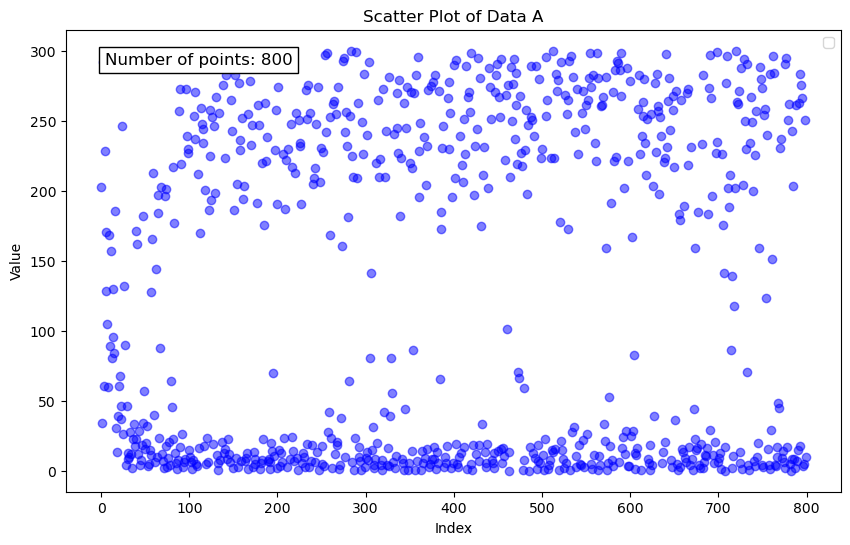

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)


In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0004570083087470149, 0.0004543861538583277, 0.0007743219387928821, 0.00046752447238432434, 0.0004616614086616885, 0.0004553735258756706, 0.0004944797589628941, 0.00044817434950546637, 0.00045771638633157073, 0.00045252361755346624]
Error u of fuhe active learning(LHS sampling): 4.923170e-04
[0.00013925701008905142, 0.00013679358651924782, 0.000233818969348799, 0.0001412323839855714, 0.00013918339199893838, 0.00013850250719788564, 0.00014778875504401718, 0.00013407386322111768, 0.00013902960099696423, 0.0001380793346681271]
MAE of fuhe active learning(LHS sampling): 1.487759e-04
[4.362684170534567e-08, 4.330174409866197e-08, 1.2550480709559344e-07, 4.545154873177081e-08, 4.4411627582287854e-08, 4.3526755381368254e-08, 5.0947261536599495e-08, 4.226464663281596e-08, 4.3789813651862786e-08, 4.287087150834626e-08]
MSE of fuhe active learning(LHS sampling): 5.256959e-08
[0.0023820307, 0.00023904172, 9.181379e-05, 0.00011417376, 0.0052456115, 0.00013461329, 8.307726e-05, 0.0033238116, 0.00

/tmp/ipykernel_1418890/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.0004570083087470149, 0.0004543861538583277, 0.0007743219387928821, 0.00046752447238432434, 0.0004616614086616885, 0.0004553735258756706, 0.0004944797589628941, 0.00044817434950546637, 0.00045771638633157073, 0.00045252361755346624]
mean Error u: 4.923170e-04
Variance Error u: 8.986546e-09


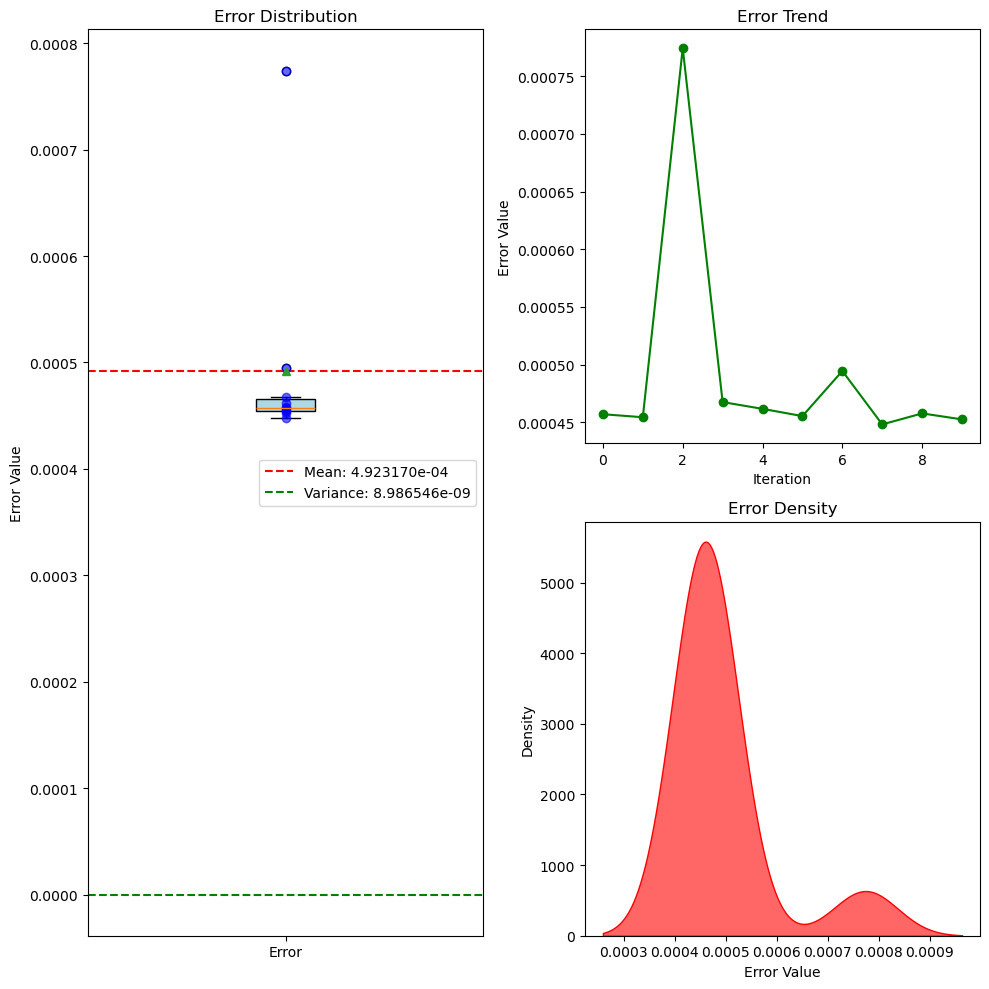

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00013925701008905142, 0.00013679358651924782, 0.000233818969348799, 0.0001412323839855714, 0.00013918339199893838, 0.00013850250719788564, 0.00014778875504401718, 0.00013407386322111768, 0.00013902960099696423, 0.0001380793346681271]
mean MAE: 1.487759e-04
Variance MAE: 8.147503e-10


/tmp/ipykernel_1418890/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


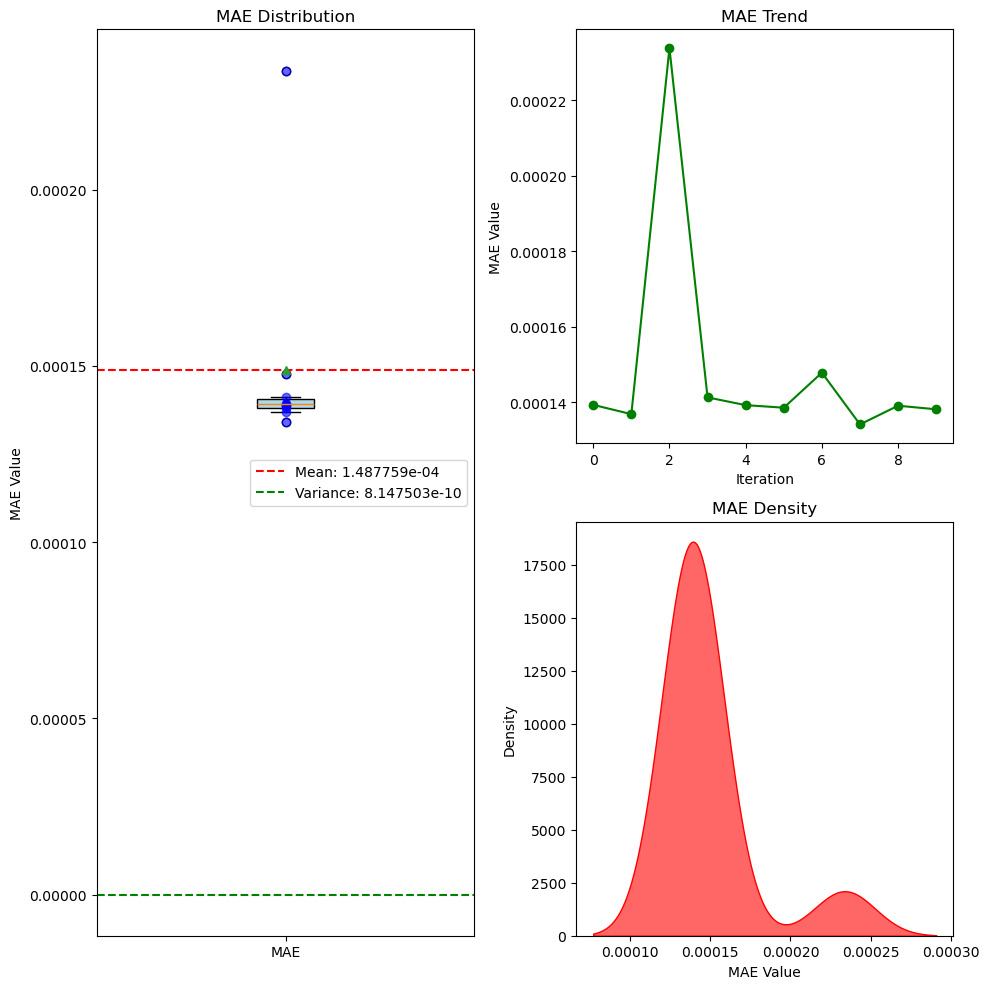

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.362684170534567e-08, 4.330174409866197e-08, 1.2550480709559344e-07, 4.545154873177081e-08, 4.4411627582287854e-08, 4.3526755381368254e-08, 5.0947261536599495e-08, 4.226464663281596e-08, 4.3789813651862786e-08, 4.287087150834626e-08]
mean MSE: 5.256959e-08
Variance MSE: 5.964377e-16


/tmp/ipykernel_1418890/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


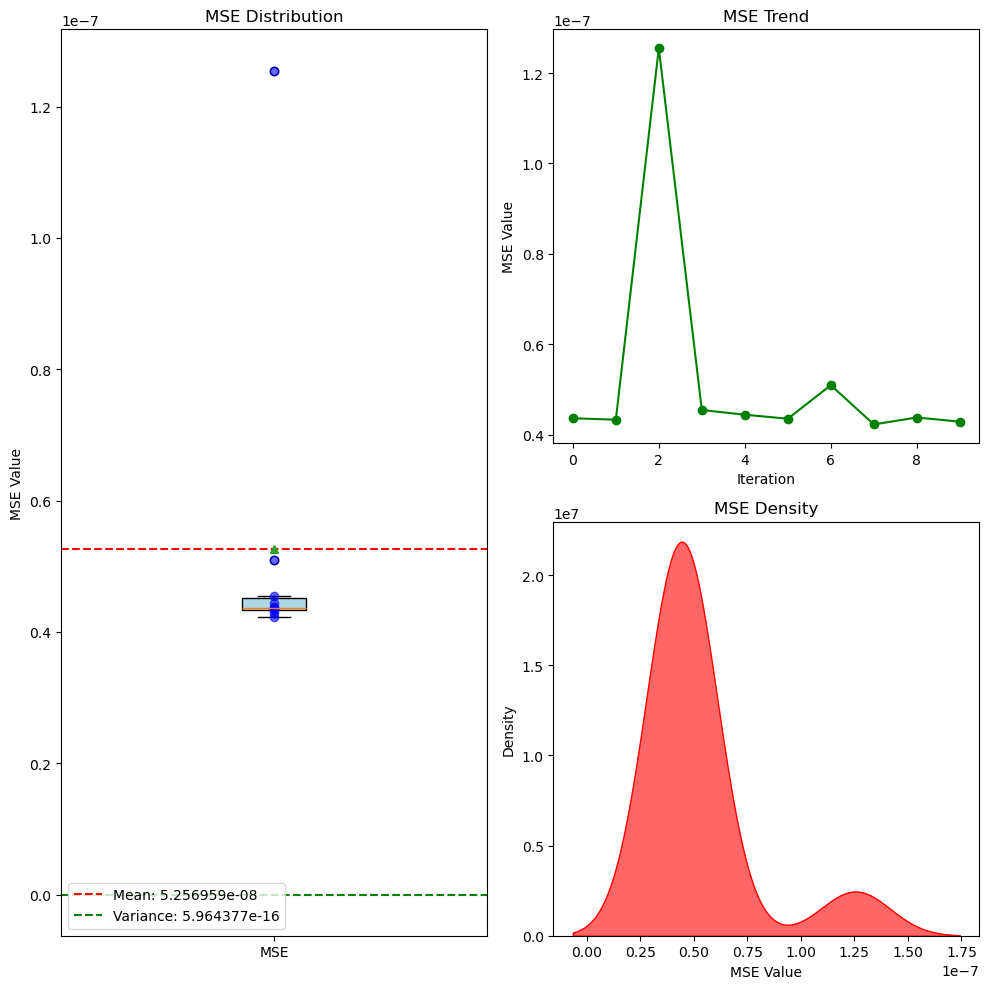

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0023820307, 0.00023904172, 9.181379e-05, 0.00011417376, 0.0052456115, 0.00013461329, 8.307726e-05, 0.0033238116, 0.00011206184, 0.00025385202]
mean CHAOS: 1.198009e-03
Variance CHAOS: 3.006661e-06


/tmp/ipykernel_1418890/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


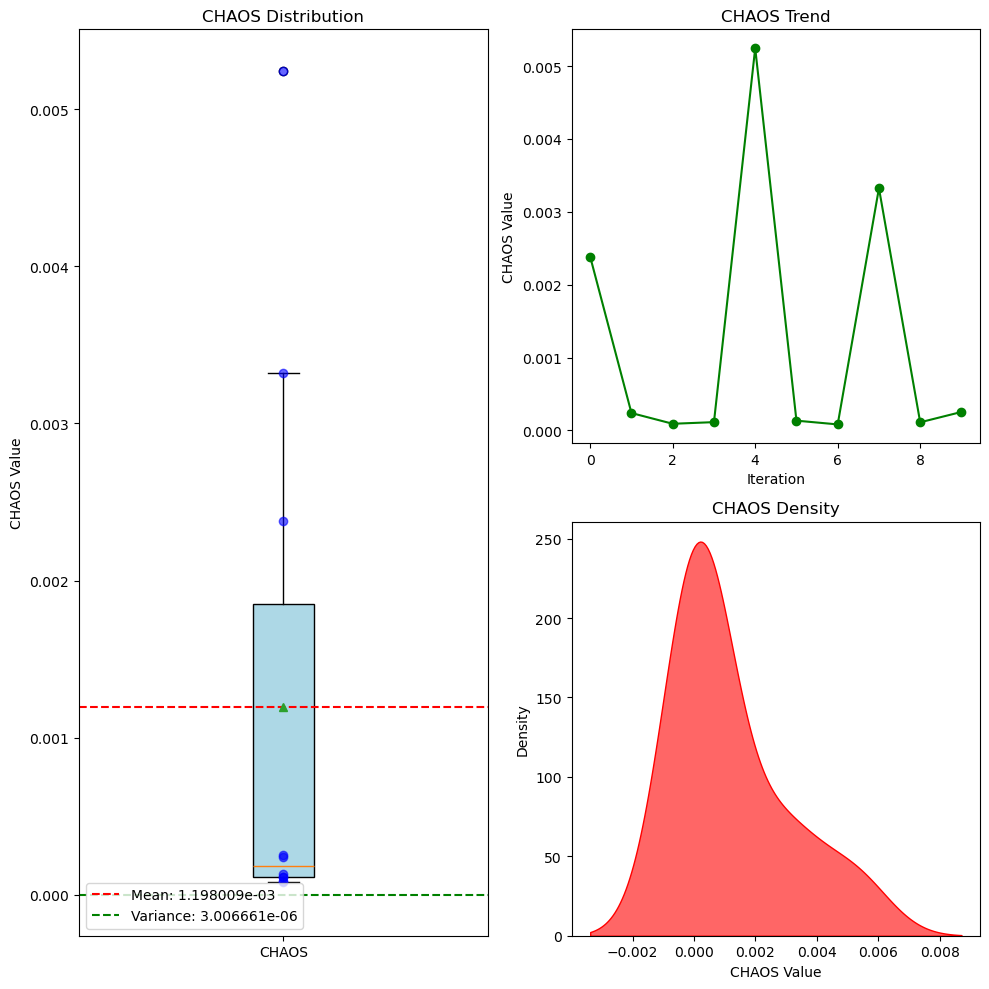

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.859023e-07, 5.654895e-07, 4.253161e-07, 4.2324518e-07, 4.7118897e-07, 3.7065524e-07, 4.8500374e-07, 4.466226e-07, 4.8830566e-07, 4.0876034e-07]
mean RESIDUAL: 4.570490e-07
Variance RESIDUAL: 2.660429e-15


/tmp/ipykernel_1418890/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


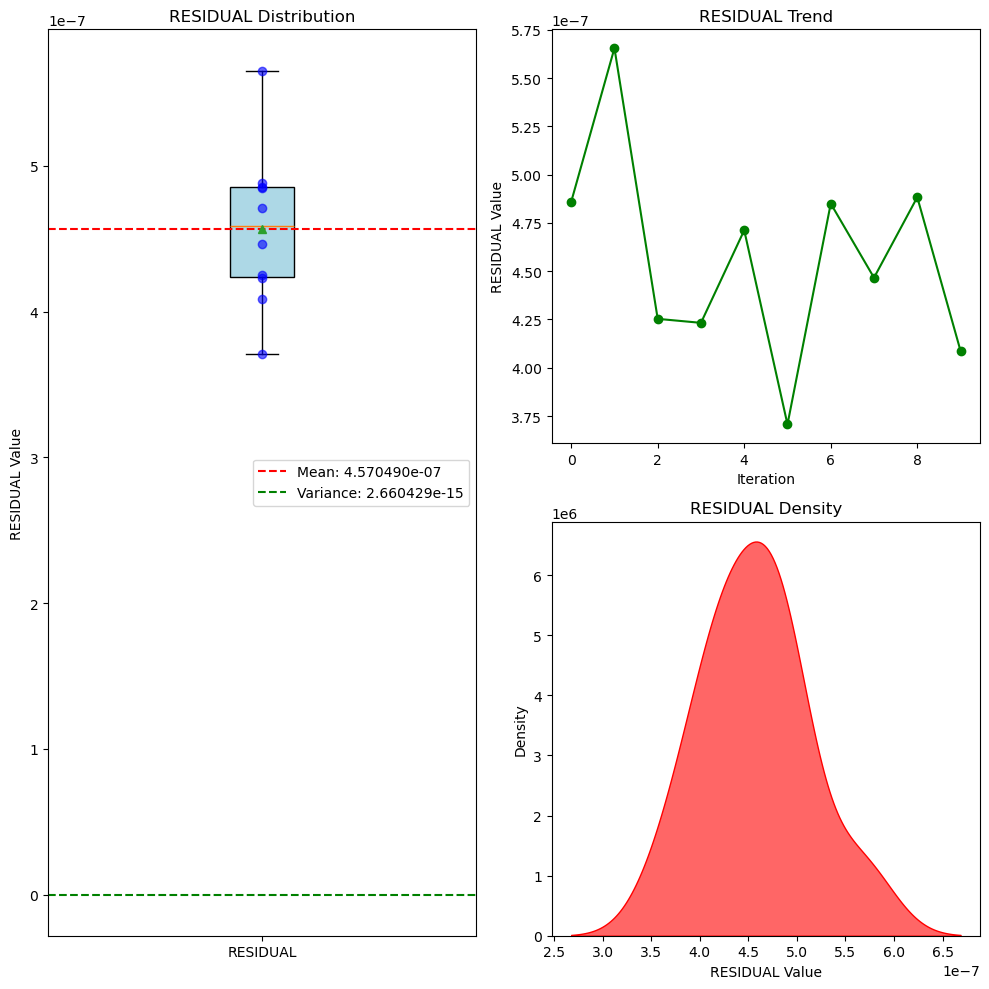

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.9635290e-01 1.6684613e-01 1.3925157e-01 ... 3.2340000e-10 3.2339215e-10
 3.2339742e-10]


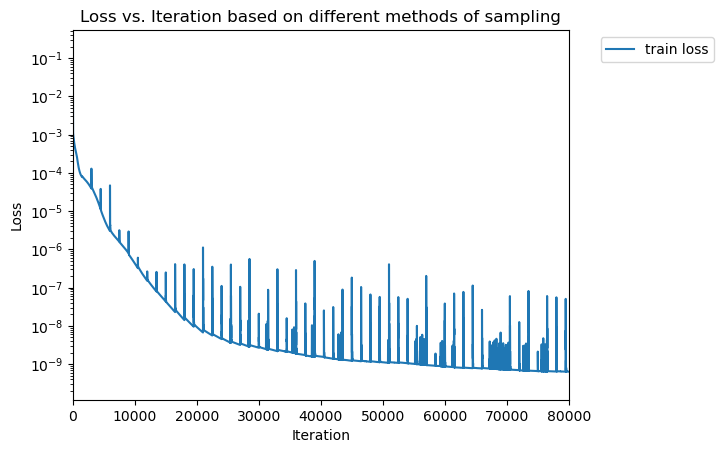

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

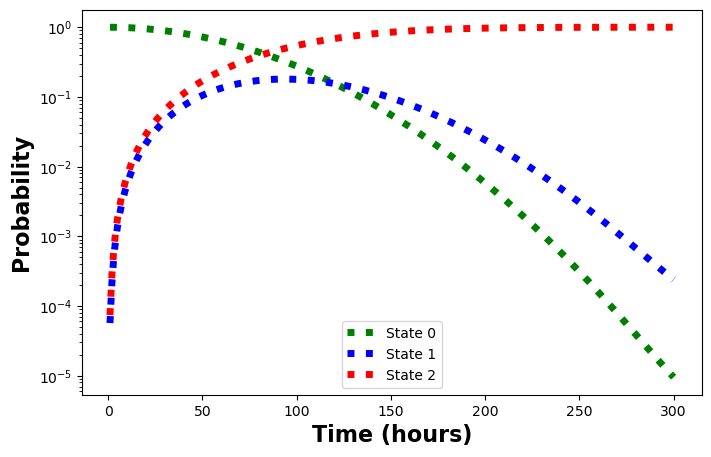

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

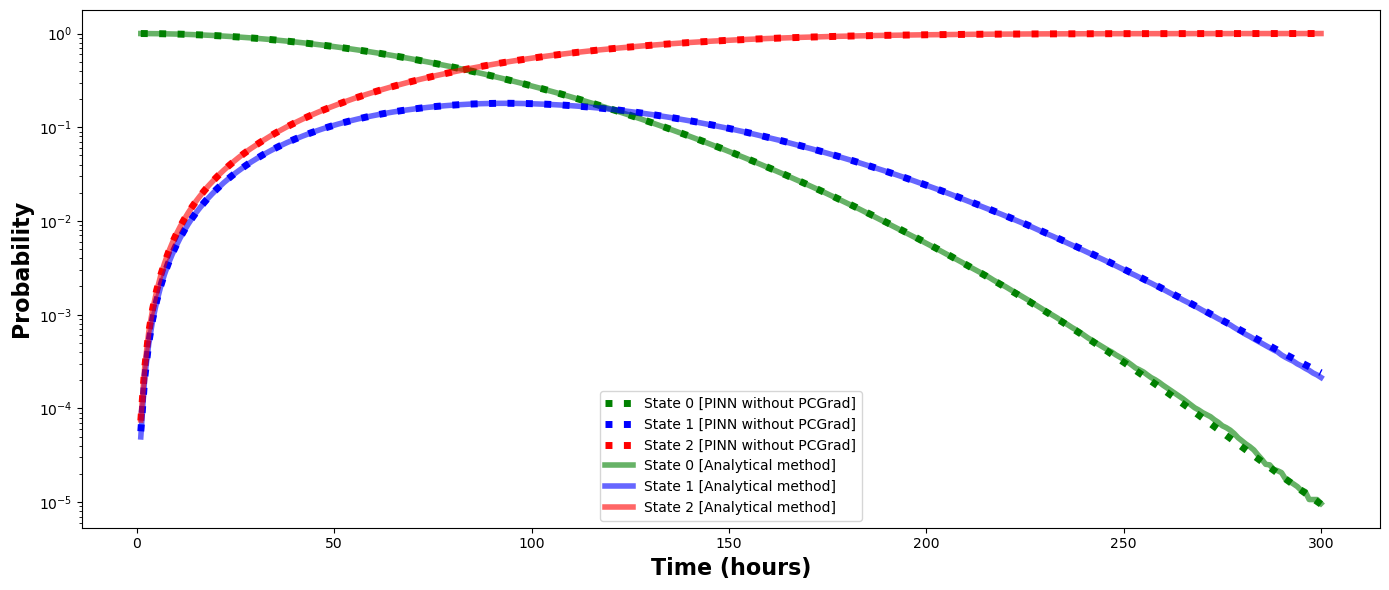

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999869  0.000057  0.000074
1  0.999515  0.000212  0.000274
2  0.998863  0.000496  0.000641
3  0.997950  0.000894  0.001157
4  0.996794  0.001396  0.001810
      state_0   state_1   state_2
295  0.000012  0.000293  0.999695
296  0.000012  0.000278  0.999710
297  0.000011  0.000265  0.999724
298  0.000010  0.000252  0.999738
299  0.000010  0.000240  0.999750


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.0002605841098674509
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.0002605841098674509
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[0.00769277 0.00758409 0.00742785 0.00725902 0.00710829 0.00698683
 0.00689281 0.00681933 0.00676492 0.00672347 0.00669673 0.00667847
 0.0066727  0.00667302 0.00668298 0.00670197 0.00673062 0.0067639
 0.00680395 0.00685244 0.00690411 0.00696117 0.00702269 0.00709013
 0.00715704 0.00722852 0.0072992  0.00737289 0.0074462  0.00751962
 0.0075915  0.00766293 0.00773315 0.00780012 0.00786857 0.00793226
 0.0079943  0.00805271 0.00811004 0.00816476 0.00821786 0.00826945
 0.00831793 0.00836486 0.00840754 0.00845124 0.00849139 0.00852986
 0.00856721 0.00860362 0.00863725 0.00867145 0.00870284 0.0087328
 0.00876243 0.00879042 0.00881973 0.00884691 0.00887155 0.0088959
 0.00892133 0.00894487 0.00896727 0.00898993 0.00901102 0.0090325
 0.00905432 0.00907424 0.00909211 0.00911128 0.00913061 0.00914852
 0.00916572 0.00918294 0.00919891 0.00921439 0.00922958 0.00924538
 0.00925993 0.00927398 0.00928663 0.00929801 0.00931272 0.00932473
 0.00933403 0.0093477  0.00935695 0.00936698 0.00937545 0.00938497

Text(0.5, 1.0, 'Chaos of x_star')

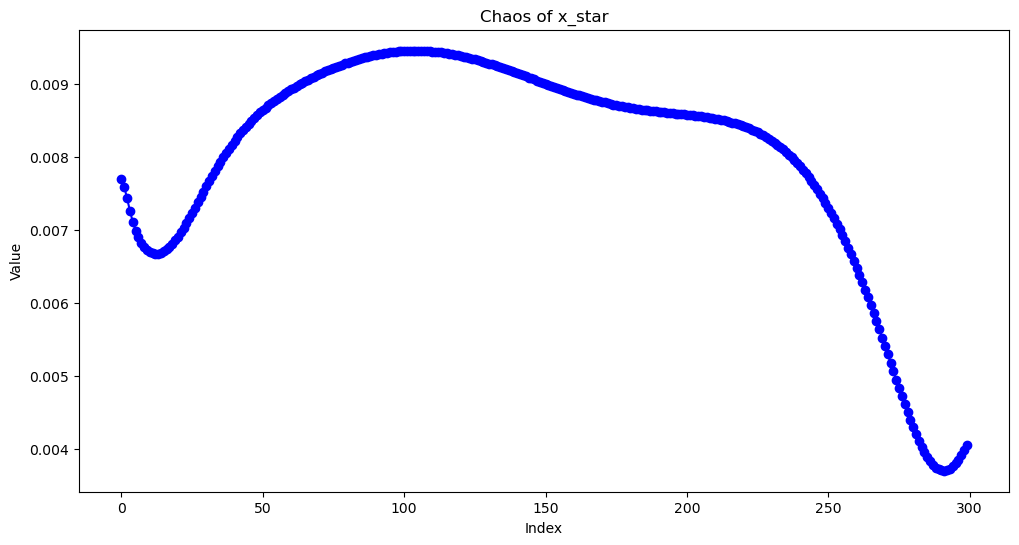

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Chaos of x_star')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[-7.3778210e-09  1.6108970e-08  1.2252713e-08  7.1304385e-09
 -6.4028427e-10  4.2491592e-09  3.1432137e-09 -1.1466909e-08
 -4.0745363e-09 -3.1432137e-09  1.2805685e-09  2.9103830e-09
 -2.9103830e-09 -2.4447218e-09  2.2118911e-09 -2.4447218e-09
 -8.1490725e-10 -9.3132257e-10 -2.7939677e-09  3.2596290e-09
 -6.9849193e-10 -2.7939677e-09 -4.6566129e-10  2.0954758e-09
  3.9581209e-09  2.3283064e-10 -4.6566129e-10  2.3283064e-10
  1.1641532e-09 -4.6566129e-10  6.9849193e-10  2.5611371e-09
 -9.3132257e-10  4.6566129e-10 -2.3283064e-10  2.3283064e-09
 -6.9849193e-10 -1.6298145e-09  1.6298145e-09 -4.6566129e-10
  0.0000000e+00 -4.6566129e-10  2.3283064e-10 -4.6566129e-10
 -2.0954758e-09  9.3132257e-10  2.3283064e-10  0.0000000e+00
  0.0000000e+00  0.0000000e+00  9.3132257e-10 -4.6566129e-10
  2.3283064e-10 -2.3283064e-10  2.3283064e-10 -6.9849193e-10
  0.0000000e+00  0.0000000e+00  1.6298145e-09  1.3969839e-09
  0.0000000e+00  2.7939677e-09 -1.1641532e-09 -4.6566129e-10
  0.0000000e+00 -9.31322

Text(0.5, 1.0, 'Residual of x_star')

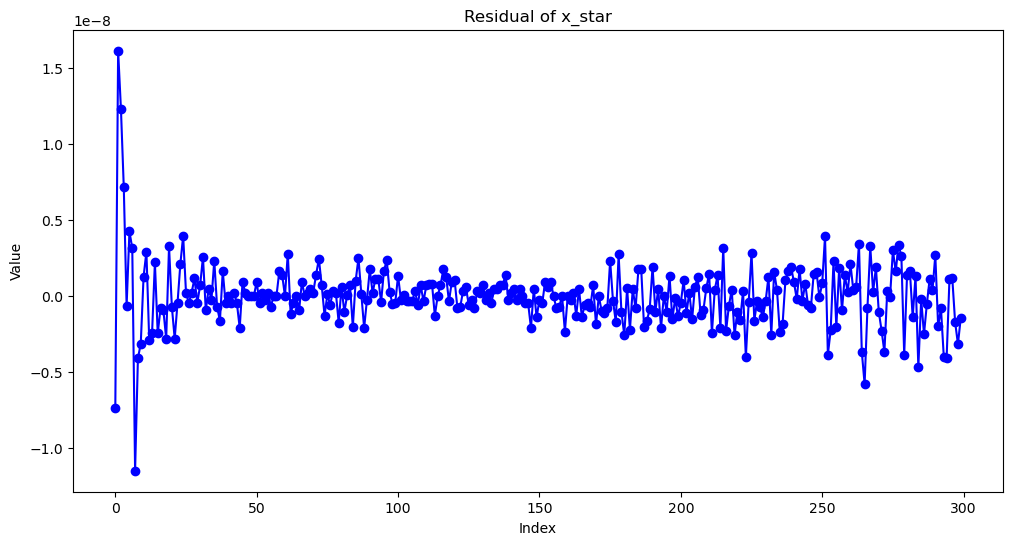

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Residual of x_star')
